# Lets just train a GAN which has all layers turned on but we only pass x through the num of current layers

In [8]:
# All the imports required for this implementation
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.utils import spectral_norm
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

from torchinfo import summary # Allows us to summarise the params and layers

import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import random

# For testing purposes
import tensorflow as tf

2024-07-07 13:48:41.036442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 13:48:41.049637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 13:48:41.049654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 13:48:41.058028: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 13:48:42.942444: W tensorflow/compiler/tf

In [2]:
# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


In [ ]:
del x

In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(images, num_images=16, figsize=(10,10)):
    # Ensure the input is on CPU
    images = images.cpu().detach()
    
    # Normalize images from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    
    # Clamp values to [0, 1] range
    images = torch.clamp(images, 0, 1)
    
    # Make a grid of images
    grid = torchvision.utils.make_grid(images[:num_images], nrow=4)
    
    # Convert to numpy and transpose
    grid = grid.numpy().transpose((1, 2, 0))
    
    # Display the grid
    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [4]:
'''# Load the data and display some images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),  # Resize images to 32x32
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# In the paper batch size changes as the model scales up the images to save memory, however I think with modern
# equipment we can ignore this?
batch_size = 16

# To load the data you must move the images to a folder within the dir they are in
dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)'''

batch_size = 16
def get_dataloader(image_size, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

    return dataloader

layer_1_dataloader = get_dataloader(image_size=4, batch_size=batch_size)
layer_2_dataloader = get_dataloader(image_size=8, batch_size=batch_size)
layer_3_dataloader = get_dataloader(image_size=16, batch_size=batch_size)
layer_4_dataloader = get_dataloader(image_size=32, batch_size=batch_size)

In [198]:
# Lets define the equalized LR conv and linear layers, from https://github.com/KimRass/PGGAN/blob/main/model.py#L26
class EqualLRLinear(nn.Module):
    def __init__(self, in_features, out_features, c=0.2):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.c = c
        
        self.scale = np.sqrt(c / in_features) # Per layer norm constant?
        
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        
        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)
        
    def forward(self, x):
        x = F.linear(x, weight=self.weight * self.scale, bias=self.bias)
        return x

class EqualLRConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, c=0.2):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.c = c
        
        self.scale = (c / (in_channels * kernel_size[0] * kernel_size[1])) ** 0.5
        
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size[0], kernel_size[1]))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        
        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)
                
    def forward(self, x):
        x = F.conv2d(x, weight=self.weight * self.scale, bias=self.bias, stride=self.stride, padding=self.padding)
        return x
    

In [199]:
# Lets create some tooling to assess how our GAN is doing 
# First idea compare the stddev and mean and the overall distribution of the Real and Gen pixels (using hist)
def real_and_gen_stats(real_images, gen_images):
    # Convert to numpy arrays
    real = real_images.cpu().detach().numpy()
    gen = gen_images.cpu().detach().numpy()

    # Reshape to (num_images * height * width, channels)
    real = real.reshape(-1, real.shape[1])
    gen = gen.reshape(-1, gen.shape[1])

    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    channel_names = ['Red', 'Green', 'Blue']
    for i in range(3):
        axs[i].hist(real[:, i], bins=50, alpha=0.5, label='Real', density=True)
        axs[i].hist(gen[:, i], bins=50, alpha=0.5, label='Generated', density=True)
        axs[i].set_title(f'{channel_names[i]} Channel Distribution')
        axs[i].legend()
    plt.show()

    # Calculate mean and std
    real_mean = np.mean(real, axis=0)
    real_std = np.std(real, axis=0)
    gen_mean = np.mean(gen, axis=0)
    gen_std = np.std(gen, axis=0)

    print("Real images - Mean:", real_mean, "Std:", real_std)
    print("Generated images - Mean:", gen_mean, "Std:", gen_std)


In [227]:
# Let's define a function which can generate the conv block
def d_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None):
    if kernel_size2 is not None:
        block = nn.Sequential(
            Mbatch_stddev(),
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
            #nn.Conv2d(out_channels, out_channels, kernel_size2),
            EqualLRConv2d(out_channels, out_channels, kernel_size2),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(in_channels),
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm2d(out_channels),
            # Downsample
            nn.AvgPool2d(kernel_size=(2,2)),
        )
    
    return block

def g_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None, upsample=False):
    if upsample:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
            PixelNorm(),
            #nn.Conv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            EqualLRConv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
            PixelNorm(),
        )
    else:
        block = nn.Sequential(
            #nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            EqualLRConv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
            PixelNorm(),
            #nn.Conv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            EqualLRConv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
            PixelNorm(),
        )
    
    return block

def d_output_layer(input_dim):
    #layer = nn.Linear(input_dim, 1)
    layer = EqualLRLinear(input_dim, 1)
    return layer

def from_to_RGB(in_channels=None, out_channels=None):
    block = nn.Sequential(
        #nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        EqualLRConv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block

def upsample(x):
    return nn.ConvTranspose2d(in_channels=channels, out_channels=channels, kernel_size=2, stride=2)

class Mbatch_stddev(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        '''N, _, H, W = x.shape
    
        # First calculate the stddev for each feature in each spatial location over the batch
        # Which means calculate the stddev of each feature map
        featuremap_stddevs = torch.std(x, dim=0, unbiased=False)
        # Then average these estimates over all features and spatial locations to arrive at a single value
        mean_stddev = torch.mean(featuremap_stddevs)
        stddev_featuremap = mean_stddev * torch.ones((N, 1, H, W), device=x.device)

        x = torch.cat((x, stddev_featuremap), dim=1)

        return x'''
        b, _, h, w = x.shape
        # "We compute the standard deviation for each feature in each spatial location over the minibatch.
        # We then average these estimates over all features and spatial locations to arrive at a single value.
        # We replicate the value and concatenate it to all spatial locations and over the minibatch,
        # yielding one additional (constant) feature map."
        feat_map = x.std(dim=0, keepdim=True).mean(dim=(1, 2, 3), keepdim=True)
        x = torch.cat([x, feat_map.repeat(b, 1, h, w)], dim=1)
        return x

'''class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
    
    def forward(self, x):
        #square_sum = torch.pow(x, 2).sum(dim=1, keepdim=True)  # Sum across all channels
        #norm_factor = torch.sqrt(square_sum / x.size(1) + self.epsilon)  # Divide by N (number of channels)
        #return x / norm_factor  # Normalize
        x = x / torch.sqrt((x ** 2).mean(dim=1, keepdim=True)+ self.epsilon)
        return x'''

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()

    def forward(self, x, epsilon=1e-8):
        #return x * (((x**2).mean(dim=1, keepdim=True) + epsilon).rsqrt())
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + epsilon)
        

In [228]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''self.block9 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3)).to(device)
        self.block8 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3)).to(device)
        self.block7 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3)).to(device)
        self.block6 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3)).to(device)
        self.block5 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3)).to(device)'''
        self.block4 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block3 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block2 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block1 = d_conv_block(in_channels=513, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4)).to(device)
        
        self.down = nn.AvgPool2d(kernel_size=(2,2), stride=2).to(device)  # This isnt used for the layers but the res connection
        
        '''self.from_rgb9 = from_to_RGB(in_channels=3, out_channels=16).to(device)
        self.from_rgb8 = from_to_RGB(in_channels=3, out_channels=32).to(device)
        self.from_rgb7 = from_to_RGB(in_channels=3, out_channels=64).to(device)
        self.from_rgb6 = from_to_RGB(in_channels=3, out_channels=128).to(device)
        self.from_rgb5 = from_to_RGB(in_channels=3, out_channels=256).to(device)'''
        self.from_rgb4 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb3 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb2 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb1 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        
        self.FC1 = nn.Identity()
        
        '''self.blocks = [
            self.block1, self.block2, self.block3, self.block4, 
            self.block5, self.block6, self.block7, self.block8, self.block9,
        ]
        self.from_rgbs = [
            self.from_rgb1, self.from_rgb2, self.from_rgb3, self.from_rgb4,
            self.from_rgb5, self.from_rgb6, self.from_rgb7, self.from_rgb8, self.from_rgb9,
        ]'''
        
        self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            #self.block5, self.block6, self.block7,
        ]
        self.from_rgbs = [
            self.from_rgb1, self.from_rgb2, self.from_rgb3, self.from_rgb4,
            #self.from_rgb5, self.from_rgb6, self.from_rgb7,
        ]
    
    def forward(self, x, alpha=1, layer_num=0):
        in_x = torch.clone(x)
        x = self.from_rgbs[layer_num-1](x)
        
        for i in reversed(range(layer_num)):
            #print(f'Layer_num: {i}')
            #print(f'x before block: {x.shape}')
            #print(self.blocks[i])
            x = self.blocks[i](x)
            #print(f'x after block: {x.shape}')
            if i == layer_num-1 and alpha < 1 and layer_num > 1:
                # Fade in the new layer
                downscaled = self.down(in_x)
                from_rgb = self.from_rgbs[layer_num-2](downscaled)
                x = (alpha * x) + ((1 - alpha) * from_rgb)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        x = self.FC1(x)
                
        return x
        
d_32 = Discriminator_32() 
d_32 = d_32.to(device)

In [251]:
class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3)).to(device)
        #self.up1 = upsample(512).to(device)
        self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up2 = upsample(512).to(device)
        self.block3 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up3 = upsample(512).to(device)
        self.block4 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        # Lets leave out the last 5 layers for 32x32 generations
        '''self.up4 = upsample(512).to(device)
        self.block5 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up5 = upsample(256).to(device)
        self.block6 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up6 = upsample(128).to(device)
        self.block7 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up7 = upsample(64).to(device)
        self.block8 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        #self.up8 = upsample(32).to(device)
        self.block9 = g_conv_block(in_channels=32, out_channels=16, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)'''
                
        self.to_rgb1 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb2 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb3 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb4 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        '''self.to_rgb5 = from_to_RGB(in_channels=256, out_channels=3).to(device)
        self.to_rgb6 = from_to_RGB(in_channels=128, out_channels=3).to(device)
        self.to_rgb7 = from_to_RGB(in_channels=64, out_channels=3).to(device)
        self.to_rgb8 = from_to_RGB(in_channels=32, out_channels=3).to(device)
        self.to_rgb9 = from_to_RGB(in_channels=16, out_channels=3).to(device)'''
        
        self.tanh = nn.Tanh()
        
        '''self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            self.block5, self.block6, self.block7, self.block8, self.block9
        ]
        self.ups = [
            self.up1, self.up2, self.up3, 
            self.up4, self.up5, self.up6,
            self.up7, self.up8,
        ]
        self.to_rgbs = [
            self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4,
            self.to_rgb5, self.to_rgb6, self.to_rgb7, self.to_rgb8, self.to_rgb9,
        ]'''
        
        self.blocks = [
            self.block1, self.block2, self.block3, self.block4,
            #self.block5, self.block6, self.block7
        ]
        #self.ups = [
        #    self.up1, self.up2, self.up3, 
            #self.up4, self.up5, self.up6,
        #]
        self.to_rgbs = [
            self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4,
            #self.to_rgb5, self.to_rgb6, self.to_rgb7
        ]
        
    def forward(self, x, alpha=1, layer_num=0):
        for i in range(layer_num):
            x = self.blocks[i](x)
            if i < layer_num - 1:
                #x = self.ups[i](x)
                x = F.interpolate(x, scale_factor=2, mode="nearest")
            if i == layer_num - 2:
                res_x = torch.clone(x)
            
        out = self.to_rgbs[layer_num-1](x)
        
        if layer_num > 1 and alpha < 1:
            prev_rgb = self.to_rgbs[layer_num-2](res_x)
            
            # Interpolate between the two outputs
            out = (1 - alpha) * prev_rgb + alpha * out
        
        out = self.tanh(out)
        
        return out
    
g_32 = Generator_32()
g_32 = g_32.to(device)

# Copying the PyTorch PGGAN

In [176]:
# Helper class for reshaping (unchanged)
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)

class Generator_32(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_norm = PixelNorm()
        
        # Initial layers
        self.initial = nn.Sequential(
            EqualLRLinear(512, 8192),  # 512-dim vector to 8192
            Reshape(-1, 512, 4, 4),    # Reshape to 512x4x4
            nn.LeakyReLU(0.2),
            PixelNorm()
        )
        self.block0 = nn.Sequential(
            EqualLRConv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1).to(device),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )
        
        self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
        self.block3 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(3,3), upsample=True).to(device)
    
                
        self.to_rgb1 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb2 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb3 = from_to_RGB(in_channels=512, out_channels=3).to(device)
        self.to_rgb4 = from_to_RGB(in_channels=512, out_channels=3).to(device)

        
        self.tanh = nn.Tanh()

        
        self.blocks = [
            self.block0, self.block1, self.block2, self.block3,
        ]
        self.to_rgbs = [
            self.to_rgb1, self.to_rgb2, self.to_rgb3, self.to_rgb4,
        ]
        
    def forward(self, x, alpha=1, layer_num=0):
        # Normalise the input
        #x = self.input_norm(x)
        
        x = x.view(x.size(0), -1)
        x = self.initial(x)
        
        for i in range(layer_num):
            x = self.blocks[i](x)
            if i < layer_num - 1:
                x = F.interpolate(x, scale_factor=2, mode="nearest")
            if i == layer_num - 2:
                res_x = torch.clone(x)
            
        out = self.to_rgbs[layer_num-1](x)
        
        if layer_num > 1 and alpha < 1:
            prev_rgb = self.to_rgbs[layer_num-2](res_x)
            
            # Interpolate between the two outputs
            out = (1 - alpha) * prev_rgb + alpha * out
        
        out = self.tanh(out)
        
        return out
    
g_32 = Generator_32()
g_32 = g_32.to(device)

In [177]:
class Discriminator_32(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block3 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block2 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block1 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(device)
        self.block0 = nn.Sequential(
            Mbatch_stddev(),
            EqualLRConv2d(in_channels=513, out_channels=512, kernel_size=(3,3), stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualLRLinear(8192, 512)
        )
        
        self.down = nn.AvgPool2d(kernel_size=(2,2), stride=2).to(device)  # This isnt used for the layers but the res connection

        self.from_rgb3 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb2 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb1 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        self.from_rgb0 = from_to_RGB(in_channels=3, out_channels=512).to(device)
        
        #self.linear1 = nn.
        
        self.FC1 = nn.Identity()
        
        self.blocks = [
            self.block0, self.block1, self.block2, self.block3,
        ]
        self.from_rgbs = [
            self.from_rgb0, self.from_rgb1, self.from_rgb2, self.from_rgb3,
        ]
    
    def forward(self, x, alpha=1, layer_num=0):
        in_x = torch.clone(x)
        x = self.from_rgbs[layer_num-1](x)
        
        for i in reversed(range(layer_num)):
            x = self.blocks[i](x)
            if i == layer_num-1 and alpha < 1 and layer_num > 1:
                # Fade in the new layer
                downscaled = self.down(in_x)
                from_rgb = self.from_rgbs[layer_num-2](downscaled)
                x = (alpha * x) + ((1 - alpha) * from_rgb)
                
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        x = self.FC1(x)
                
        return x
        
d_32 = Discriminator_32() 
d_32 = d_32.to(device)

In [81]:
d_in = torch.randn(2, 3, 32, 32).to(device)

# For 4x4 resolution (first stage)
#out = d_32(d_in, alpha=0.5, layer_num=1)

# For 8x8 resolution with alpha=0.5
#out = d_32(d_in, alpha=0.5, layer_num=2)

# For 16x16 resolution
#out = d_32(d_in, alpha=0.5, layer_num=3)

# For  32x32 resolution
out = d_32(d_in, alpha=0.5, layer_num=4)

# For 256x256 res
#out = d_32(d_in, alpha=0.5, layer_num=7)

print(out)

torch.Size([2, 512])
torch.Size([2, 512])
tensor([[4.0800e-05],
        [2.3789e-05]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [245]:
g_in = torch.randn((1, 512, 1, 1), device=device)

# For 4x4 resolution (first stage)
#out = g_32(g_in, alpha=0, layer_num=1)

# For 8x8 resolution with alpha=0.5
#out = g_32(g_in, alpha=0.5, layer_num=2)

# For 16x16 resolution
#out = g_32(g_in, alpha=0.5, layer_num=3)

# For full 32x32 resolution
out = g_32(g_in, alpha=0.5, layer_num=4)

#out = g_32(g_in, alpha=0.5, layer_num=7)

print(out.shape)

torch.Size([1, 3, 32, 32])


In [246]:
class WGAN_GP_Loss(nn.Module):
    def __init__(self, lambda_gp=10, epsilon_drift=0.001):
        super().__init__()
        self.lambda_gp = lambda_gp
        self.epsilon_drift = epsilon_drift

    def compute_gradient_penalty(self, discriminator, real_samples, fake_samples, alpha, layer_num):
        batch_size = real_samples.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
        interpolates = (epsilon * real_samples + ((1 - epsilon) * fake_samples)).requires_grad_(True)
        d_interpolates = discriminator(interpolates, alpha, layer_num)
        fake = torch.ones(batch_size, 1).to(real_samples.device)
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def forward(self, discriminator, real_imgs, fake_imgs, alpha, layer_num):
        real_validity = discriminator(real_imgs, alpha, layer_num)
        fake_validity = discriminator(fake_imgs, alpha, layer_num)
        
        gradient_penalty = self.compute_gradient_penalty(discriminator, real_imgs, fake_imgs, alpha, layer_num)
        
        # Add drift penalty
        drift_penalty = self.epsilon_drift * torch.mean(real_validity**2)
        
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + self.lambda_gp * gradient_penalty + drift_penalty
        g_loss = -torch.mean(fake_validity)
        #g_loss = -fake_validity.mean() * 10  # Scale the loss

        
        return d_loss, g_loss

In [247]:
def weights_init(m):
    '''if isinstance(m, (nn.Conv2d, nn.Linear)):
        print(m)
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)'''
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

'''def weights_init(m):
    if isinstance(m, (EqualLRConv2d, EqualLRLinear)):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)'''

'def weights_init(m):\n    if isinstance(m, (EqualLRConv2d, EqualLRLinear)):\n        nn.init.xavier_normal_(m.weight.data)\n        if m.bias is not None:\n            nn.init.constant_(m.bias, 0)\n    elif type(m) == nn.BatchNorm2d:\n        nn.init.normal_(m.weight, 1.0, 0.02)\n        nn.init.constant_(m.bias, 0)'

In [261]:
# Lets build a training loop using just BCELoss and see what happens
# For intial experiment I will use BCELoss however the actual paper uses: https://arxiv.org/abs/1704.00028
#criterion = nn.BCEWithLogitsLoss()
criterion = WGAN_GP_Loss()

d_32 = Discriminator_32() 
d_32.apply(weights_init)
d_32 = d_32.to(device)

g_32 = Generator_32() 
#g_32 = SimpleGenerator()
g_32.apply(weights_init)
g_32 = g_32.to(device)

#torch.nn.utils.clip_grad_norm_(d_32.parameters(), max_norm=1.0)
#torch.nn.utils.clip_grad_norm_(g_32.parameters(), max_norm=1.0)

# Intialise two optimisers
optim_D = torch.optim.Adam(d_32.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))
optim_G = torch.optim.Adam(g_32.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))

latent_dim = (batch_size, 512, 1, 1)

scaler = GradScaler()

In [262]:
def check_zero_biases(model):
    zero_bias = True
    for name, param in model.named_parameters():
        if 'bias' in name:
            if param.data.sum() != 0:
                print(f"Non-zero bias found in {name}: sum = {param.data.sum().item()}")
                zero_bias = False
    
    if zero_bias:
        print("All biases are zero.")
    else:
        print("Some biases are non-zero.")

def compute_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm     

def check_gradients(model):
    print(model)
    for name, param in model.named_parameters():
        if param.grad is None:
            print(f"No gradient for {name}")
        elif param.grad.abs().sum() == 0:
            print(f"Zero gradient for {name}")
        else:
            print(f"Gradient present for {name}: {param.grad.abs().mean().item()}")
            
# Usage:
check_zero_biases(g_32)  # Check generator
check_zero_biases(d_32)  # Check discriminator

All biases are zero.
All biases are zero.


Training layer: 1
Epoch: 0 Outputting statistics: 


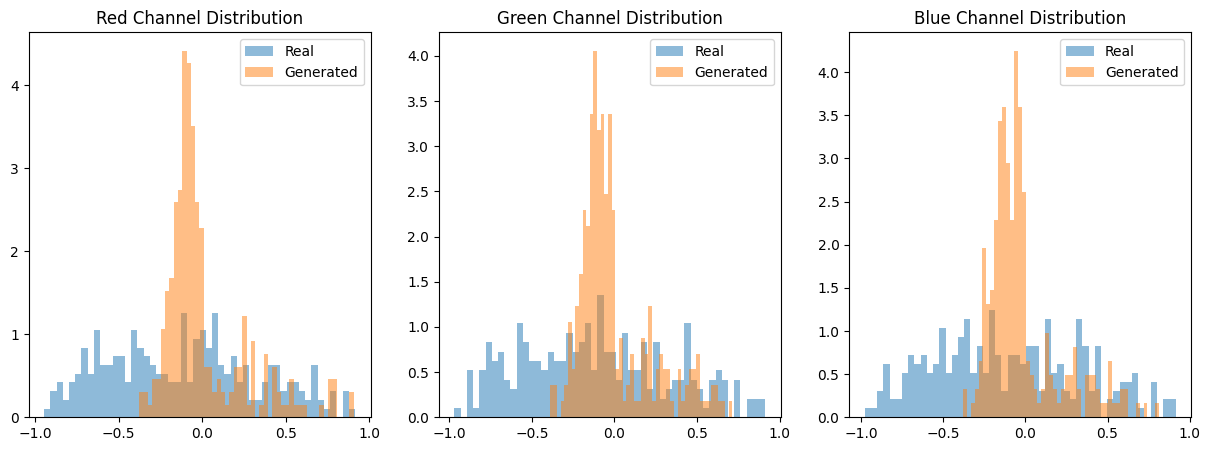

Real images - Mean: [-0.10808821 -0.11096815 -0.10900734] Std: [0.44810572 0.44778883 0.44495106]
Generated images - Mean: [ 0.00947653  0.00072137 -0.01344454] Std: [0.24475475 0.22578898 0.22163391]


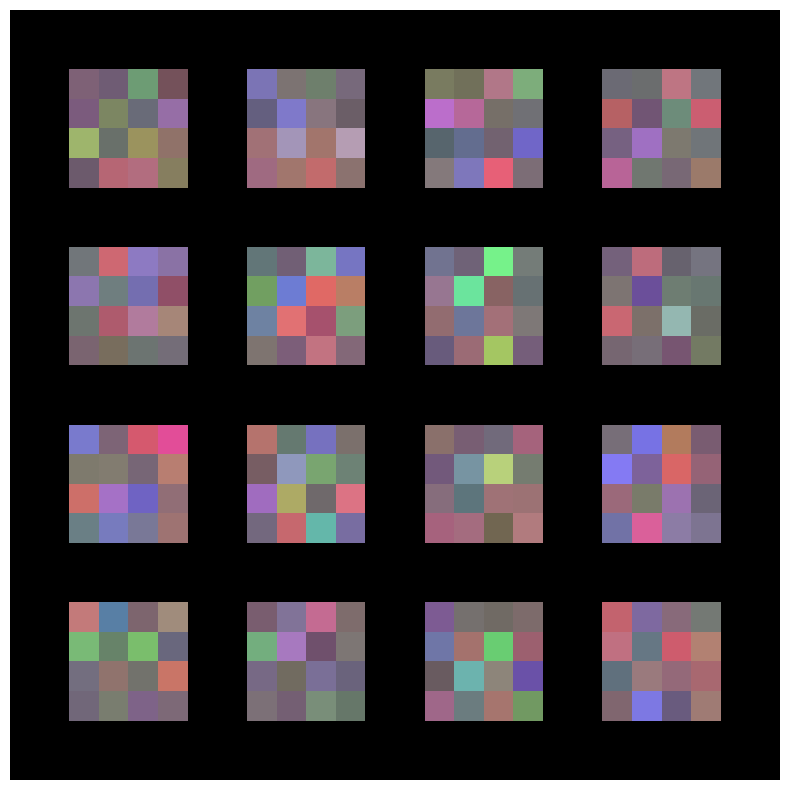

Layer 1: Loss_D: 5.7372727394104, Loss_G: 0.07970456033945084
D Grad Norm : 1.4104, G Grad Norm: 0.1005
Epoch: 1 Outputting statistics: 


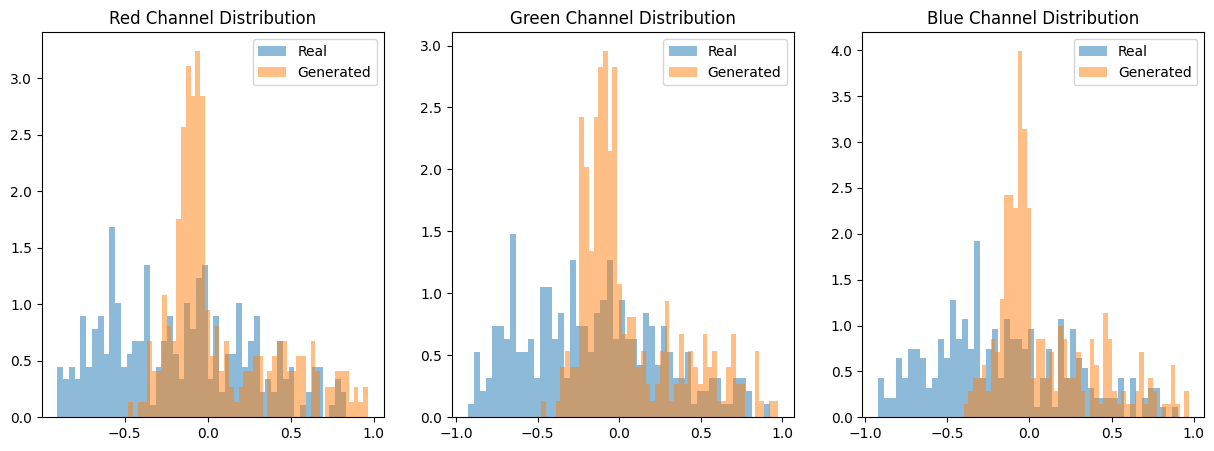

Real images - Mean: [-0.15848647 -0.163511   -0.1639705 ] Std: [0.43057606 0.419456   0.41694275]
Generated images - Mean: [0.08082338 0.05643192 0.09408837] Std: [0.3271169  0.30549452 0.3010824 ]


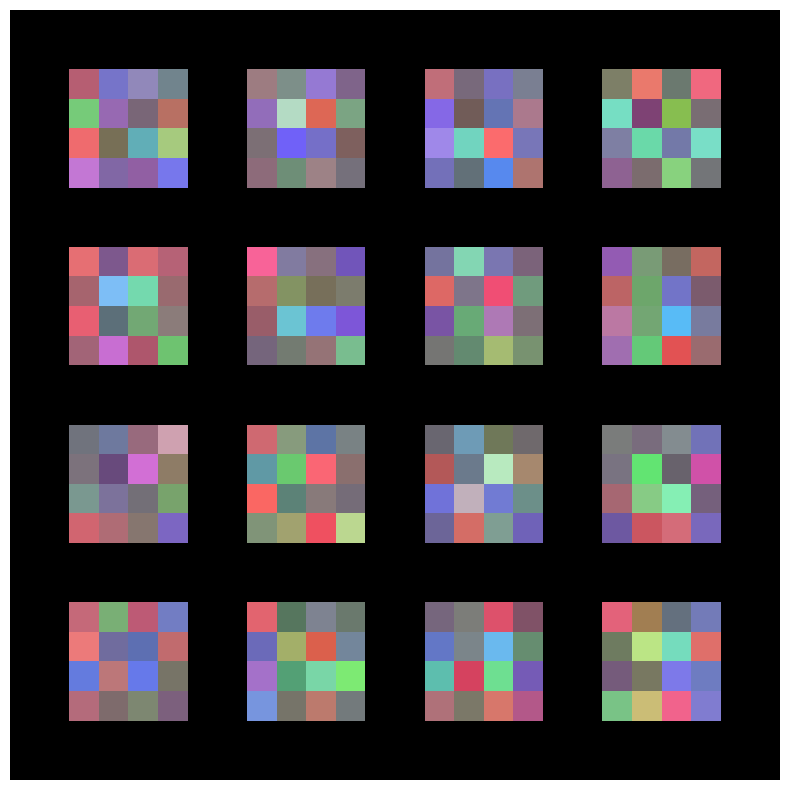

Layer 1: Loss_D: -0.03570503368973732, Loss_G: -0.2903691530227661
D Grad Norm : 0.4541, G Grad Norm: 0.4656
Epoch: 2 Outputting statistics: 


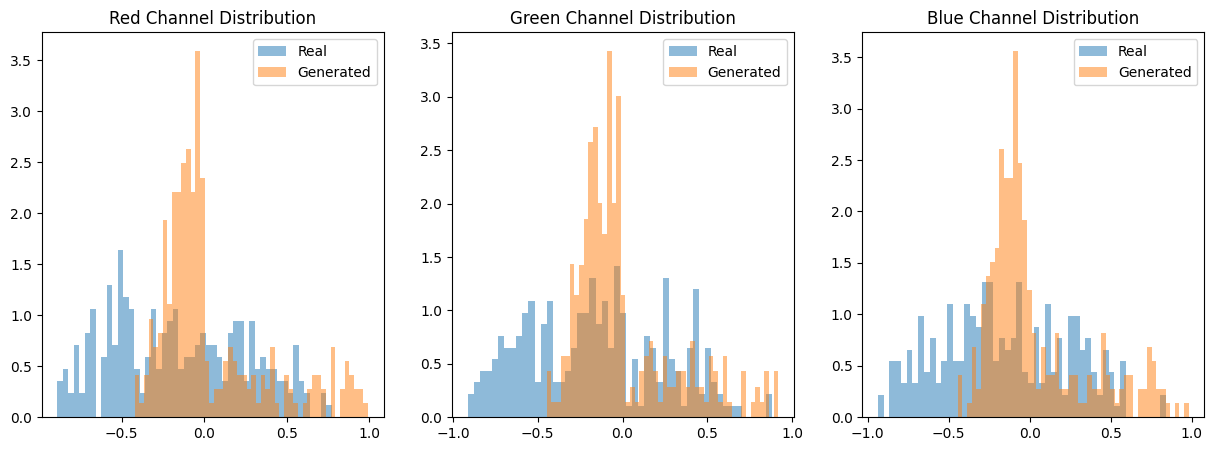

Real images - Mean: [-0.15713844 -0.15386026 -0.15572913] Std: [0.40720338 0.40661243 0.39343074]
Generated images - Mean: [0.0487312  0.0089983  0.03616352] Std: [0.33399102 0.2995332  0.31380594]


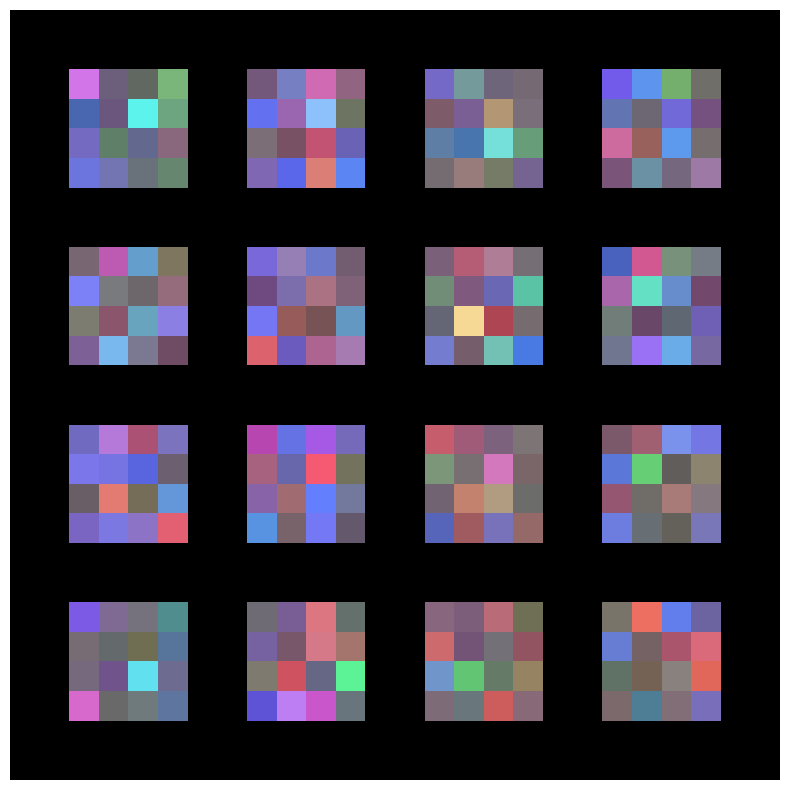

Layer 1: Loss_D: 0.9567642211914062, Loss_G: -0.11568062752485275
D Grad Norm : 1.1277, G Grad Norm: 0.3397
Epoch: 3 Outputting statistics: 


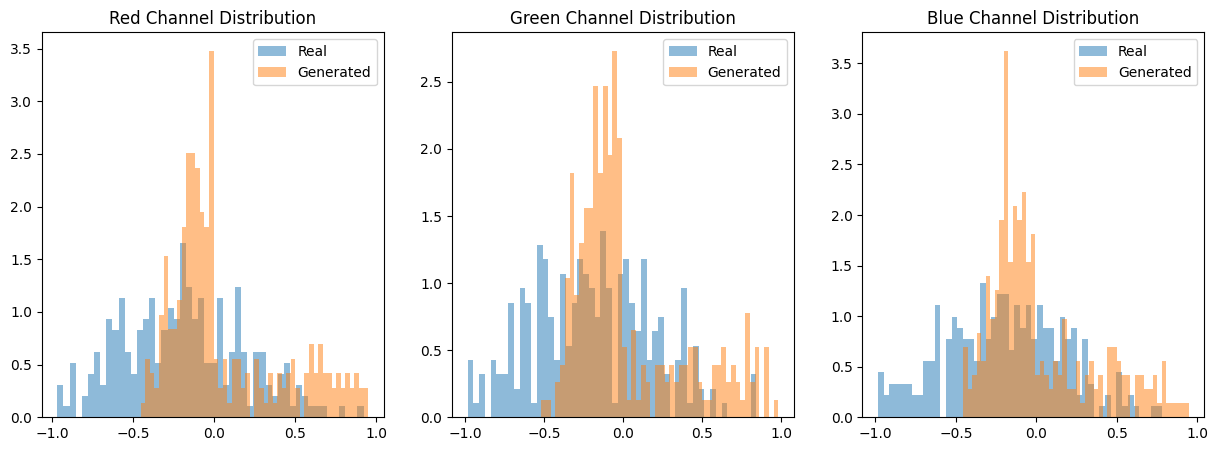

Real images - Mean: [-0.19258583 -0.19206491 -0.1975797 ] Std: [0.3747187  0.37850282 0.36644533]
Generated images - Mean: [0.06412191 0.03393378 0.02556158] Std: [0.35144928 0.35166013 0.3283792 ]


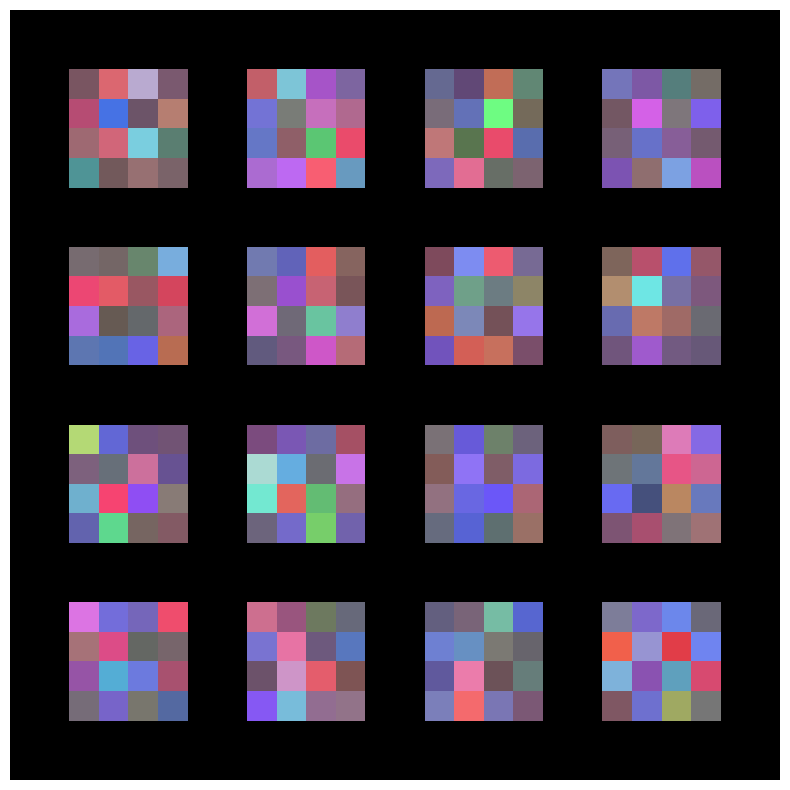

Layer 1: Loss_D: 0.3954468369483948, Loss_G: -0.020322605967521667
D Grad Norm : 0.4830, G Grad Norm: 0.4355
Epoch: 4 Outputting statistics: 


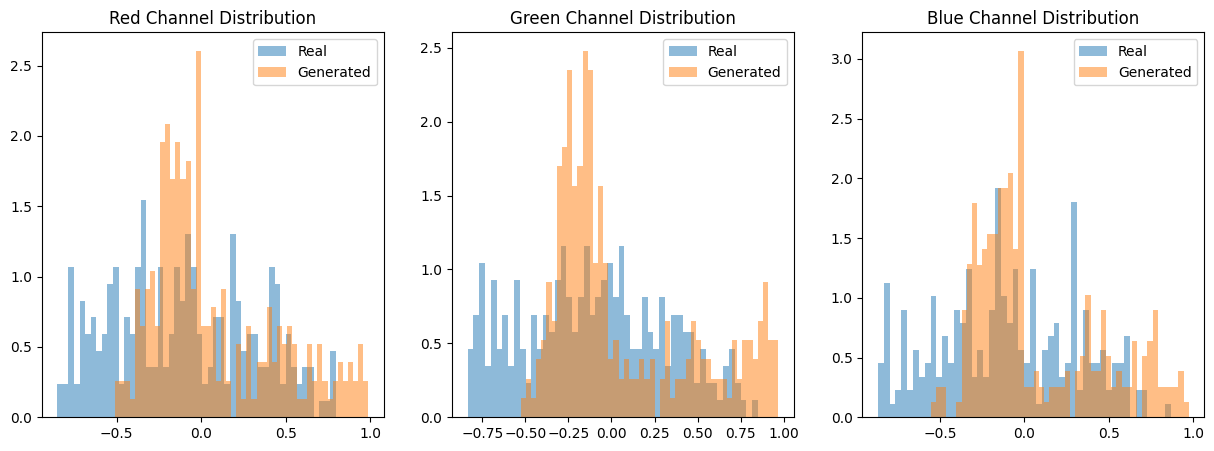

Real images - Mean: [-0.10456496 -0.10480999 -0.10009189] Std: [0.41582385 0.4130757  0.40752542]
Generated images - Mean: [0.07375231 0.07293332 0.07075584] Std: [0.36841324 0.41116446 0.37265277]


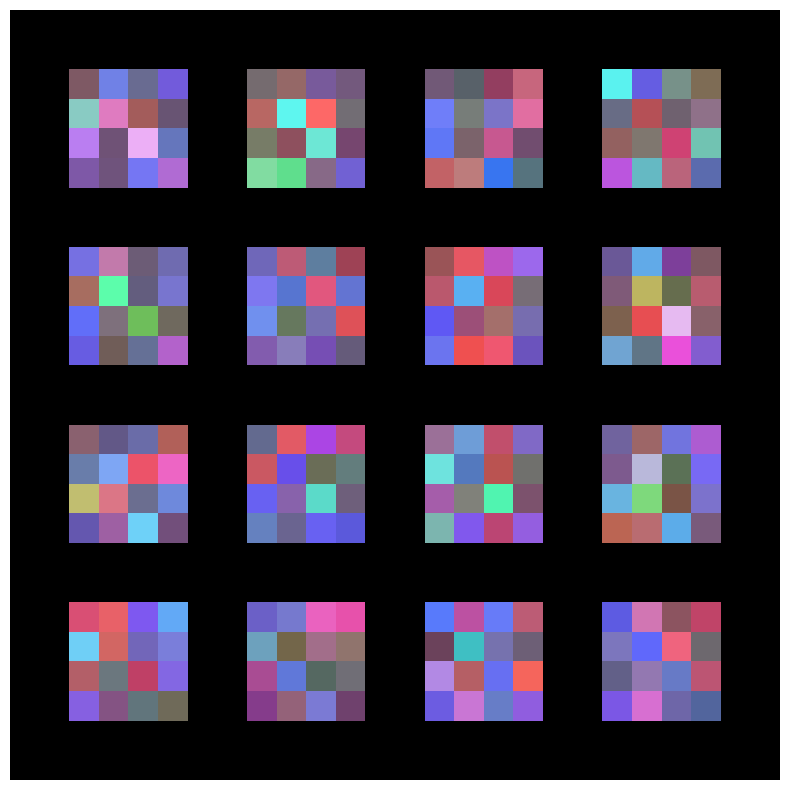

Layer 1: Loss_D: 0.8716639280319214, Loss_G: 0.48231327533721924
D Grad Norm : 0.5353, G Grad Norm: 0.4888
Epoch: 5 Outputting statistics: 


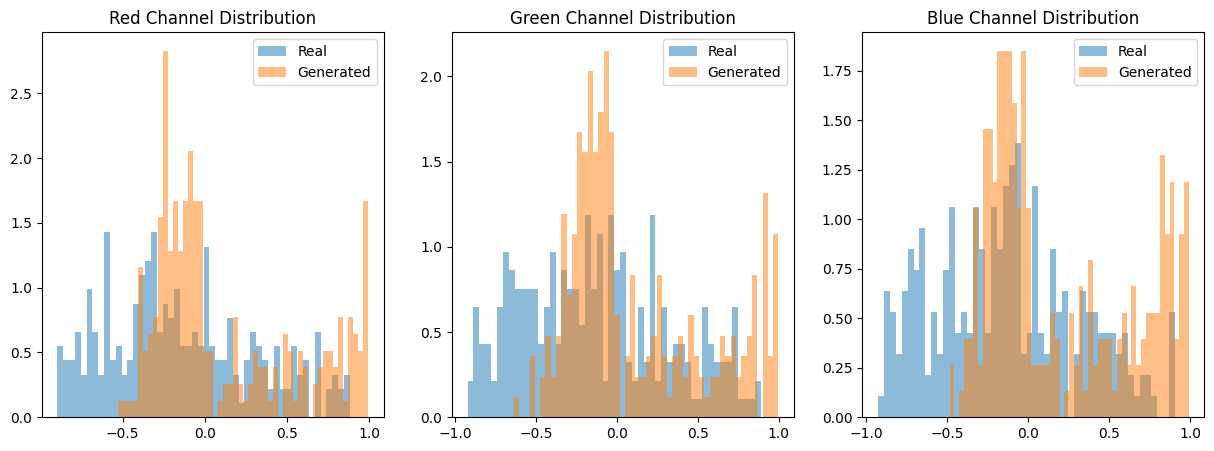

Real images - Mean: [-0.14053304 -0.13547793 -0.13995102] Std: [0.44911274 0.44986895 0.44048628]
Generated images - Mean: [0.1301984  0.12535241 0.20643003] Std: [0.43792146 0.42736927 0.44428158]


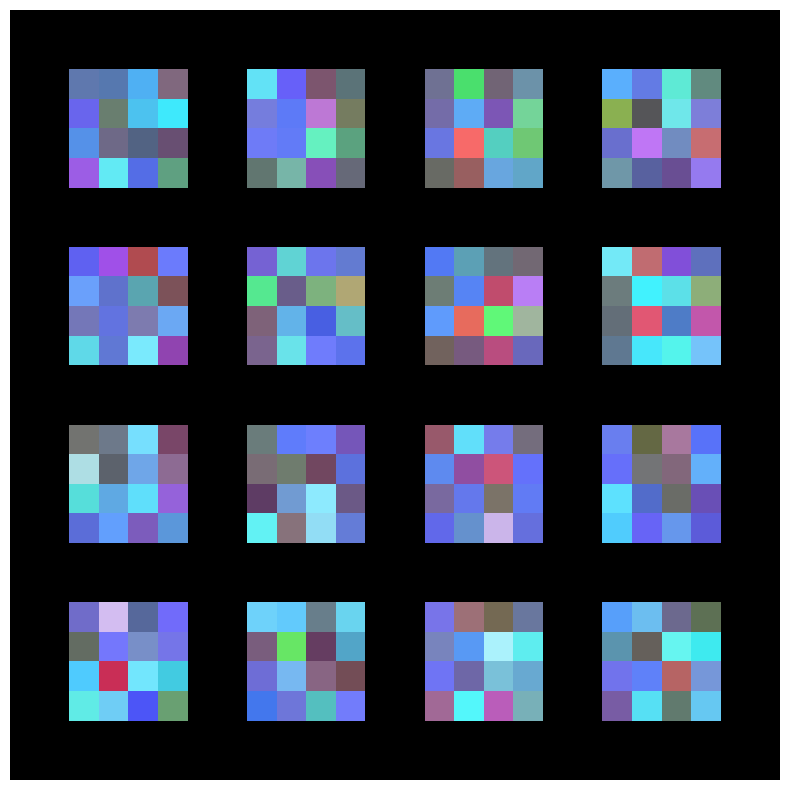

Layer 1: Loss_D: 1.4330857992172241, Loss_G: 0.335207998752594
D Grad Norm : 0.5166, G Grad Norm: 0.3345
Epoch: 6 Outputting statistics: 


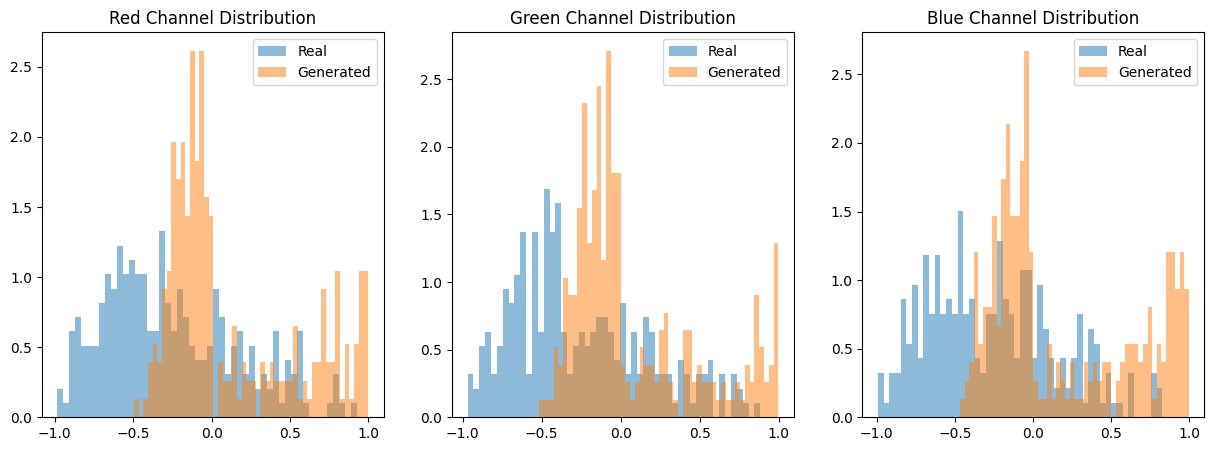

Real images - Mean: [-0.25052083 -0.25732237 -0.2569547 ] Std: [0.42641112 0.42401552 0.4101578 ]
Generated images - Mean: [0.13237609 0.08386102 0.19484259] Std: [0.41929576 0.4022674  0.45465994]


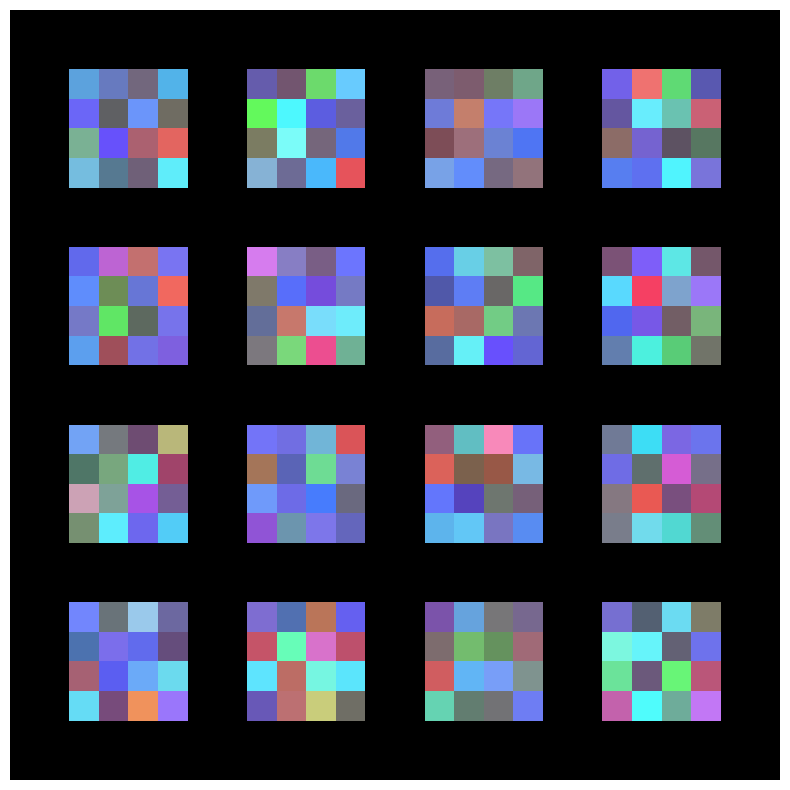

Layer 1: Loss_D: 0.3502969443798065, Loss_G: 0.1747663915157318
D Grad Norm : 0.6076, G Grad Norm: 0.5612
Epoch: 7 Outputting statistics: 


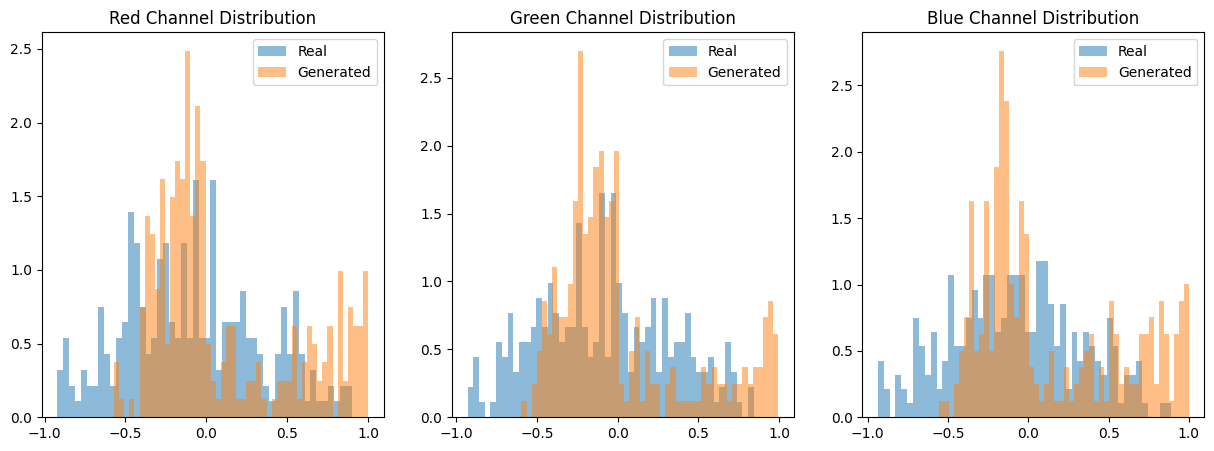

Real images - Mean: [-0.08330267 -0.08321077 -0.08020832] Std: [0.4174995  0.40887317 0.40022728]
Generated images - Mean: [0.10696665 0.02942514 0.1419911 ] Std: [0.43667737 0.41180554 0.44385666]


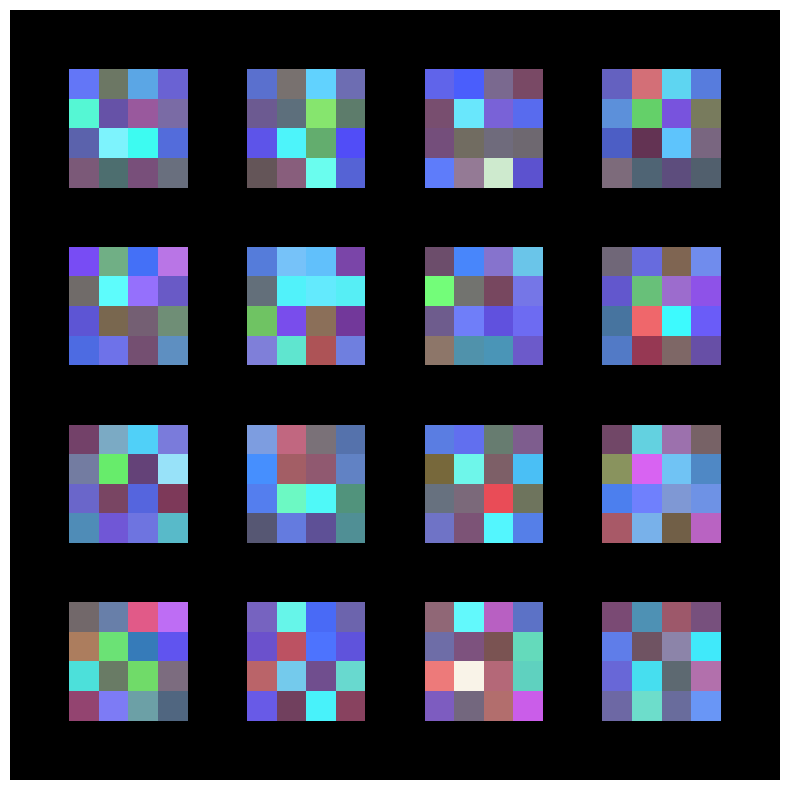

Layer 1: Loss_D: 0.4391022324562073, Loss_G: -0.20108768343925476
D Grad Norm : 0.5780, G Grad Norm: 0.2624
Epoch: 8 Outputting statistics: 


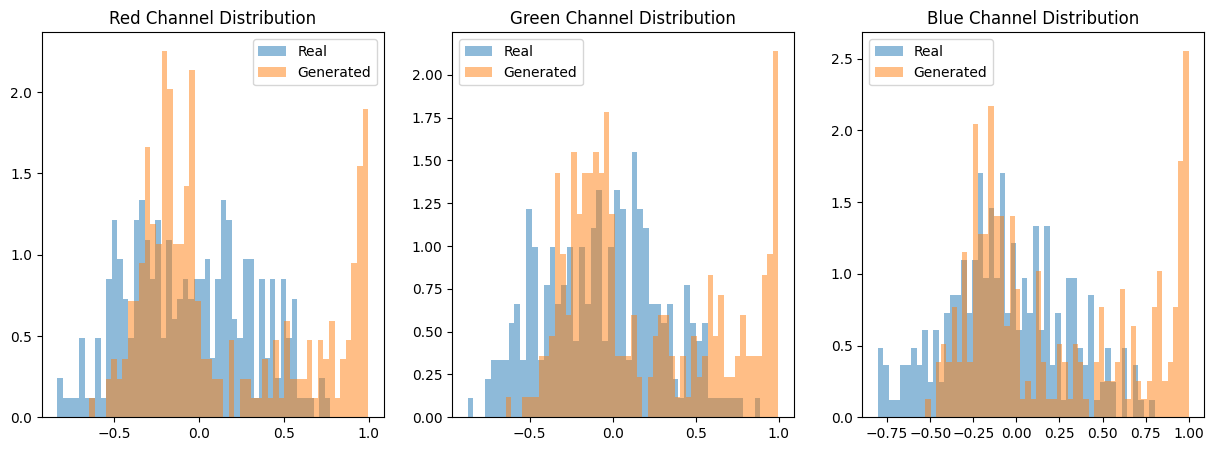

Real images - Mean: [-0.0547794  -0.06332719 -0.05977327] Std: [0.36116976 0.35522774 0.34305993]
Generated images - Mean: [0.13818738 0.18636371 0.22582763] Std: [0.4815885  0.4589458  0.47763175]


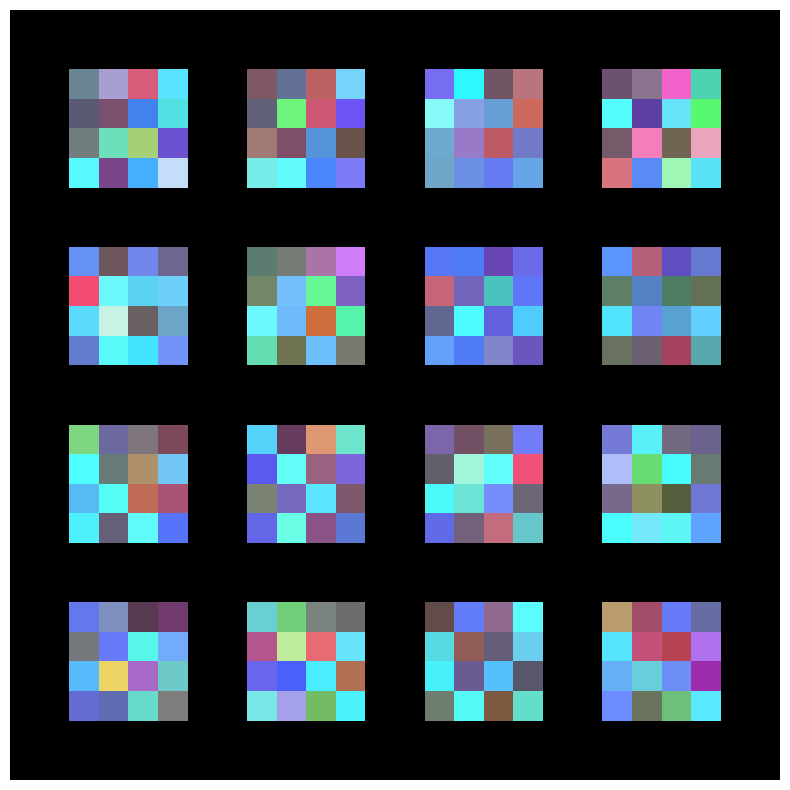

Layer 1: Loss_D: 1.4459575414657593, Loss_G: 0.11787598580121994
D Grad Norm : 0.7274, G Grad Norm: 0.4667
Epoch: 9 Outputting statistics: 


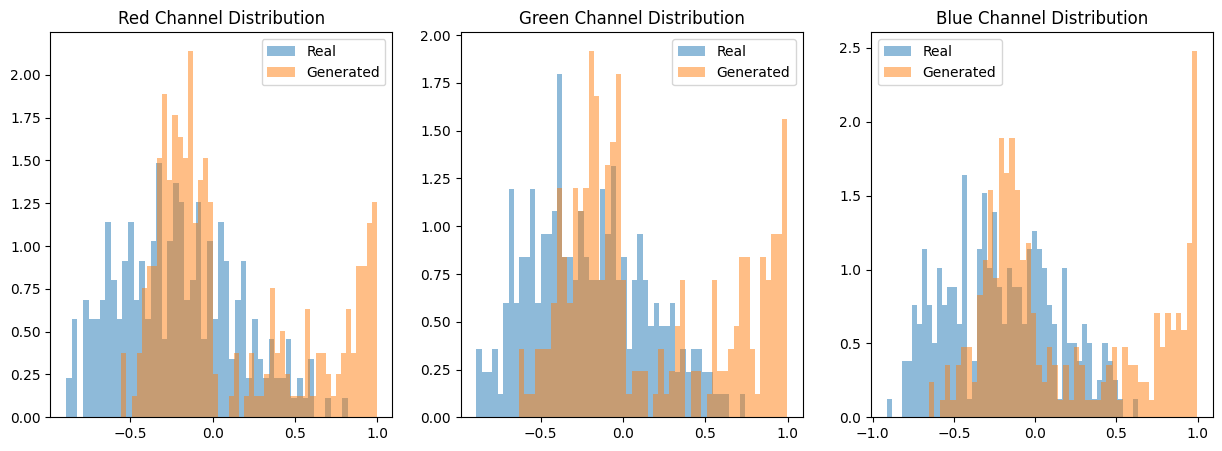

Real images - Mean: [-0.21011023 -0.20986521 -0.20732225] Std: [0.35959566 0.35246664 0.34034082]
Generated images - Mean: [0.1054112  0.14964923 0.17539974] Std: [0.46443054 0.48740157 0.49266633]


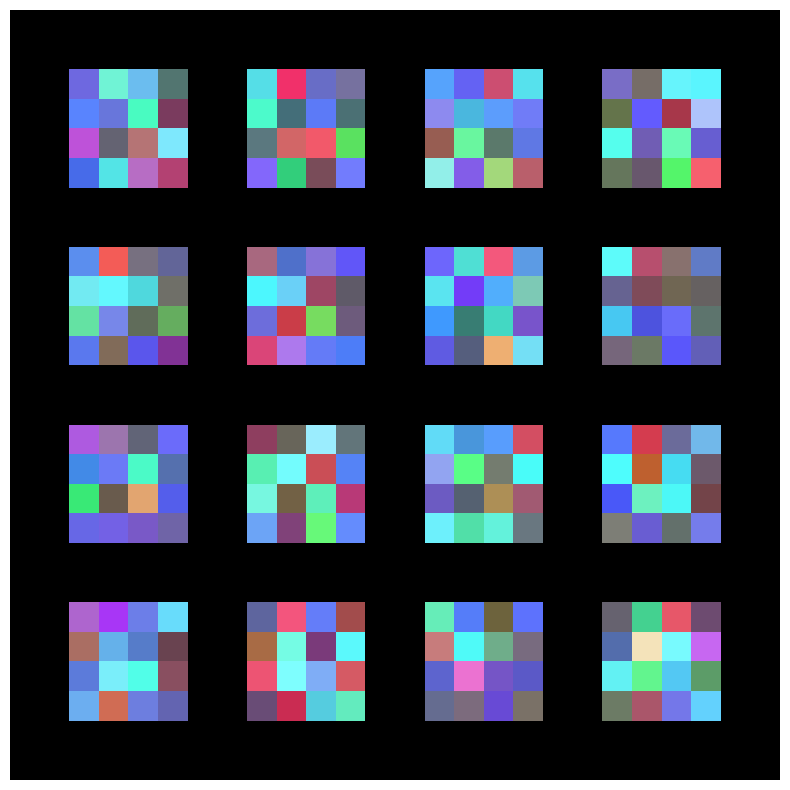

Layer 1: Loss_D: 1.073220133781433, Loss_G: 0.36139053106307983
D Grad Norm : 0.5529, G Grad Norm: 0.5217
Epoch: 10 Outputting statistics: 


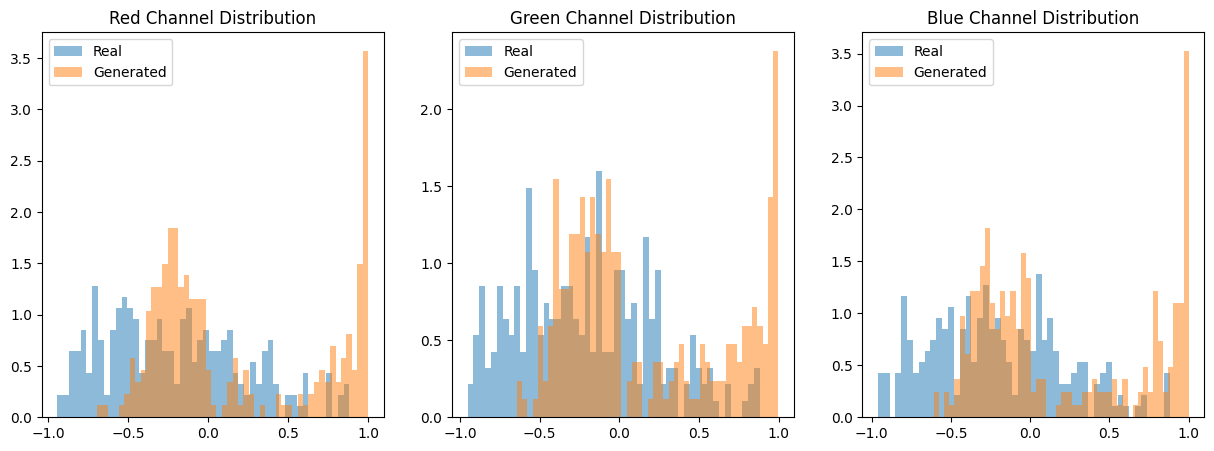

Real images - Mean: [-0.21200983 -0.20842527 -0.21176468] Std: [0.4320398 0.4233221 0.415981 ]
Generated images - Mean: [0.17570053 0.16215126 0.18976626] Std: [0.5278653  0.50398034 0.5223386 ]


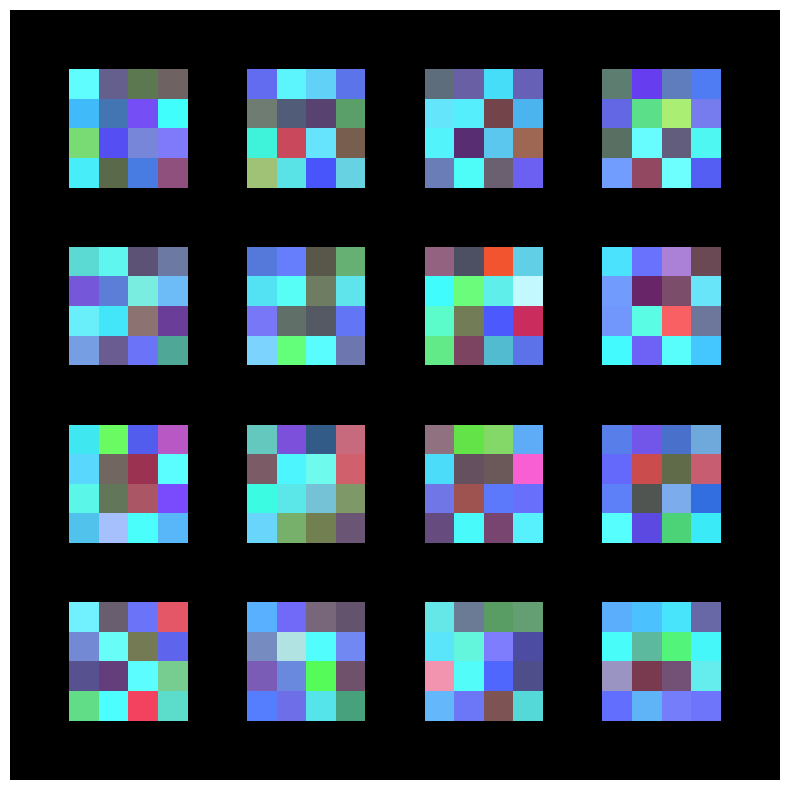

Layer 1: Loss_D: -0.6851480007171631, Loss_G: -0.4748963713645935
D Grad Norm : 0.4654, G Grad Norm: 0.3894
Epoch: 11 Outputting statistics: 


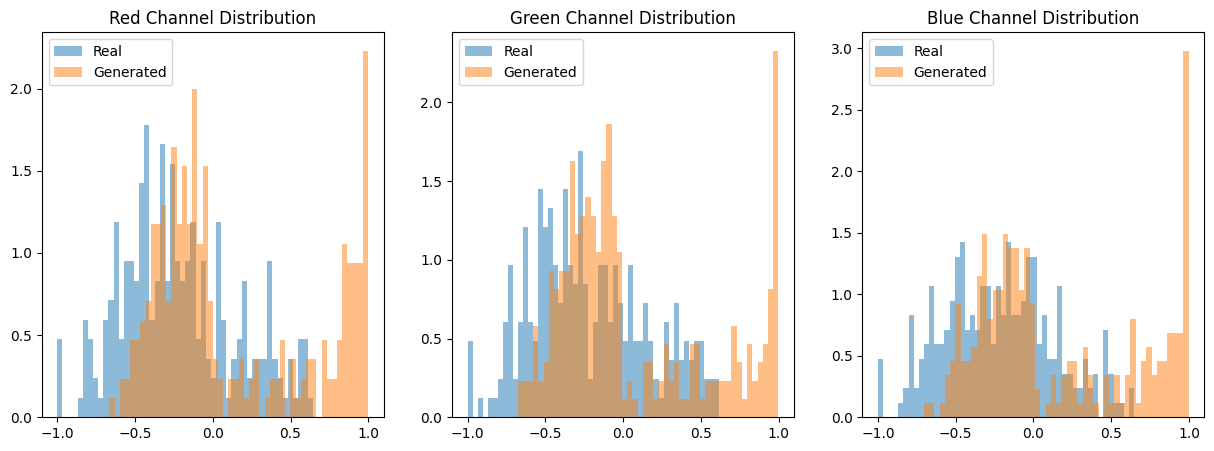

Real images - Mean: [-0.21896441 -0.21979168 -0.2193321 ] Std: [0.37083206 0.3730041  0.35363144]
Generated images - Mean: [0.13346356 0.06833578 0.15721278] Std: [0.5092324 0.4903059 0.5105871]


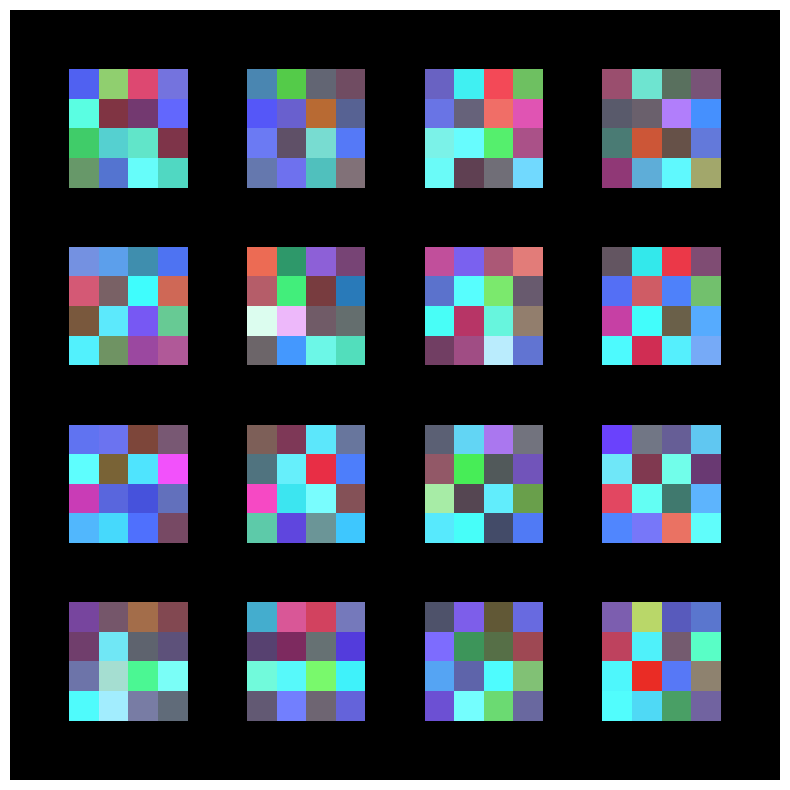

Layer 1: Loss_D: 0.5898428559303284, Loss_G: -0.17844396829605103
D Grad Norm : 0.5206, G Grad Norm: 0.3802
Epoch: 12 Outputting statistics: 


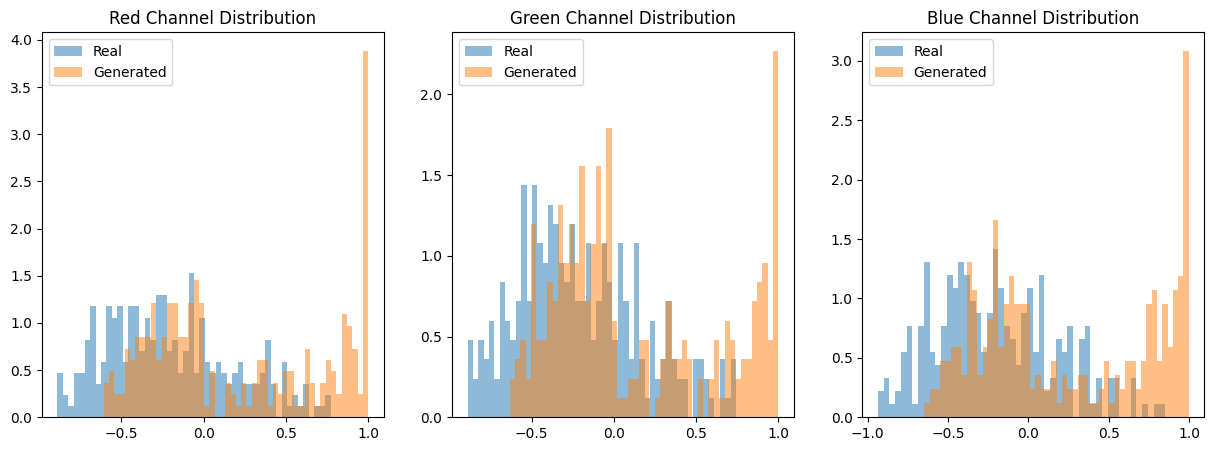

Real images - Mean: [-0.20410536 -0.20738357 -0.2057905 ] Std: [0.383728   0.37715548 0.37566537]
Generated images - Mean: [0.21001045 0.12975043 0.24212897] Std: [0.52017474 0.50008553 0.5279054 ]


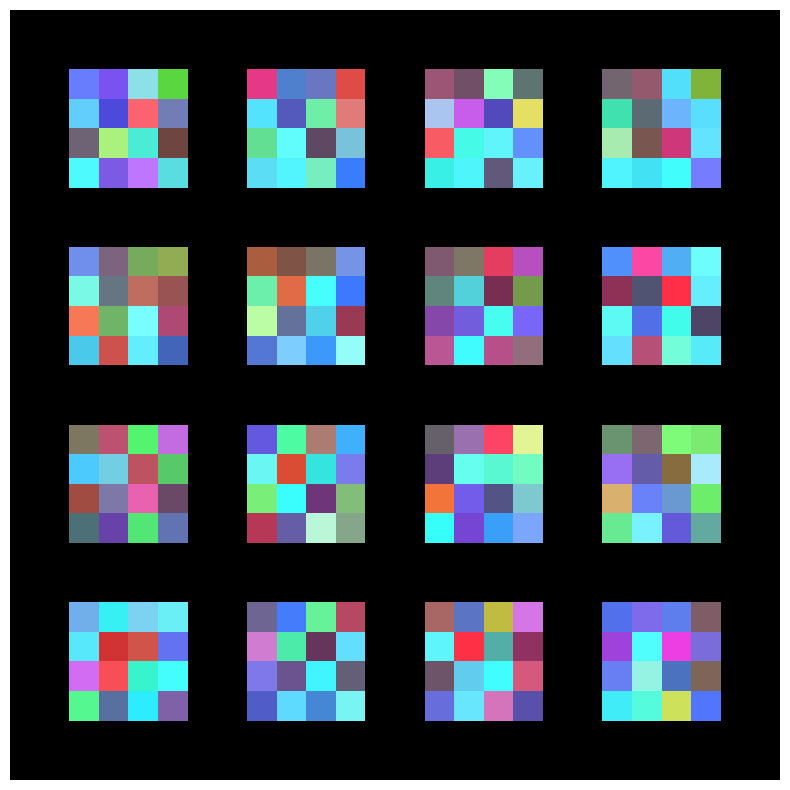

Layer 1: Loss_D: -0.6946821212768555, Loss_G: 0.07069546729326248
D Grad Norm : 0.5510, G Grad Norm: 0.4033
Epoch: 13 Outputting statistics: 


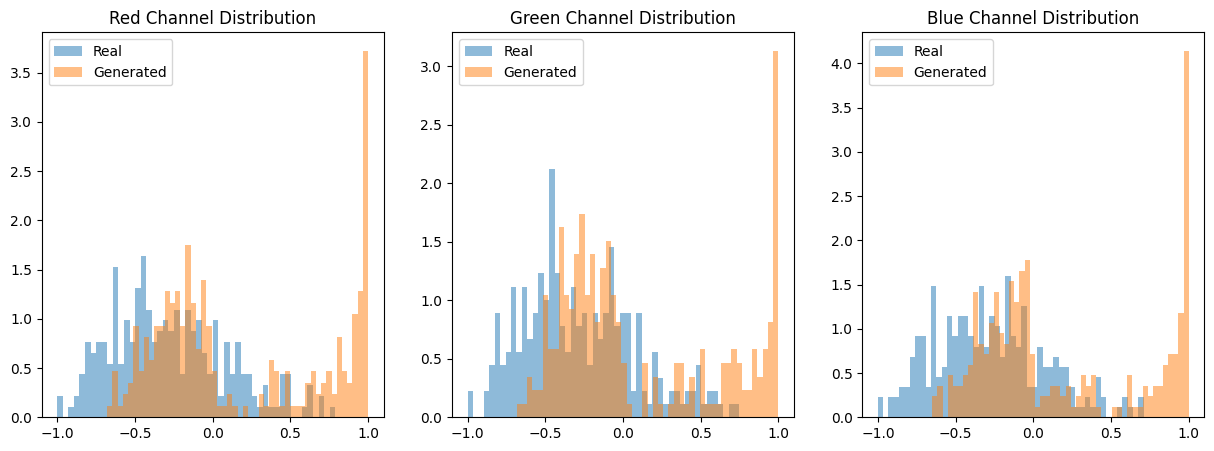

Real images - Mean: [-0.27411157 -0.27904406 -0.27702215] Std: [0.37160596 0.3654084  0.35276744]
Generated images - Mean: [0.1810794  0.11058922 0.1828704 ] Std: [0.5473127  0.52449936 0.5272404 ]


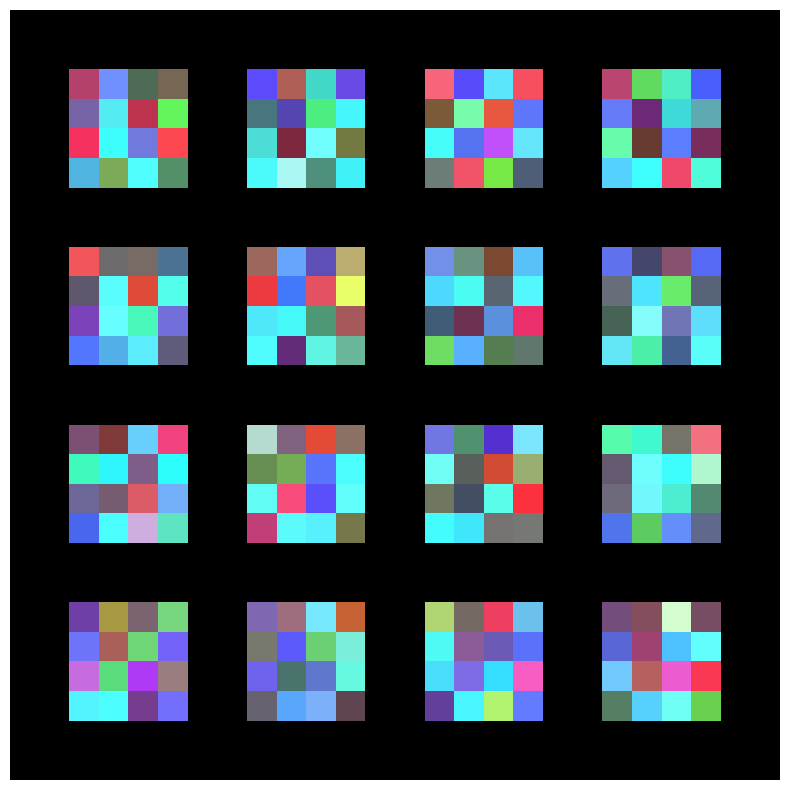

Layer 1: Loss_D: -0.5266068577766418, Loss_G: 0.39410829544067383
D Grad Norm : 0.6932, G Grad Norm: 0.2927
Epoch: 14 Outputting statistics: 


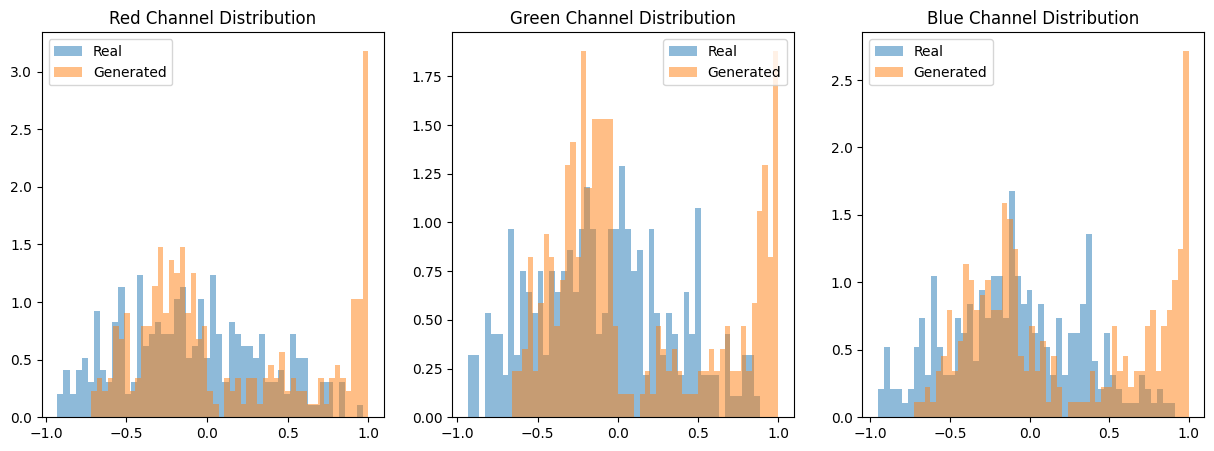

Real images - Mean: [-0.09889702 -0.09466909 -0.09420953] Std: [0.43242317 0.4248795  0.41405755]
Generated images - Mean: [0.11761886 0.11166237 0.18979171] Std: [0.537105   0.51286656 0.5395854 ]


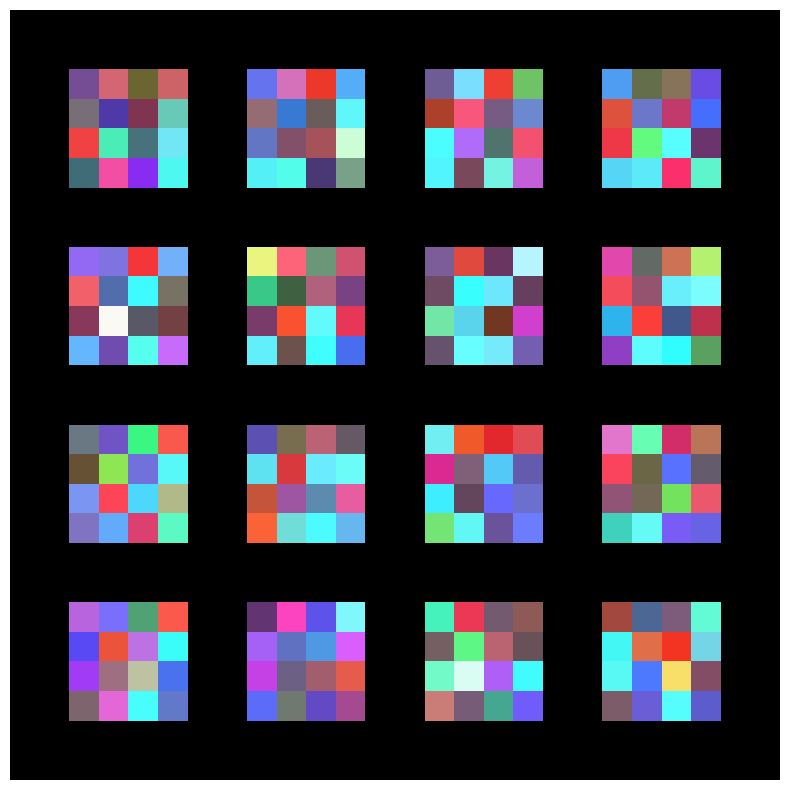

Layer 1: Loss_D: -0.1104336529970169, Loss_G: 0.5305366516113281
D Grad Norm : 0.4463, G Grad Norm: 0.7200
Epoch: 15 Outputting statistics: 


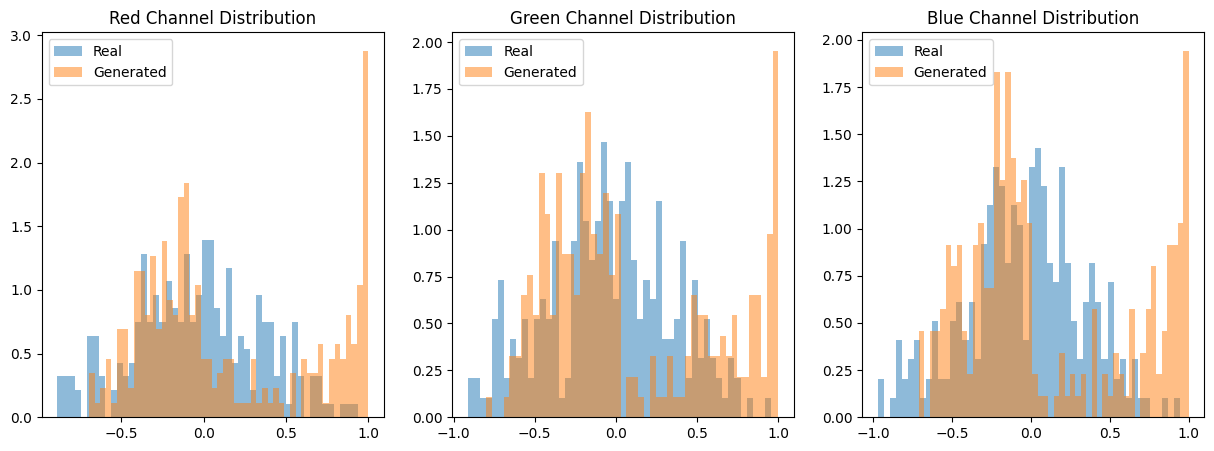

Real images - Mean: [-0.0429534  -0.04231004 -0.04675243] Std: [0.38765246 0.3872084  0.36936972]
Generated images - Mean: [0.1333327  0.08602928 0.09982517] Std: [0.52518505 0.51740986 0.52685577]


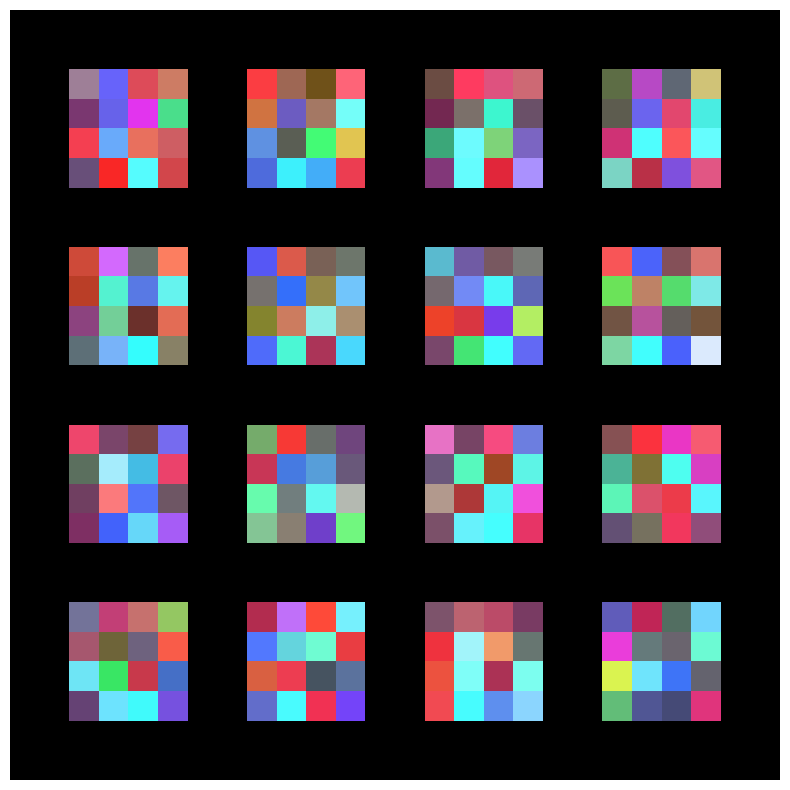

Layer 1: Loss_D: 0.2214556634426117, Loss_G: 1.081345796585083
D Grad Norm : 0.5911, G Grad Norm: 0.4115
Epoch: 16 Outputting statistics: 


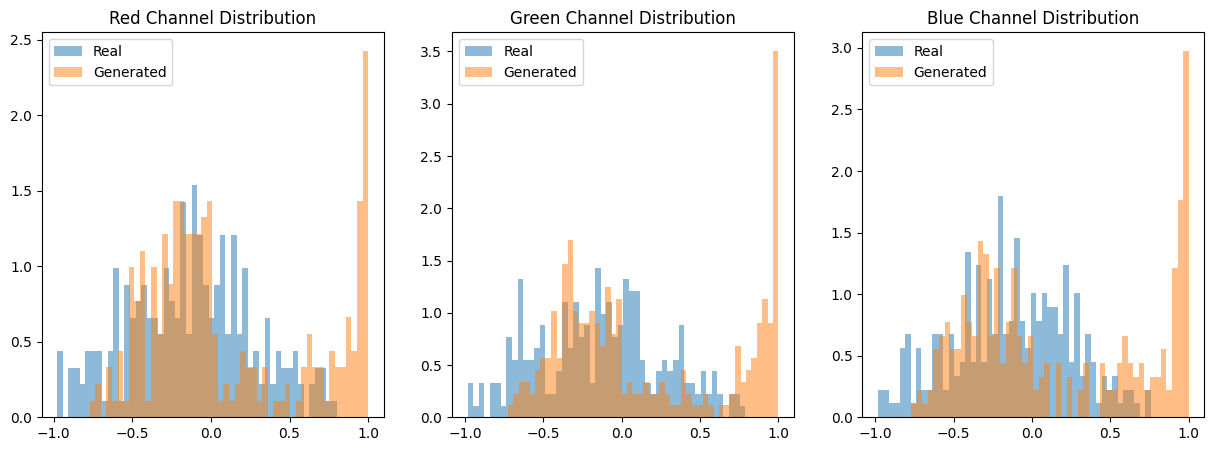

Real images - Mean: [-0.1302389  -0.14117642 -0.13278185] Std: [0.39602628 0.3993453  0.37656707]
Generated images - Mean: [0.10807993 0.15292832 0.15990011] Std: [0.51761186 0.55429304 0.5692408 ]


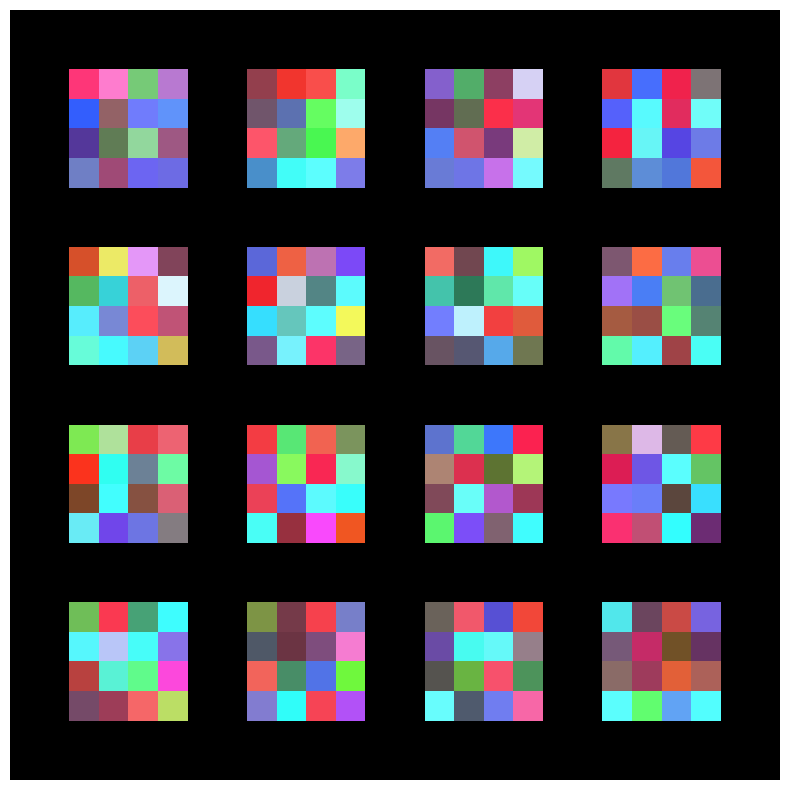

Layer 1: Loss_D: 0.06045113503932953, Loss_G: -1.471524953842163
D Grad Norm : 0.6072, G Grad Norm: 0.4860
Epoch: 17 Outputting statistics: 


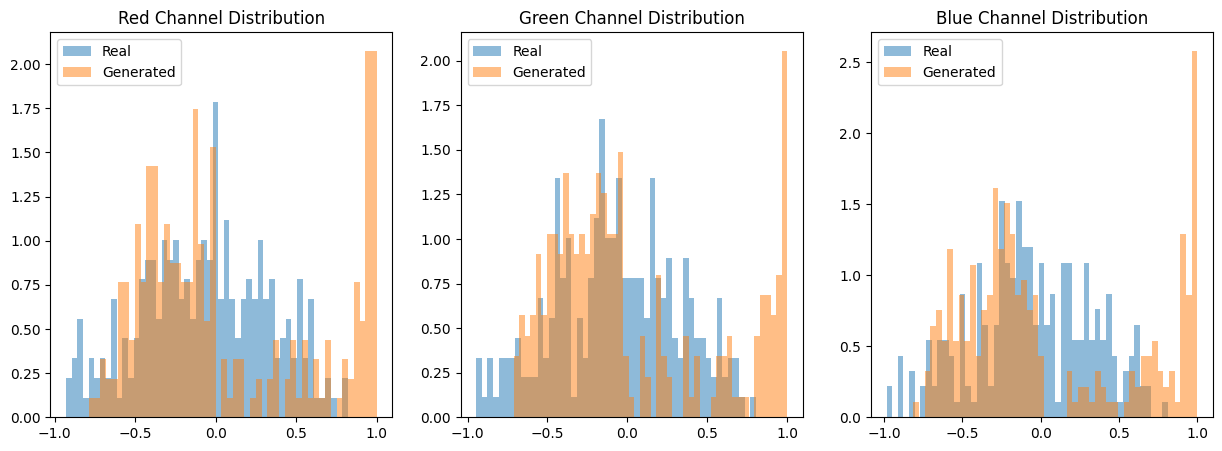

Real images - Mean: [-0.06571691 -0.06841295 -0.0625306 ] Std: [0.3966935  0.38827193 0.3843919 ]
Generated images - Mean: [0.07060786 0.02024101 0.04053594] Std: [0.5484884  0.52091646 0.5650998 ]


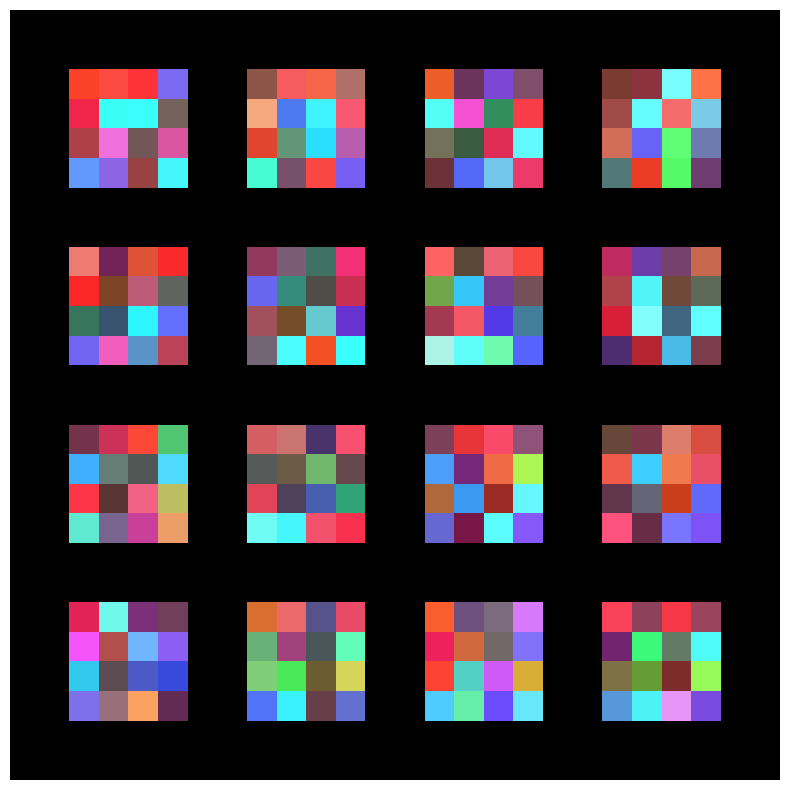

Layer 1: Loss_D: -0.21120040118694305, Loss_G: 0.5099959373474121
D Grad Norm : 0.6012, G Grad Norm: 0.3567
Epoch: 18 Outputting statistics: 


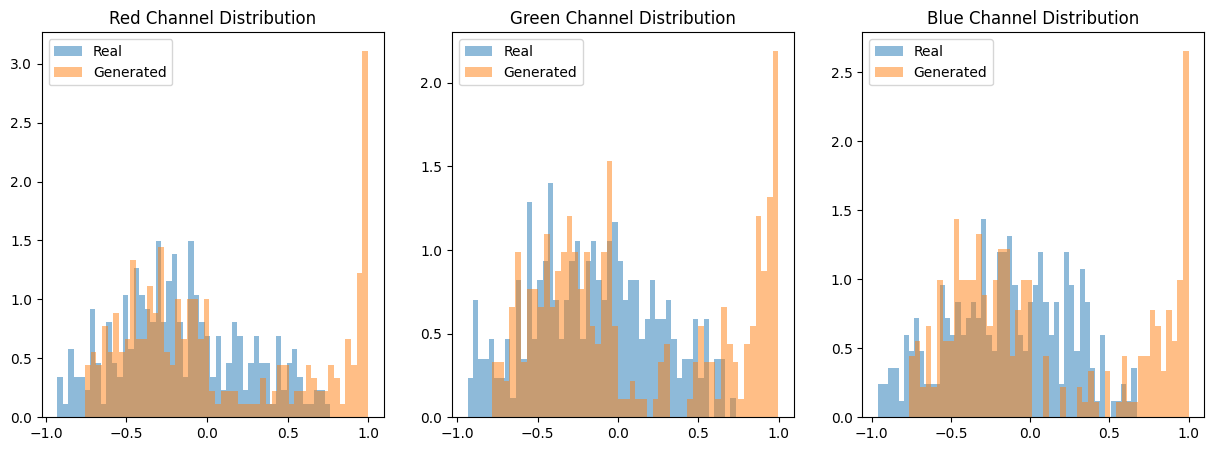

Real images - Mean: [-0.15903805 -0.15294114 -0.14669111] Std: [0.39369613 0.392174   0.3783938 ]
Generated images - Mean: [0.07158149 0.09409905 0.06017881] Std: [0.57265264 0.5793801  0.5707995 ]


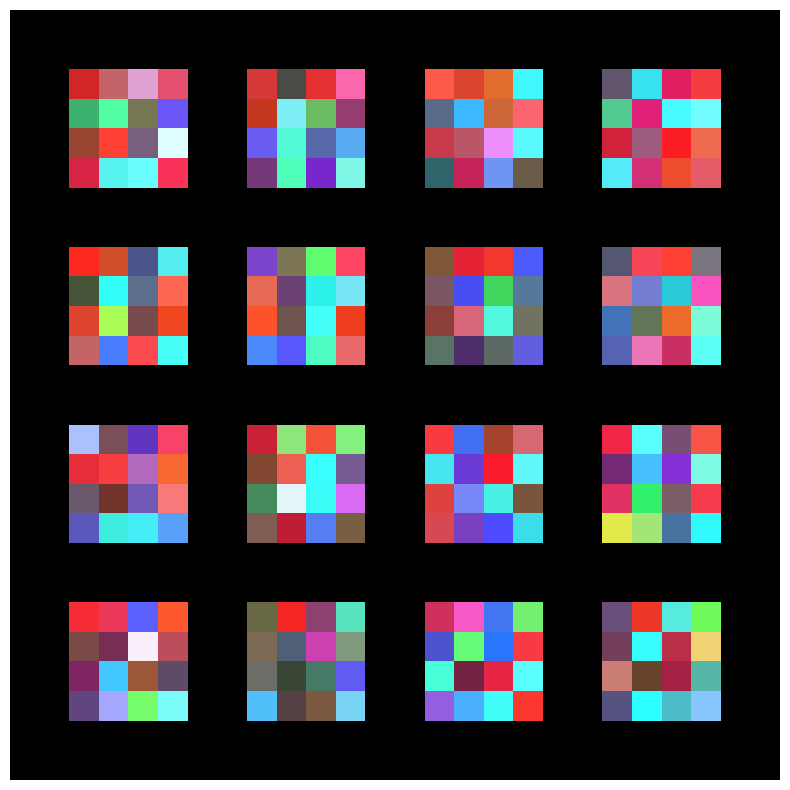

Layer 1: Loss_D: -0.3009437024593353, Loss_G: -1.9666364192962646
D Grad Norm : 0.6863, G Grad Norm: 0.4323
Epoch: 19 Outputting statistics: 


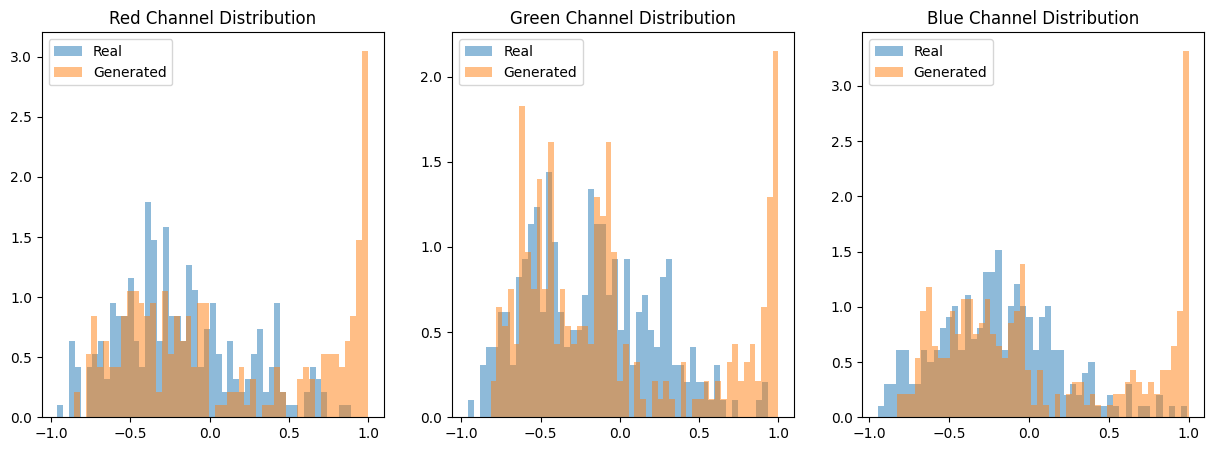

Real images - Mean: [-0.18523277 -0.1867342  -0.19298406] Std: [0.39463145 0.3938641  0.37266454]
Generated images - Mean: [ 0.0960938  -0.03402836  0.05061517] Std: [0.61092734 0.5755265  0.58722234]


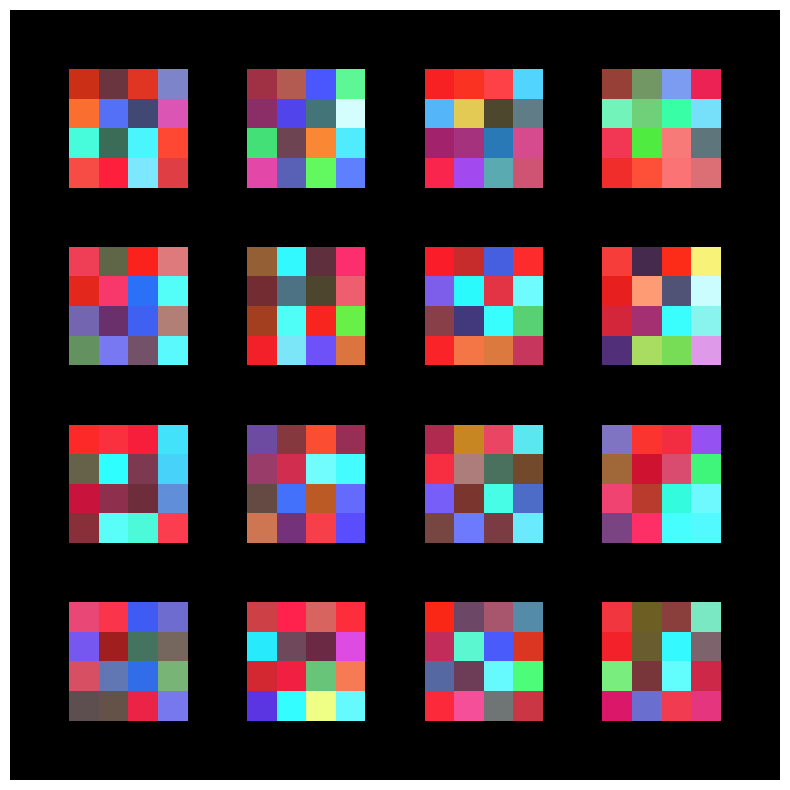

Layer 1: Loss_D: -0.37589818239212036, Loss_G: -0.2787168622016907
D Grad Norm : 0.6771, G Grad Norm: 0.3884
Epoch: 20 Outputting statistics: 


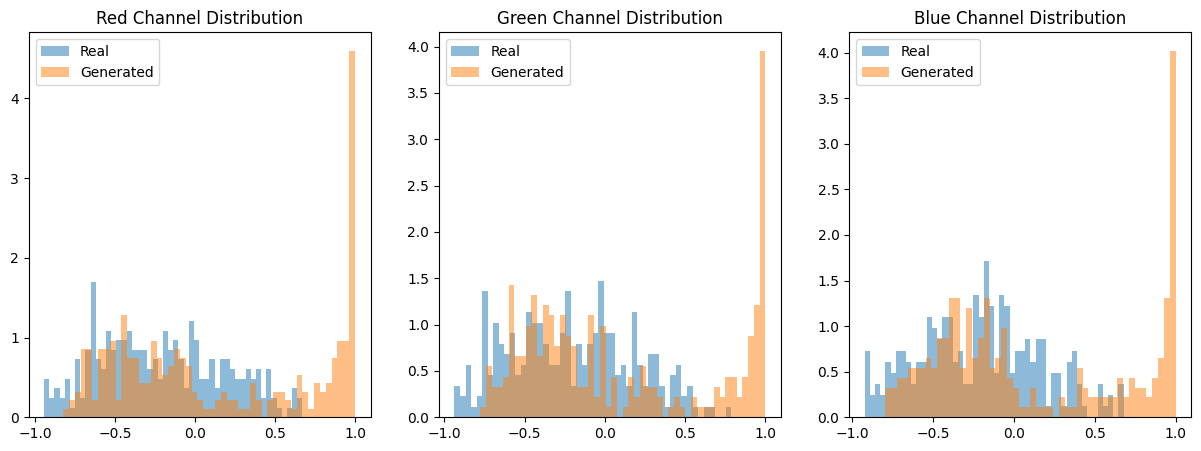

Real images - Mean: [-0.21102938 -0.21004897 -0.21225496] Std: [0.3879034 0.3853758 0.3688142]
Generated images - Mean: [0.15178148 0.0954441  0.11510933] Std: [0.62264097 0.59438485 0.59490055]


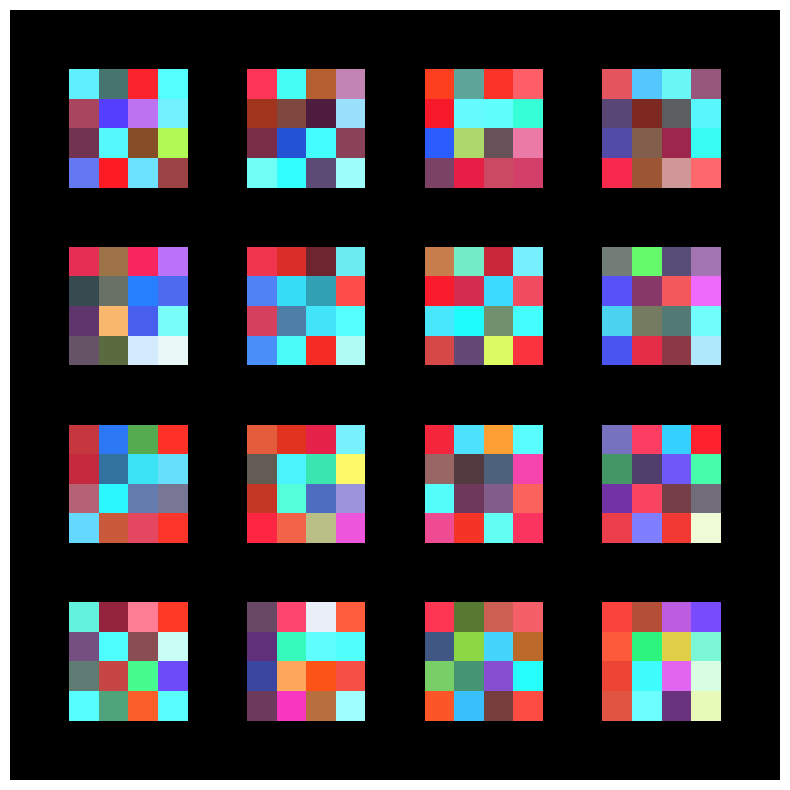

Layer 1: Loss_D: -0.13871021568775177, Loss_G: 0.1242392510175705
D Grad Norm : 0.7081, G Grad Norm: 0.3582
Epoch: 21 Outputting statistics: 


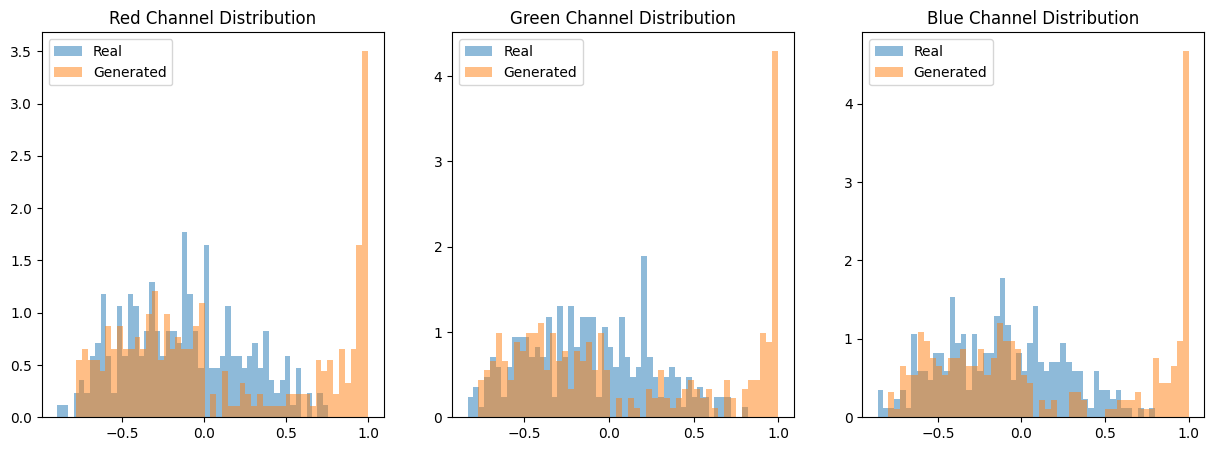

Real images - Mean: [-0.12837014 -0.12178303 -0.11893378] Std: [0.36528647 0.36329955 0.35262695]
Generated images - Mean: [0.10592688 0.10119391 0.11085651] Std: [0.60408276 0.6081654  0.60910654]


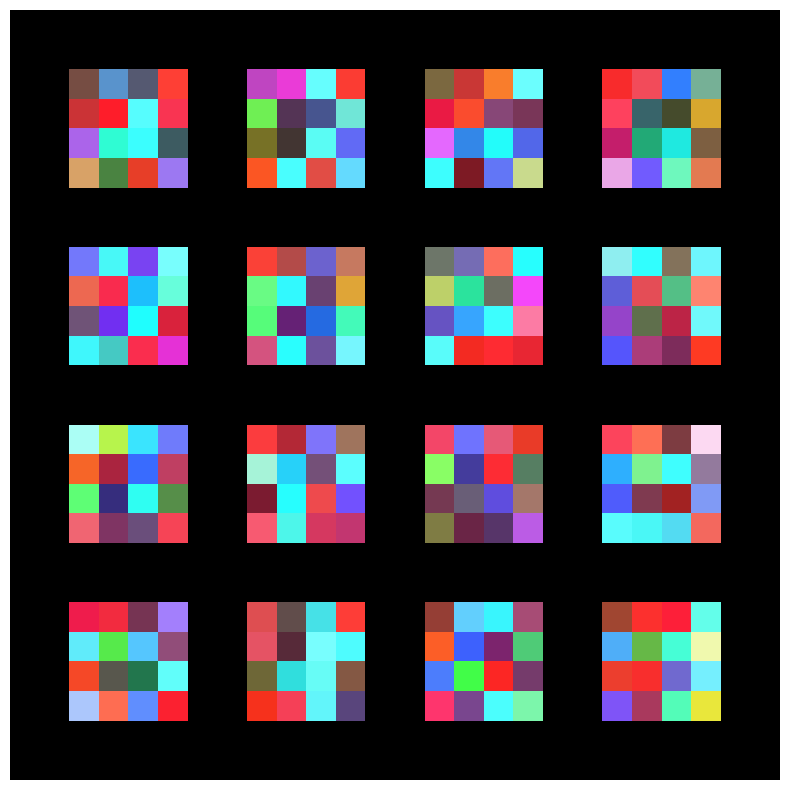

Layer 1: Loss_D: 0.9801822900772095, Loss_G: -0.7964833974838257
D Grad Norm : 0.6590, G Grad Norm: 0.2953
Epoch: 22 Outputting statistics: 


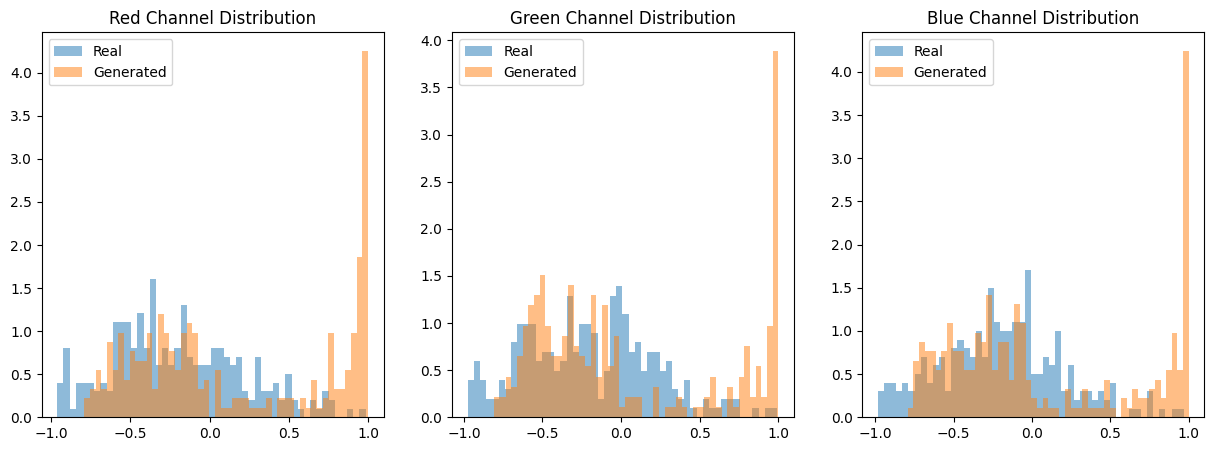

Real images - Mean: [-0.20214456 -0.19917281 -0.19972426] Std: [0.41270813 0.4061813  0.3902407 ]
Generated images - Mean: [0.16514876 0.03644765 0.06988657] Std: [0.61794937 0.6018987  0.6076528 ]


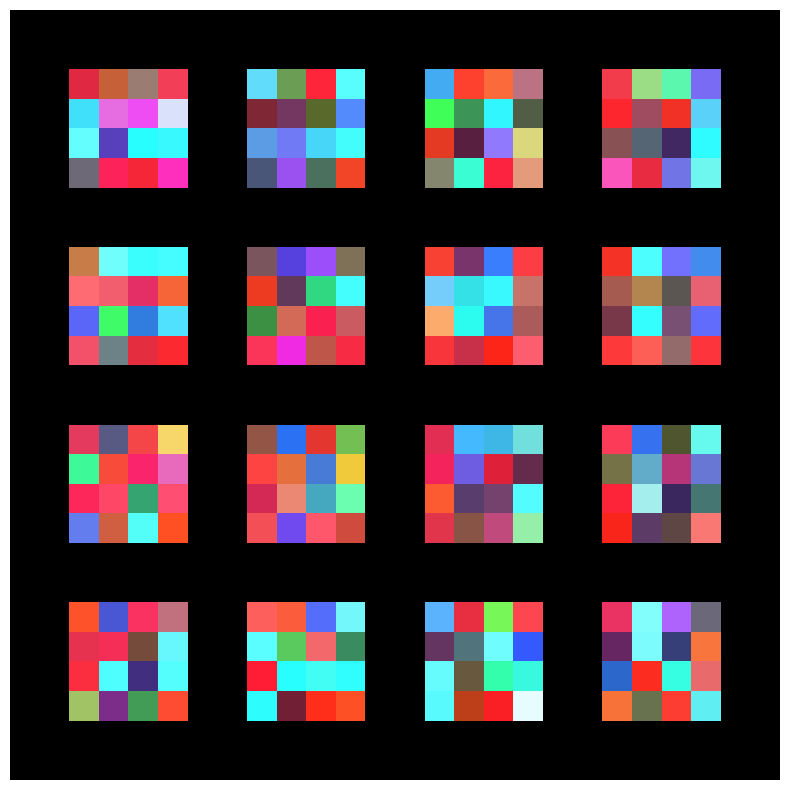

Layer 1: Loss_D: 1.5845528841018677, Loss_G: -0.5867596864700317
D Grad Norm : 0.4454, G Grad Norm: 0.3639
Epoch: 23 Outputting statistics: 


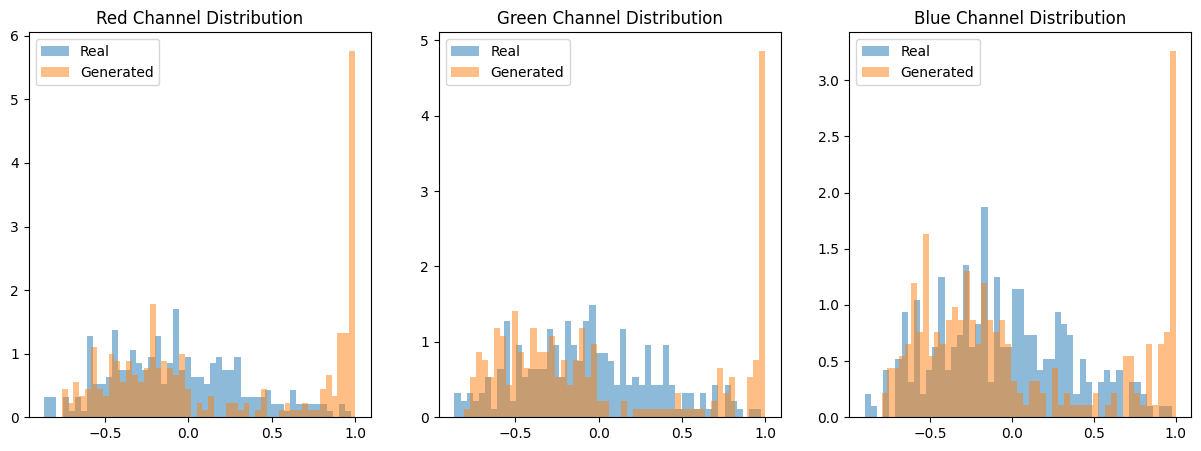

Real images - Mean: [-0.07426467 -0.06868869 -0.06372549] Std: [0.39469516 0.39994562 0.40274554]
Generated images - Mean: [0.19246295 0.03803718 0.01795121] Std: [0.619697   0.6210593  0.57624716]


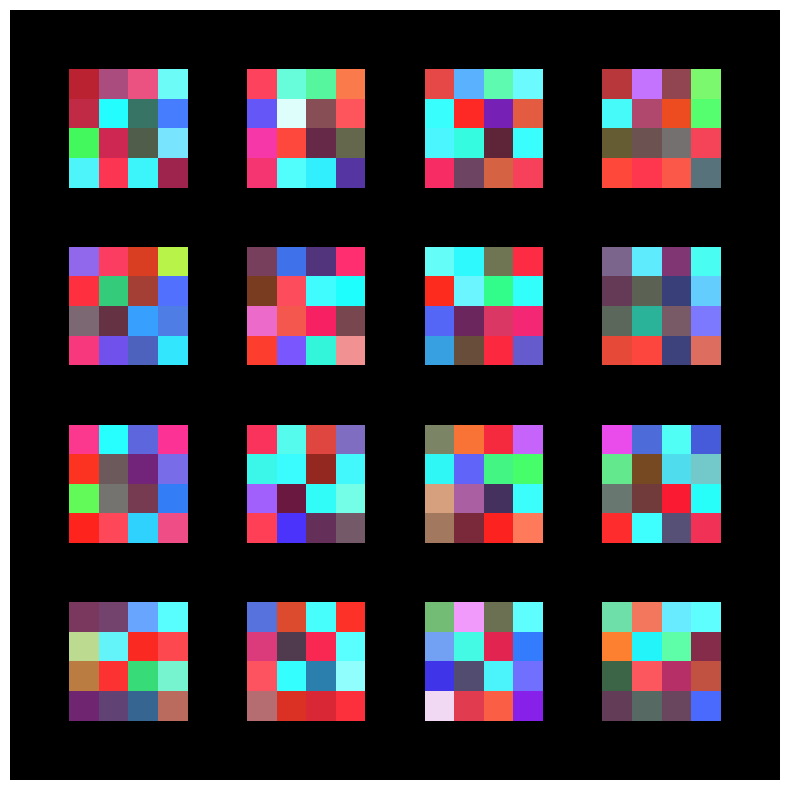

Layer 1: Loss_D: -0.049029894173145294, Loss_G: 1.0353527069091797
D Grad Norm : 0.4429, G Grad Norm: 0.3236
Epoch: 24 Outputting statistics: 


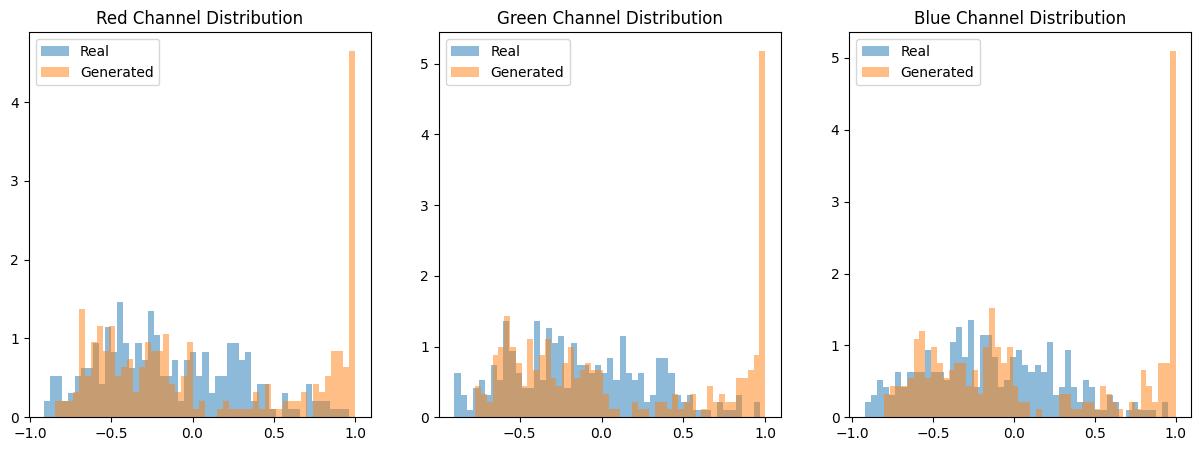

Real images - Mean: [-0.14757963 -0.14010403 -0.1420036 ] Std: [0.4265082  0.41461295 0.4084228 ]
Generated images - Mean: [0.09949376 0.11665213 0.11469755] Std: [0.6374514  0.6257341  0.61525387]


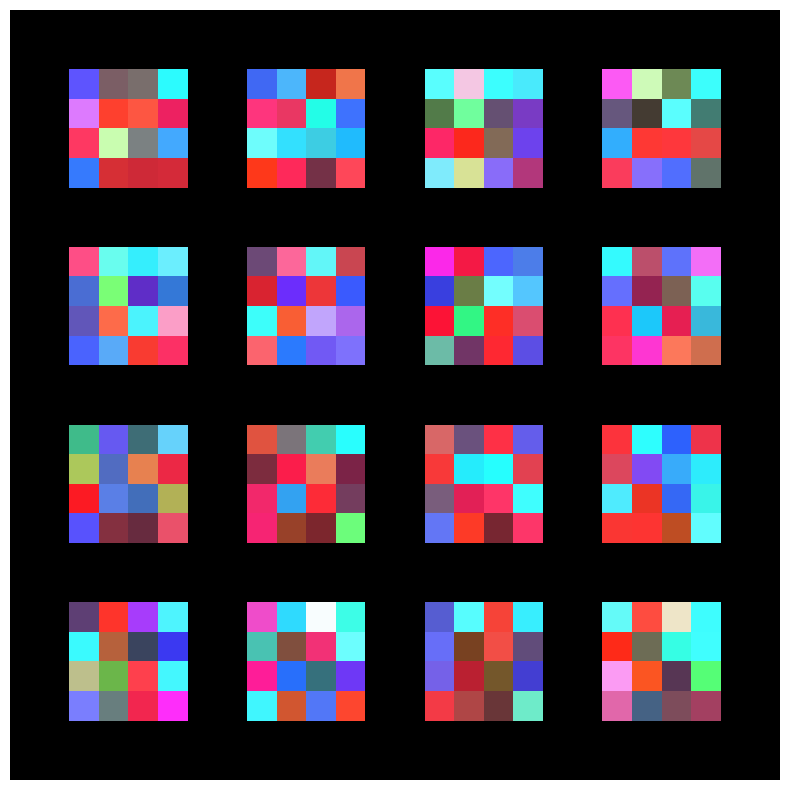

Layer 1: Loss_D: 1.2564473152160645, Loss_G: -1.8593509197235107
D Grad Norm : 0.4769, G Grad Norm: 0.5434
Epoch: 25 Outputting statistics: 


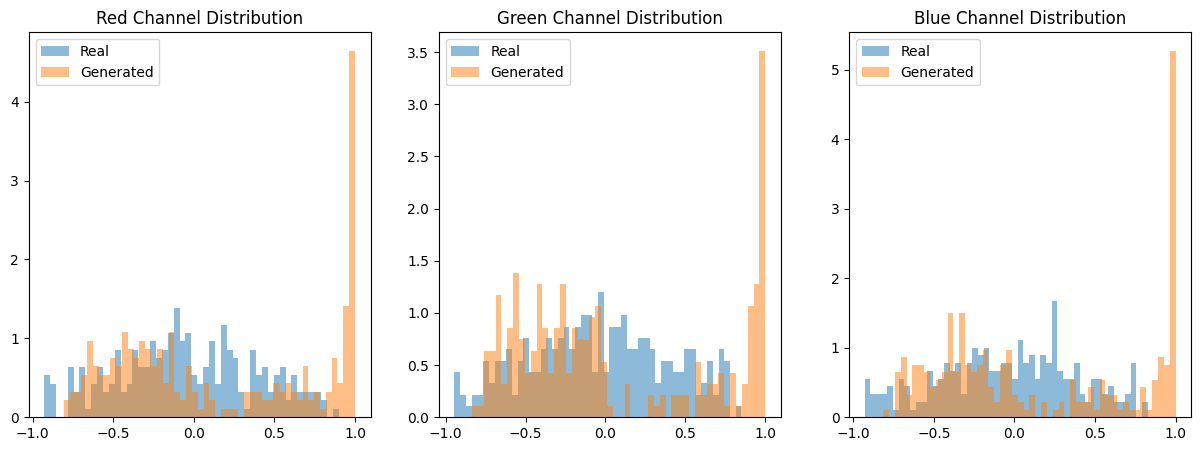

Real images - Mean: [-0.04708942 -0.04574142 -0.04258576] Std: [0.42862317 0.43570644 0.42570767]
Generated images - Mean: [0.15550897 0.06353611 0.1427907 ] Std: [0.61915284 0.61324364 0.61398727]


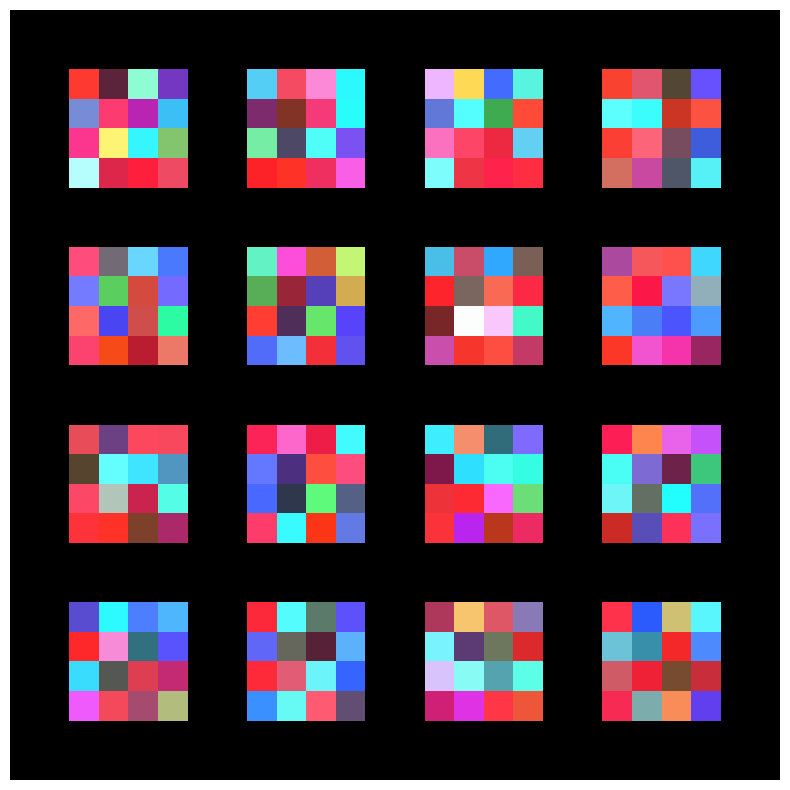

Layer 1: Loss_D: 1.2198537588119507, Loss_G: 0.2819213271141052
D Grad Norm : 0.4923, G Grad Norm: 0.4674
Epoch: 26 Outputting statistics: 


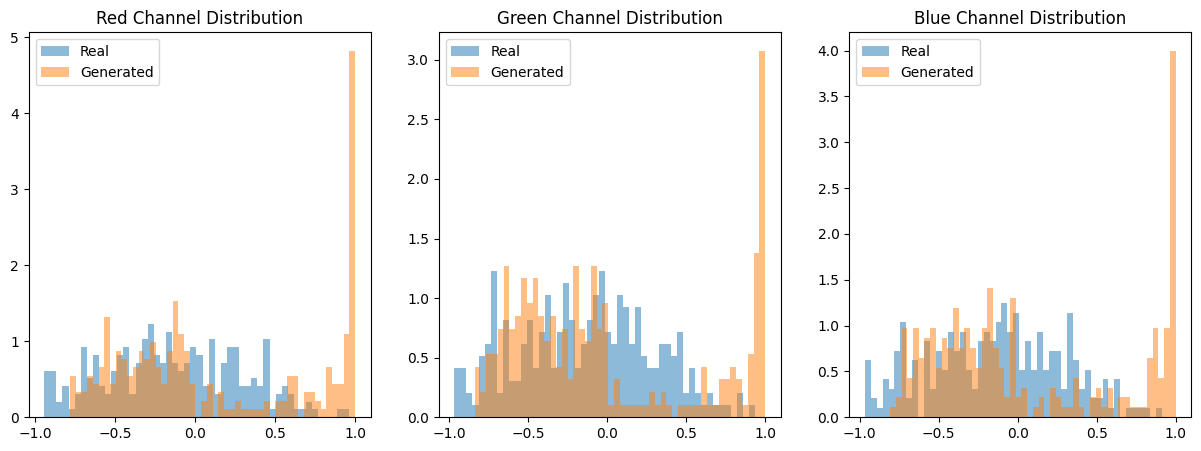

Real images - Mean: [-0.13958329 -0.14016537 -0.14142153] Std: [0.4210974  0.4242062  0.41885754]
Generated images - Mean: [ 0.1291966  -0.00415919  0.06667936] Std: [0.6042269  0.60178703 0.60569555]


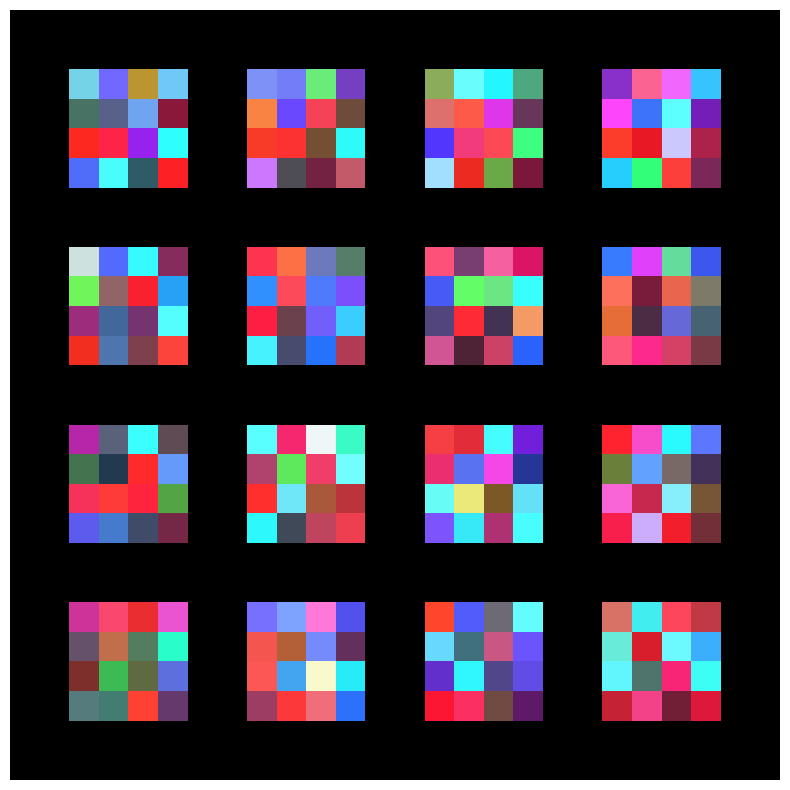

Layer 1: Loss_D: 1.8006309270858765, Loss_G: 0.832145094871521
D Grad Norm : 0.7810, G Grad Norm: 0.2616
Epoch: 27 Outputting statistics: 


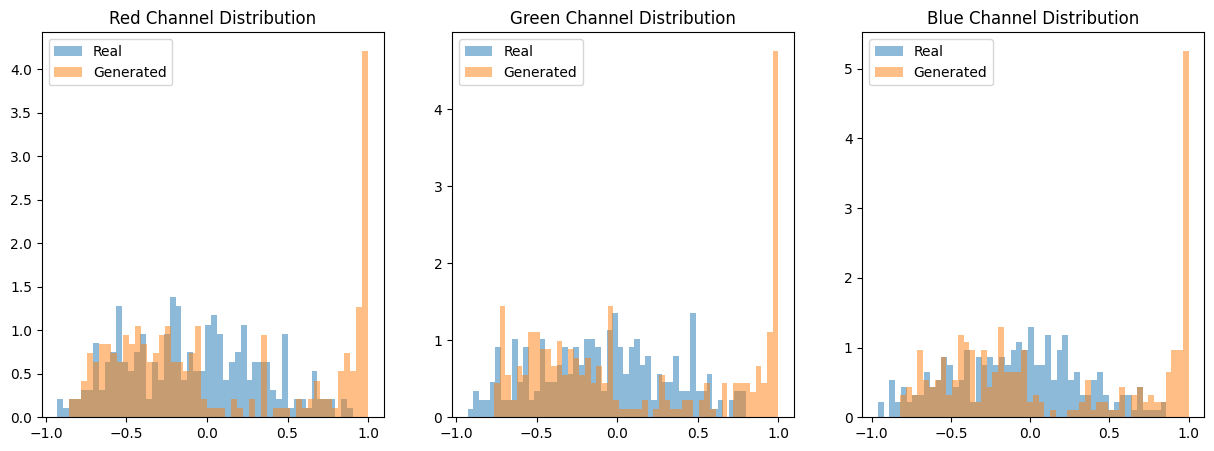

Real images - Mean: [-0.09129903 -0.0892156  -0.09246323] Std: [0.4148441  0.41356805 0.40303797]
Generated images - Mean: [0.07444351 0.11004521 0.14834835] Std: [0.6319609  0.6246603  0.63236904]


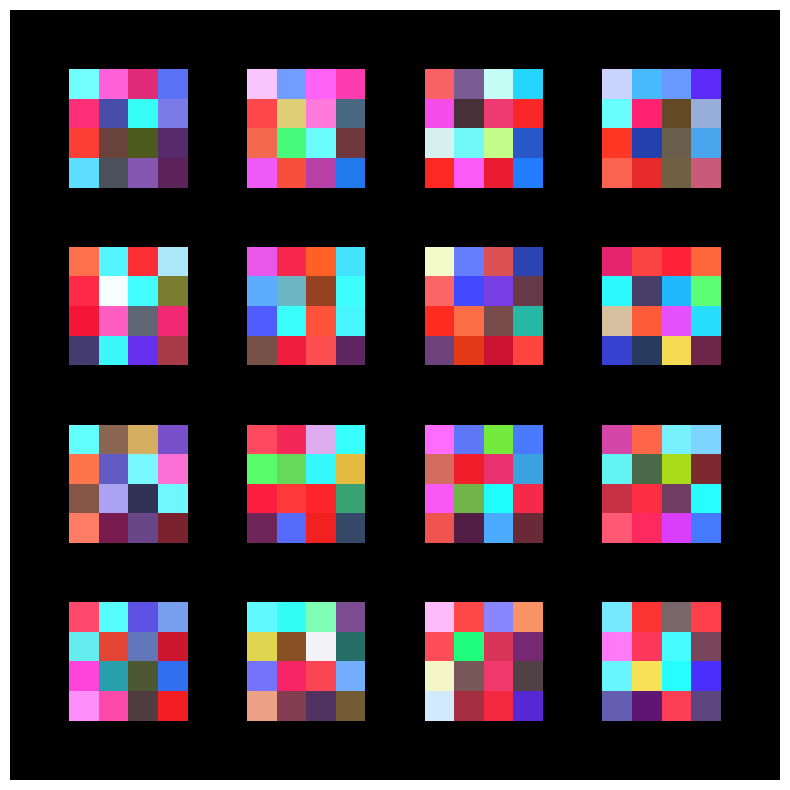

Layer 1: Loss_D: -0.05493869259953499, Loss_G: 0.4696645736694336
D Grad Norm : 0.5345, G Grad Norm: 0.3488
Epoch: 28 Outputting statistics: 


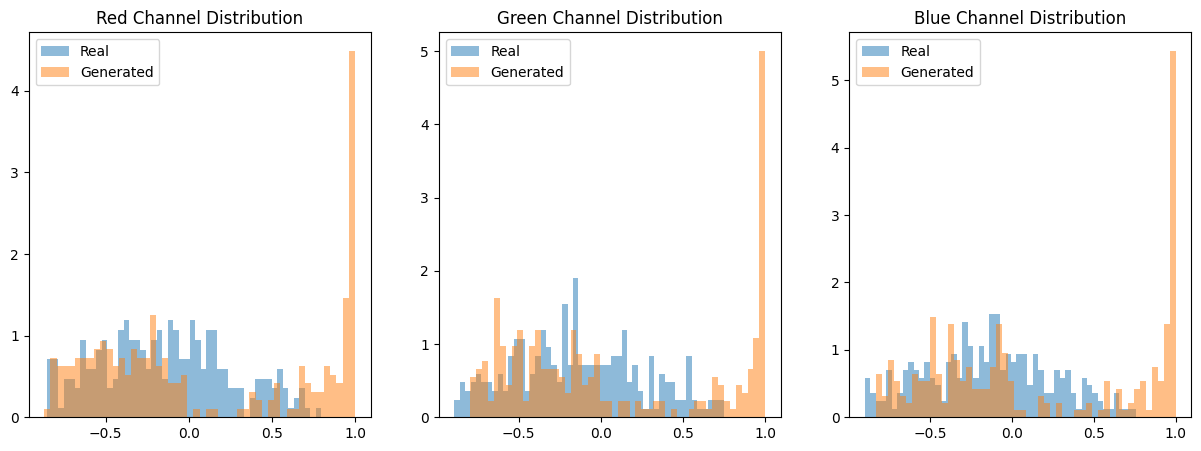

Real images - Mean: [-0.1418811  -0.14212626 -0.14258575] Std: [0.38956994 0.3887444  0.37780795]
Generated images - Mean: [0.08968846 0.08013347 0.14985313] Std: [0.6607059  0.63980114 0.6469736 ]


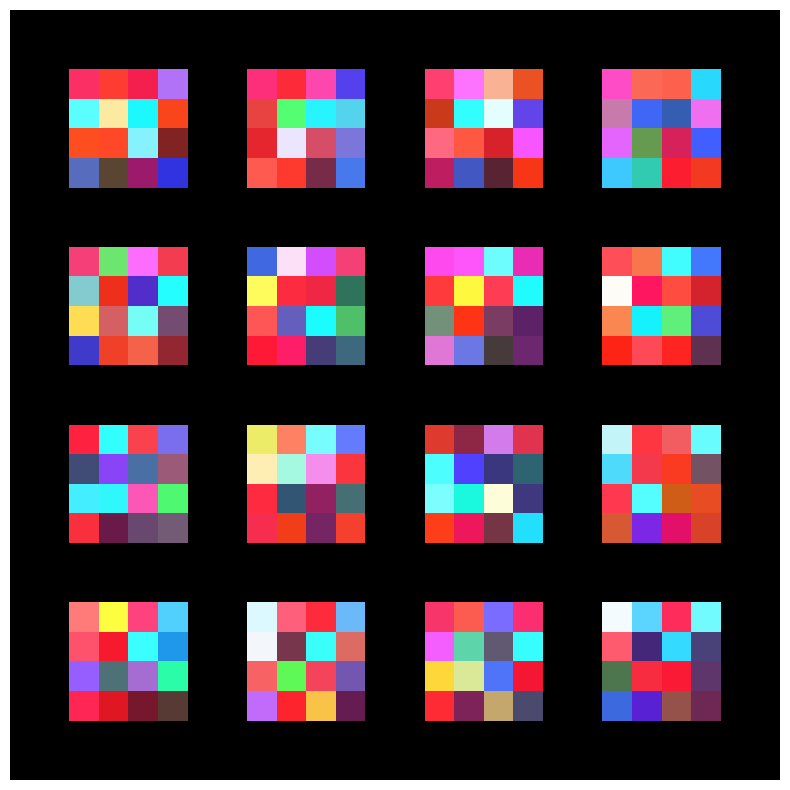

Layer 1: Loss_D: 3.5357229709625244, Loss_G: 1.6960862874984741
D Grad Norm : 0.7238, G Grad Norm: 0.2933
Epoch: 29 Outputting statistics: 


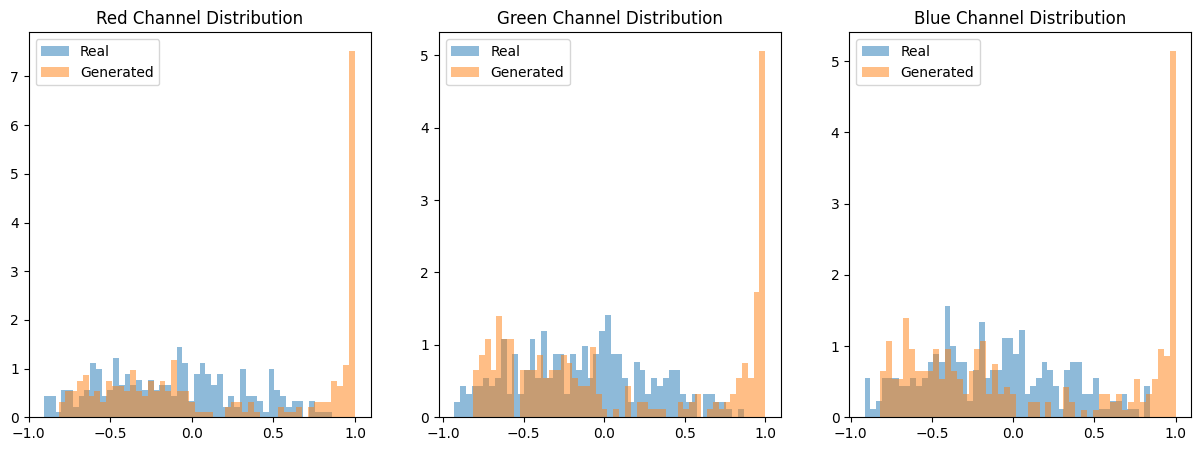

Real images - Mean: [-0.11948527 -0.13238356 -0.12974875] Std: [0.42378065 0.4149145  0.4127383 ]
Generated images - Mean: [0.22142953 0.09541273 0.0898428 ] Std: [0.66292745 0.6744845  0.66557235]


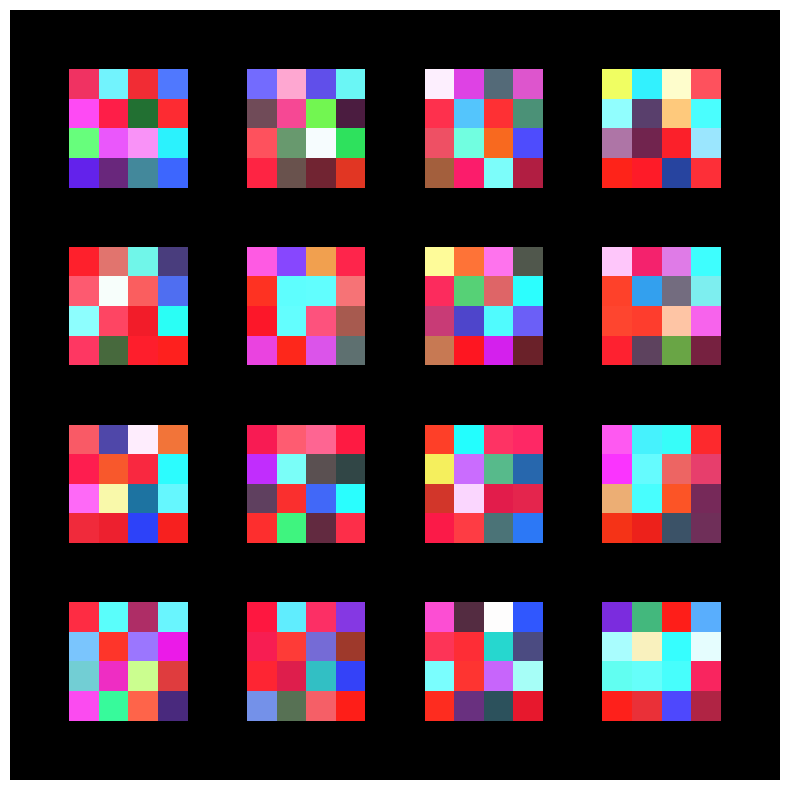

Layer 1: Loss_D: 0.07964300364255905, Loss_G: -1.1962696313858032
D Grad Norm : 0.6045, G Grad Norm: 0.4228
Epoch: 30 Outputting statistics: 


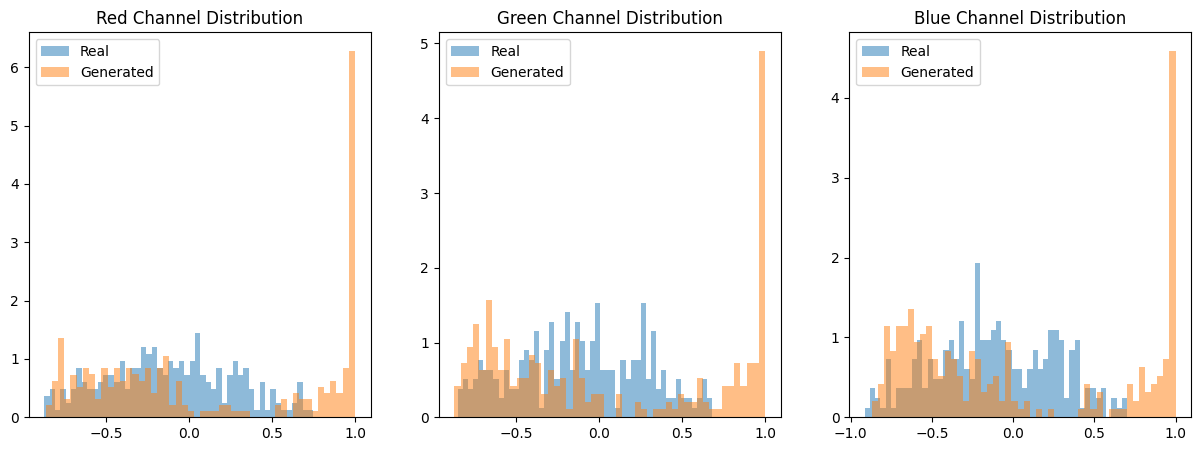

Real images - Mean: [-0.11853549 -0.11881126 -0.11681983] Std: [0.3804069  0.3780795  0.36835924]
Generated images - Mean: [ 0.12752968  0.05442302 -0.00643414] Std: [0.6814278 0.6908643 0.6731148]


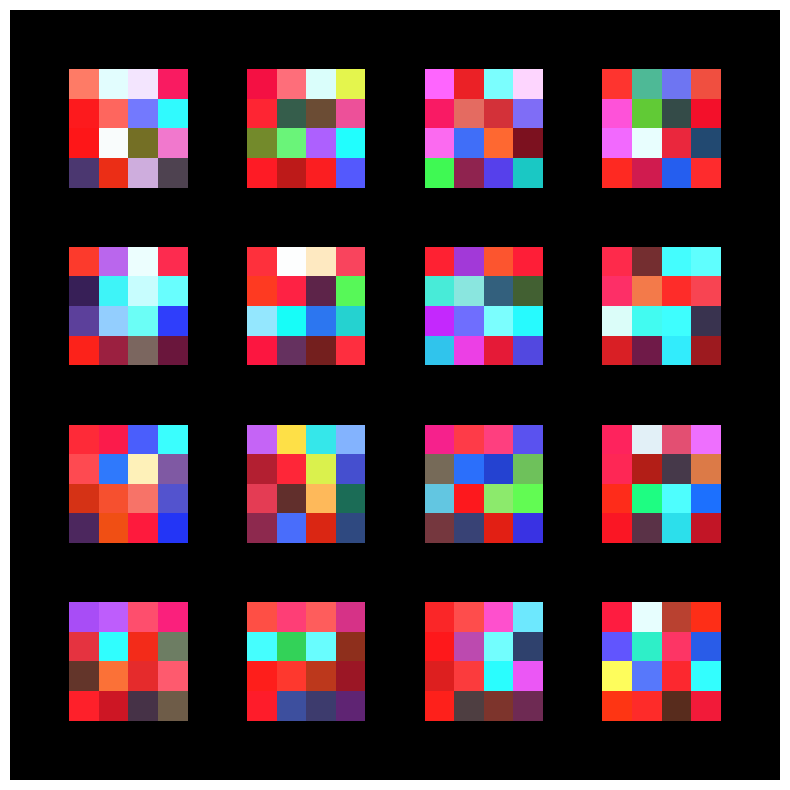

Layer 1: Loss_D: -0.7209925651550293, Loss_G: 0.6714405417442322
D Grad Norm : 0.5197, G Grad Norm: 0.3894
Epoch: 31 Outputting statistics: 


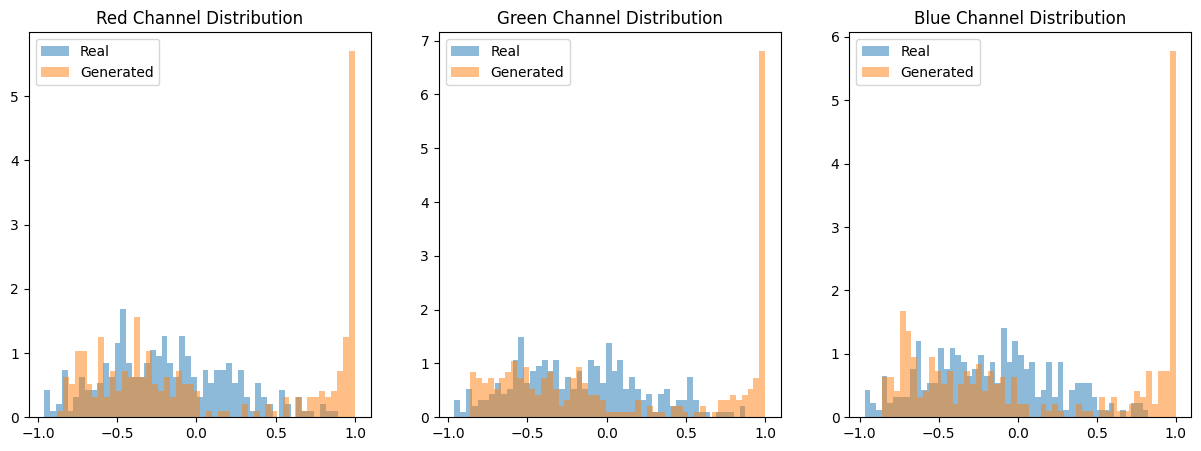

Real images - Mean: [-0.18241416 -0.17717524 -0.17536768] Std: [0.3964832  0.39969322 0.39445138]
Generated images - Mean: [0.10773917 0.1156235  0.08290333] Std: [0.68413633 0.69718075 0.6897755 ]


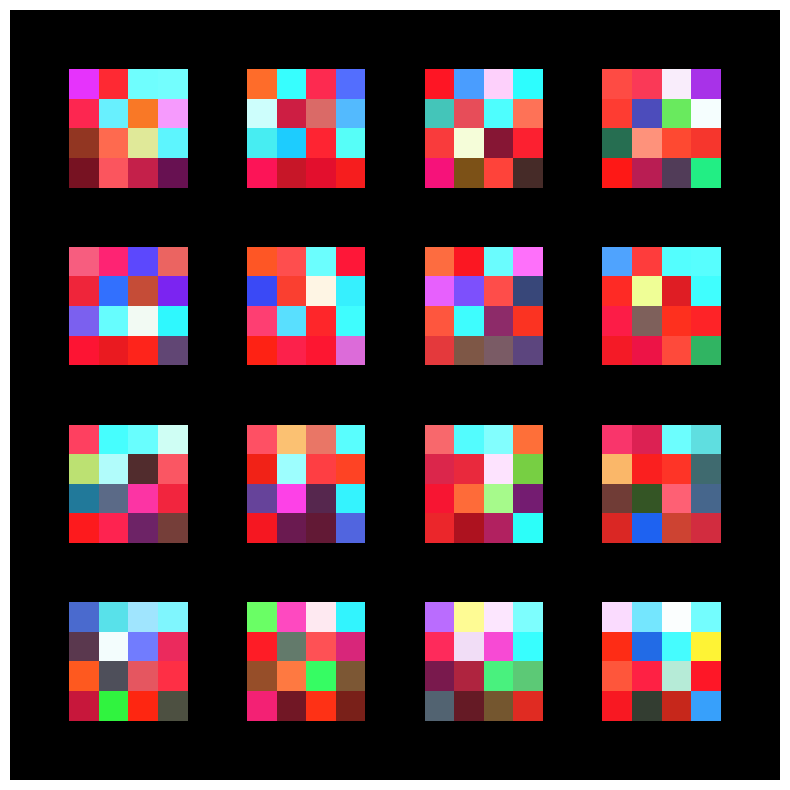

Layer 1: Loss_D: -0.7197628617286682, Loss_G: -1.5779918432235718
D Grad Norm : 0.4276, G Grad Norm: 0.3421
Epoch: 32 Outputting statistics: 


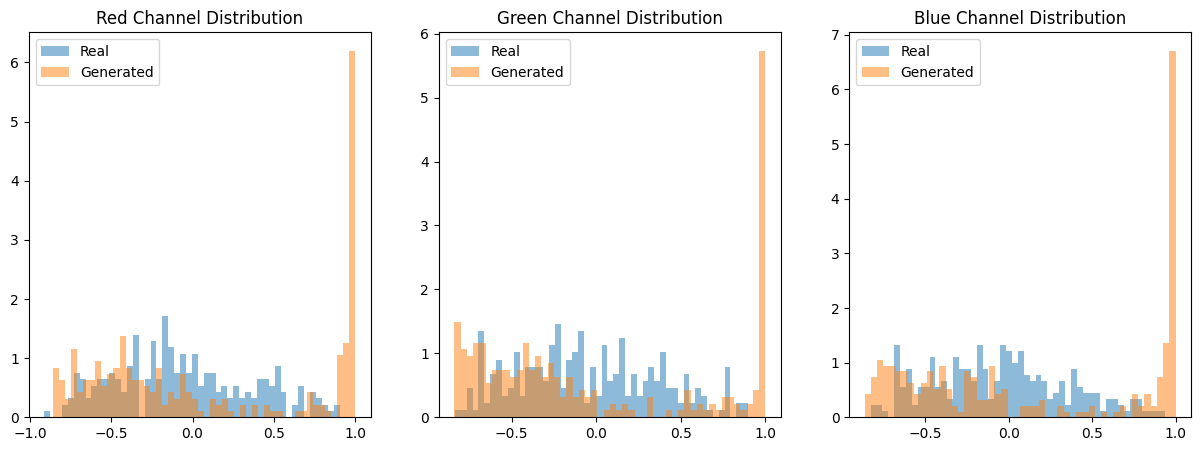

Real images - Mean: [-0.05793502 -0.05101102 -0.05542278] Std: [0.41488364 0.41517636 0.39984342]
Generated images - Mean: [ 0.10203926 -0.01746717  0.12664863] Std: [0.68551415 0.6784809  0.7045187 ]


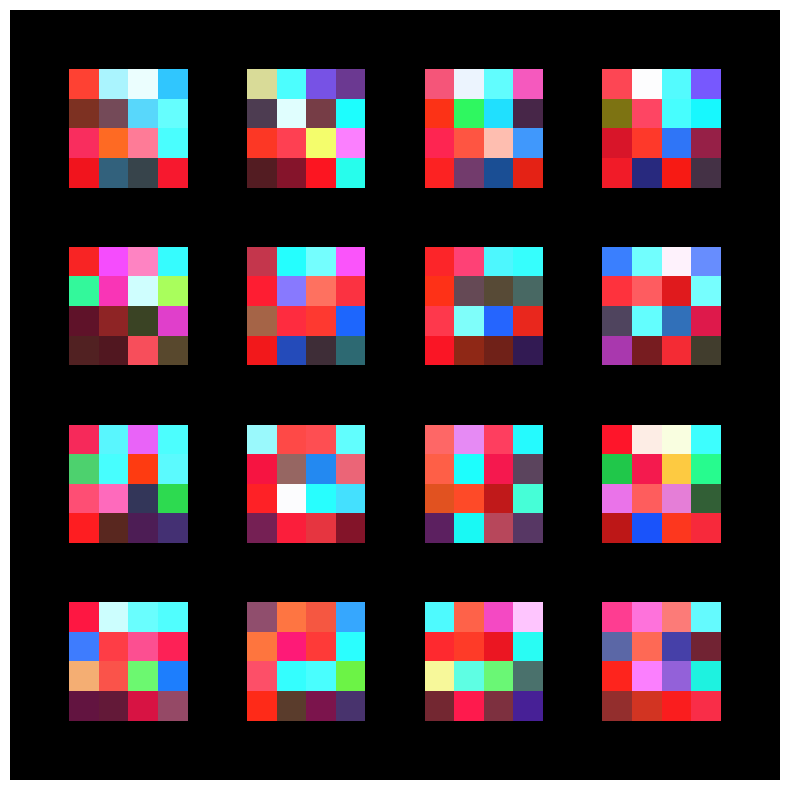

Layer 1: Loss_D: 1.2597333192825317, Loss_G: 0.3163389563560486
D Grad Norm : 0.5705, G Grad Norm: 0.2787
Epoch: 33 Outputting statistics: 


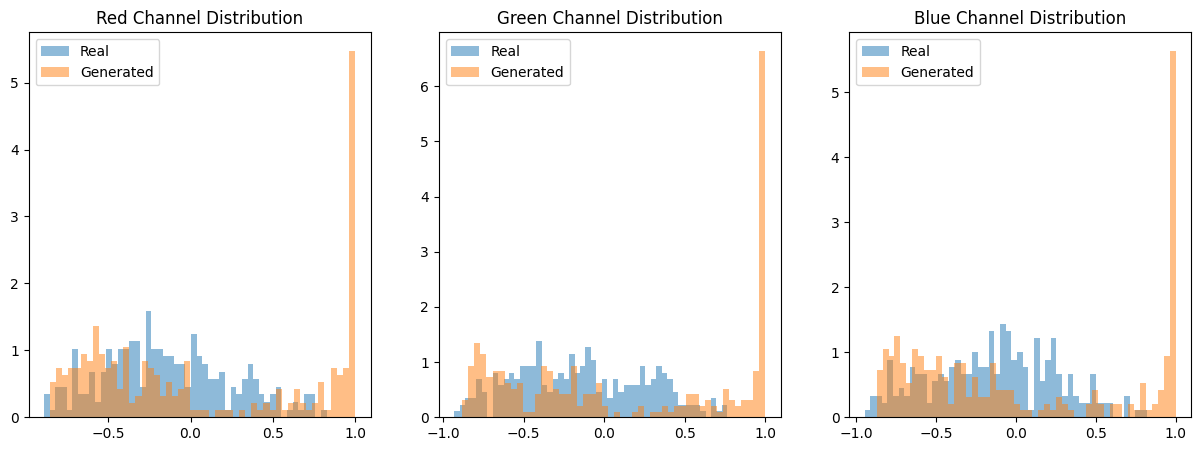

Real images - Mean: [-0.141636   -0.145772   -0.14181985] Std: [0.38557124 0.39750397 0.38512397]
Generated images - Mean: [0.07788893 0.11662753 0.02736294] Std: [0.67883337 0.7082911  0.69411206]


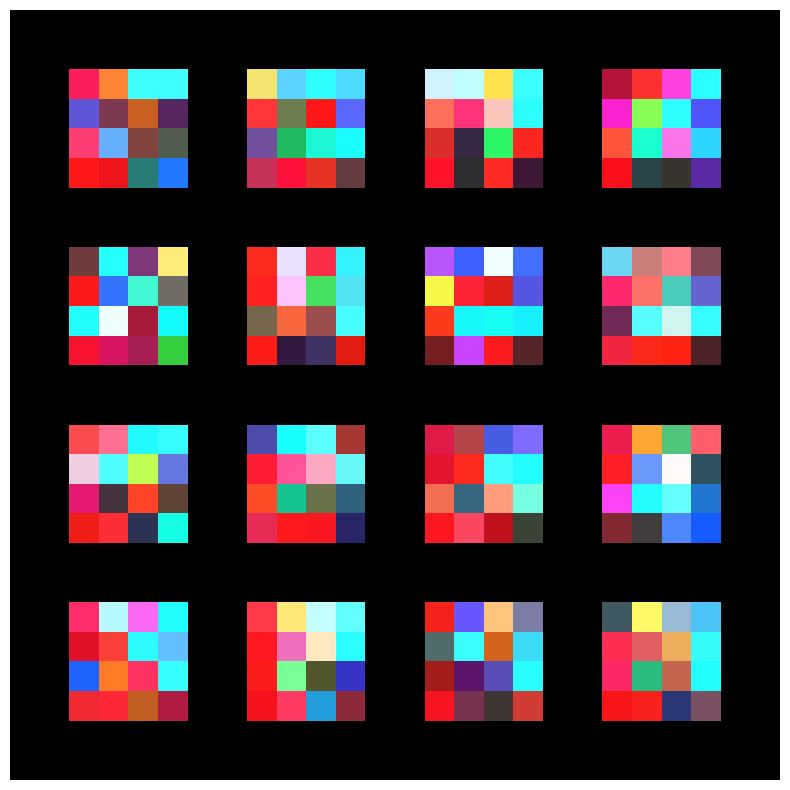

Layer 1: Loss_D: -1.061902642250061, Loss_G: -0.6827182769775391
D Grad Norm : 0.7190, G Grad Norm: 0.4141
Epoch: 34 Outputting statistics: 


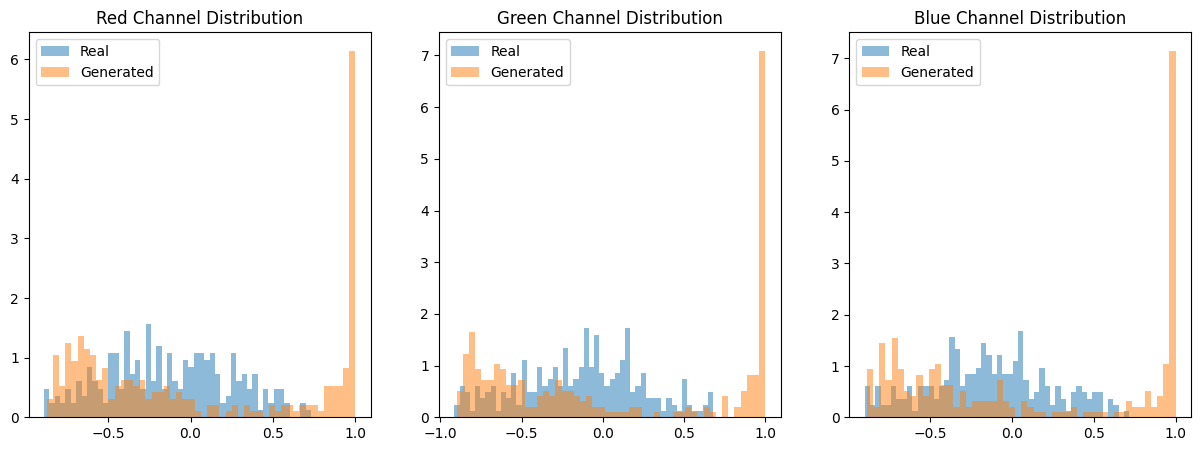

Real images - Mean: [-0.13057593 -0.14010414 -0.13946079] Std: [0.37464023 0.3719718  0.3686802 ]
Generated images - Mean: [0.06845947 0.07834189 0.09751915] Std: [0.7097936 0.7455667 0.7307899]


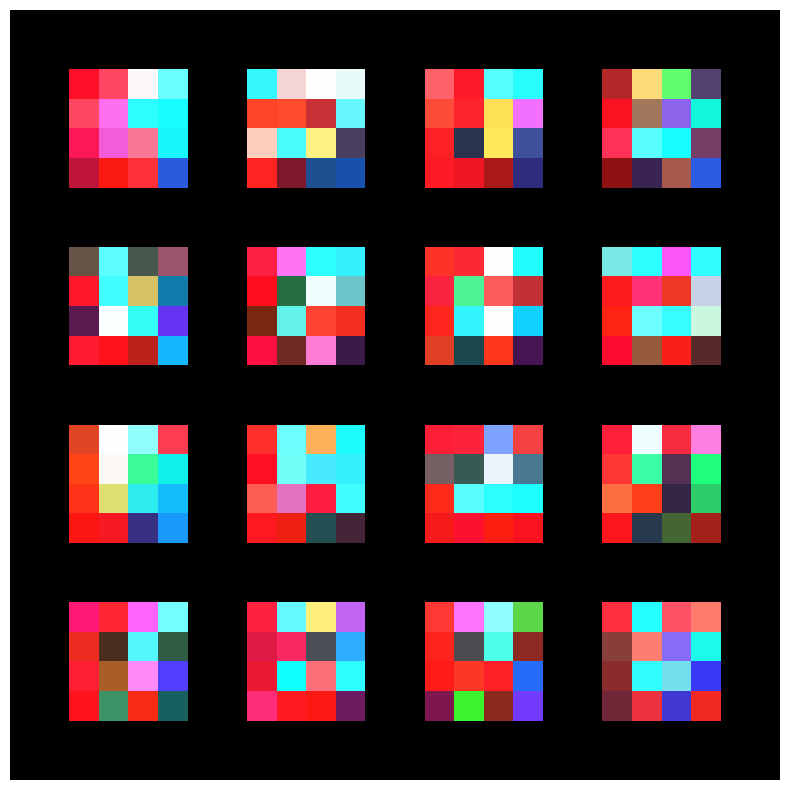

Layer 1: Loss_D: 0.011275251396000385, Loss_G: 1.7577259540557861
D Grad Norm : 0.6147, G Grad Norm: 0.4397
Epoch: 35 Outputting statistics: 


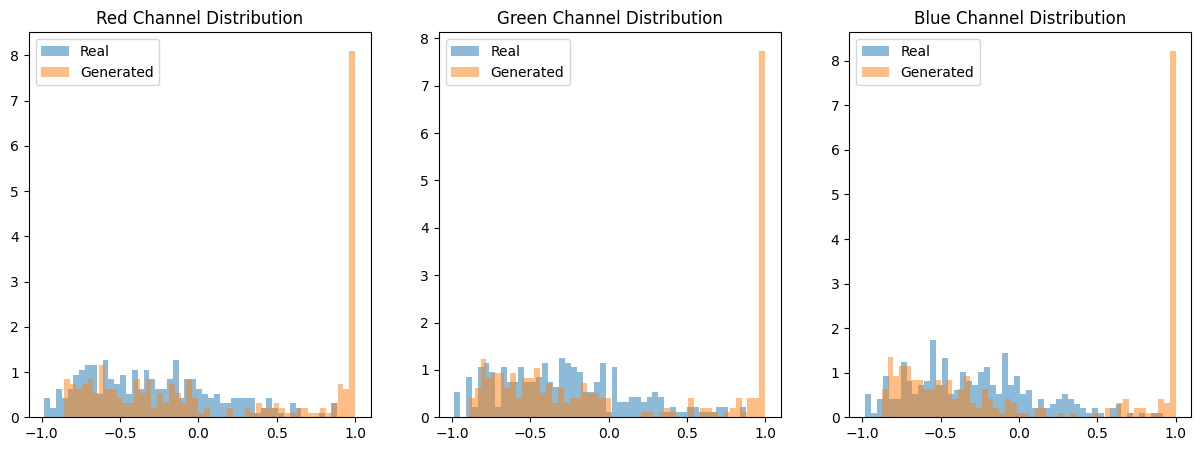

Real images - Mean: [-0.29362732 -0.28875598 -0.2869791 ] Std: [0.41421223 0.4110451  0.39805272]
Generated images - Mean: [0.17373845 0.08650889 0.07753462] Std: [0.7052202  0.7229559  0.74148065]


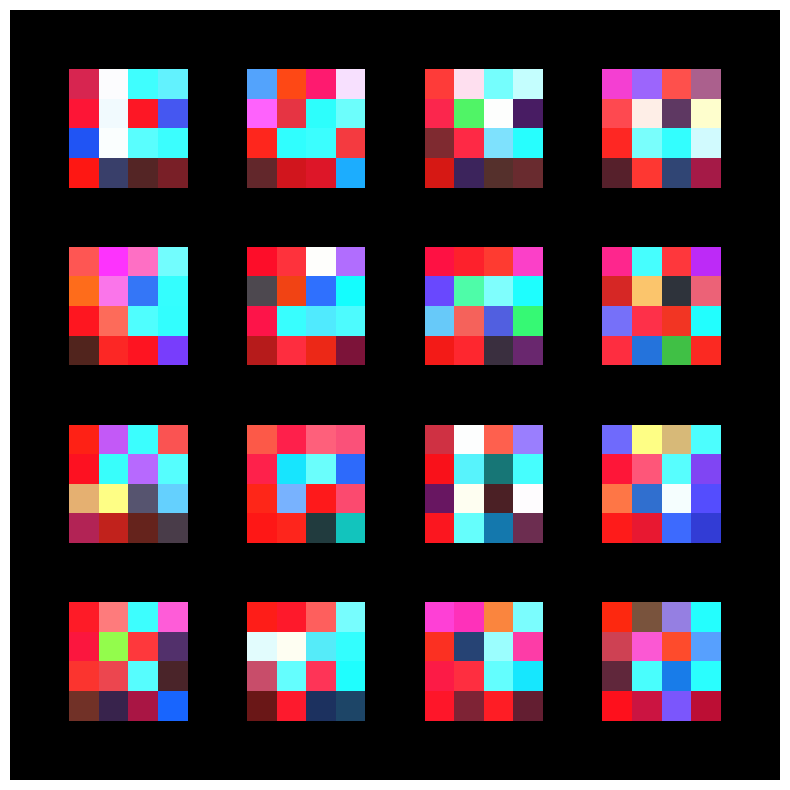

Layer 1: Loss_D: -1.4750120639801025, Loss_G: -0.11987912654876709
D Grad Norm : 0.4463, G Grad Norm: 0.3140
Epoch: 36 Outputting statistics: 


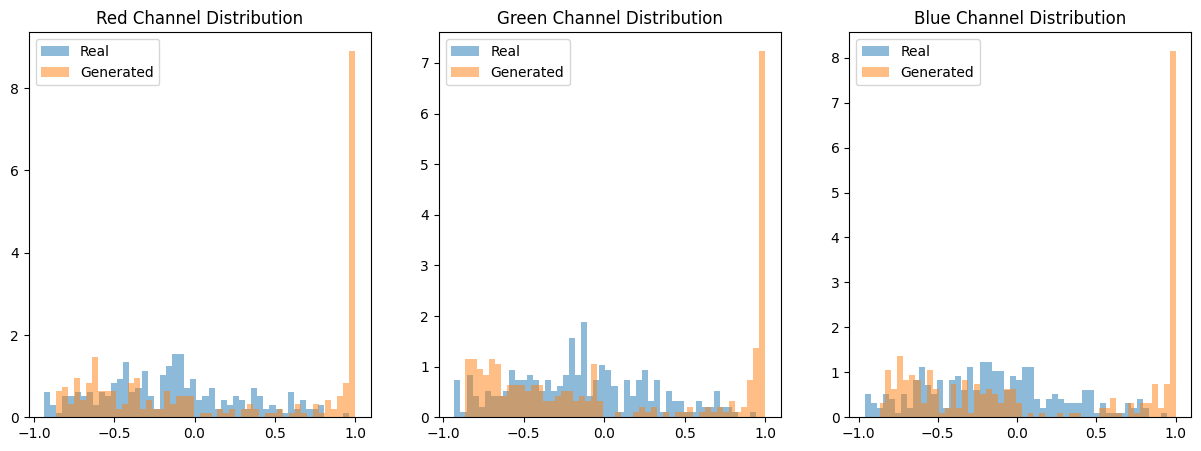

Real images - Mean: [-0.15272672 -0.14944847 -0.1528799 ] Std: [0.4268521  0.42348608 0.4204356 ]
Generated images - Mean: [0.20998015 0.11221761 0.1614295 ] Std: [0.71621567 0.7315655  0.72248447]


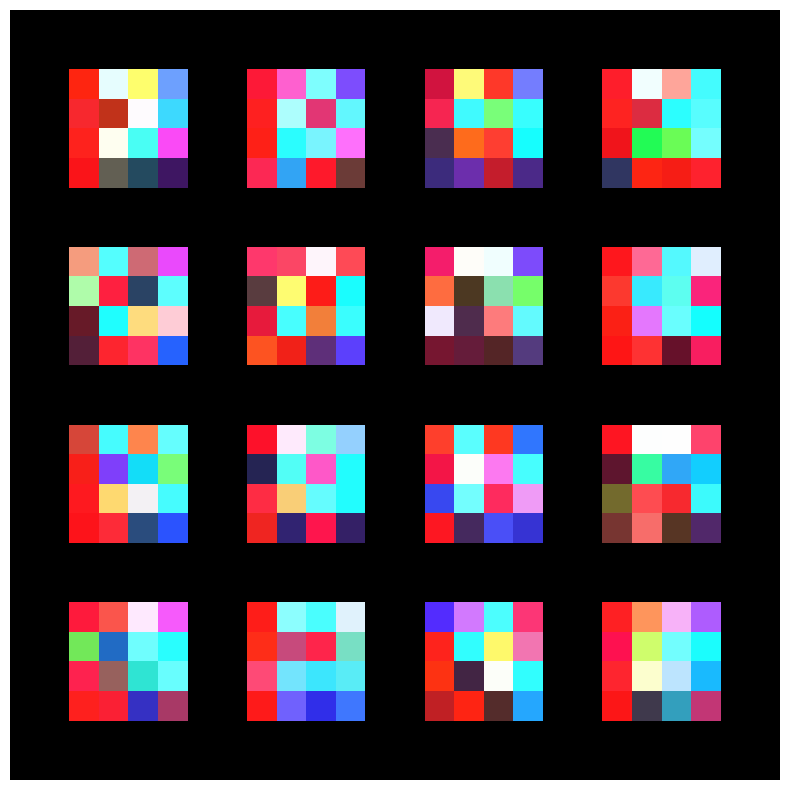

Layer 1: Loss_D: 3.491459369659424, Loss_G: -1.130794882774353
D Grad Norm : 0.7676, G Grad Norm: 0.2457
Epoch: 37 Outputting statistics: 


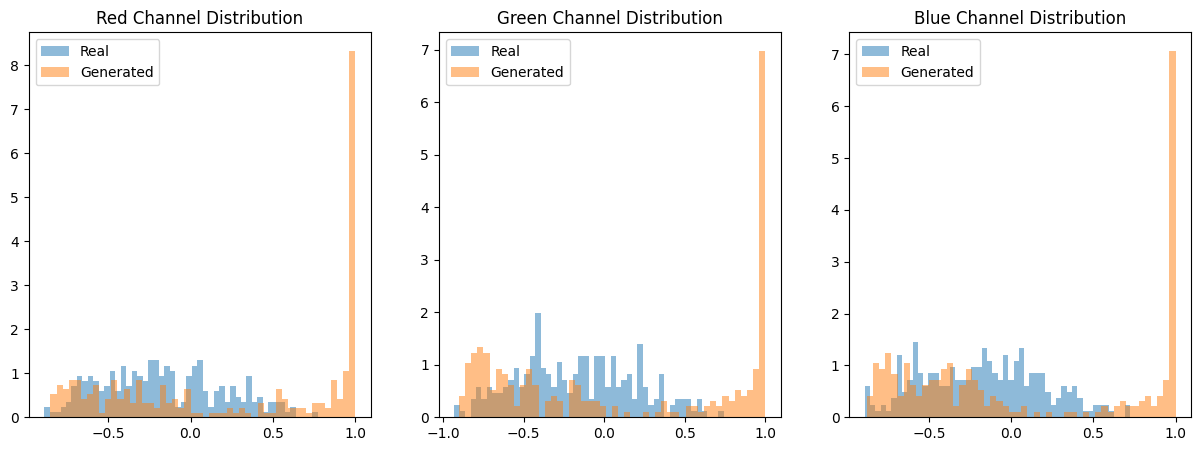

Real images - Mean: [-0.17068018 -0.17239583 -0.17457108] Std: [0.36297607 0.36153418 0.3599698 ]
Generated images - Mean: [0.26038748 0.11260153 0.08619937] Std: [0.69594806 0.746076   0.7188589 ]


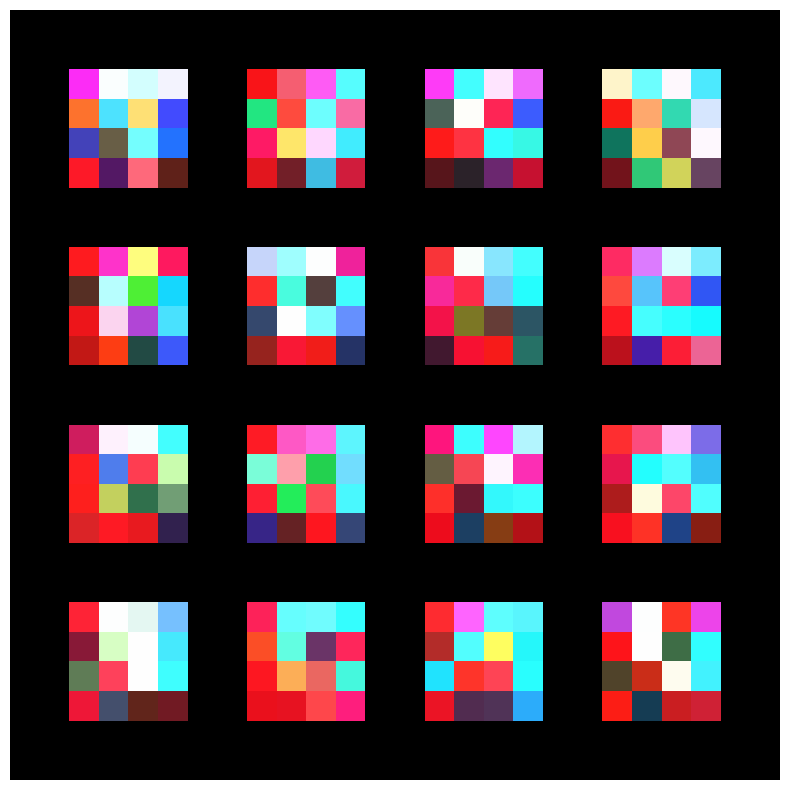

Layer 1: Loss_D: 0.6356230974197388, Loss_G: 2.0392515659332275
D Grad Norm : 0.6225, G Grad Norm: 0.3389
Epoch: 38 Outputting statistics: 


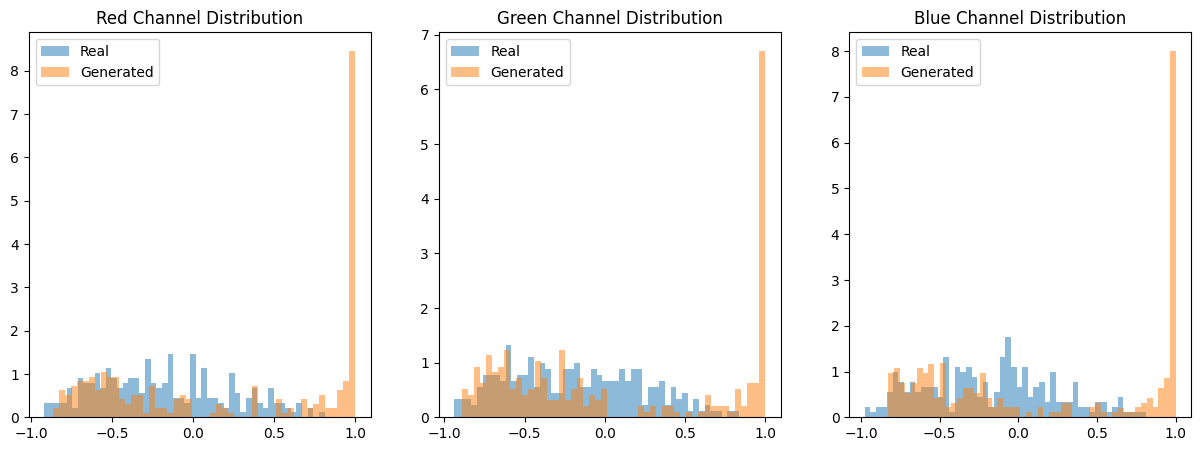

Real images - Mean: [-0.18679537 -0.18624388 -0.18486518] Std: [0.40457416 0.4088658  0.40579087]
Generated images - Mean: [0.21388885 0.08387098 0.15397981] Std: [0.7138679  0.70809776 0.71489805]


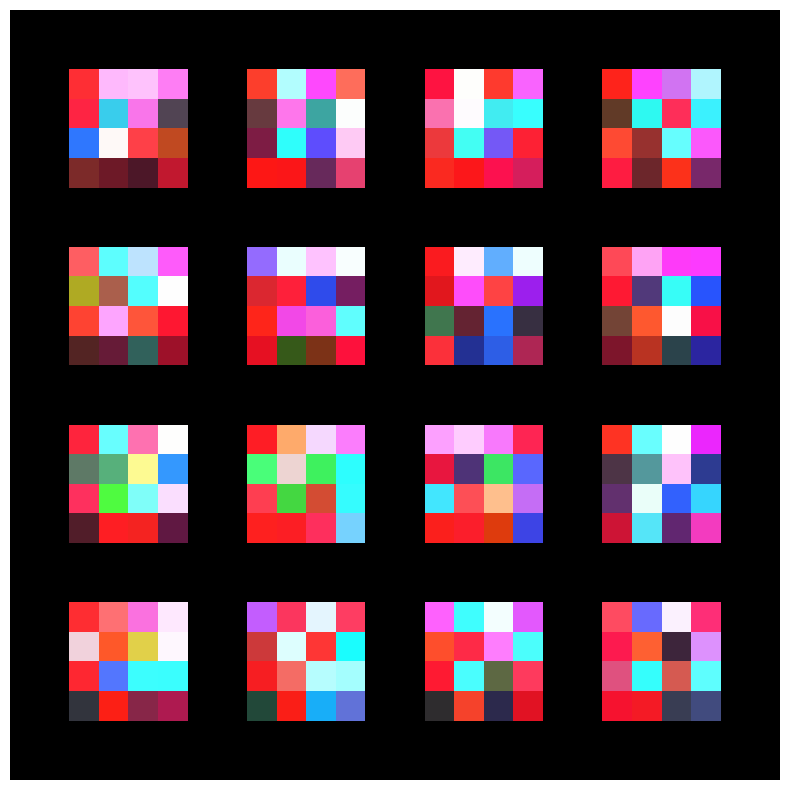

Layer 1: Loss_D: 1.3284271955490112, Loss_G: 1.0198321342468262
D Grad Norm : 0.5935, G Grad Norm: 0.2544
Epoch: 39 Outputting statistics: 


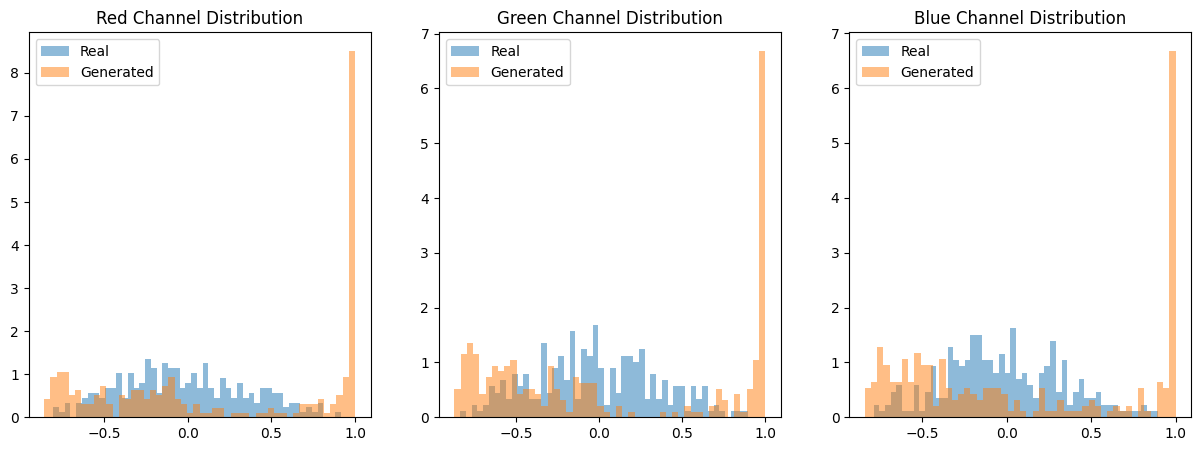

Real images - Mean: [-0.02401958 -0.02279409 -0.02202816] Std: [0.3735072  0.3653661  0.35057998]
Generated images - Mean: [0.21847782 0.0707917  0.08335365] Std: [0.7029727 0.7182934 0.6837846]


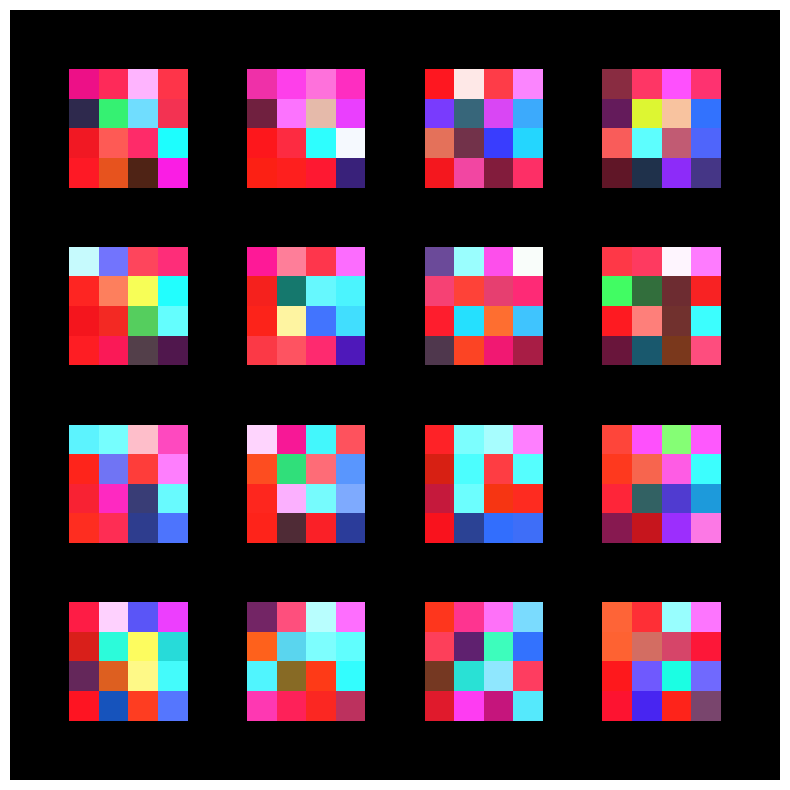

Layer 1: Loss_D: 2.559602737426758, Loss_G: -1.8845220804214478
D Grad Norm : 0.6106, G Grad Norm: 0.3422
Epoch: 40 Outputting statistics: 


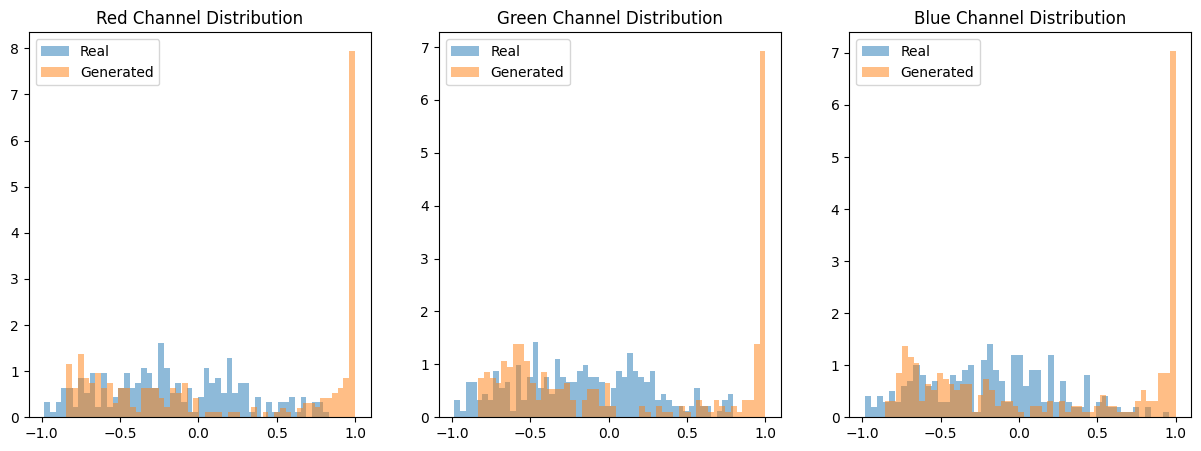

Real images - Mean: [-0.16899514 -0.17012867 -0.1697916 ] Std: [0.43449894 0.4304948  0.4201688 ]
Generated images - Mean: [0.17414041 0.10093737 0.16432706] Std: [0.7260632 0.7074574 0.7004186]


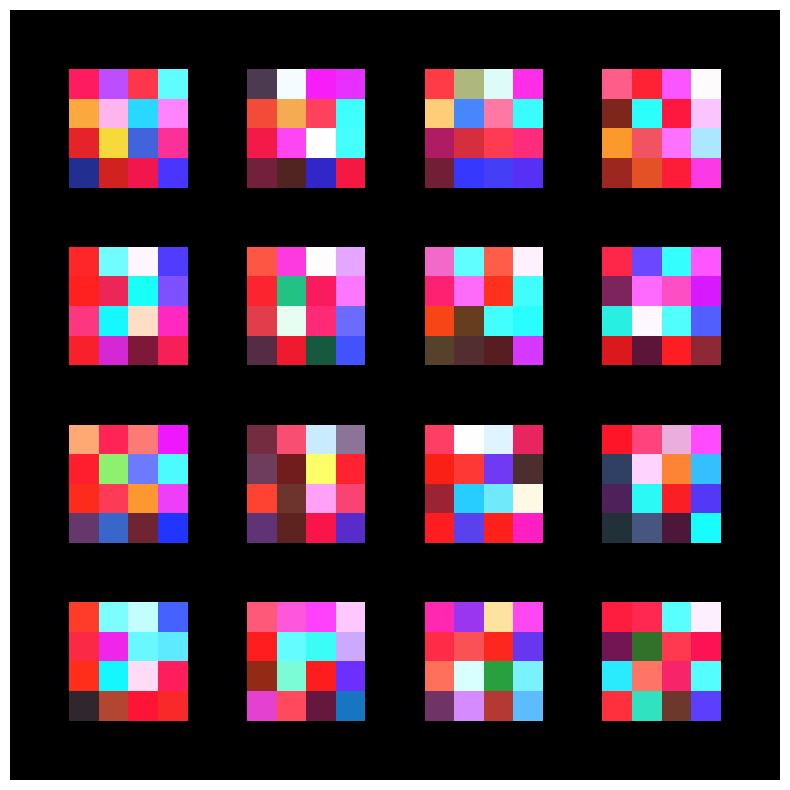

Layer 1: Loss_D: 1.2162173986434937, Loss_G: -0.2930956482887268
D Grad Norm : 0.4750, G Grad Norm: 0.3535
Epoch: 41 Outputting statistics: 


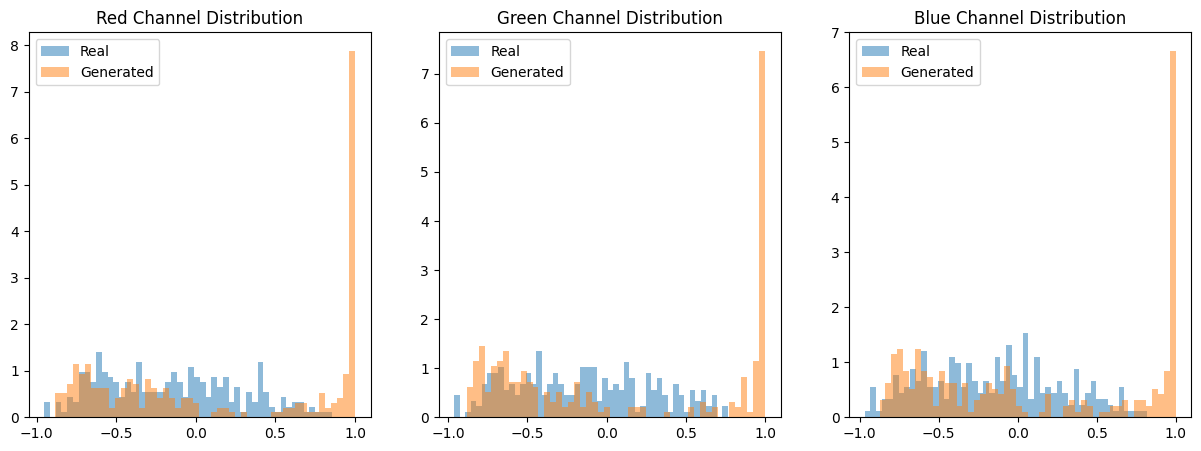

Real images - Mean: [-0.1559743  -0.15530024 -0.15398279] Std: [0.42704514 0.4278314  0.4225403 ]
Generated images - Mean: [0.15563639 0.08394902 0.11067662] Std: [0.7228046  0.74965113 0.70424014]


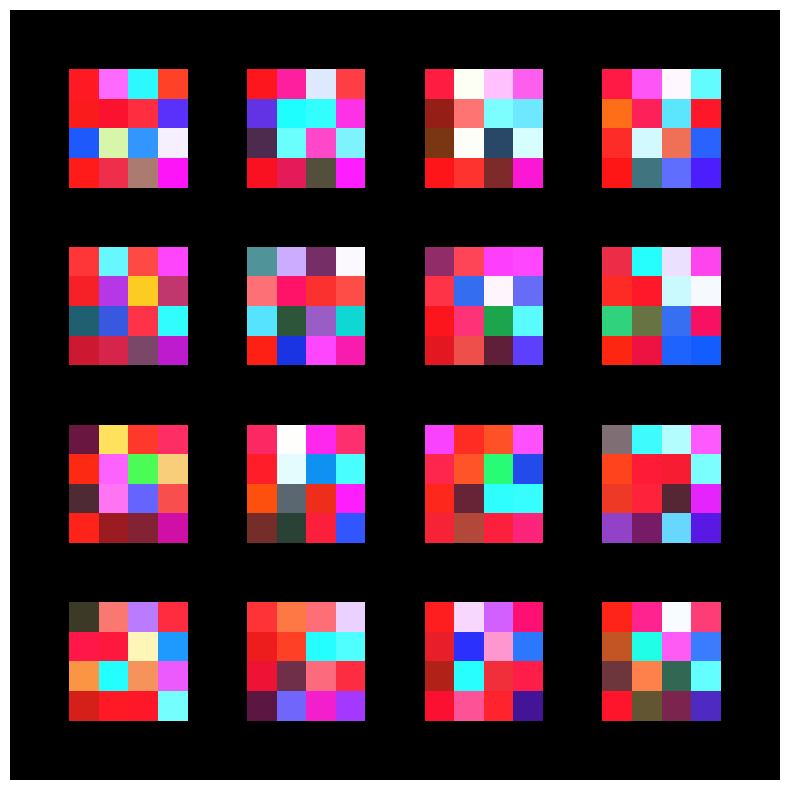

Layer 1: Loss_D: -0.6273136138916016, Loss_G: 0.40444216132164
D Grad Norm : 0.7261, G Grad Norm: 0.3209
Epoch: 42 Outputting statistics: 


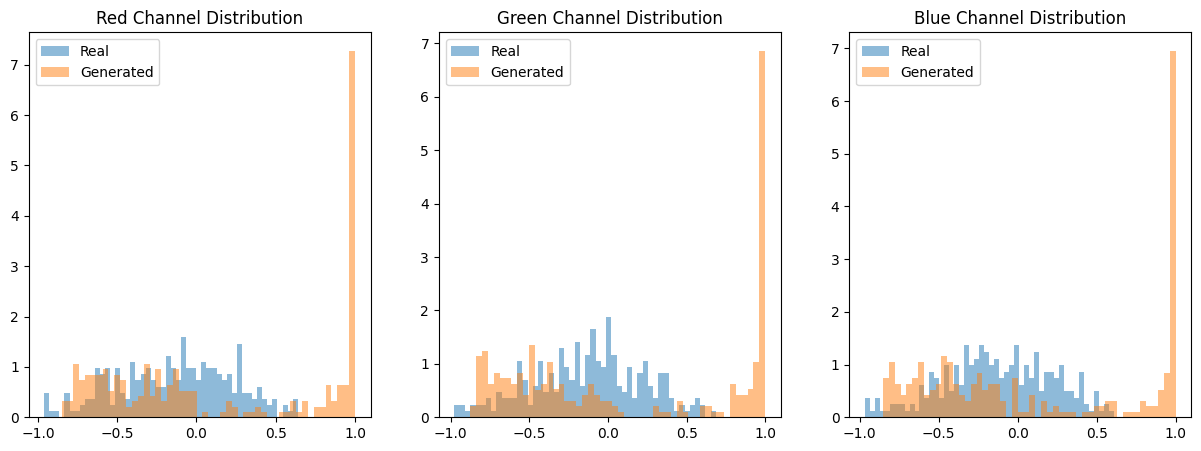

Real images - Mean: [-0.13572305 -0.13161762 -0.13244481] Std: [0.3626889  0.3532025  0.34357423]
Generated images - Mean: [0.14675336 0.10754956 0.11662599] Std: [0.68940306 0.7188794  0.68895715]


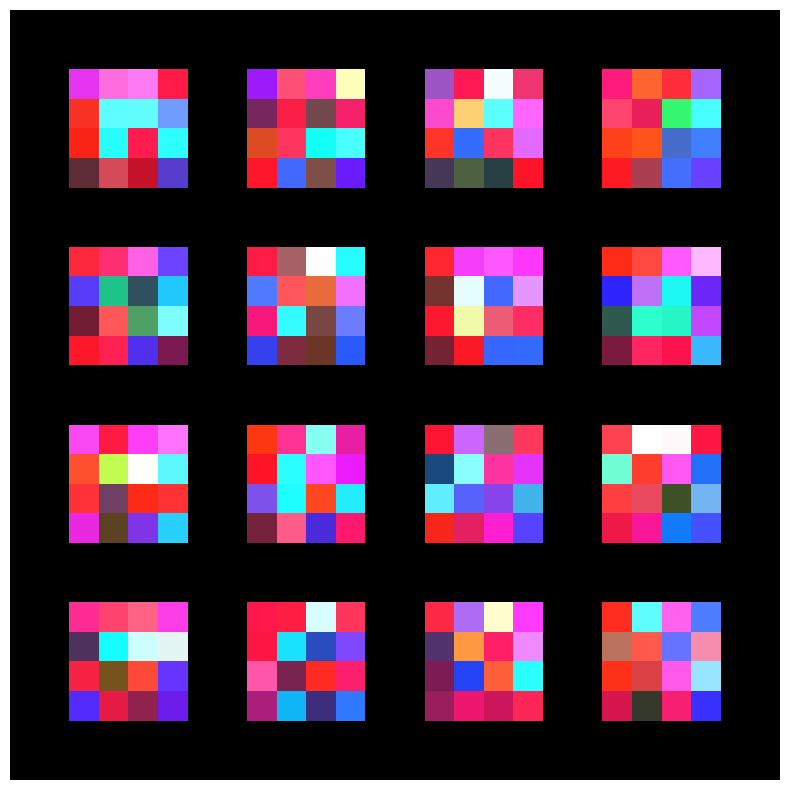

Layer 1: Loss_D: 0.49715593457221985, Loss_G: 0.4636702239513397
D Grad Norm : 0.5863, G Grad Norm: 0.3360
Epoch: 43 Outputting statistics: 


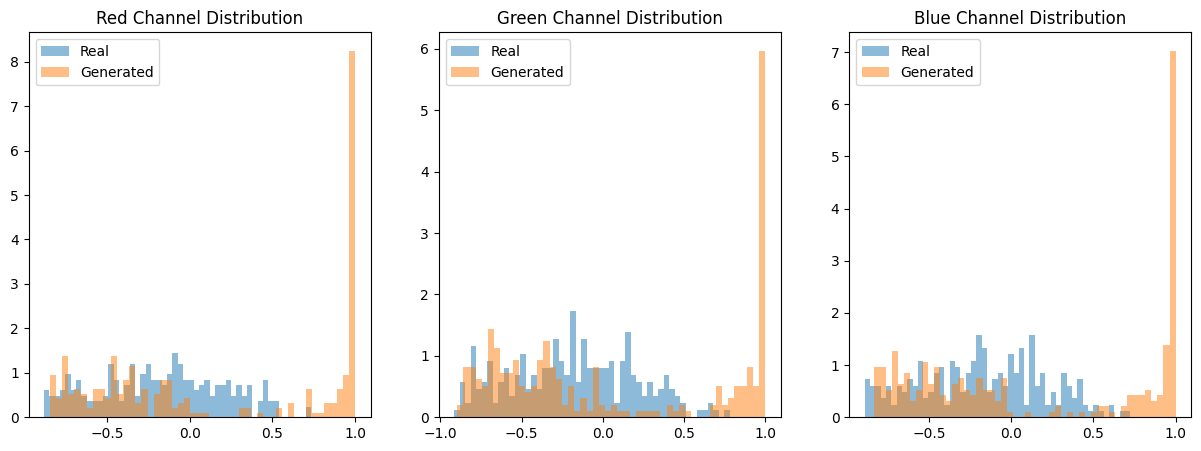

Real images - Mean: [-0.17745098 -0.18385419 -0.1802695 ] Std: [0.3768061  0.37925148 0.37319353]
Generated images - Mean: [0.17710377 0.06892434 0.15232193] Std: [0.712199   0.70495445 0.7081965 ]


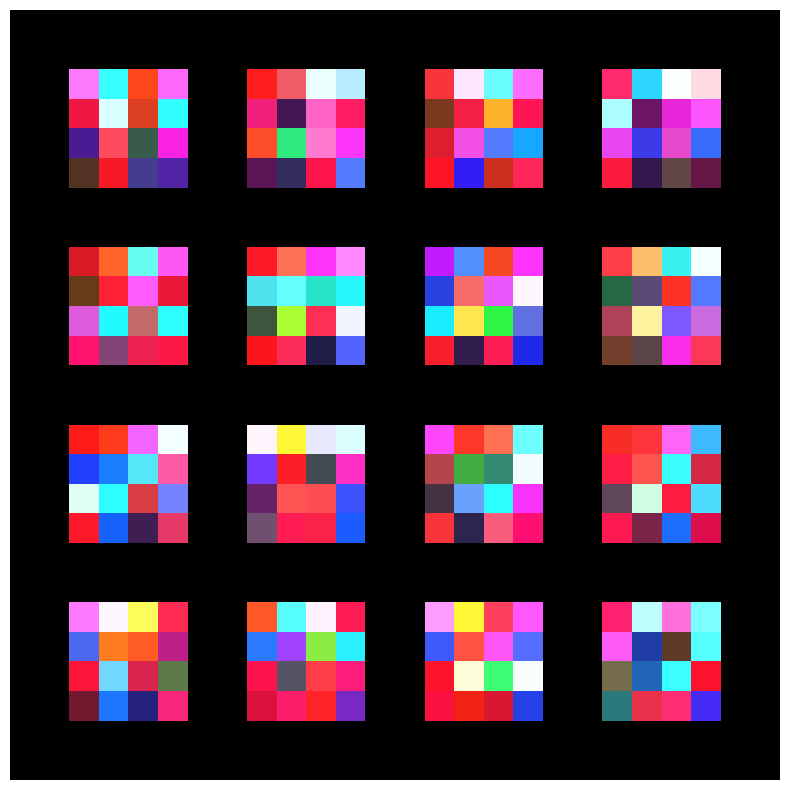

Layer 1: Loss_D: 1.4231632947921753, Loss_G: -0.39854568243026733
D Grad Norm : 0.7674, G Grad Norm: 0.3873
Epoch: 44 Outputting statistics: 


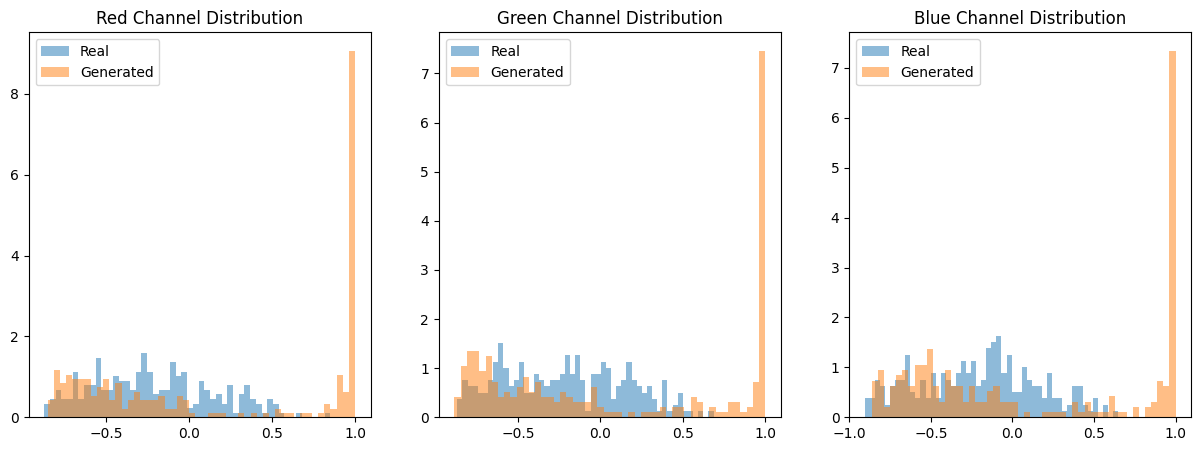

Real images - Mean: [-0.21795335 -0.21338843 -0.21139704] Std: [0.36597157 0.36979148 0.36258125]
Generated images - Mean: [0.16618435 0.0811561  0.1082716 ] Std: [0.73972017 0.7314979  0.7059054 ]


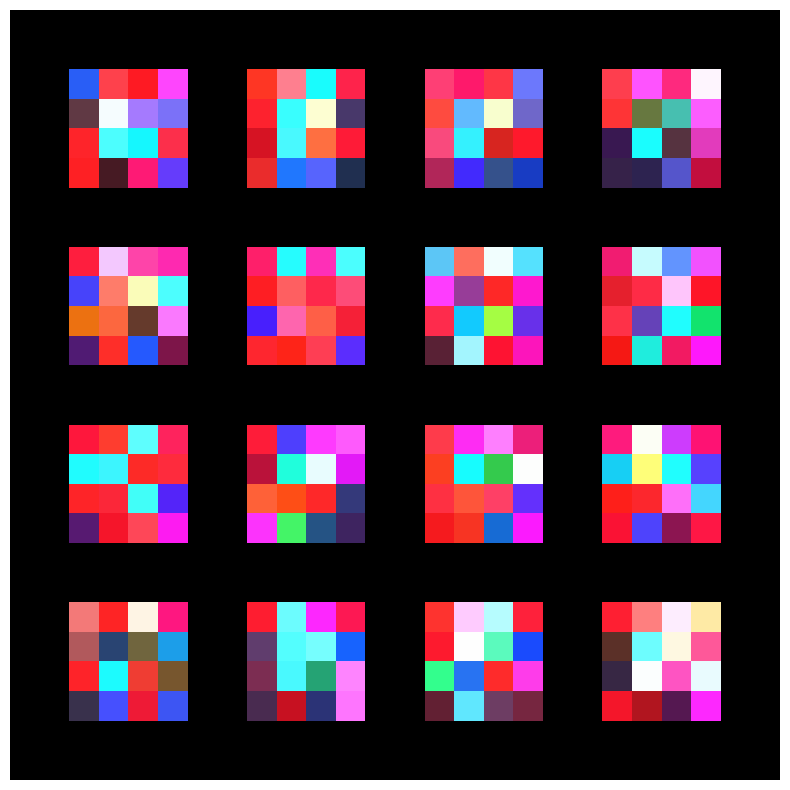

Layer 1: Loss_D: -1.6948199272155762, Loss_G: 0.5165591239929199
D Grad Norm : 0.5143, G Grad Norm: 0.2618
Epoch: 45 Outputting statistics: 


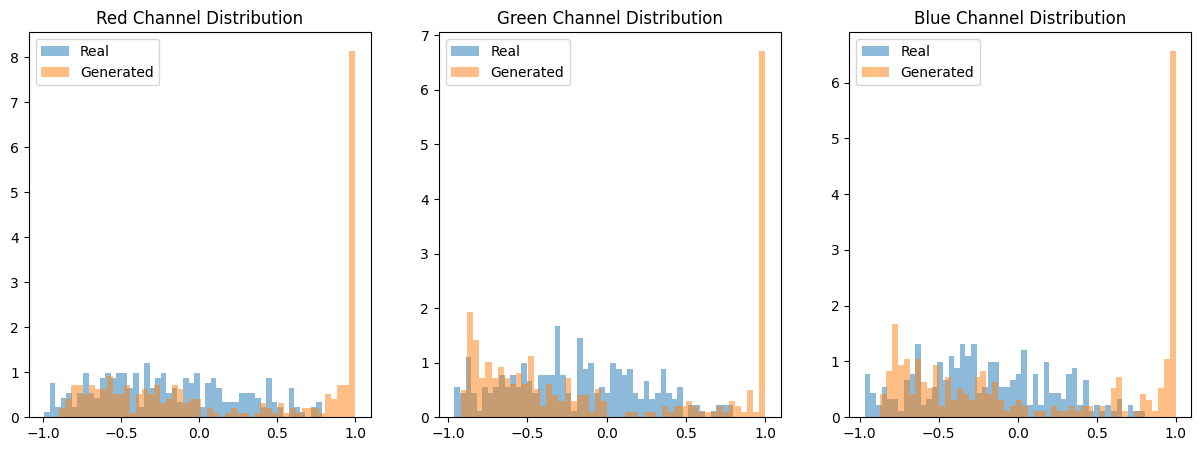

Real images - Mean: [-0.20453437 -0.20287992 -0.19972423] Std: [0.43471432 0.42241123 0.41130012]
Generated images - Mean: [ 0.21765912 -0.00533203  0.10444532] Std: [0.7019753  0.73962134 0.71240693]


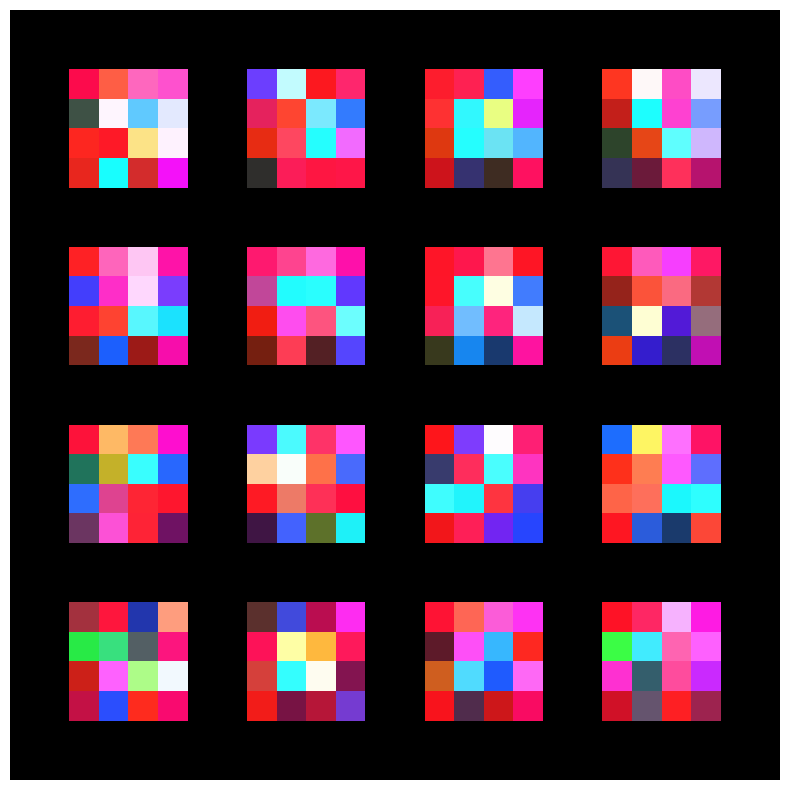

Layer 1: Loss_D: -0.699394702911377, Loss_G: 0.11012166738510132
D Grad Norm : 0.5201, G Grad Norm: 0.2725
Epoch: 46 Outputting statistics: 


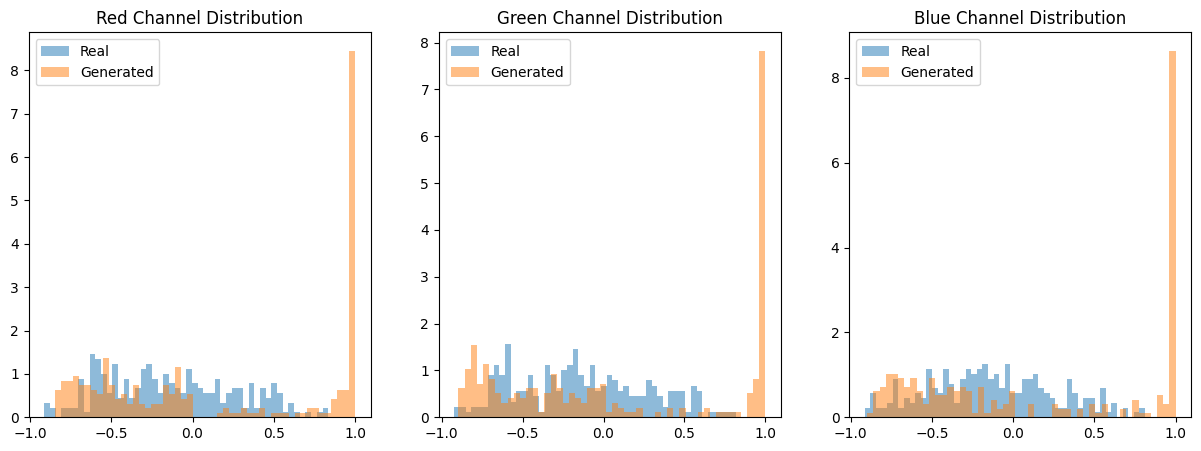

Real images - Mean: [-0.13722427 -0.13704047 -0.13627449] Std: [0.40015647 0.40149987 0.38848335]
Generated images - Mean: [0.1625294  0.09495185 0.13885856] Std: [0.7119697  0.72770005 0.72410464]


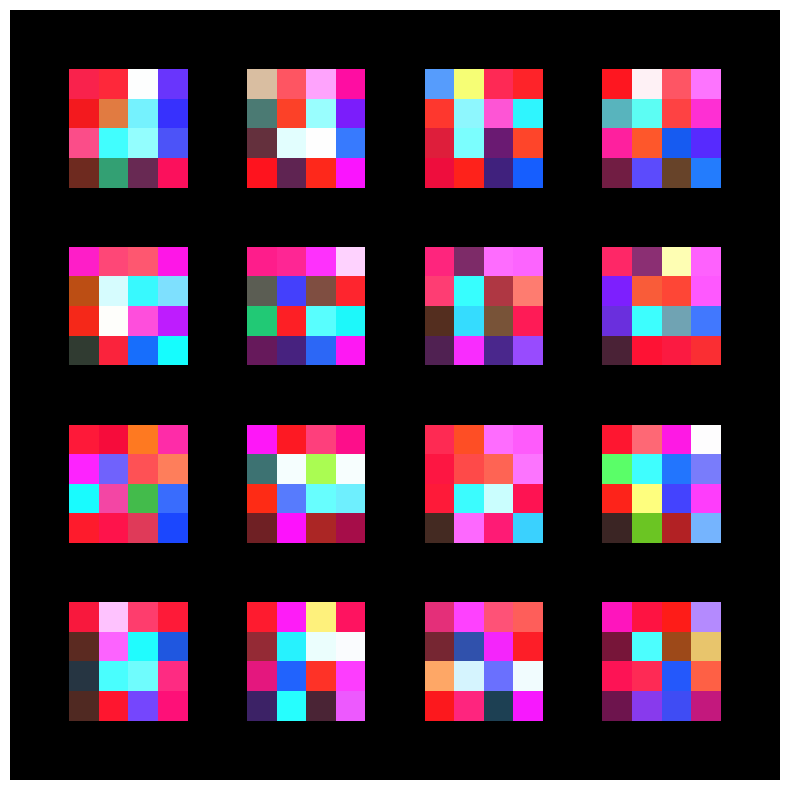

Layer 1: Loss_D: 1.9002891778945923, Loss_G: -0.8294132947921753
D Grad Norm : 0.5276, G Grad Norm: 0.3260
Epoch: 47 Outputting statistics: 


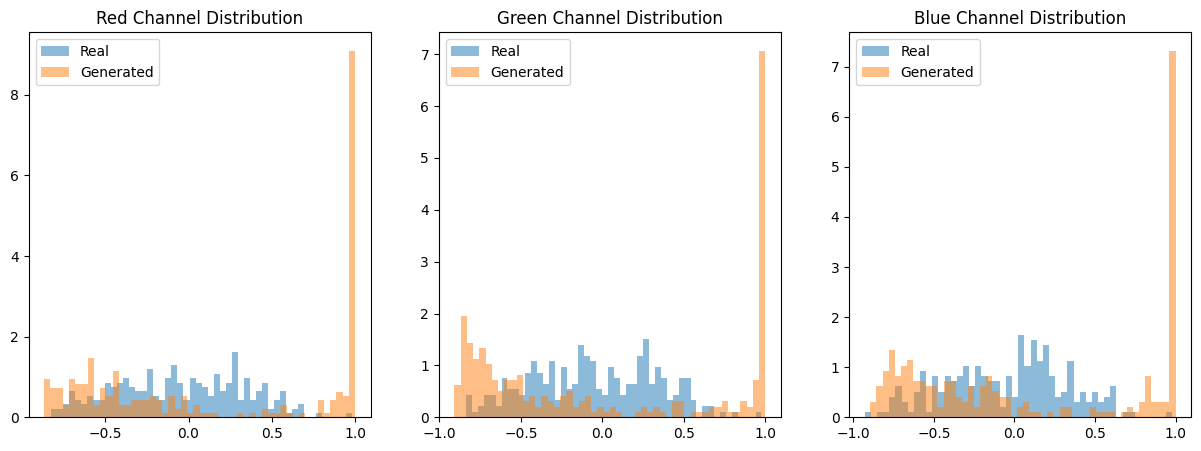

Real images - Mean: [-0.04724266 -0.05330878 -0.05229776] Std: [0.3815237  0.38014114 0.37415603]
Generated images - Mean: [0.16952688 0.02262231 0.08576615] Std: [0.73582387 0.75831693 0.7217613 ]


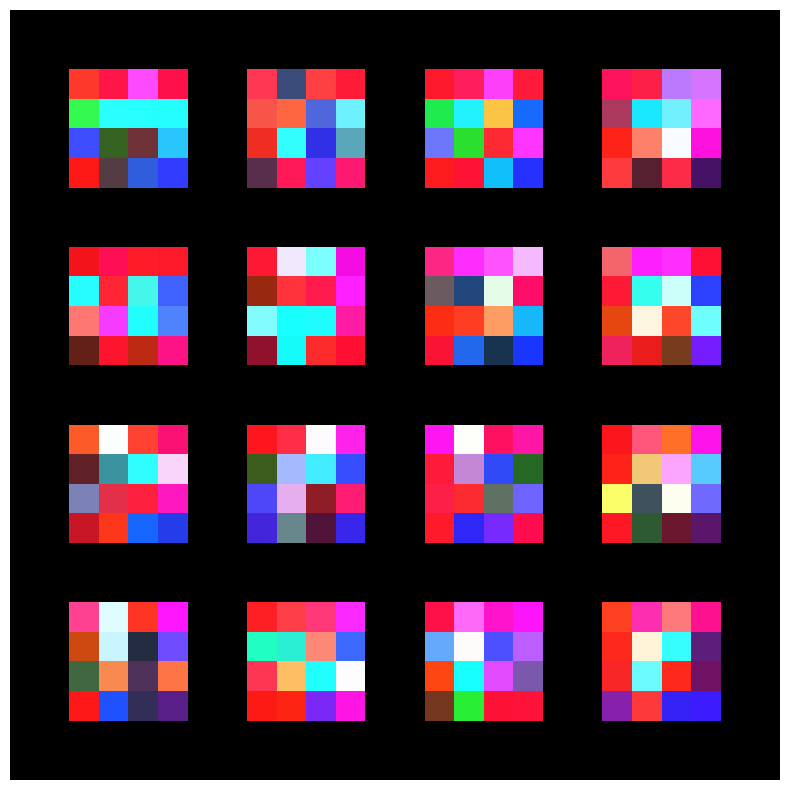

Layer 1: Loss_D: -1.1121114492416382, Loss_G: -0.6265348196029663
D Grad Norm : 0.4451, G Grad Norm: 0.3176
Epoch: 48 Outputting statistics: 


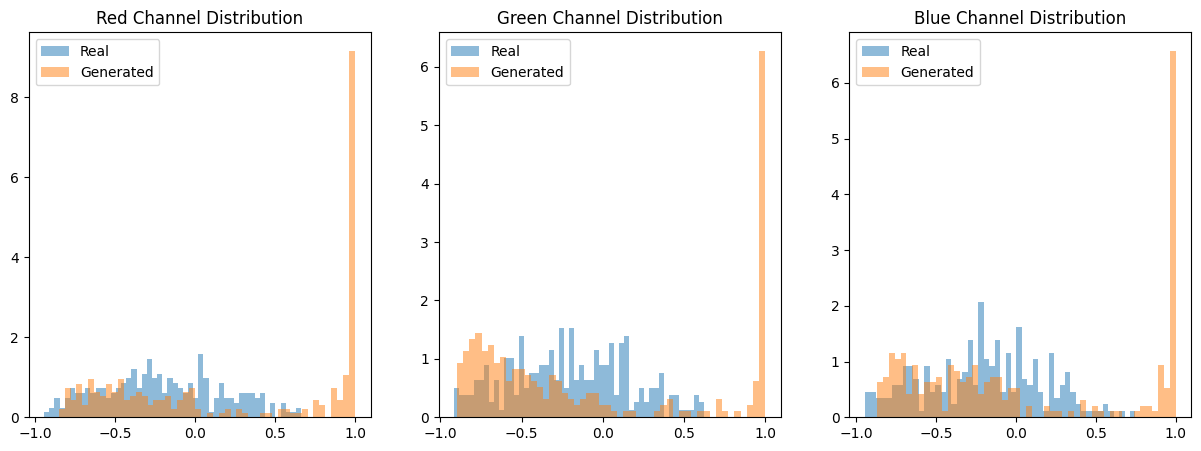

Real images - Mean: [-0.20401351 -0.20579043 -0.20903793] Std: [0.3750618  0.36660236 0.36817777]
Generated images - Mean: [ 0.25129595 -0.064703    0.05296048] Std: [0.7020409  0.72110254 0.69472986]


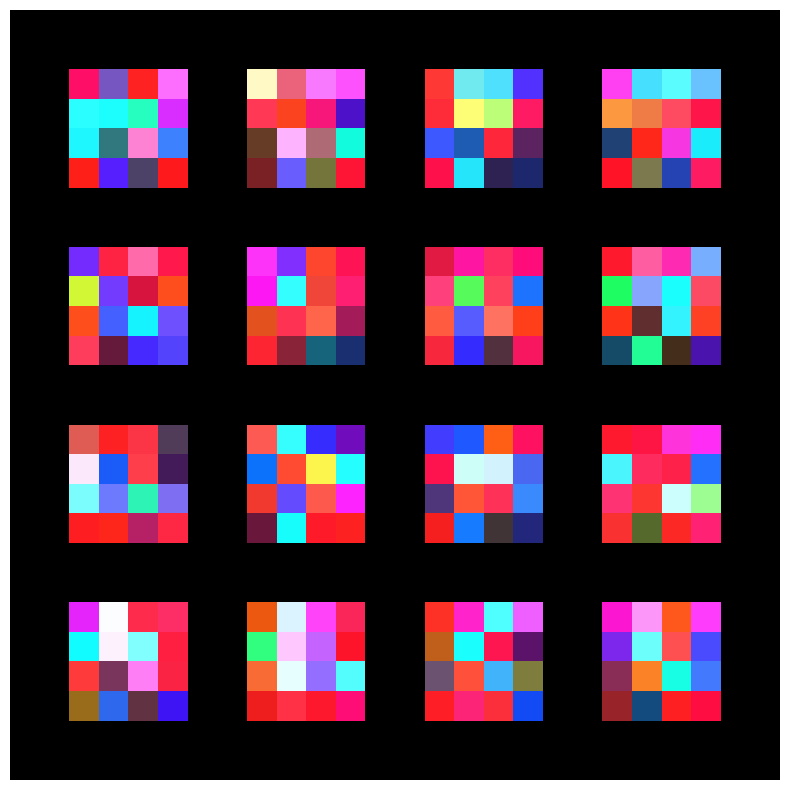

Layer 1: Loss_D: -1.6956243515014648, Loss_G: -1.9333927631378174
D Grad Norm : 0.4621, G Grad Norm: 0.3278
Epoch: 49 Outputting statistics: 


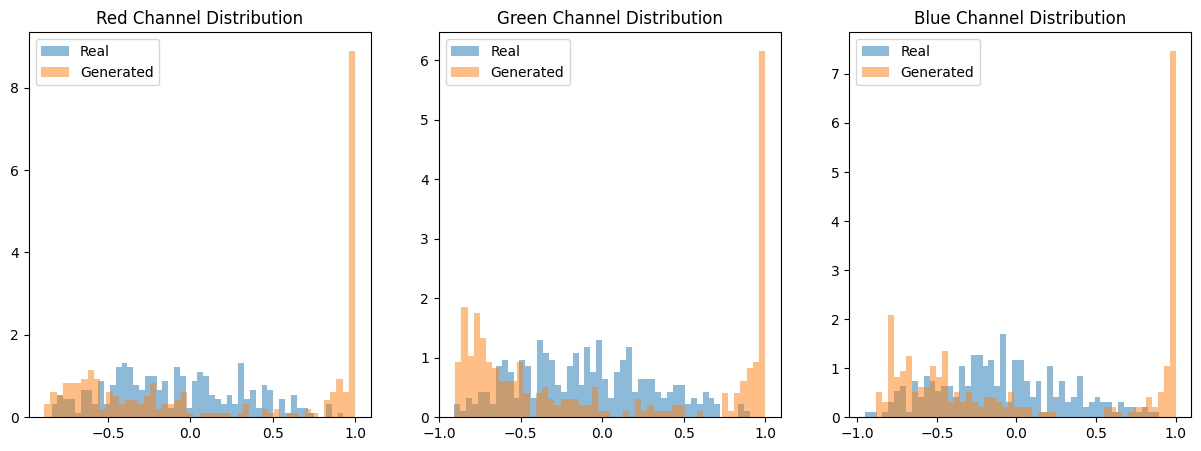

Real images - Mean: [-0.09604775 -0.10333949 -0.09748775] Std: [0.40443894 0.399637   0.3949547 ]
Generated images - Mean: [0.20827937 0.01511901 0.0824995 ] Std: [0.730284  0.7621755 0.7393412]


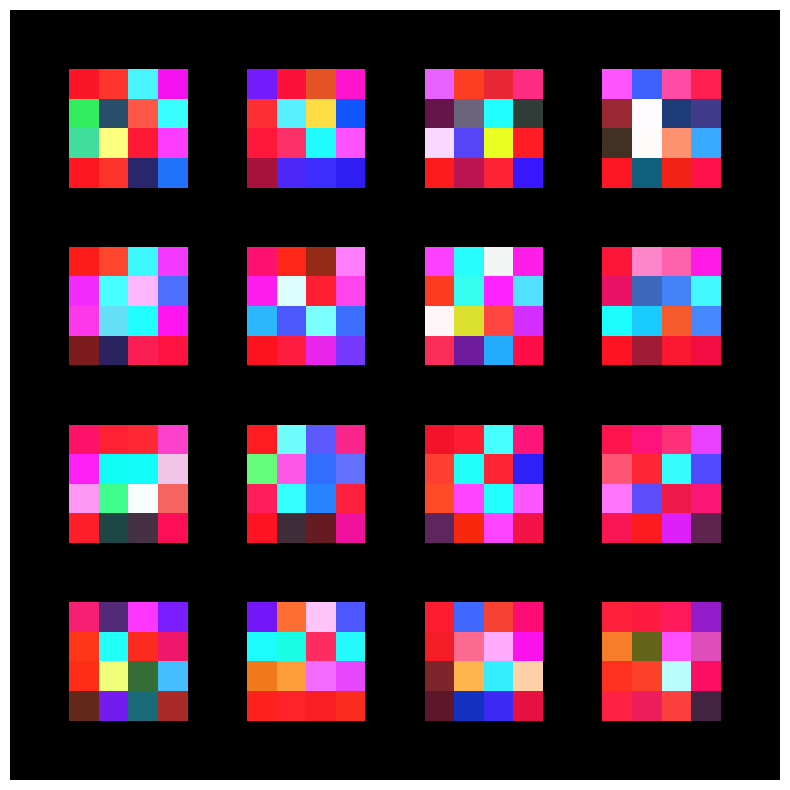

Layer 1: Loss_D: -0.2896652817726135, Loss_G: -0.43521541357040405
D Grad Norm : 0.6200, G Grad Norm: 0.3240
Epoch: 50 Outputting statistics: 


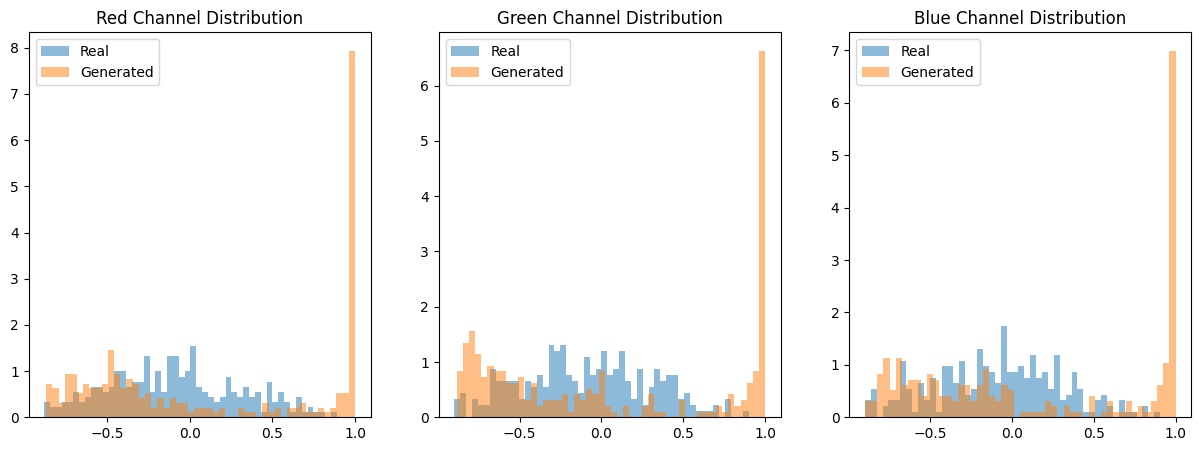

Real images - Mean: [-0.09203431 -0.09405637 -0.09172792] Std: [0.39188468 0.38910636 0.3840017 ]
Generated images - Mean: [0.13035244 0.05446211 0.13418189] Std: [0.7101149  0.73482996 0.70281607]


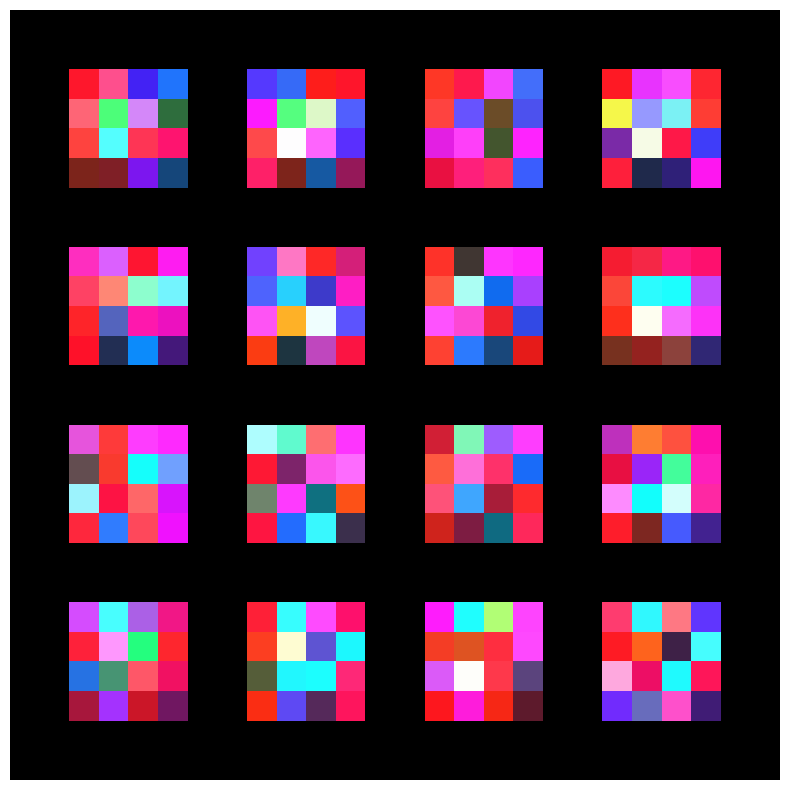

Layer 1: Loss_D: 0.6584371328353882, Loss_G: -0.2049780786037445
D Grad Norm : 0.4343, G Grad Norm: 0.2760
Epoch: 51 Outputting statistics: 


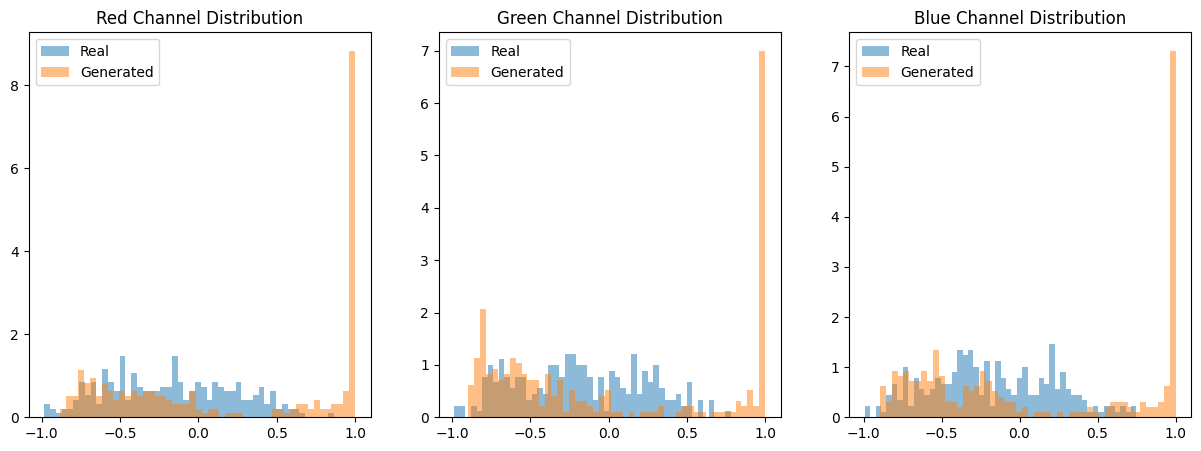

Real images - Mean: [-0.17778797 -0.18284313 -0.17941168] Std: [0.40298292 0.4030649  0.3924264 ]
Generated images - Mean: [ 0.20000282 -0.00327812  0.10187194] Std: [0.7152067  0.73781633 0.7146203 ]


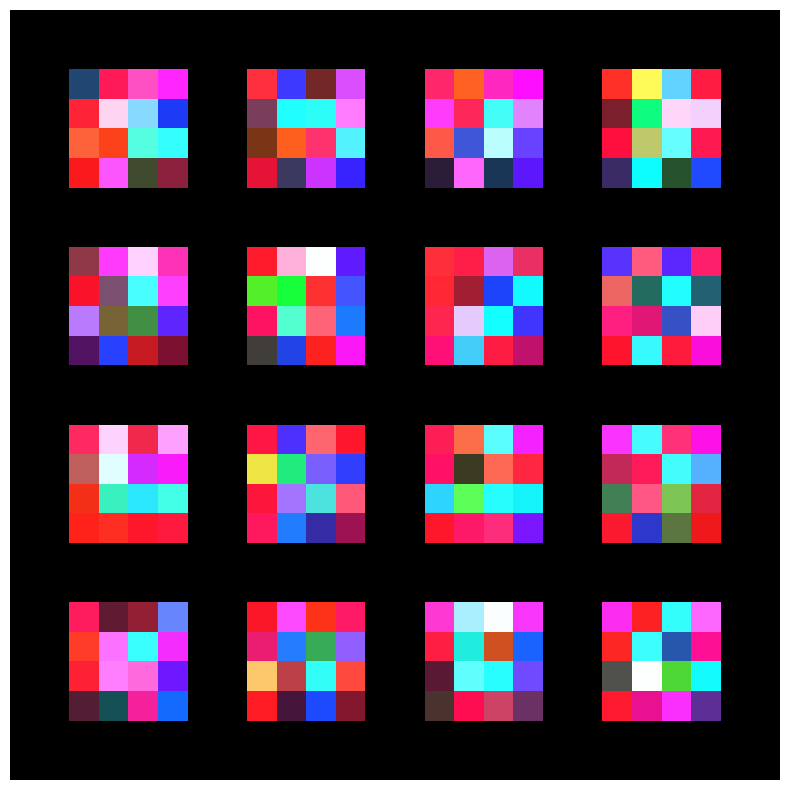

Layer 1: Loss_D: 0.7403490543365479, Loss_G: 1.921695590019226
D Grad Norm : 0.4022, G Grad Norm: 0.3772
Epoch: 52 Outputting statistics: 


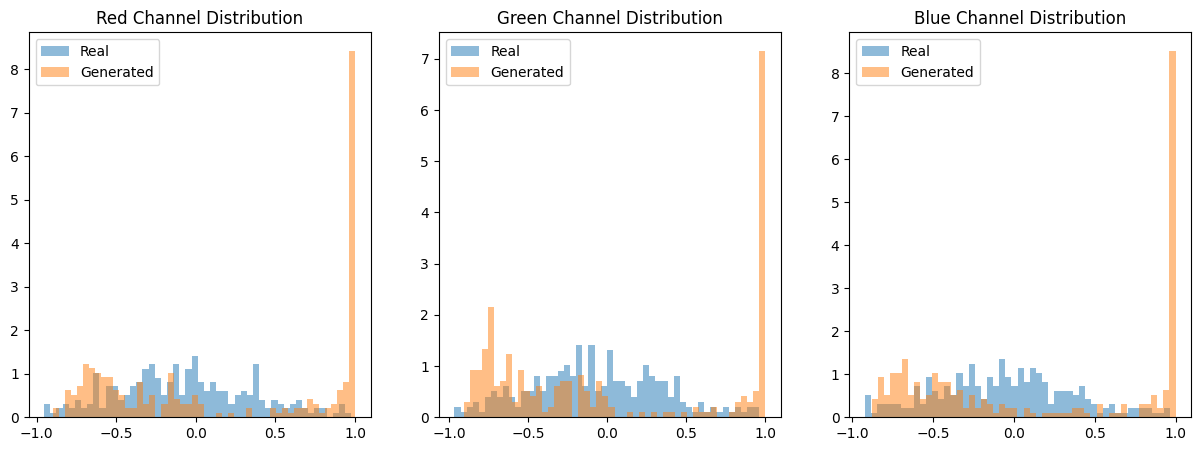

Real images - Mean: [-0.07411155 -0.07031249 -0.06632964] Std: [0.42075107 0.41486454 0.4123777 ]
Generated images - Mean: [0.19296607 0.02898164 0.14262137] Std: [0.7186926  0.7374934  0.73674035]


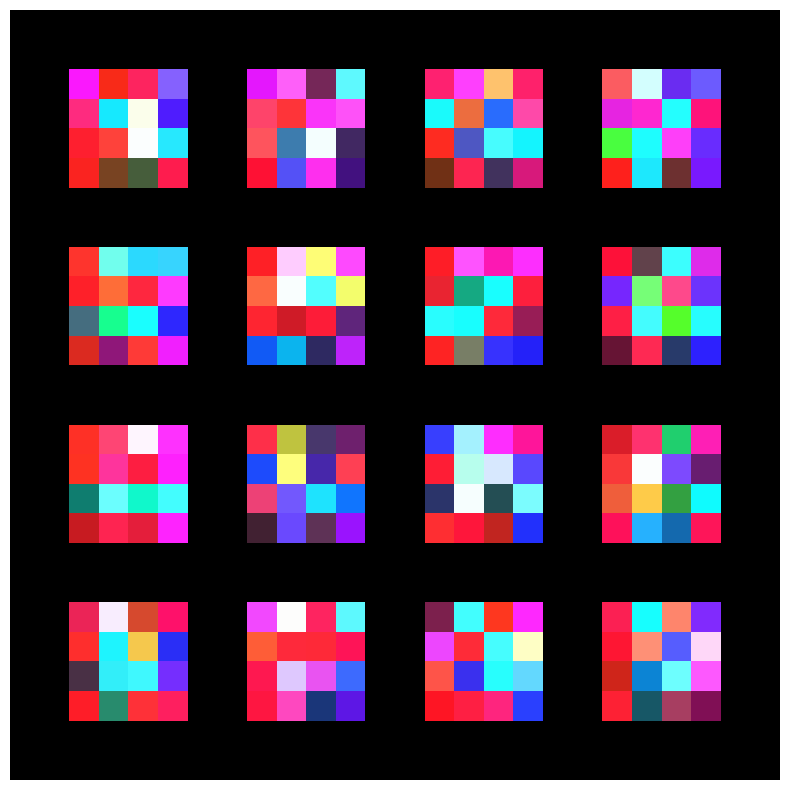

Layer 1: Loss_D: 0.769076406955719, Loss_G: -1.1295983791351318
D Grad Norm : 0.4812, G Grad Norm: 0.3195
Epoch: 53 Outputting statistics: 


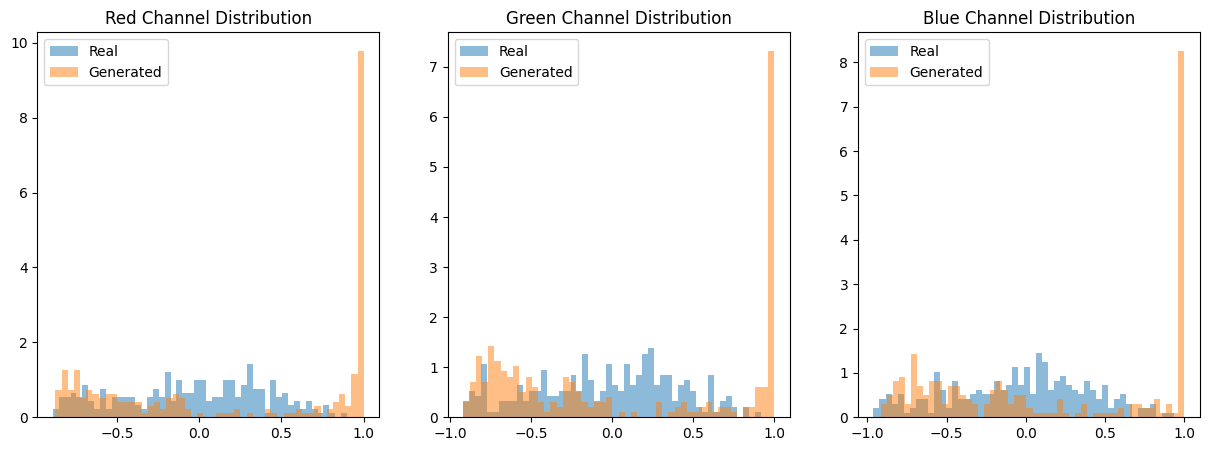

Real images - Mean: [-0.04571075 -0.03998157 -0.0428615 ] Std: [0.4382387  0.43567473 0.432913  ]
Generated images - Mean: [0.24016592 0.07186078 0.13846095] Std: [0.75362575 0.7435772  0.71848124]


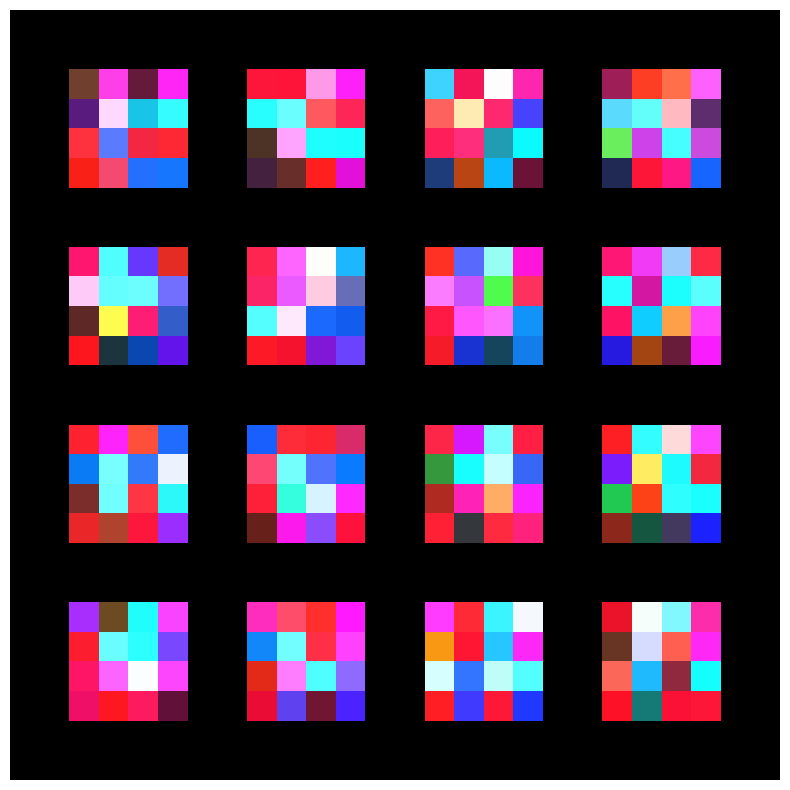

Layer 1: Loss_D: -2.350914716720581, Loss_G: 0.8829059600830078
D Grad Norm : 0.7271, G Grad Norm: 0.3144
Epoch: 54 Outputting statistics: 


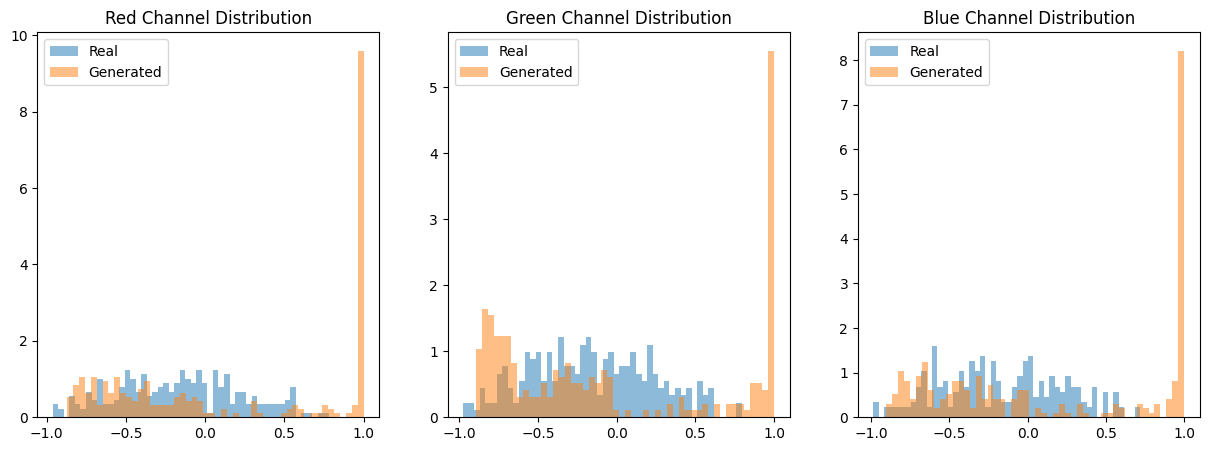

Real images - Mean: [-0.1643688  -0.16550244 -0.16587013] Std: [0.3883459  0.38852158 0.384175  ]
Generated images - Mean: [ 0.16344188 -0.04468246  0.14971158] Std: [0.7293051 0.7174742 0.7200798]


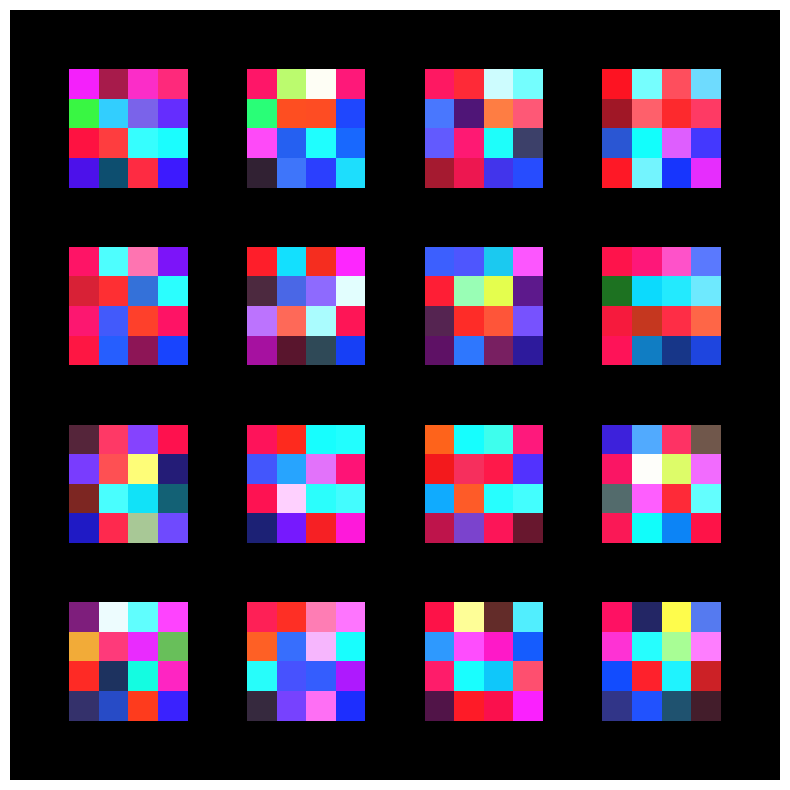

Layer 1: Loss_D: 1.0532981157302856, Loss_G: -0.1916409283876419
D Grad Norm : 0.4508, G Grad Norm: 0.2952
Epoch: 55 Outputting statistics: 


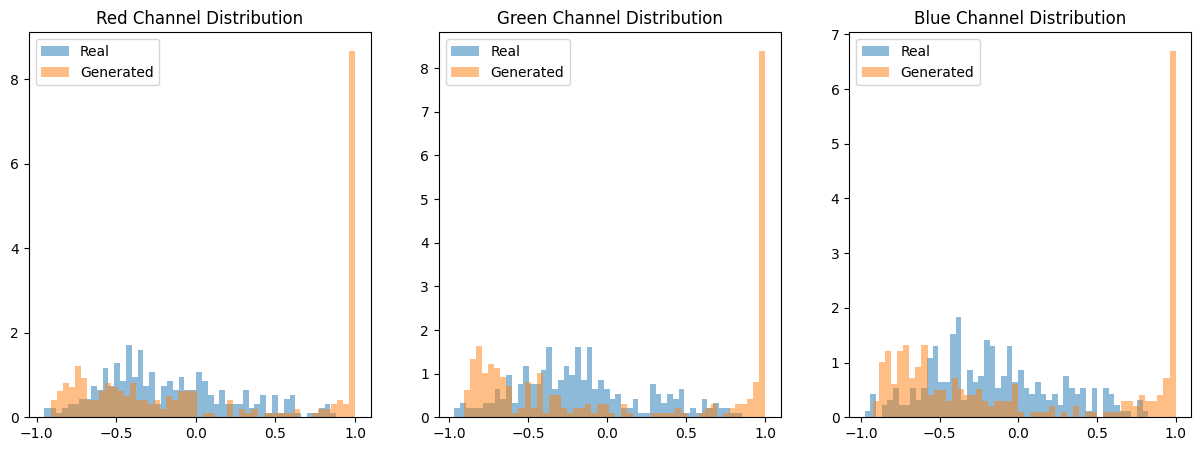

Real images - Mean: [-0.16942401 -0.17046565 -0.16464461] Std: [0.40734538 0.4054689  0.39545852]
Generated images - Mean: [0.14116251 0.10396927 0.05089045] Std: [0.73022455 0.77778727 0.74280584]


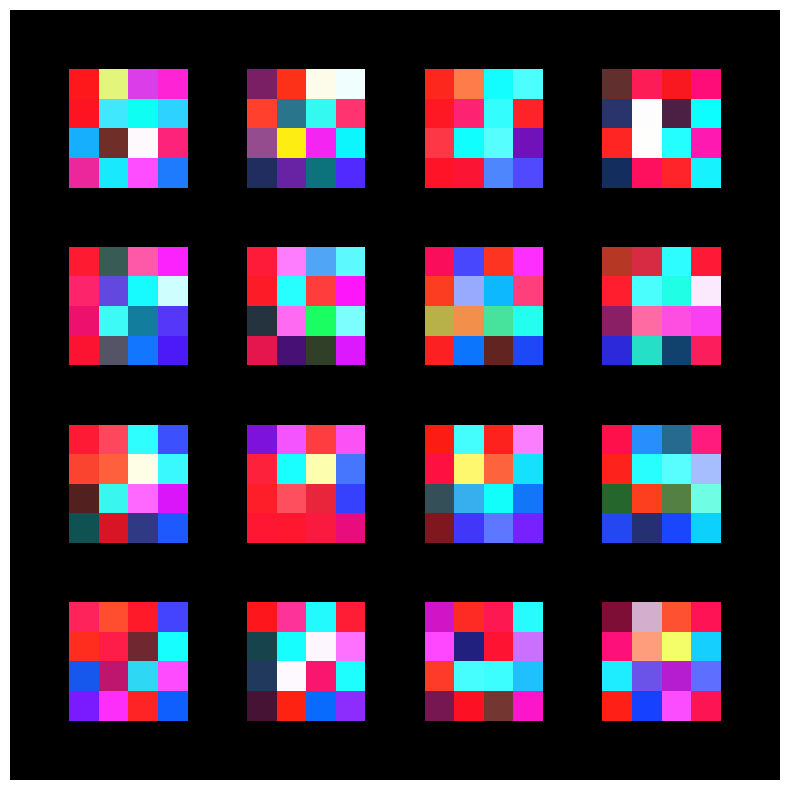

Layer 1: Loss_D: 0.3756755590438843, Loss_G: 0.798213005065918
D Grad Norm : 0.4809, G Grad Norm: 0.3308
Epoch: 56 Outputting statistics: 


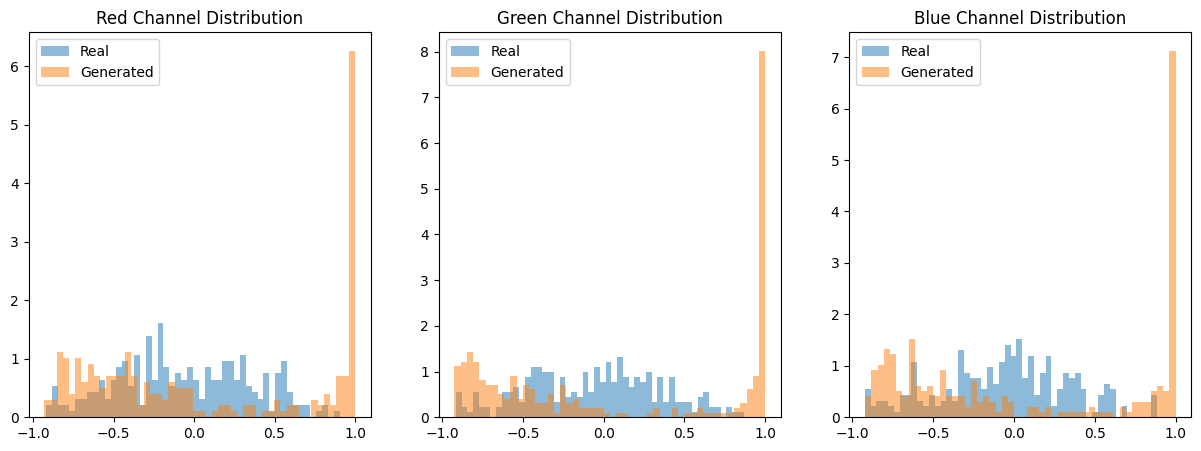

Real images - Mean: [-0.06087622 -0.06400123 -0.06139702] Std: [0.41276535 0.4028922  0.39751568]
Generated images - Mean: [0.07009887 0.08161233 0.07917678] Std: [0.71096486 0.78047633 0.7446594 ]


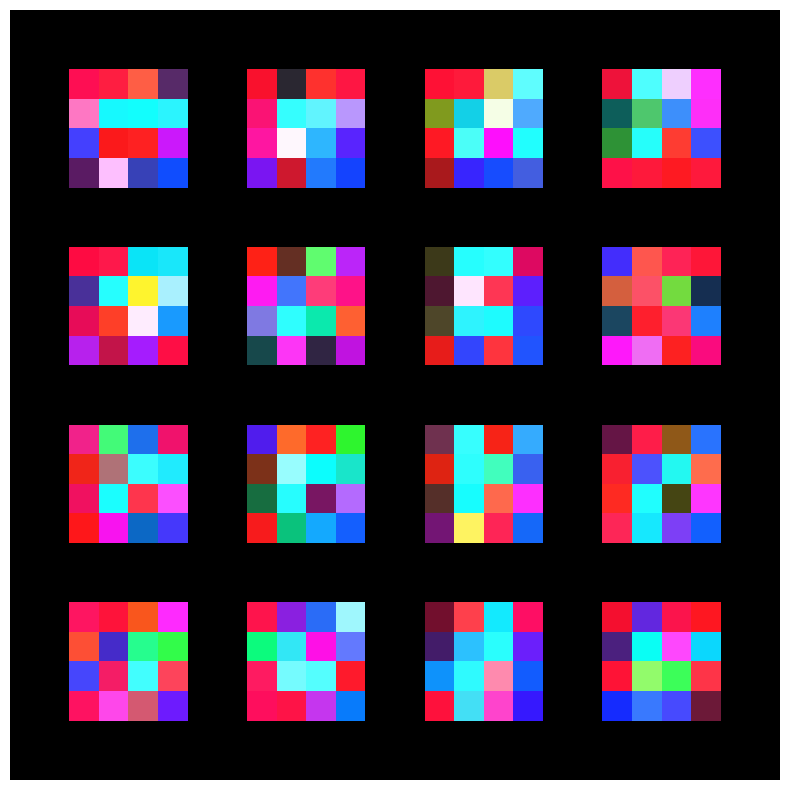

Layer 1: Loss_D: 0.6993251442909241, Loss_G: -0.05664322152733803
D Grad Norm : 0.8839, G Grad Norm: 0.4606
Epoch: 57 Outputting statistics: 


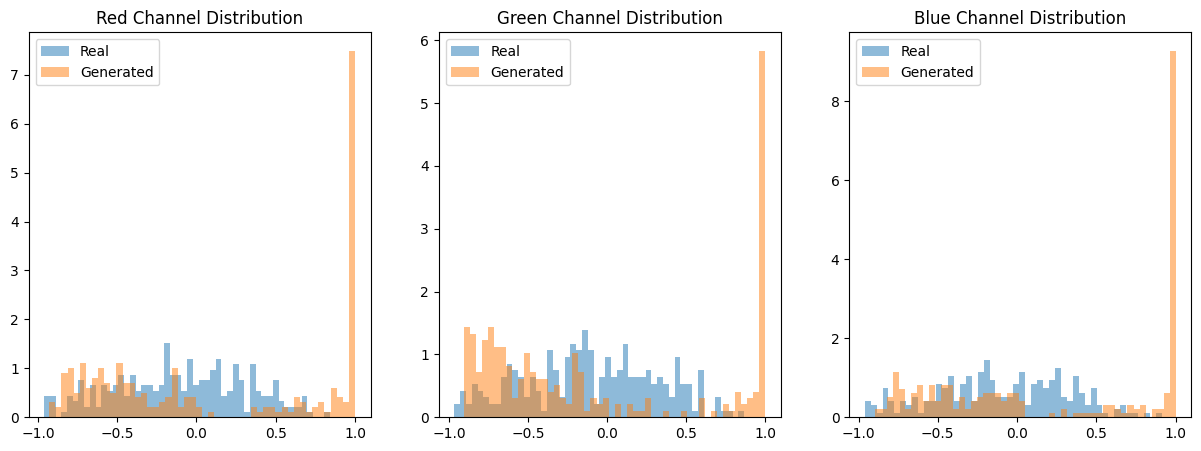

Real images - Mean: [-0.09880513 -0.10692398 -0.10294113] Std: [0.41045976 0.41796044 0.40800864]
Generated images - Mean: [ 0.11015989 -0.07747091  0.22711504] Std: [0.72791004 0.72151715 0.7013124 ]


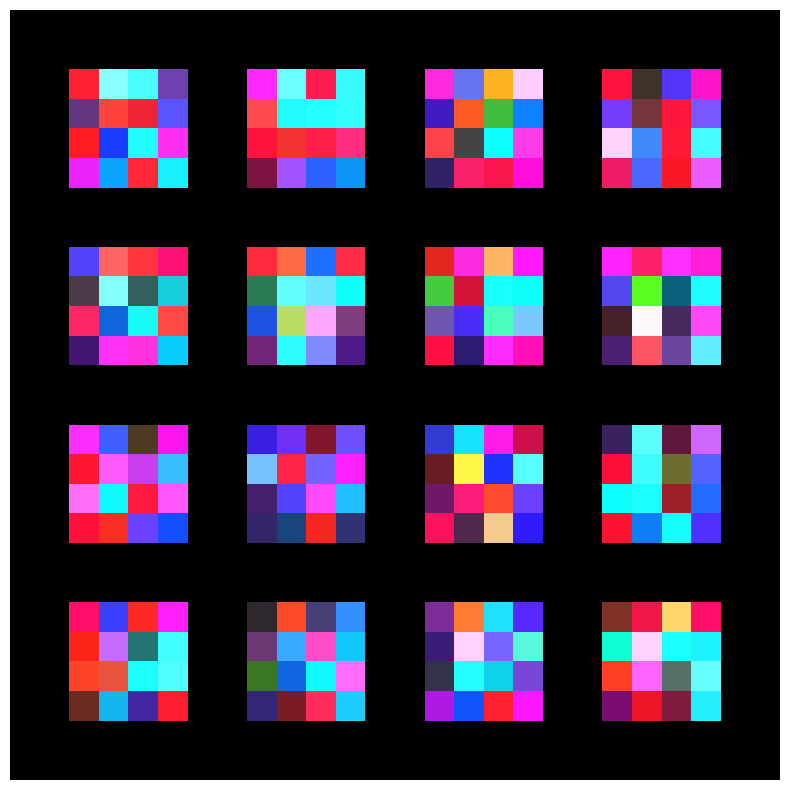

Layer 1: Loss_D: -0.016462134197354317, Loss_G: 1.289461612701416
D Grad Norm : 0.4378, G Grad Norm: 0.2620
Epoch: 58 Outputting statistics: 


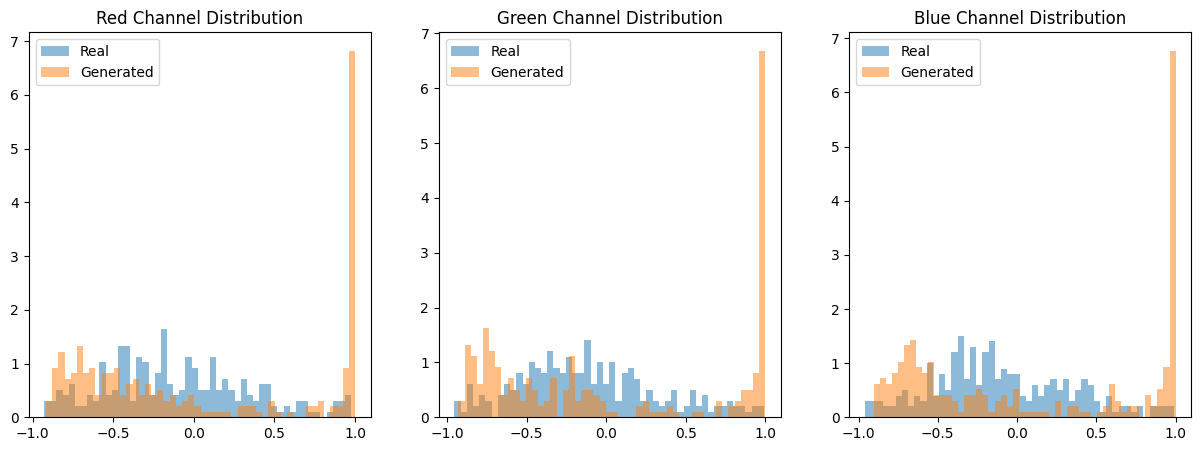

Real images - Mean: [-0.10364582 -0.11017157 -0.10499386] Std: [0.44526273 0.4345725  0.43226787]
Generated images - Mean: [0.03638693 0.0463211  0.0870607 ] Std: [0.72711265 0.7418094  0.7325219 ]


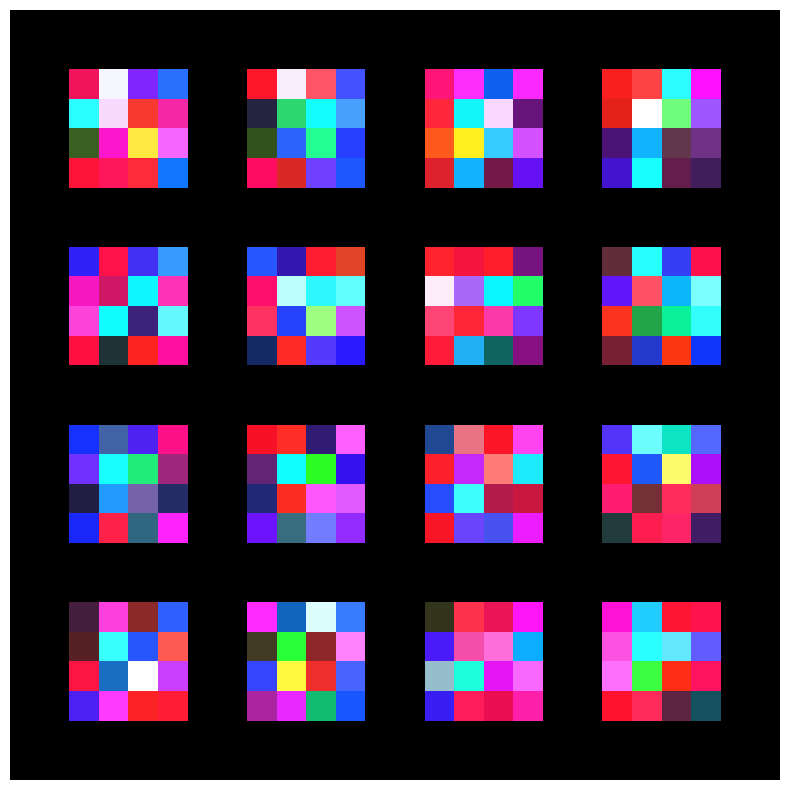

Layer 1: Loss_D: -0.5011565685272217, Loss_G: 0.5012743473052979
D Grad Norm : 0.4847, G Grad Norm: 0.2528
Epoch: 59 Outputting statistics: 


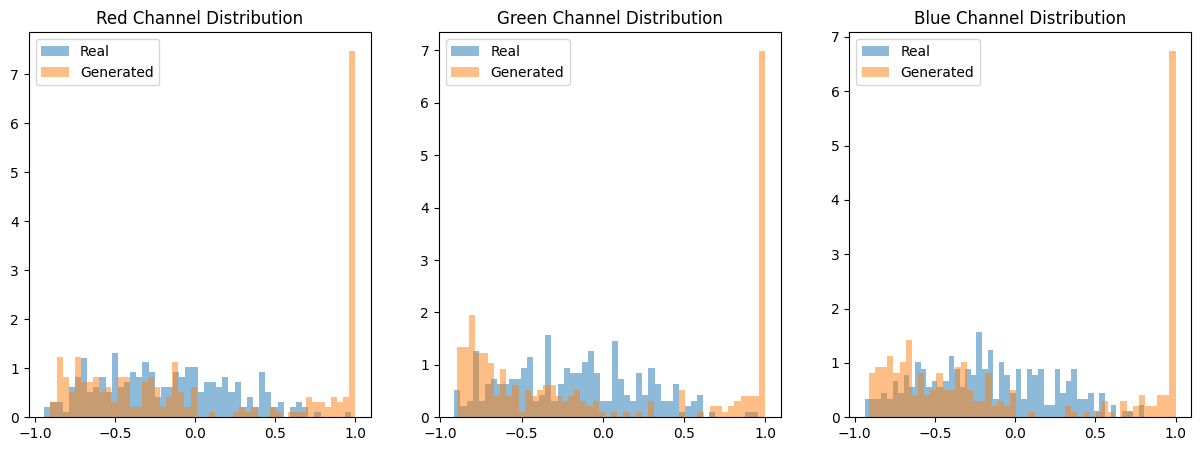

Real images - Mean: [-0.18072914 -0.18143383 -0.181679  ] Std: [0.40676987 0.40419793 0.39486668]
Generated images - Mean: [ 0.10054747 -0.0003306   0.01471088] Std: [0.7211521 0.7593412 0.7324398]


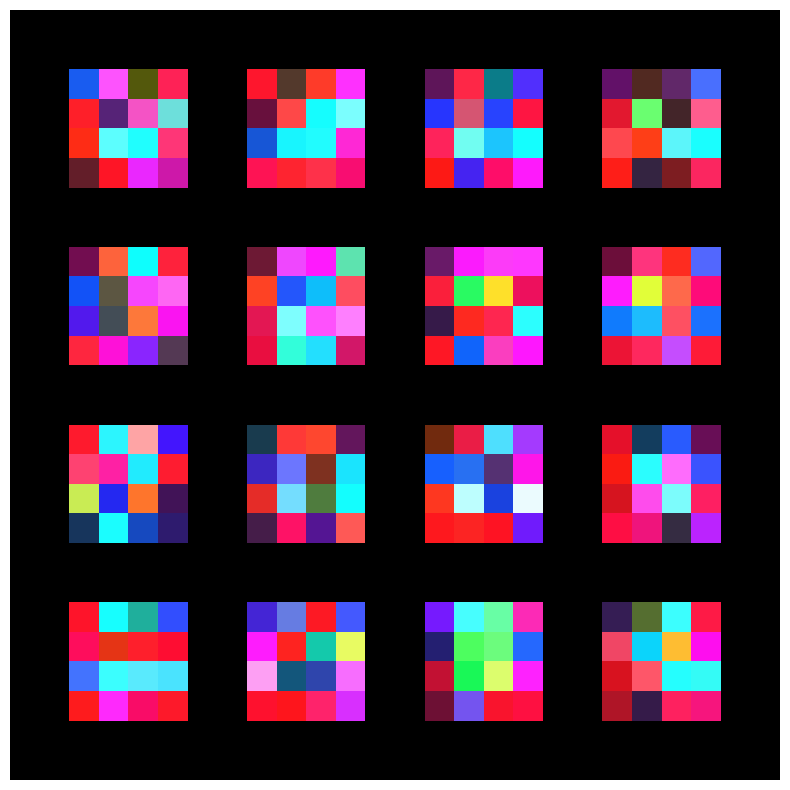

Layer 1: Loss_D: 0.6372805237770081, Loss_G: -0.17777343094348907
D Grad Norm : 0.6630, G Grad Norm: 0.2039
Epoch: 60 Outputting statistics: 


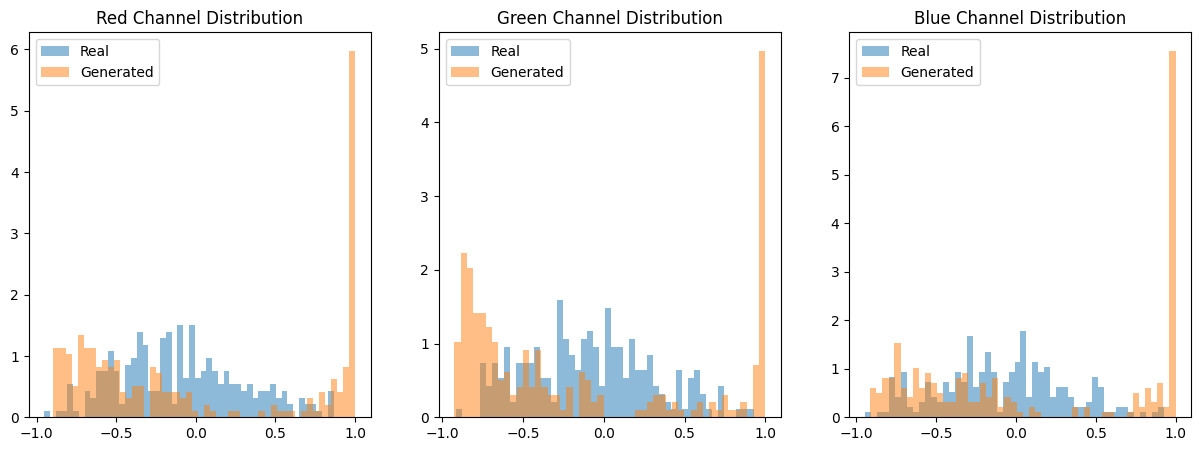

Real images - Mean: [-0.09185047 -0.08927695 -0.08593749] Std: [0.38977912 0.38758197 0.38695553]
Generated images - Mean: [ 0.00067648 -0.1481479   0.09460545] Std: [0.73187995 0.7273978  0.7338898 ]


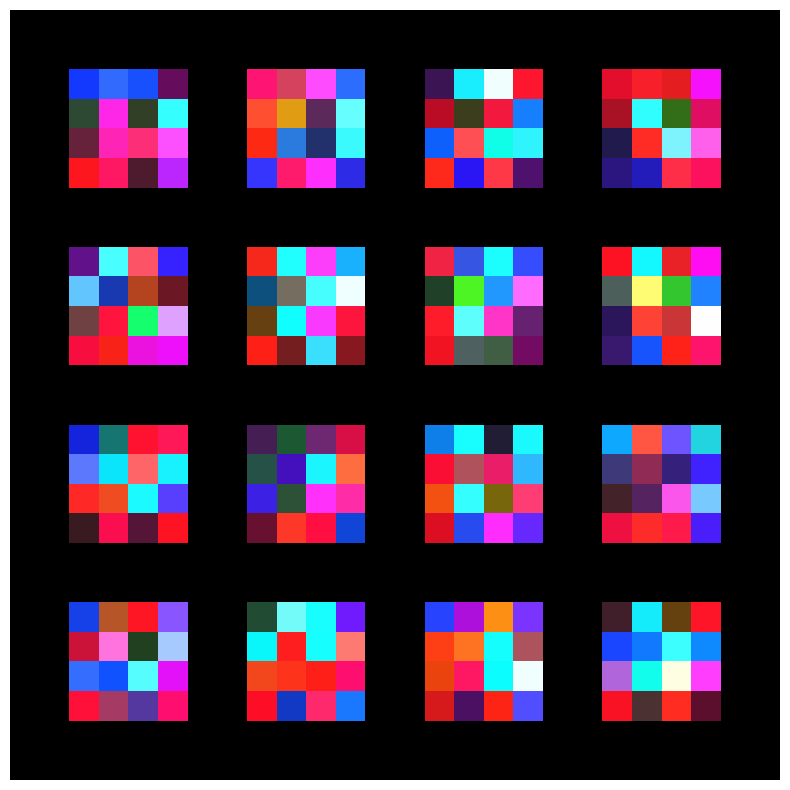

Layer 1: Loss_D: 0.4587469696998596, Loss_G: 0.42196354269981384
D Grad Norm : 0.7444, G Grad Norm: 0.2629
Epoch: 61 Outputting statistics: 


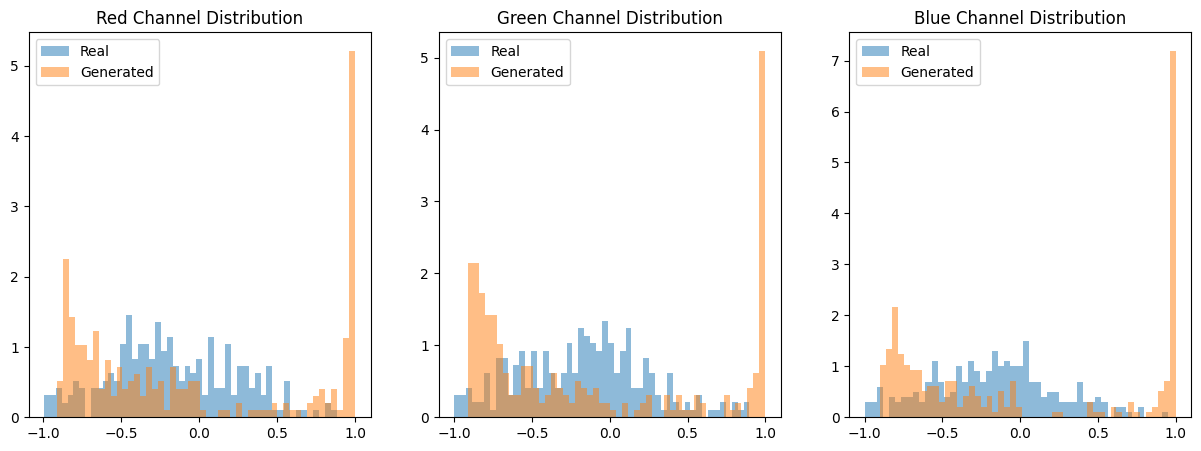

Real images - Mean: [-0.1698836  -0.17745087 -0.17270216] Std: [0.40115064 0.40581363 0.39732933]
Generated images - Mean: [-0.04107231 -0.1312645   0.00224223] Std: [0.7254154  0.7368579  0.76197124]


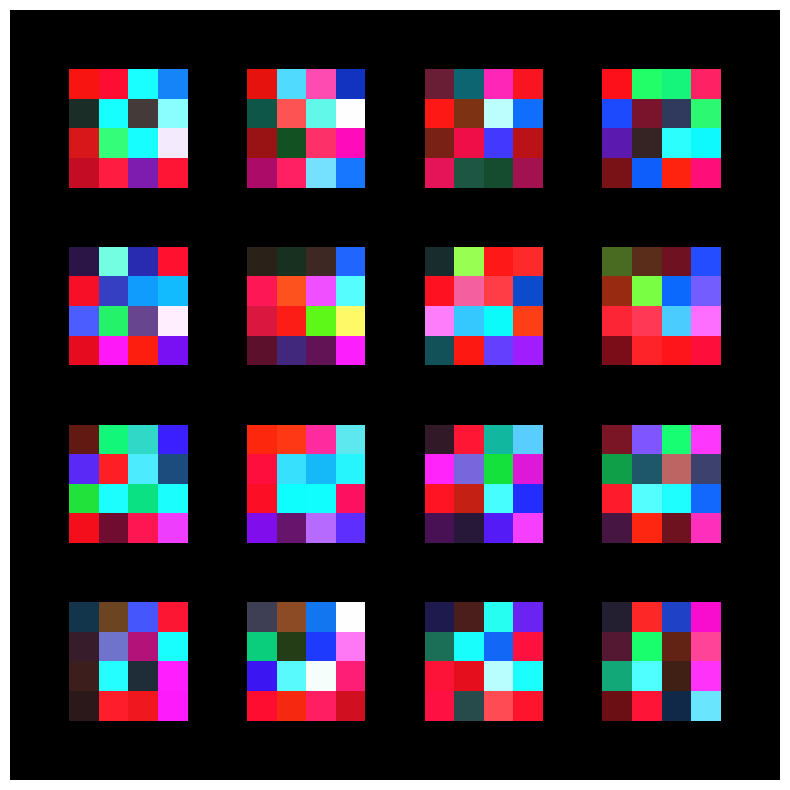

Layer 1: Loss_D: -0.26611605286598206, Loss_G: 0.7685536742210388
D Grad Norm : 0.4685, G Grad Norm: 0.2932
Epoch: 62 Outputting statistics: 


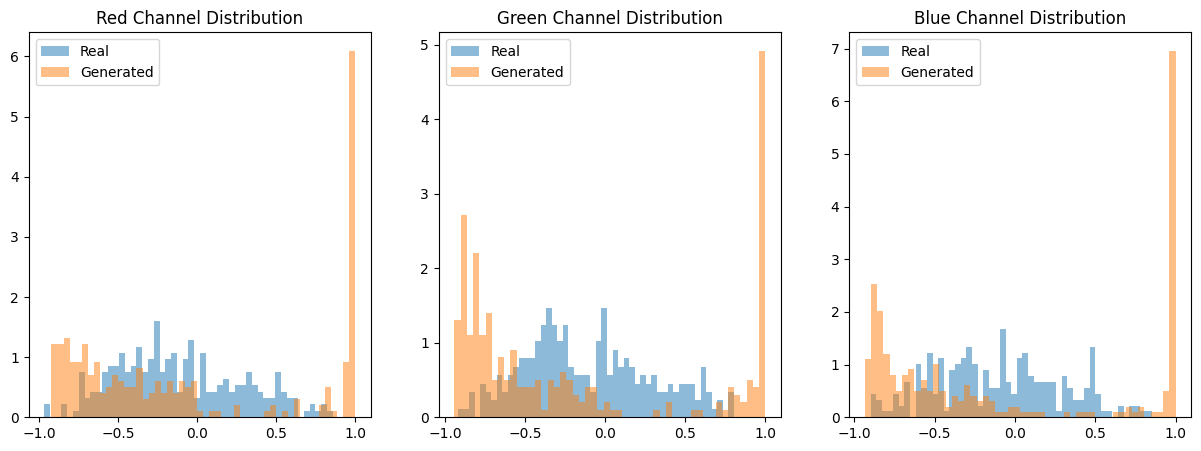

Real images - Mean: [-0.11587009 -0.11056985 -0.10462623] Std: [0.39433178 0.3944813  0.39289346]
Generated images - Mean: [-0.04299122 -0.17646958 -0.08660556] Std: [0.7303693 0.7440915 0.7736556]


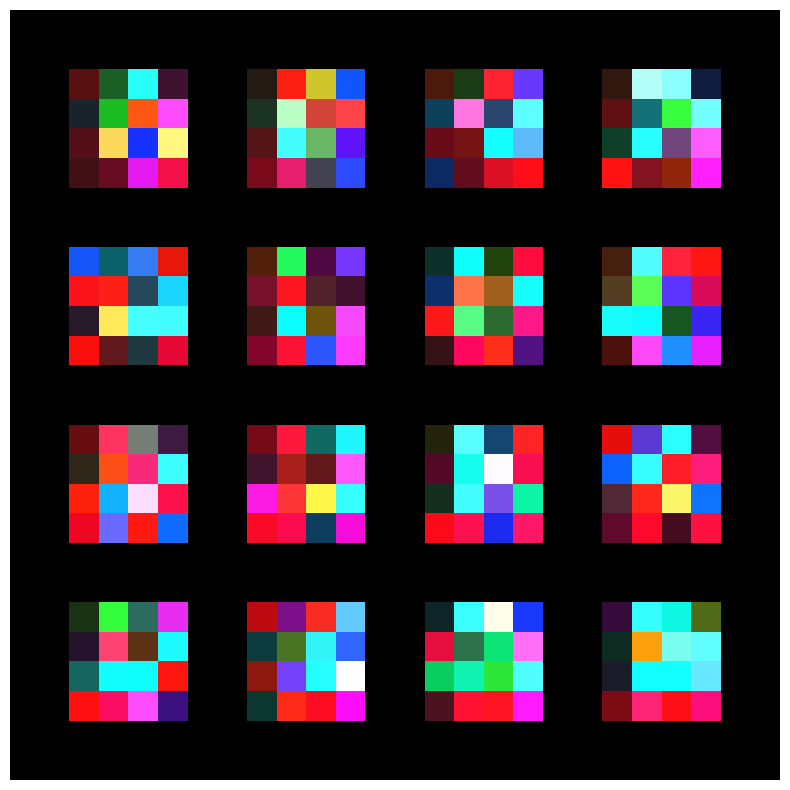

Layer 1: Loss_D: -0.34575220942497253, Loss_G: -1.3360562324523926
D Grad Norm : 0.4999, G Grad Norm: 0.2601
Epoch: 63 Outputting statistics: 


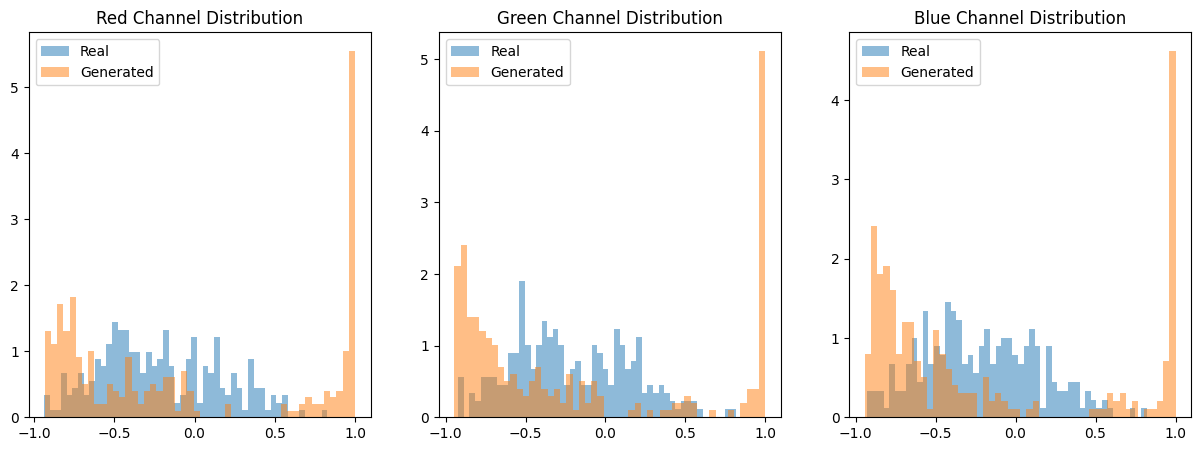

Real images - Mean: [-0.21470584 -0.21412371 -0.21559434] Std: [0.37014636 0.3627514  0.35919538]
Generated images - Mean: [-0.05208771 -0.18784867 -0.21080112] Std: [0.75523245 0.74191743 0.72999007]


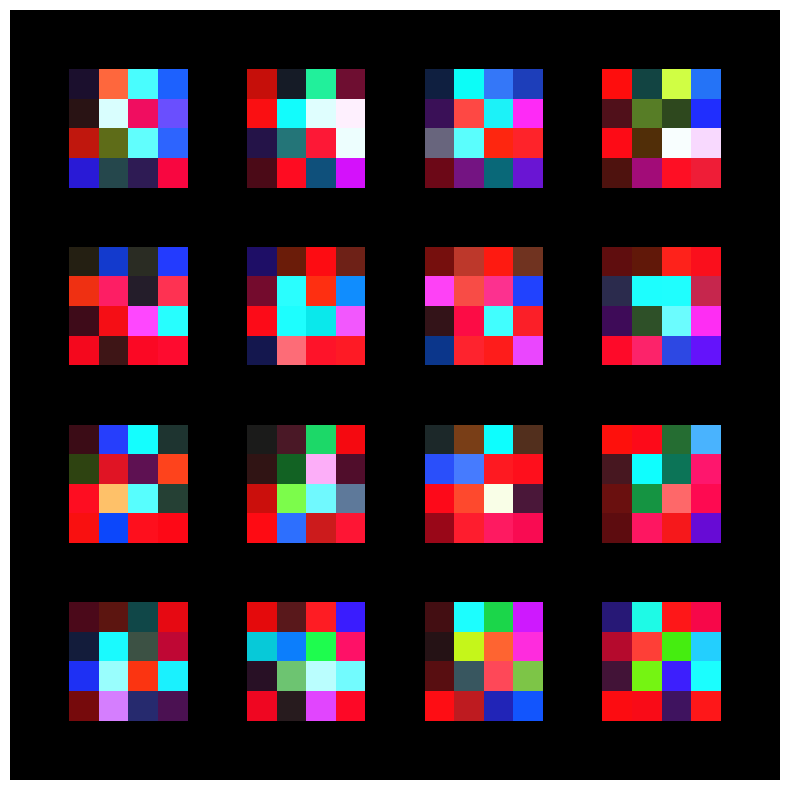

Layer 1: Loss_D: -0.910270631313324, Loss_G: 0.33499589562416077
D Grad Norm : 0.4493, G Grad Norm: 0.1479
Epoch: 64 Outputting statistics: 


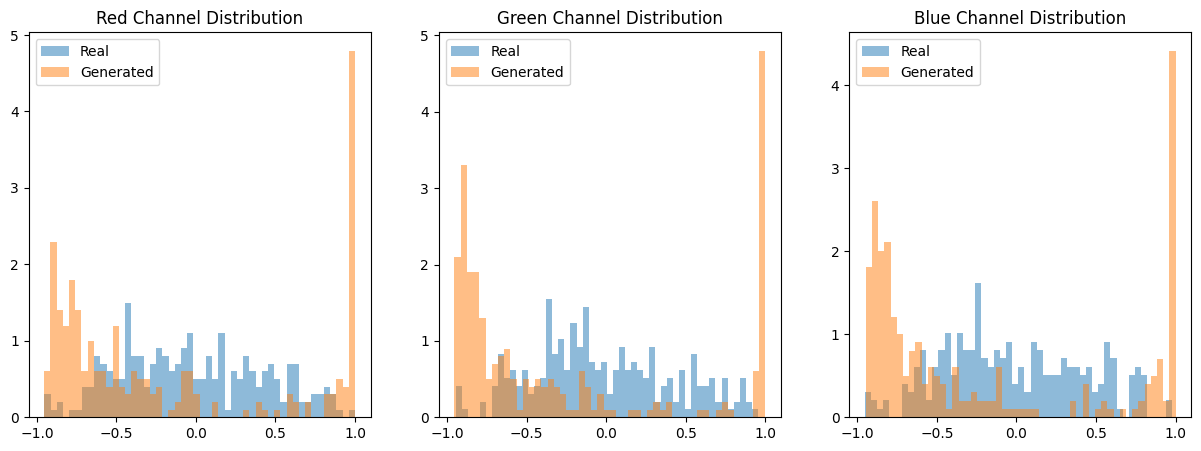

Real images - Mean: [-0.02077205 -0.02499998 -0.02487741] Std: [0.44994512 0.43931937 0.442095  ]
Generated images - Mean: [-0.16512024 -0.26382518 -0.21002202] Std: [0.7296181 0.7342045 0.7497414]


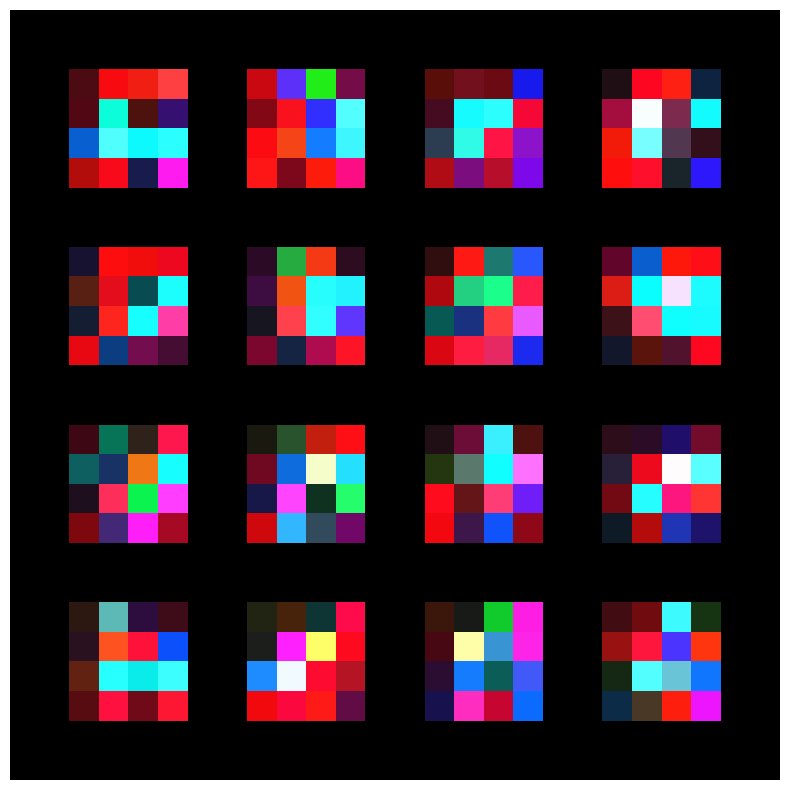

Layer 1: Loss_D: -0.8741775751113892, Loss_G: 0.47224318981170654
D Grad Norm : 0.4249, G Grad Norm: 0.4364
Epoch: 65 Outputting statistics: 


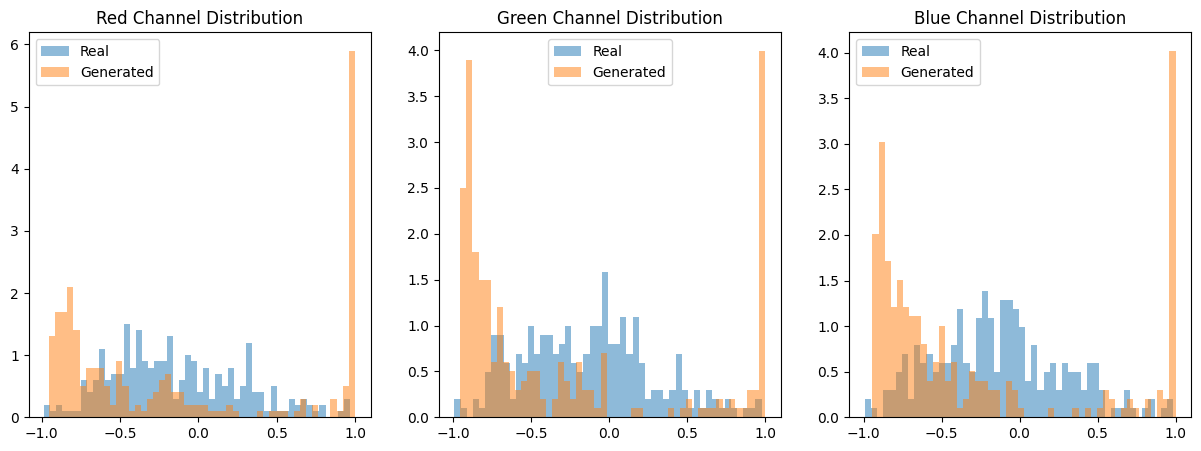

Real images - Mean: [-0.13955265 -0.13936882 -0.13658084] Std: [0.41561952 0.40988615 0.40962687]
Generated images - Mean: [-0.13244562 -0.30815196 -0.299222  ] Std: [0.75592035 0.7203763  0.69543755]


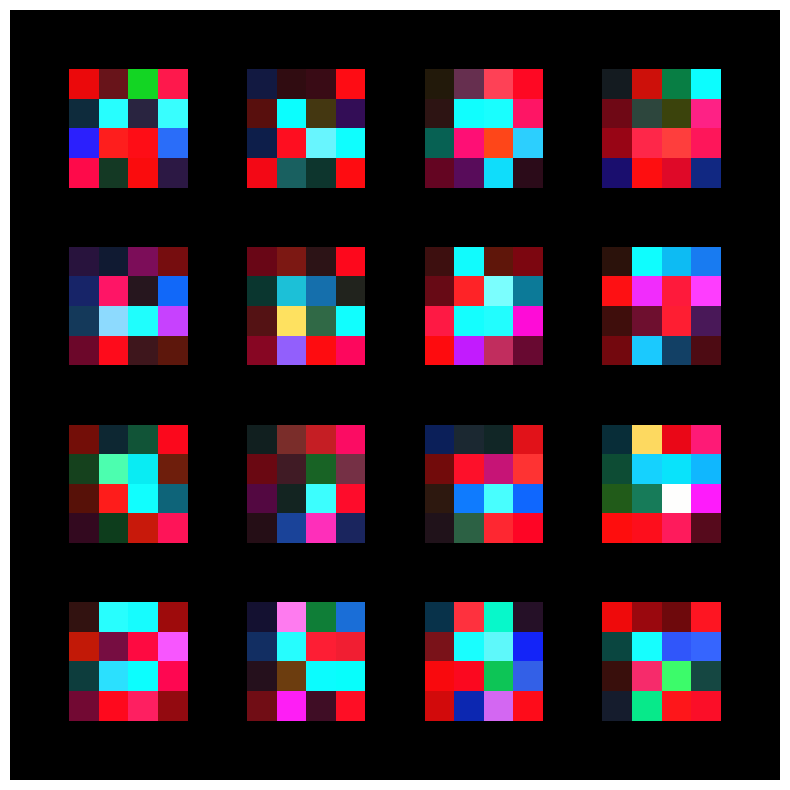

Layer 1: Loss_D: -0.6485028862953186, Loss_G: -0.4968234896659851
D Grad Norm : 0.5743, G Grad Norm: 0.3026
Epoch: 66 Outputting statistics: 


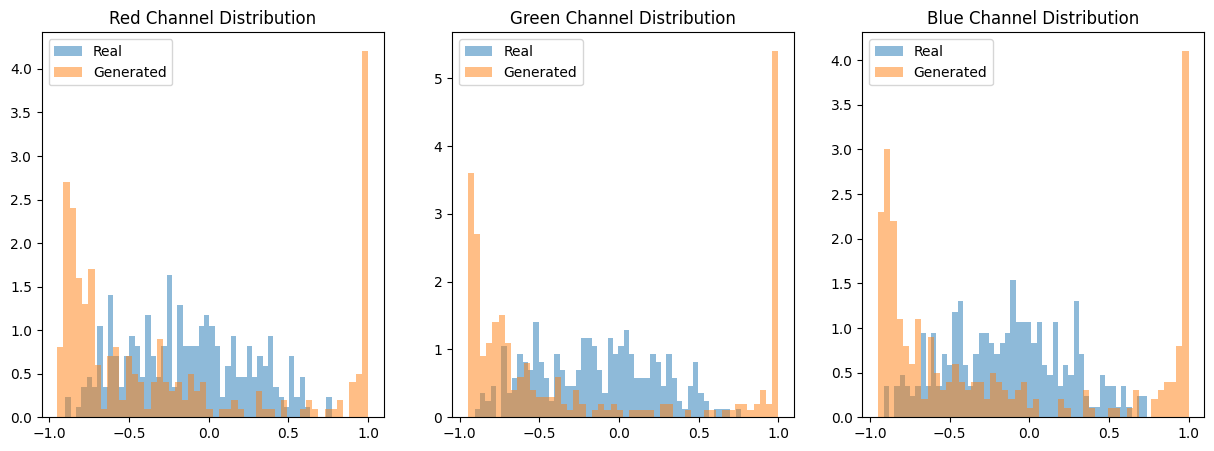

Real images - Mean: [-0.13700977 -0.1458946  -0.14405635] Std: [0.37813905 0.378548   0.3731521 ]
Generated images - Mean: [-0.22964628 -0.22308019 -0.21062696] Std: [0.7111552  0.7719776  0.74286175]


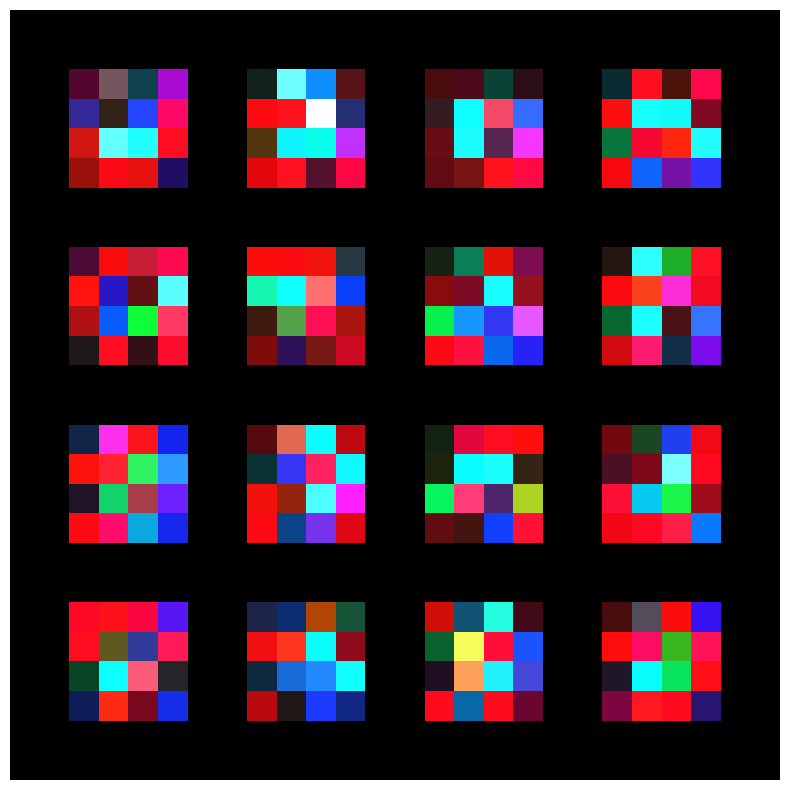

Layer 1: Loss_D: -1.3707311153411865, Loss_G: 1.1382981538772583
D Grad Norm : 0.4793, G Grad Norm: 0.3832
Epoch: 67 Outputting statistics: 


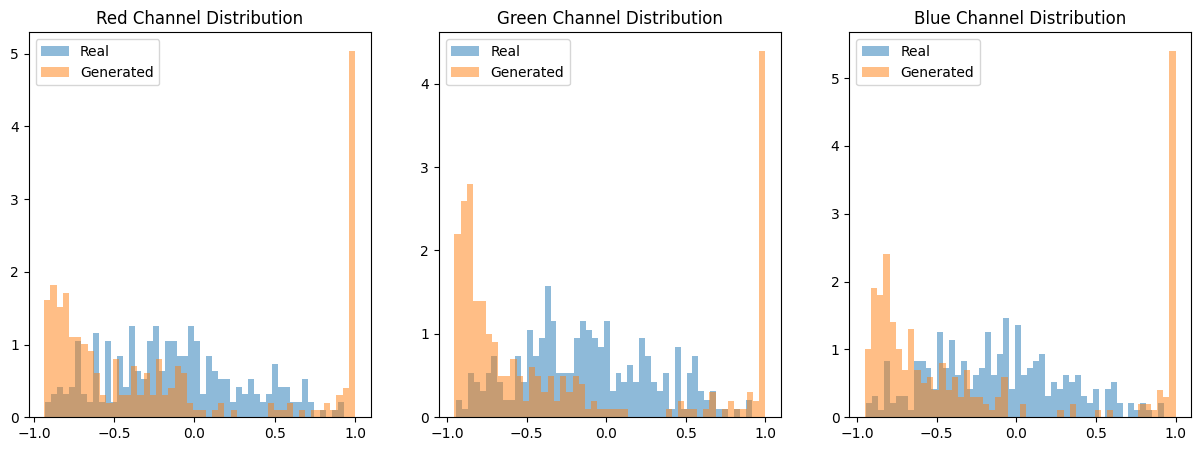

Real images - Mean: [-0.1282169  -0.12208946 -0.12340681] Std: [0.42389208 0.4166142  0.4133134 ]
Generated images - Mean: [-0.17174654 -0.28598356 -0.20573509] Std: [0.7202215 0.7250443 0.7408092]


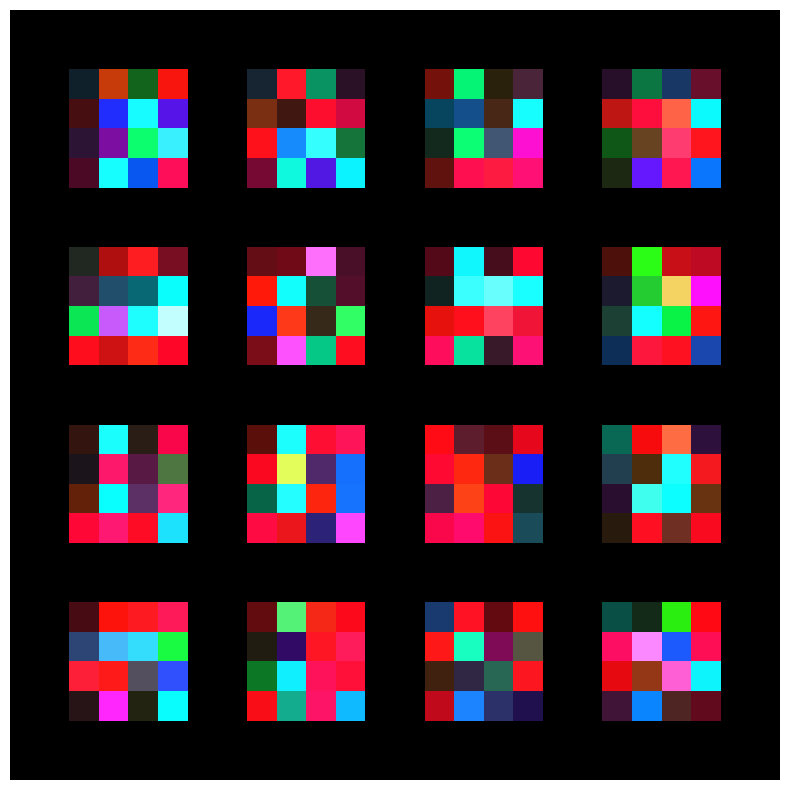

Layer 1: Loss_D: -0.3521251976490021, Loss_G: -1.3166170120239258
D Grad Norm : 0.4472, G Grad Norm: 0.2374
Epoch: 68 Outputting statistics: 


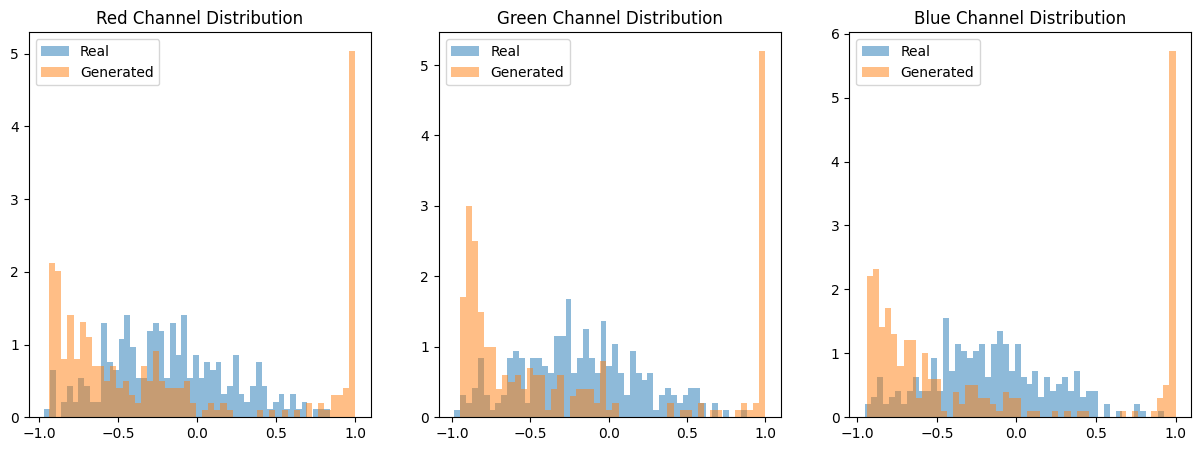

Real images - Mean: [-0.17555147 -0.17913602 -0.17242649] Std: [0.384855   0.38551465 0.3770892 ]
Generated images - Mean: [-0.16864339 -0.237804   -0.19970633] Std: [0.7224941  0.73429114 0.75410026]


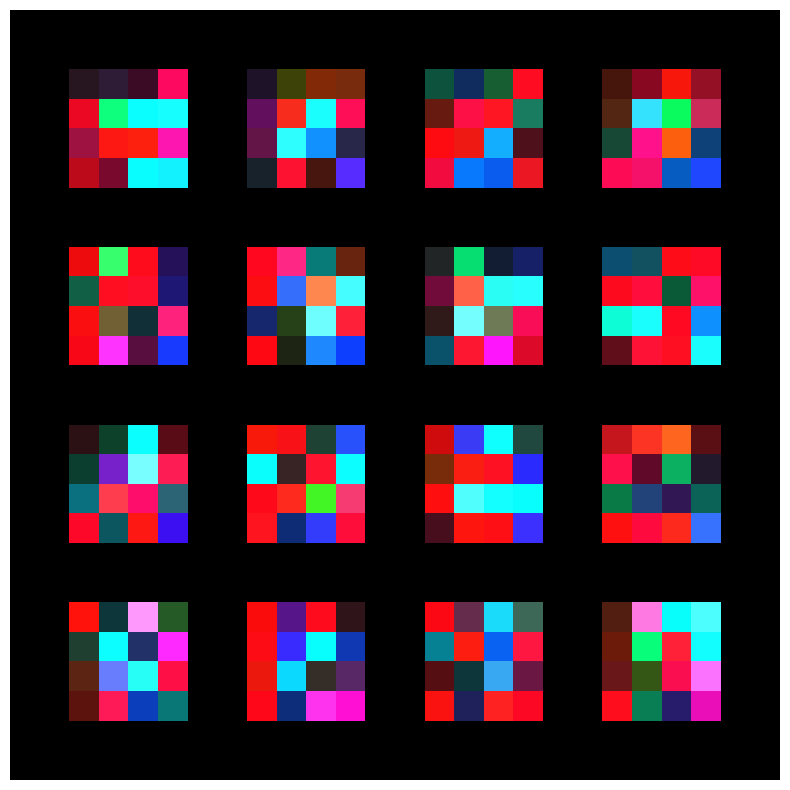

Layer 1: Loss_D: 0.5832628607749939, Loss_G: 0.3912660479545593
D Grad Norm : 0.6037, G Grad Norm: 0.1715
Epoch: 69 Outputting statistics: 


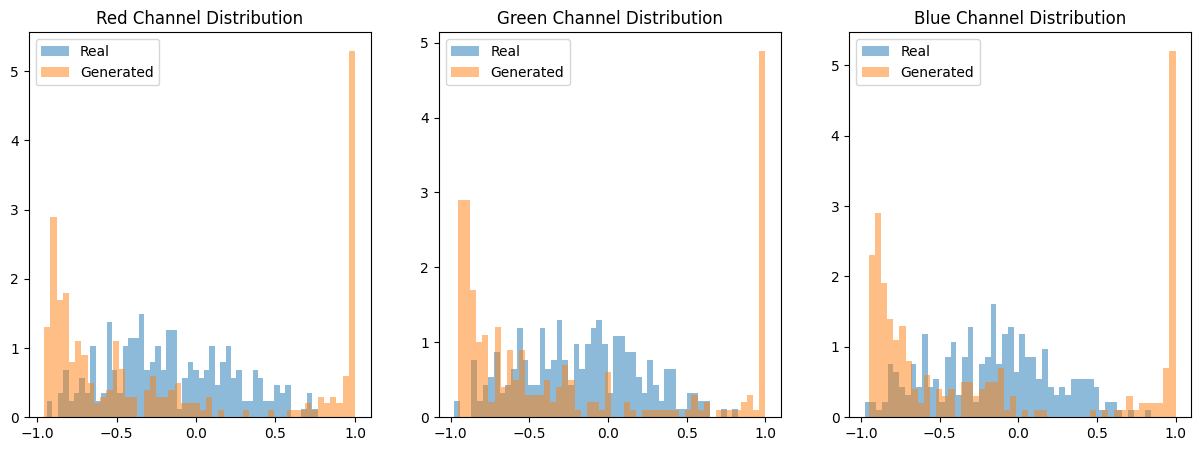

Real images - Mean: [-0.16090684 -0.17006737 -0.16553298] Std: [0.3869998  0.38232103 0.38733602]
Generated images - Mean: [-0.16187468 -0.22908887 -0.18817489] Std: [0.75975686 0.74105036 0.7649677 ]


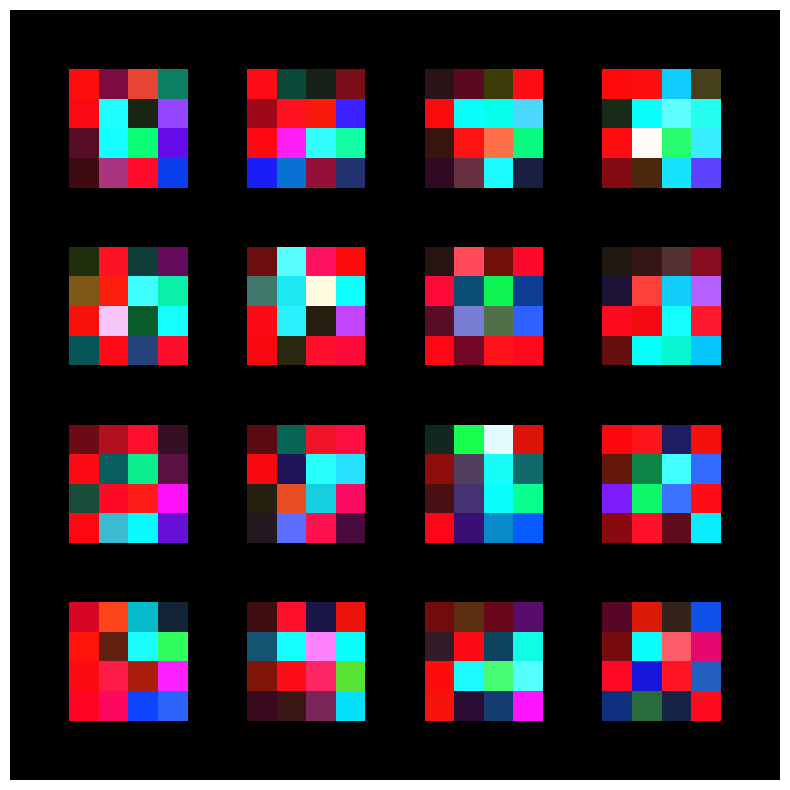

Layer 1: Loss_D: -0.07842585444450378, Loss_G: 1.0188629627227783
D Grad Norm : 0.6953, G Grad Norm: 0.2517
Epoch: 70 Outputting statistics: 


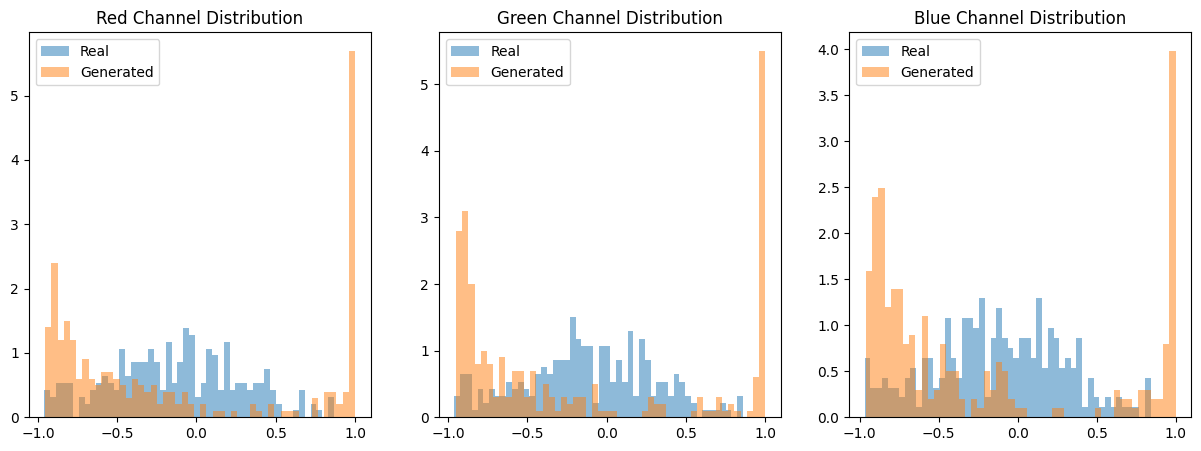

Real images - Mean: [-0.1348652  -0.12285537 -0.12910543] Std: [0.4112725  0.40844107 0.41003072]
Generated images - Mean: [-0.12589915 -0.18425354 -0.24328768] Std: [0.7571427  0.77313364 0.734175  ]


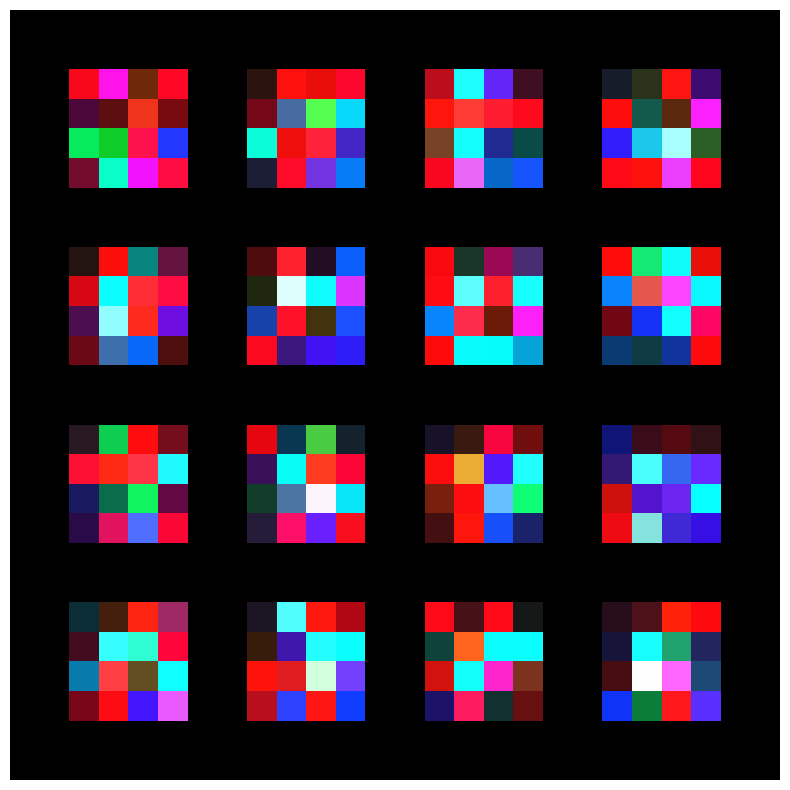

Layer 1: Loss_D: 1.2174851894378662, Loss_G: 0.05687557905912399
D Grad Norm : 0.4421, G Grad Norm: 0.2102
Epoch: 71 Outputting statistics: 


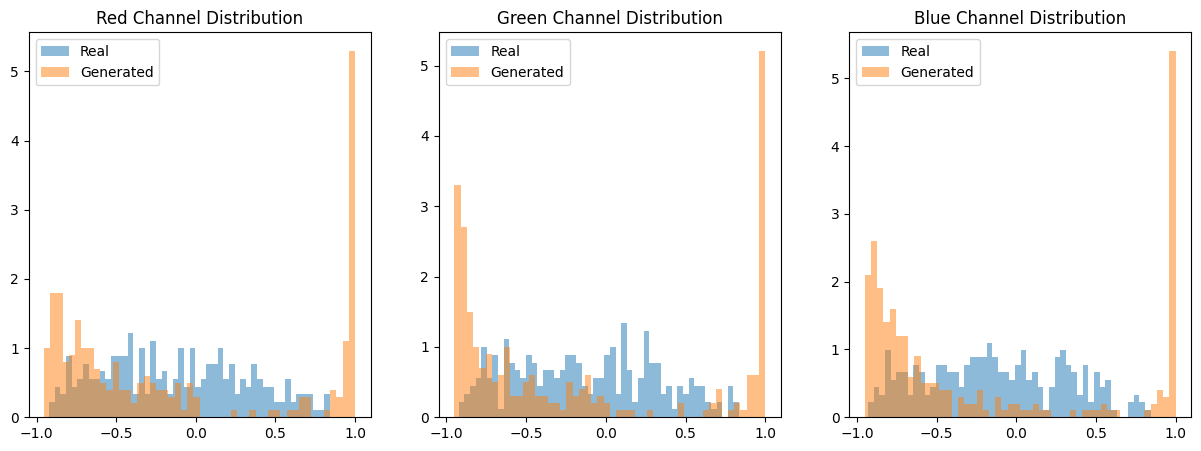

Real images - Mean: [-0.13051468 -0.13060662 -0.12990193] Std: [0.44504014 0.44517988 0.43520933]
Generated images - Mean: [-0.10532571 -0.1734884  -0.22414052] Std: [0.75330096 0.7722286  0.76053196]


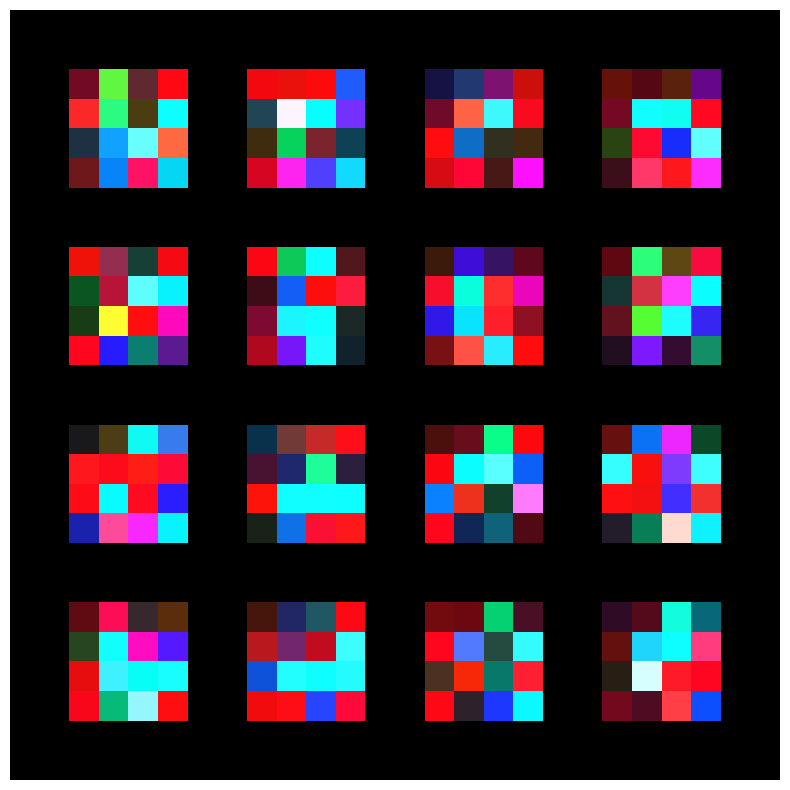

Layer 1: Loss_D: -0.633413553237915, Loss_G: 0.11231303215026855
D Grad Norm : 0.4887, G Grad Norm: 0.2371
Epoch: 72 Outputting statistics: 


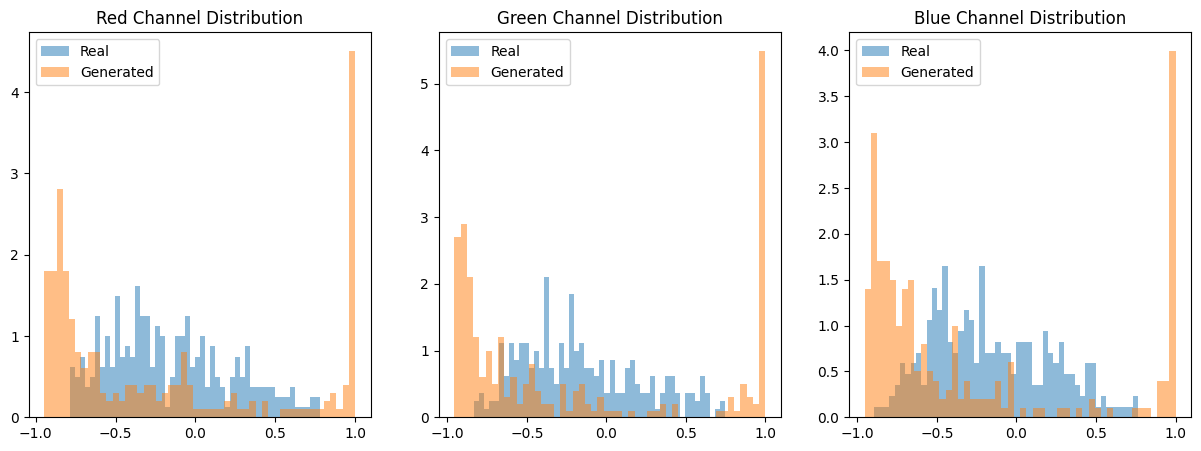

Real images - Mean: [-0.15934435 -0.16167283 -0.1628983 ] Std: [0.38187957 0.37416756 0.37015814]
Generated images - Mean: [-0.20694214 -0.20054692 -0.3047095 ] Std: [0.72398156 0.7723405  0.6998109 ]


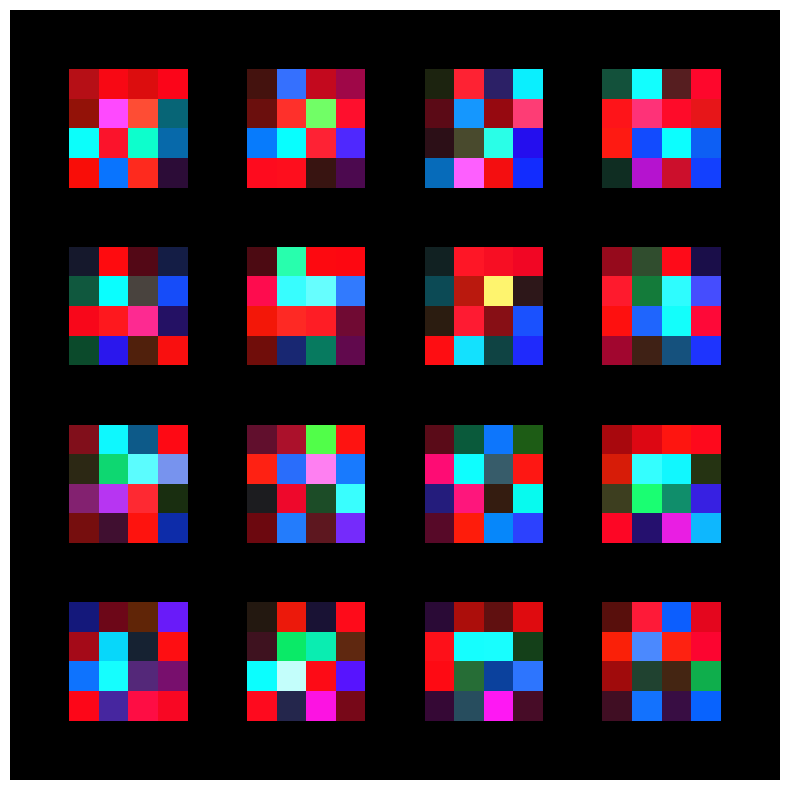

Layer 1: Loss_D: -1.0056936740875244, Loss_G: 1.0692743062973022
D Grad Norm : 0.5626, G Grad Norm: 0.3394
Epoch: 73 Outputting statistics: 


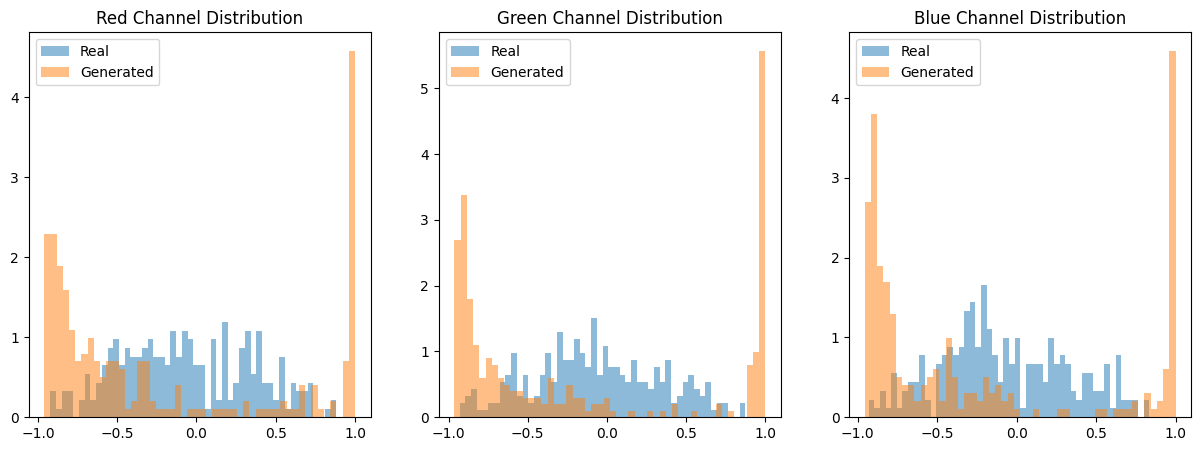

Real images - Mean: [-0.06605389 -0.07374388 -0.07971814] Std: [0.41578174 0.40321076 0.40316638]
Generated images - Mean: [-0.22332084 -0.17199352 -0.26594186] Std: [0.7471663  0.79723895 0.747775  ]


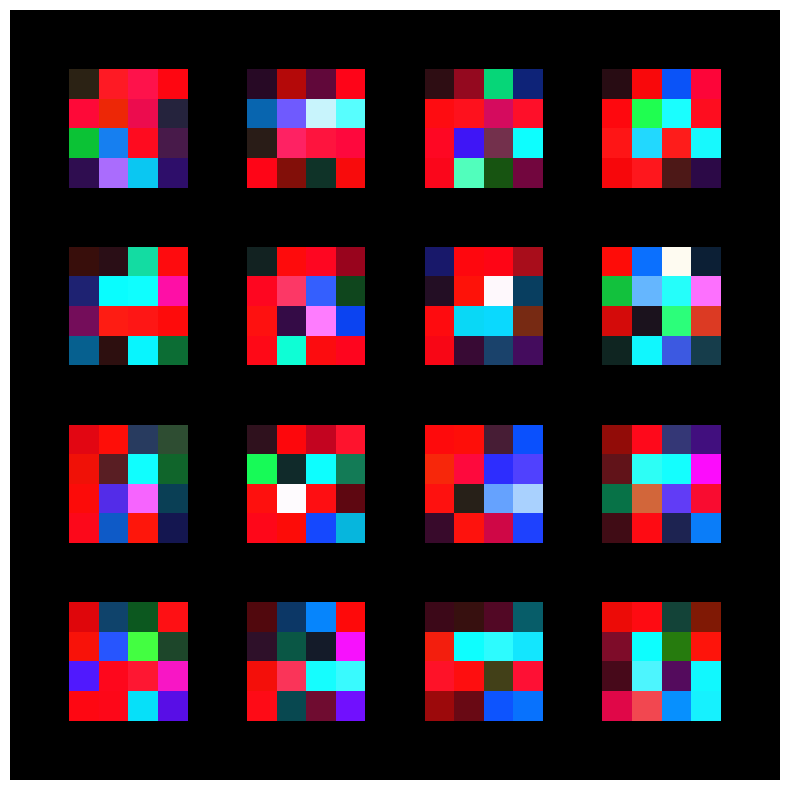

Layer 1: Loss_D: -1.3702260255813599, Loss_G: -0.7229957580566406
D Grad Norm : 0.4134, G Grad Norm: 0.2131
Epoch: 74 Outputting statistics: 


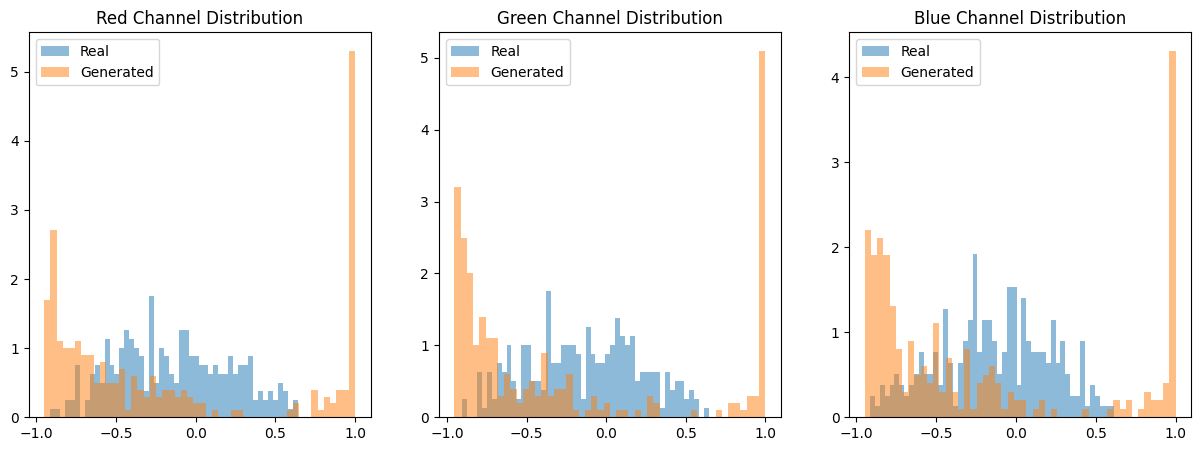

Real images - Mean: [-0.14132959 -0.13976714 -0.141636  ] Std: [0.35748908 0.35696632 0.3454846 ]
Generated images - Mean: [-0.15793549 -0.251042   -0.24167635] Std: [0.74718916 0.75116193 0.7129713 ]


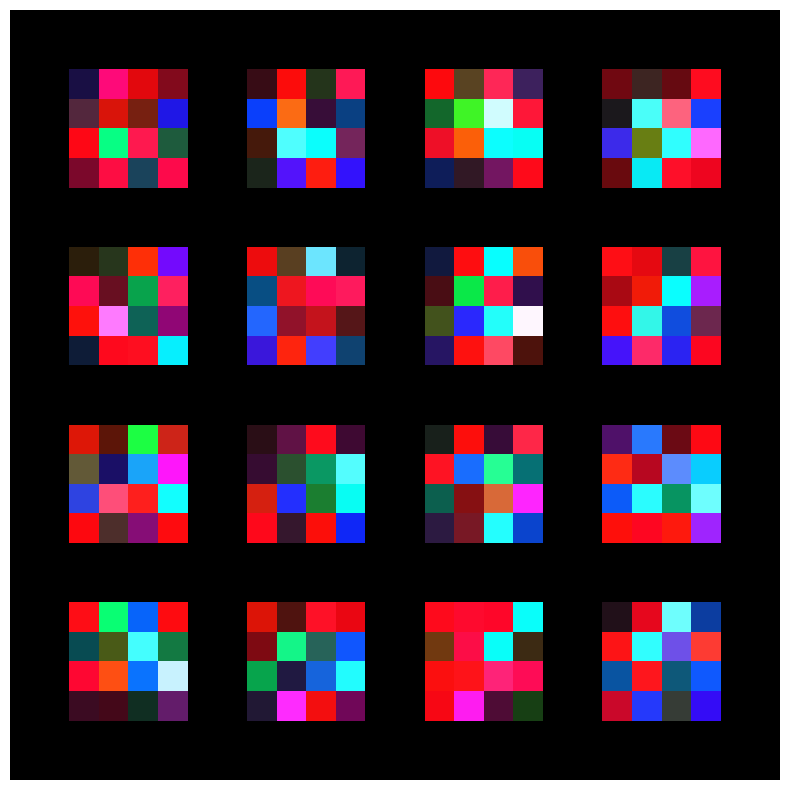

Layer 1: Loss_D: 0.8489206433296204, Loss_G: 0.6336261630058289
D Grad Norm : 0.7248, G Grad Norm: 0.2660
Epoch: 75 Outputting statistics: 


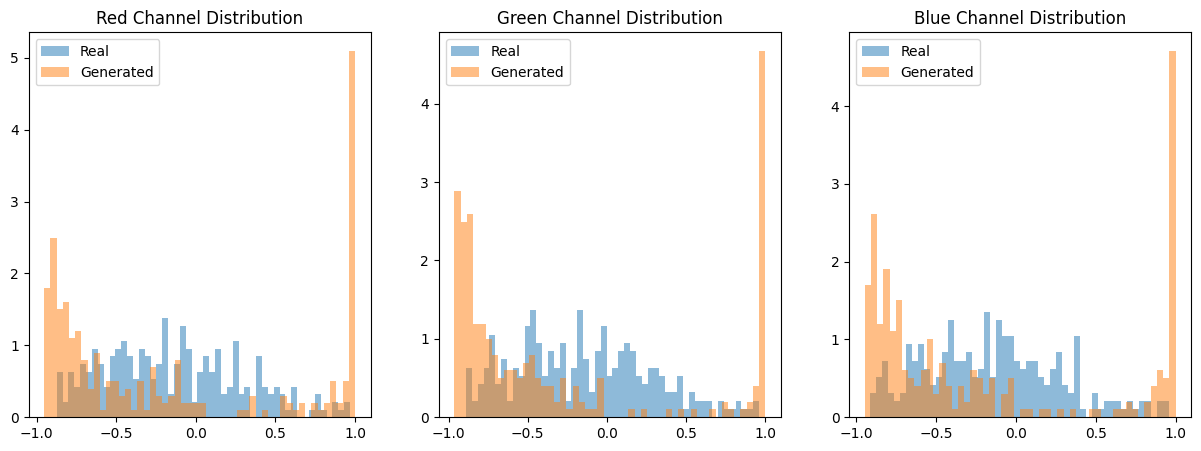

Real images - Mean: [-0.14522061 -0.14494485 -0.14620091] Std: [0.4282928  0.42805177 0.42509386]
Generated images - Mean: [-0.15625012 -0.2987604  -0.18991031] Std: [0.7577391  0.7337342  0.74377155]


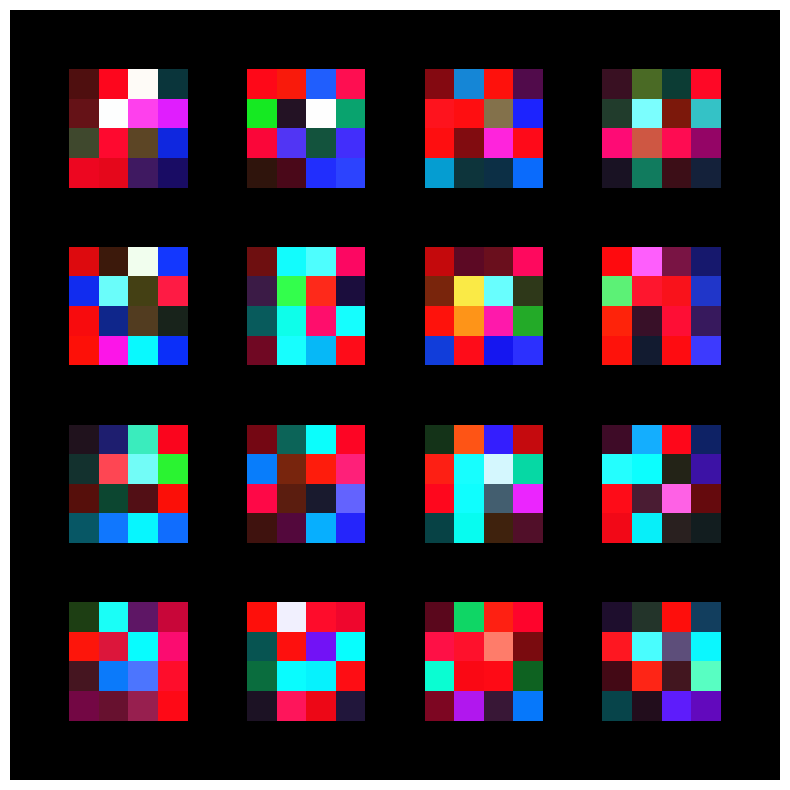

Layer 1: Loss_D: 0.5041046738624573, Loss_G: 1.2608805894851685
D Grad Norm : 0.4449, G Grad Norm: 0.2128
Epoch: 76 Outputting statistics: 


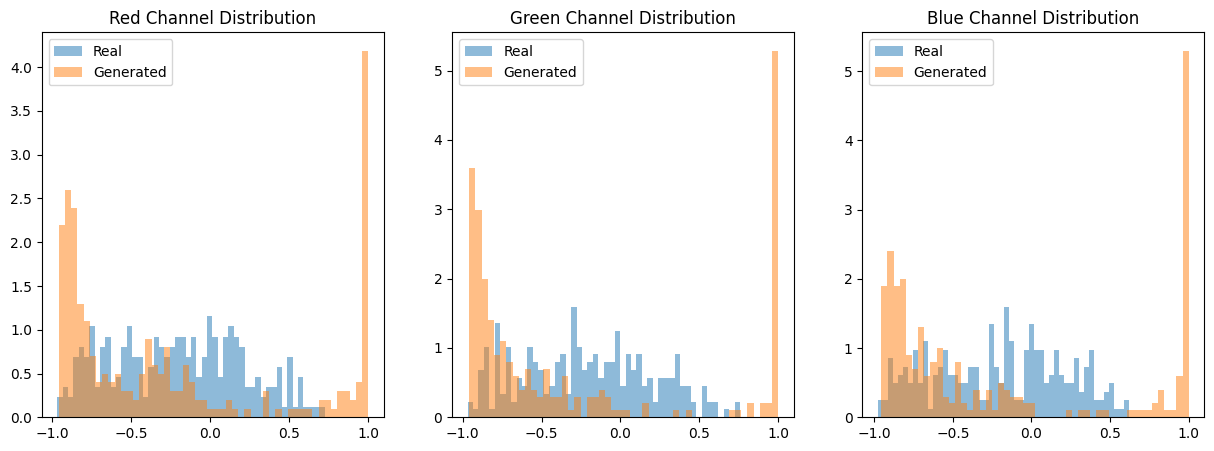

Real images - Mean: [-0.20643377 -0.20949748 -0.20631136] Std: [0.41064733 0.41037253 0.410541  ]
Generated images - Mean: [-0.22941552 -0.29159474 -0.20069893] Std: [0.7234282  0.7529614  0.76253855]


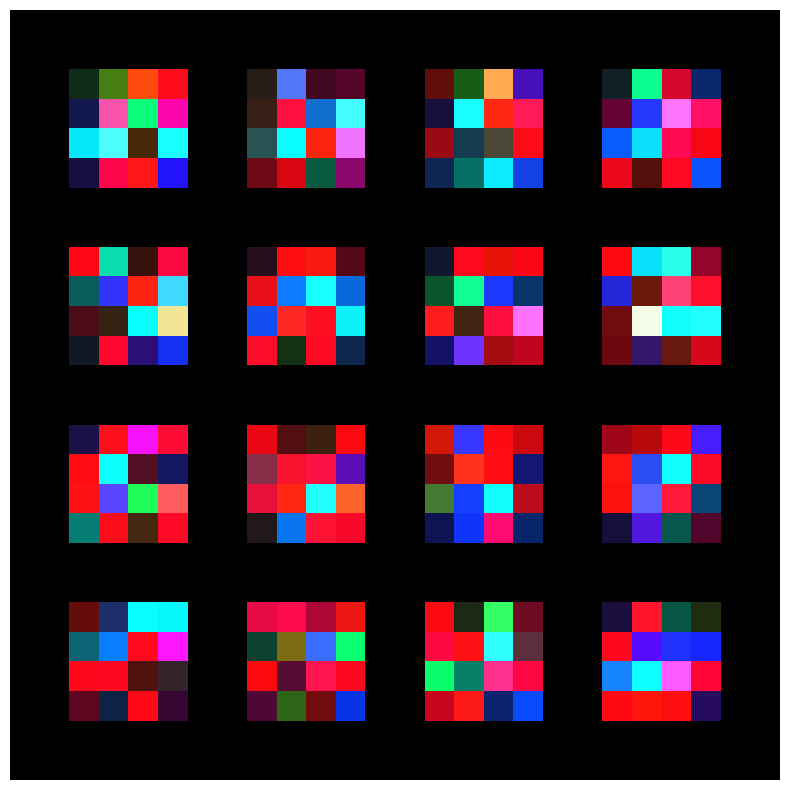

Layer 1: Loss_D: -0.37832048535346985, Loss_G: -0.5888205766677856
D Grad Norm : 0.7252, G Grad Norm: 0.2584
Epoch: 77 Outputting statistics: 


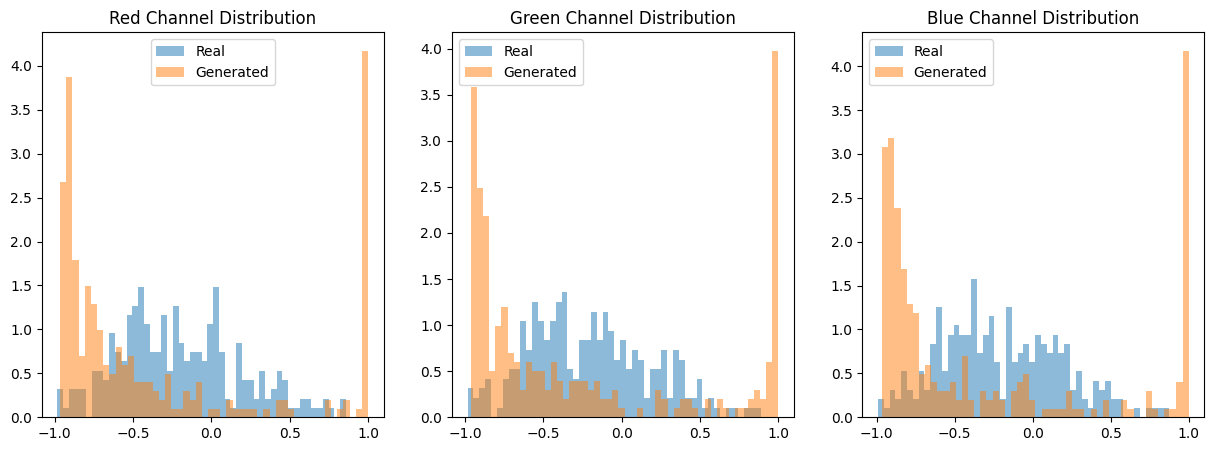

Real images - Mean: [-0.20321691 -0.202114   -0.20291053] Std: [0.39372477 0.38937306 0.38305673]
Generated images - Mean: [-0.3475343  -0.26656213 -0.31662518] Std: [0.70422864 0.7342926  0.72966796]


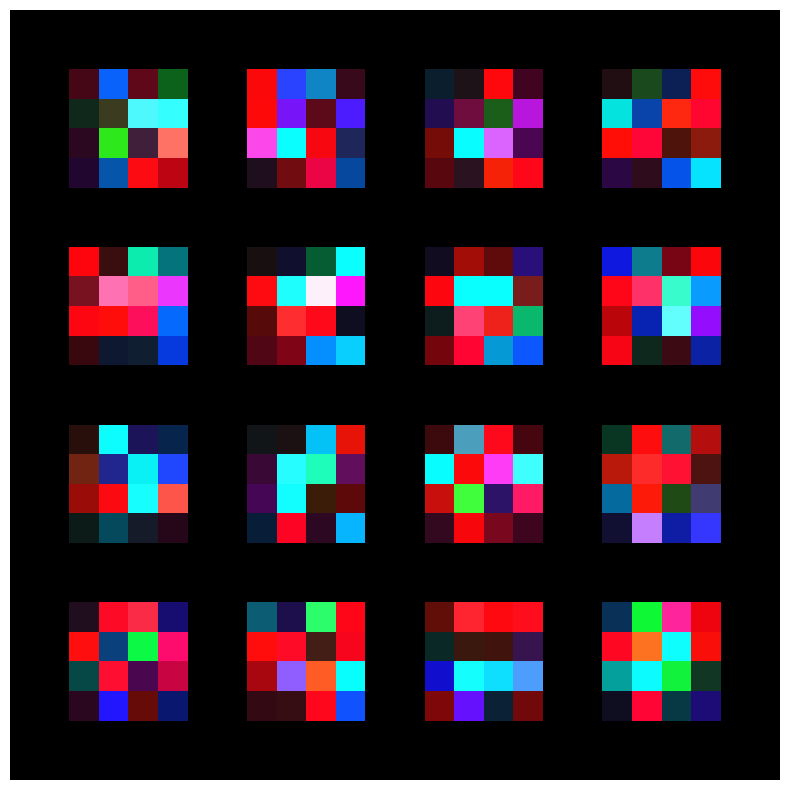

Layer 1: Loss_D: -1.0777047872543335, Loss_G: 0.6739705801010132
D Grad Norm : 0.5323, G Grad Norm: 0.1870
Epoch: 78 Outputting statistics: 


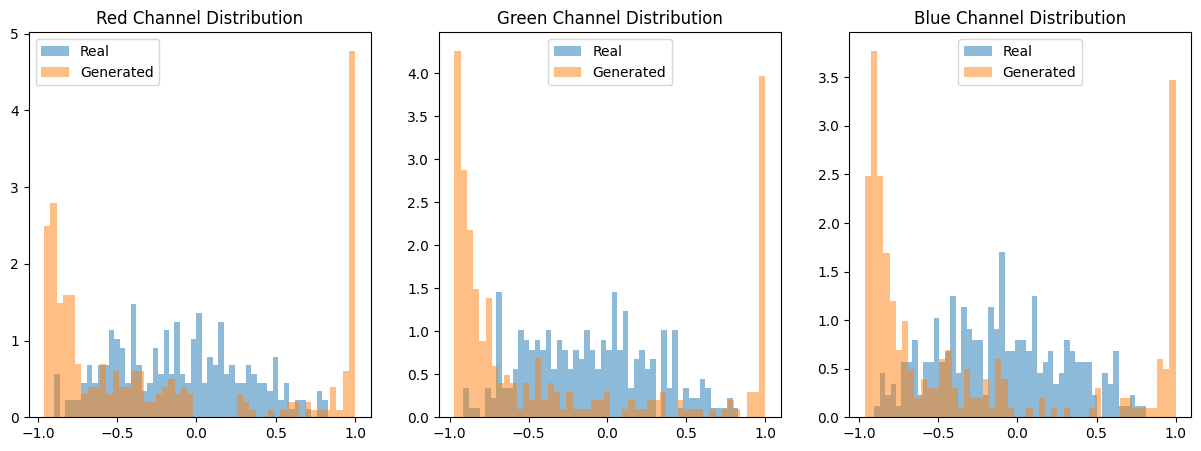

Real images - Mean: [-0.10811882 -0.10977324 -0.10756738] Std: [0.4042195  0.3956619  0.39632866]
Generated images - Mean: [-0.2135324  -0.33585626 -0.3281987 ] Std: [0.7536408  0.7335454  0.72111374]


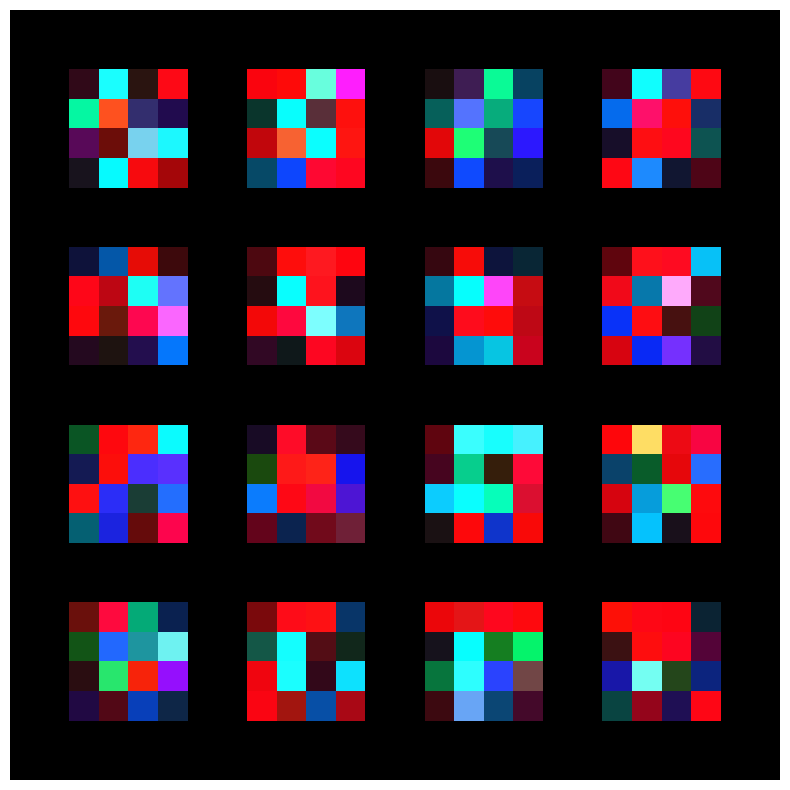

Layer 1: Loss_D: 0.025255726650357246, Loss_G: 0.19986870884895325
D Grad Norm : 0.4815, G Grad Norm: 0.2685
Epoch: 79 Outputting statistics: 


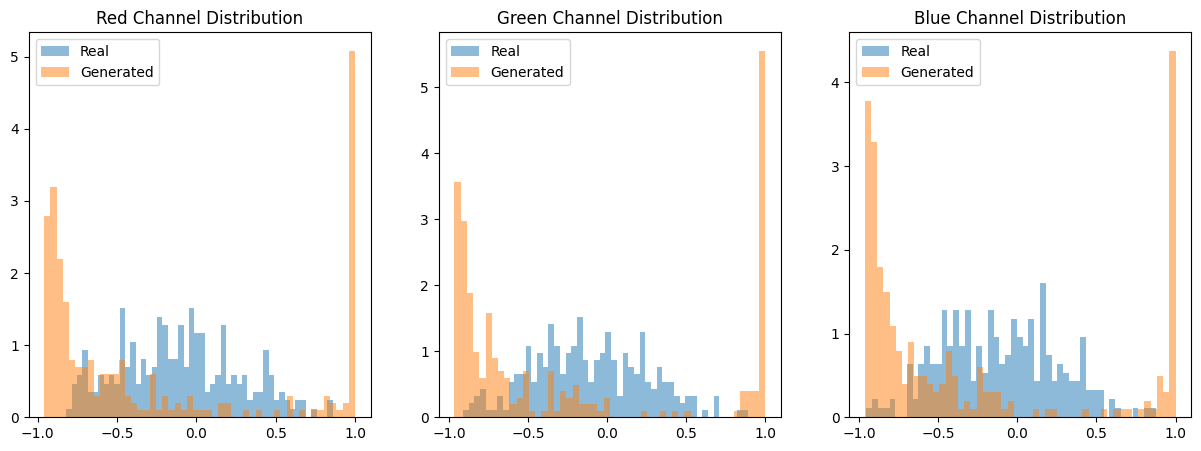

Real images - Mean: [-0.11173406 -0.11596196 -0.11372544] Std: [0.37160638 0.35800636 0.35841477]
Generated images - Mean: [-0.26146272 -0.24528988 -0.31588164] Std: [0.7571843  0.78544617 0.7435241 ]


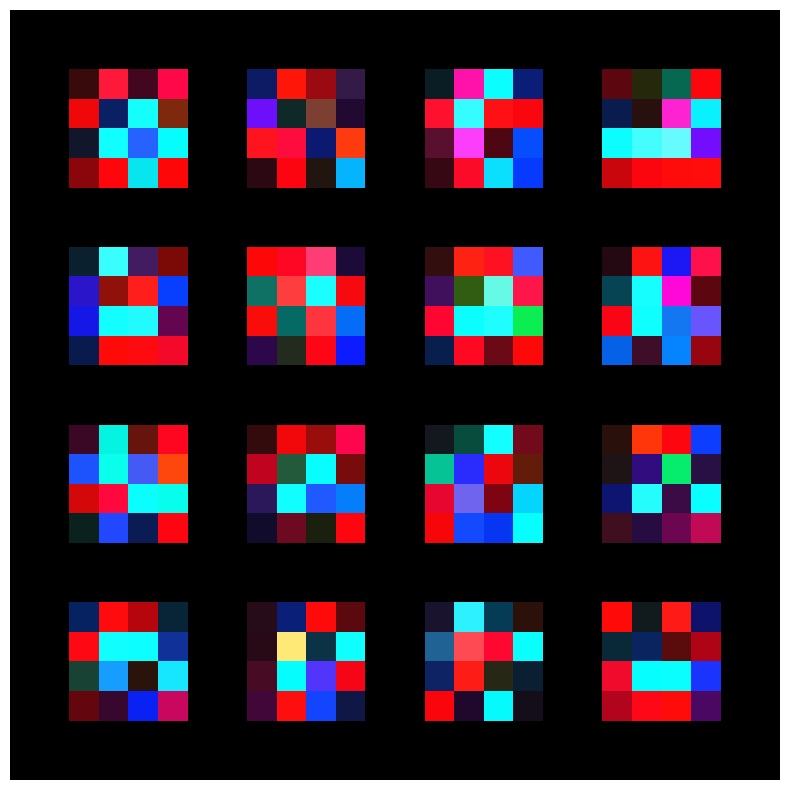

Layer 1: Loss_D: 0.9727151393890381, Loss_G: -0.40675976872444153
D Grad Norm : 0.4410, G Grad Norm: 0.1952
Epoch: 80 Outputting statistics: 


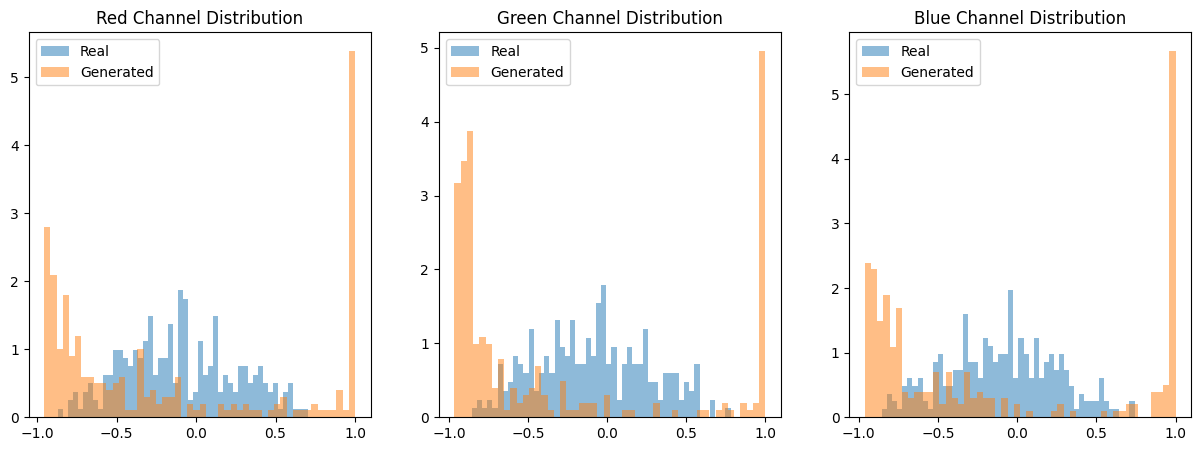

Real images - Mean: [-0.10306372 -0.09892766 -0.10242034] Std: [0.3492134  0.35251057 0.34189445]
Generated images - Mean: [-0.17511028 -0.32768366 -0.17661674] Std: [0.75488085 0.76179224 0.7817174 ]


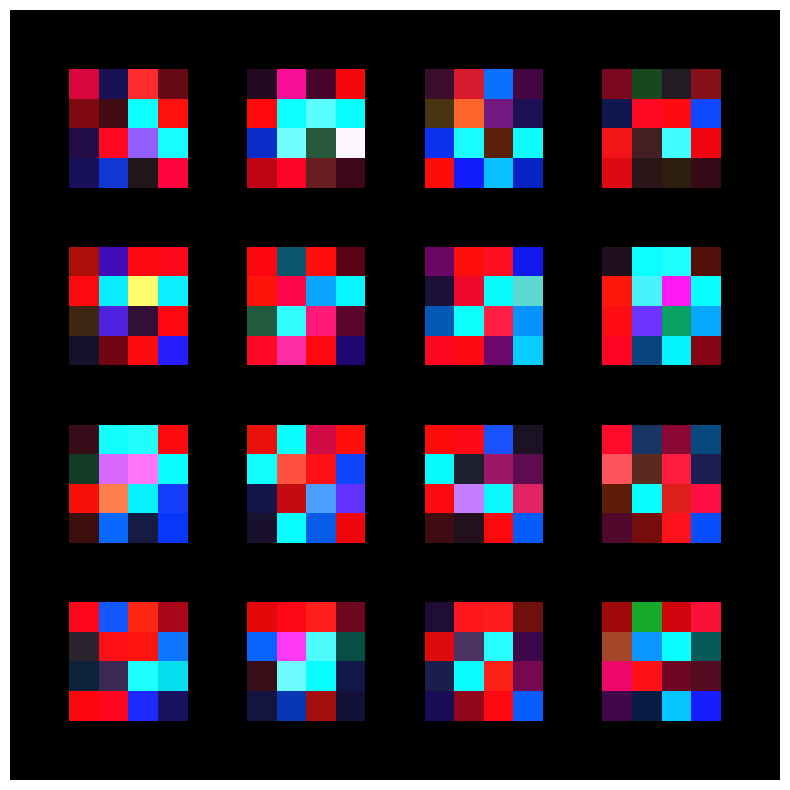

Layer 1: Loss_D: 0.213595449924469, Loss_G: 0.4066450297832489
D Grad Norm : 0.6855, G Grad Norm: 0.2593
Epoch: 81 Outputting statistics: 


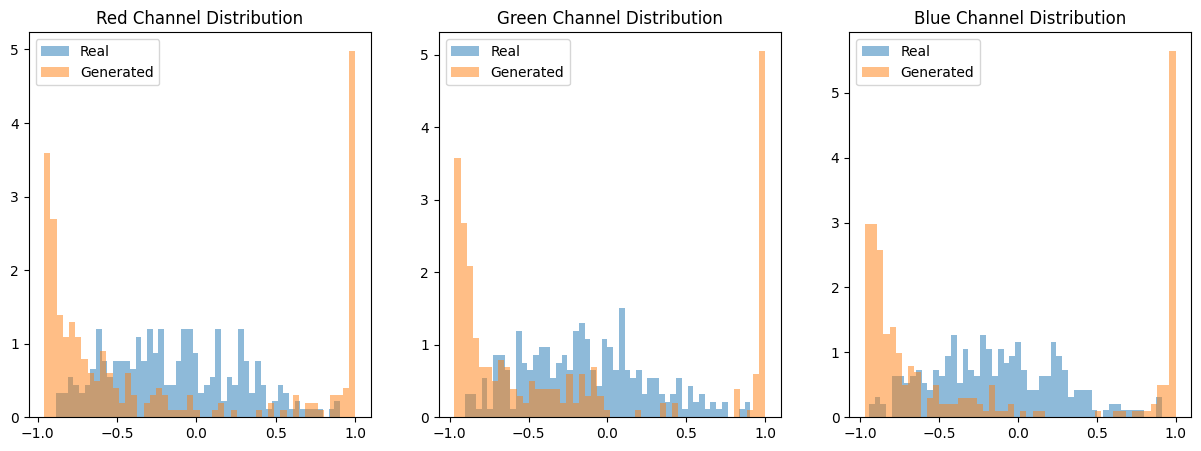

Real images - Mean: [-0.13973646 -0.14690563 -0.15119484] Std: [0.40313357 0.39763072 0.39356804]
Generated images - Mean: [-0.24431454 -0.25783724 -0.23716226] Std: [0.7680324  0.7548088  0.79980767]


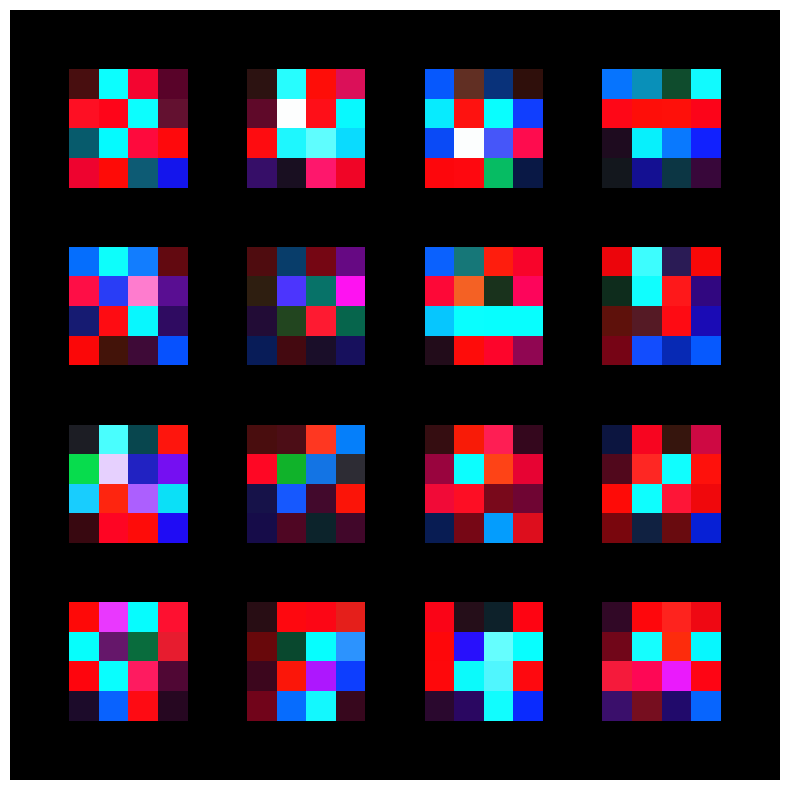

Layer 1: Loss_D: 0.041797563433647156, Loss_G: -0.6116384267807007
D Grad Norm : 0.7482, G Grad Norm: 0.1866
Epoch: 82 Outputting statistics: 


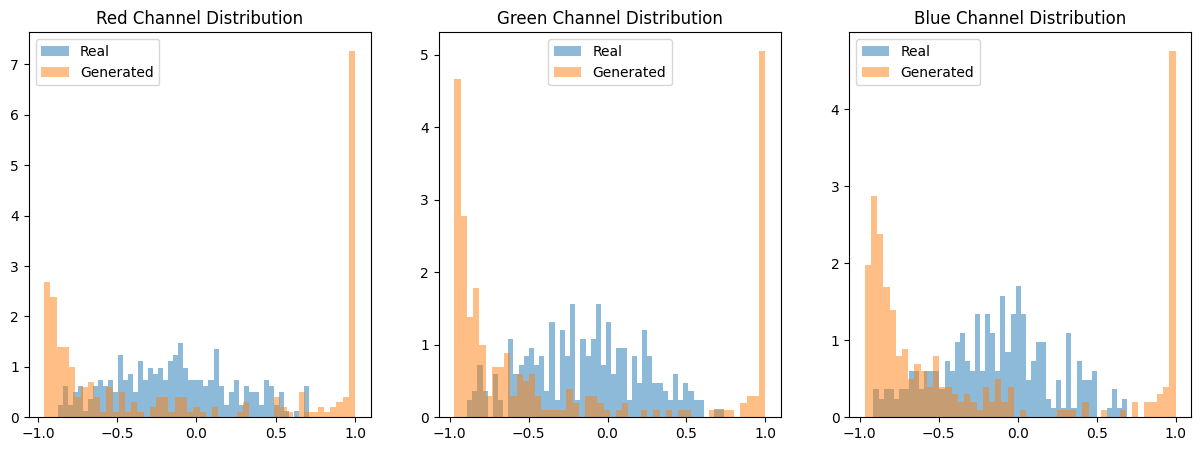

Real images - Mean: [-0.14041054 -0.1401655  -0.13961393] Std: [0.37453282 0.36351264 0.361149  ]
Generated images - Mean: [-0.04573509 -0.29427066 -0.2696627 ] Std: [0.8188932 0.7724784 0.7499399]


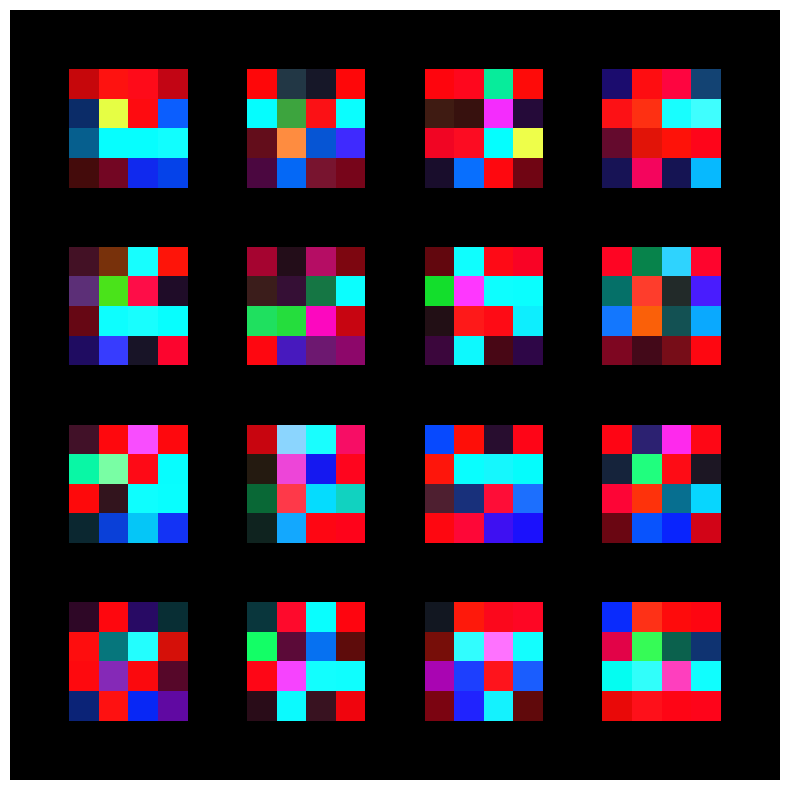

Layer 1: Loss_D: 2.064164400100708, Loss_G: -1.2995244264602661
D Grad Norm : 0.4713, G Grad Norm: 0.3272
Epoch: 83 Outputting statistics: 


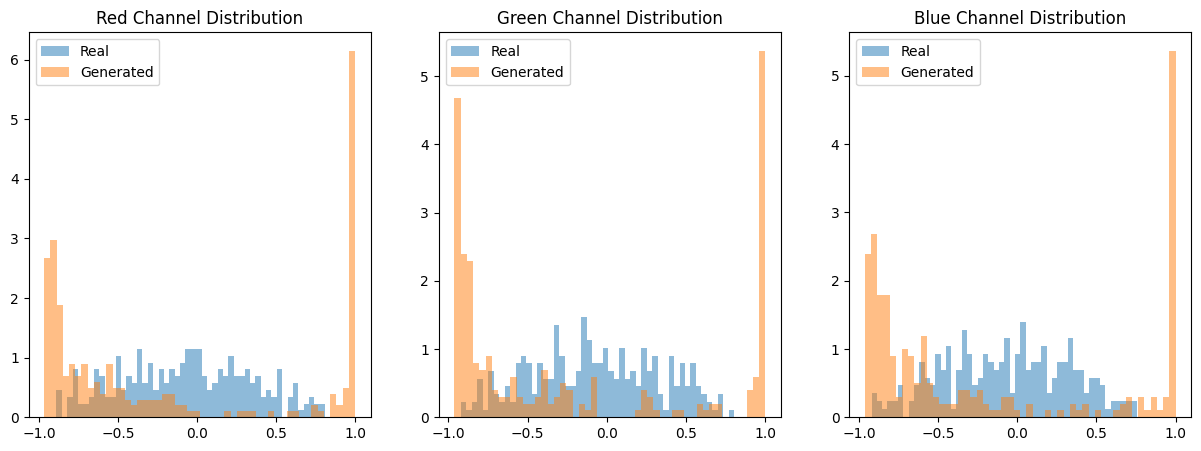

Real images - Mean: [-0.06957719 -0.07325364 -0.06982229] Std: [0.41030604 0.40371054 0.3913915 ]
Generated images - Mean: [-0.173519   -0.22184335 -0.20218545] Std: [0.79594284 0.7862489  0.7697108 ]


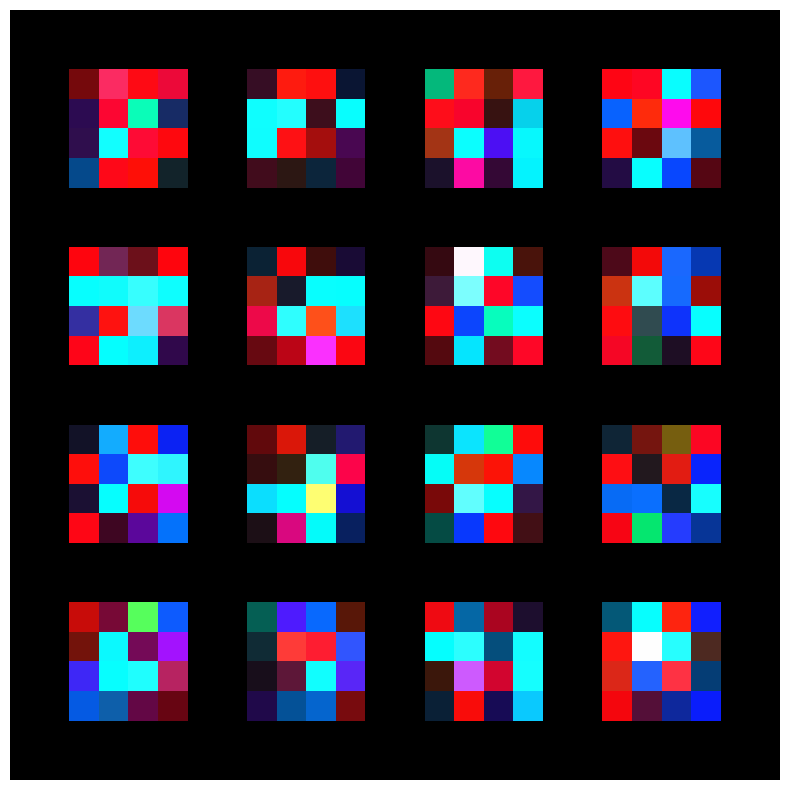

Layer 1: Loss_D: -1.6816201210021973, Loss_G: 0.003940708935260773
D Grad Norm : 0.7097, G Grad Norm: 0.2532
Epoch: 84 Outputting statistics: 


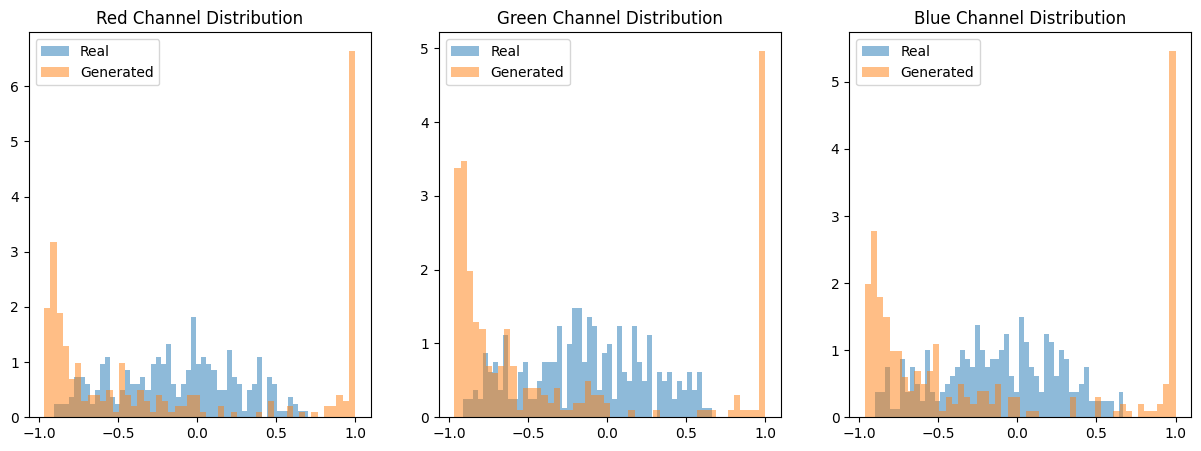

Real images - Mean: [-0.13039213 -0.13229164 -0.1285539 ] Std: [0.3825973  0.38604355 0.3756293 ]
Generated images - Mean: [-0.12639506 -0.31536466 -0.19689213] Std: [0.8008158  0.7476328  0.76669115]


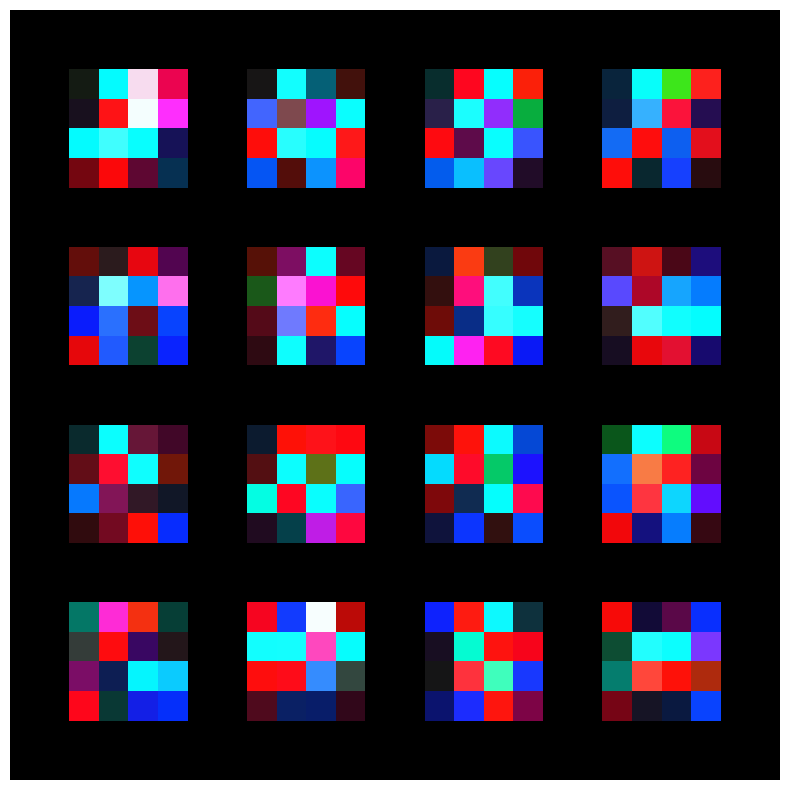

Layer 1: Loss_D: -1.4861130714416504, Loss_G: -0.8750717639923096
D Grad Norm : 0.4710, G Grad Norm: 0.3031
Epoch: 85 Outputting statistics: 


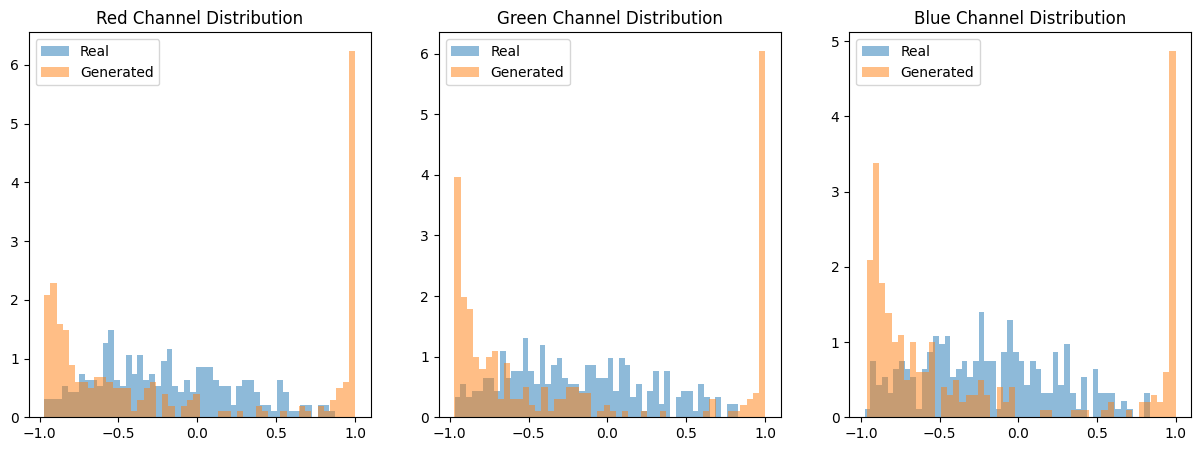

Real images - Mean: [-0.19715086 -0.19788602 -0.19445467] Std: [0.4293875  0.43524283 0.4287922 ]
Generated images - Mean: [-0.11575157 -0.19801696 -0.2393021 ] Std: [0.7955024  0.7952707  0.75951076]


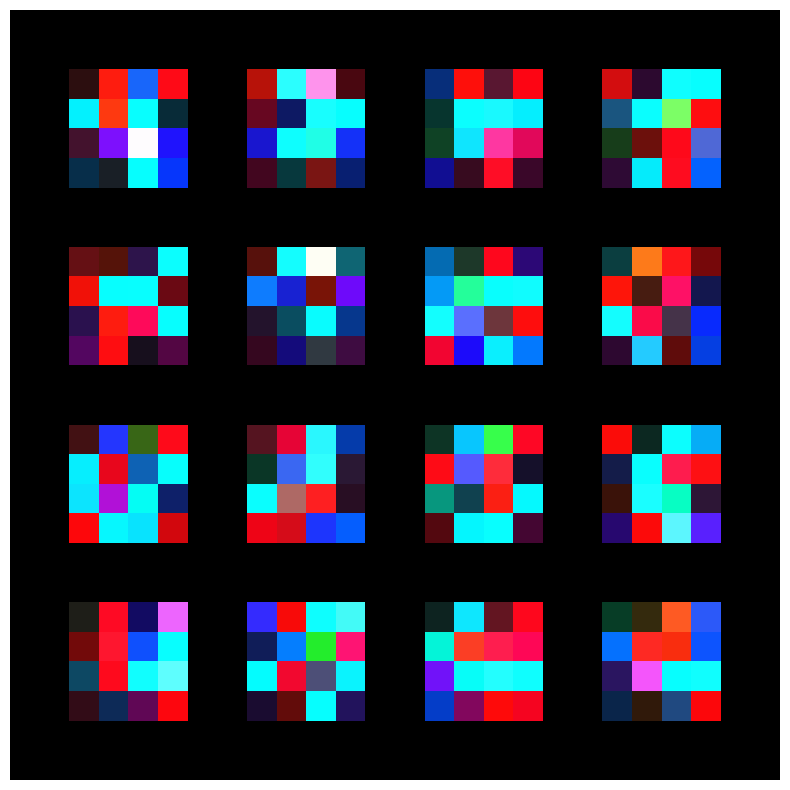

Layer 1: Loss_D: 1.5703926086425781, Loss_G: -1.3792636394500732
D Grad Norm : 0.4846, G Grad Norm: 0.1881
Epoch: 86 Outputting statistics: 


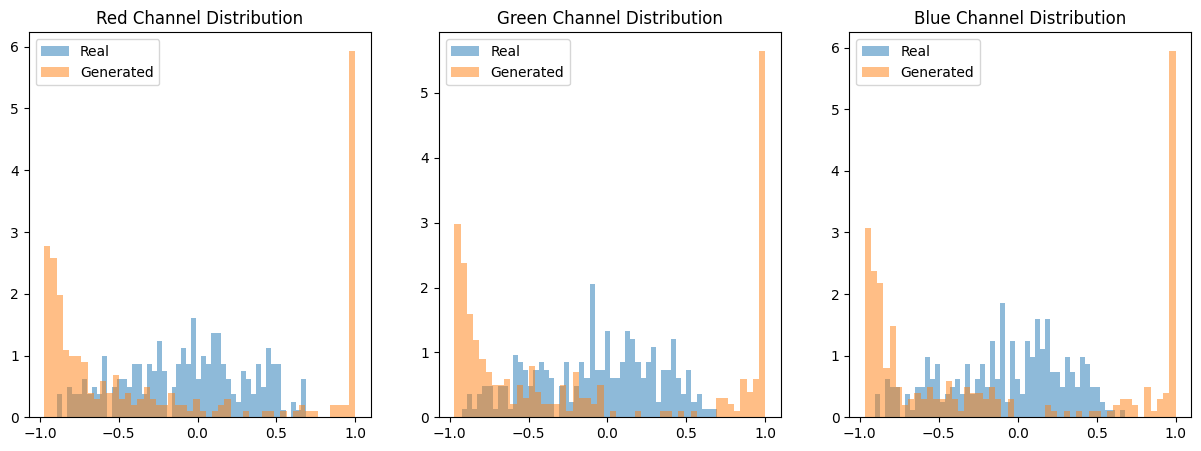

Real images - Mean: [-0.0713848  -0.07496937 -0.07659311] Std: [0.3882747  0.3873939  0.37341872]
Generated images - Mean: [-0.20156744 -0.1367452  -0.13729773] Std: [0.7814384  0.79524875 0.80198157]


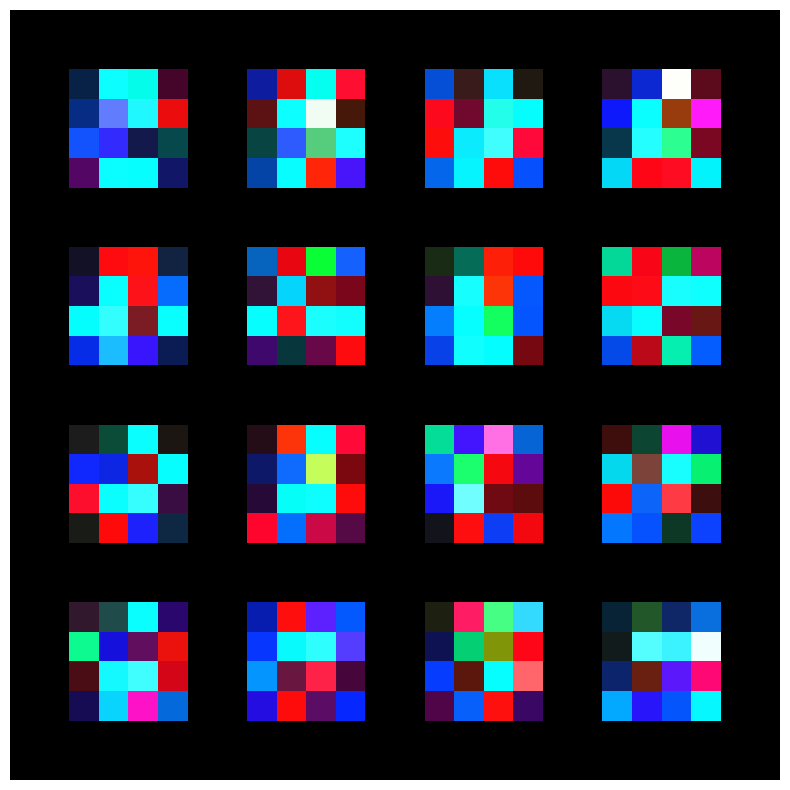

Layer 1: Loss_D: 1.8041695356369019, Loss_G: -0.1185791939496994
D Grad Norm : 0.6705, G Grad Norm: 0.2241
Epoch: 87 Outputting statistics: 


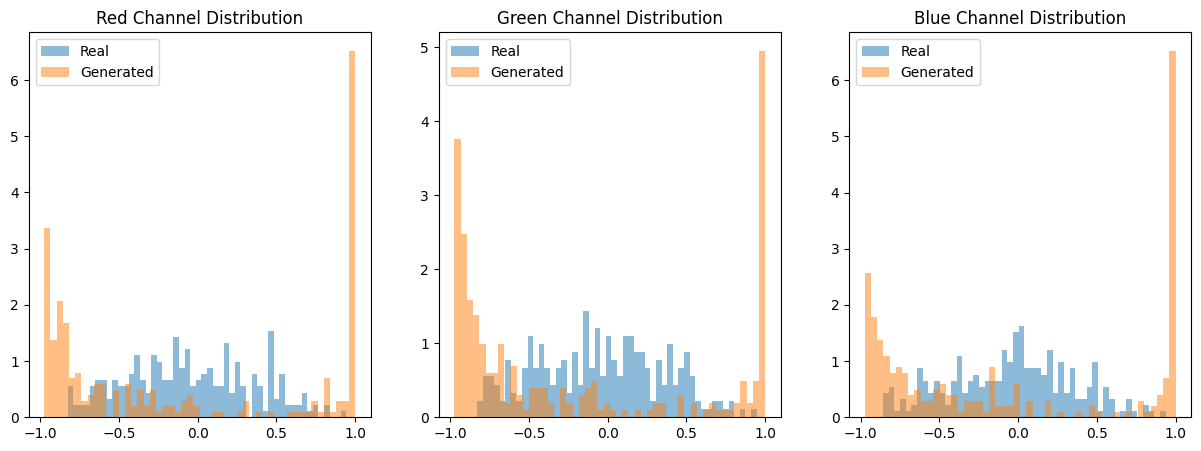

Real images - Mean: [-0.04987742 -0.04865195 -0.04482227] Std: [0.40031135 0.39996076 0.38856107]
Generated images - Mean: [-0.10954528 -0.2119227  -0.07895061] Std: [0.81680506 0.7824312  0.7959163 ]


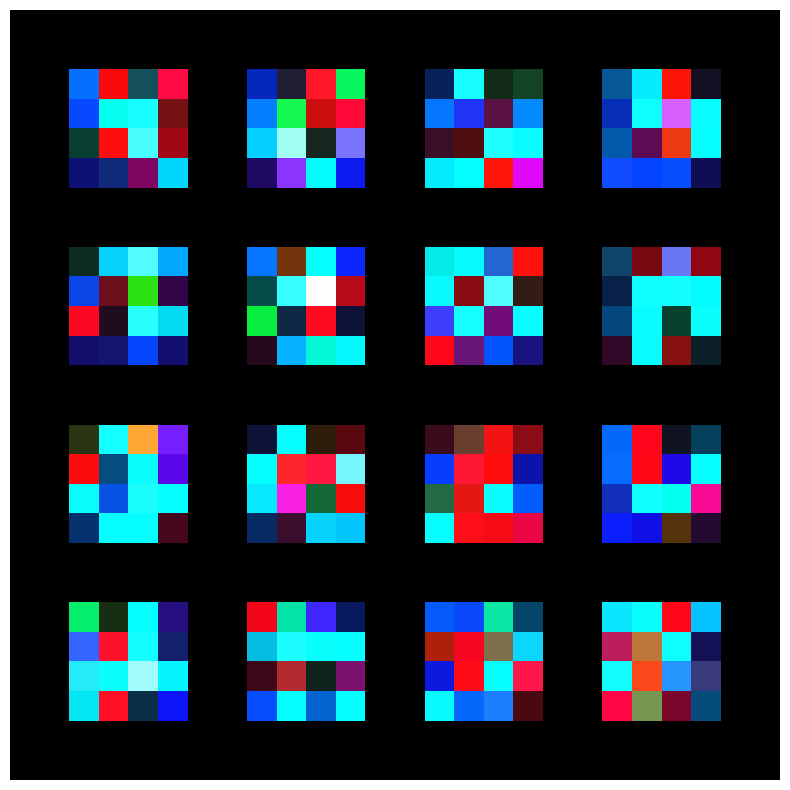

Layer 1: Loss_D: -0.33777377009391785, Loss_G: 0.34828895330429077
D Grad Norm : 0.5081, G Grad Norm: 0.2716
Epoch: 88 Outputting statistics: 


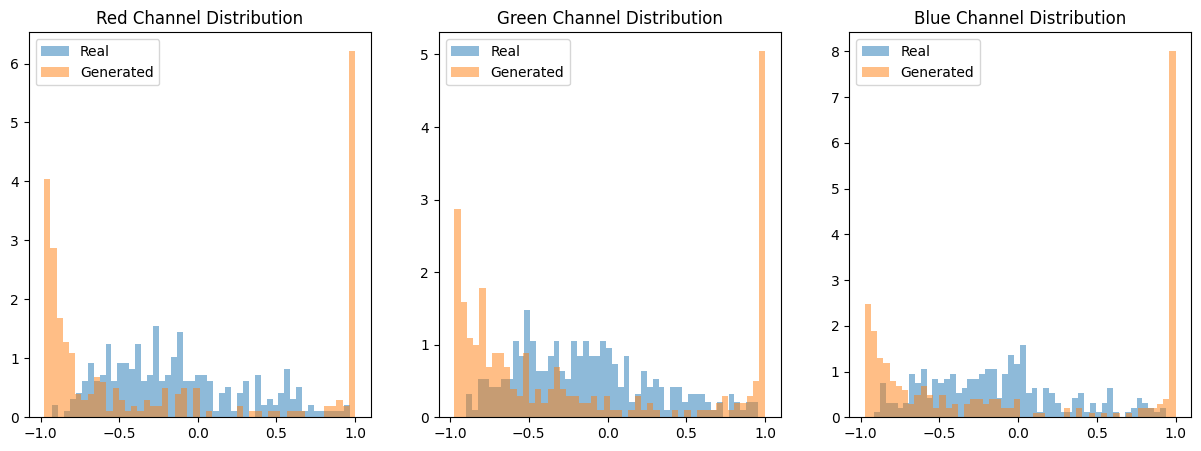

Real images - Mean: [-0.14234066 -0.14221813 -0.14108449] Std: [0.4300041  0.42539394 0.42647803]
Generated images - Mean: [-0.20463456 -0.17699316 -0.02010939] Std: [0.80973816 0.7597235  0.82115835]


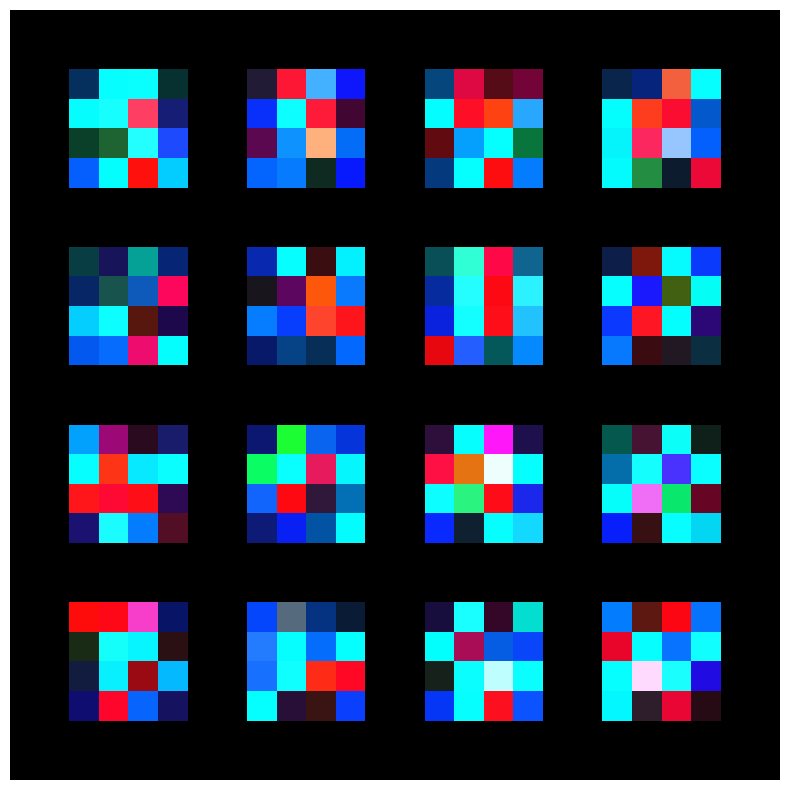

Layer 1: Loss_D: 0.5476852059364319, Loss_G: 0.5993834137916565
D Grad Norm : 0.5989, G Grad Norm: 0.2561
Epoch: 89 Outputting statistics: 


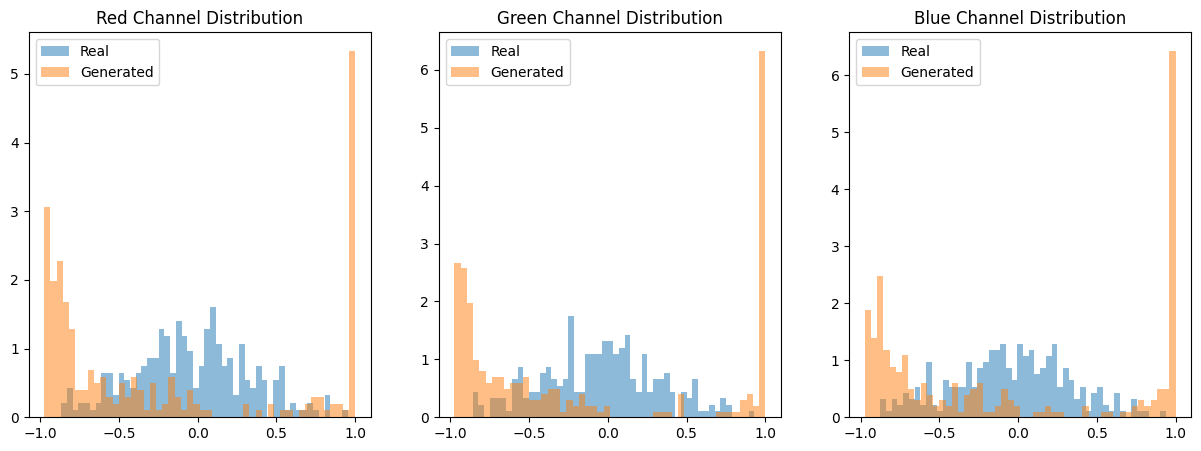

Real images - Mean: [-0.04362746 -0.04966298 -0.04923404] Std: [0.3667456  0.36686316 0.3708191 ]
Generated images - Mean: [-0.21818872 -0.16597418 -0.07942322] Std: [0.77405447 0.79716086 0.8000223 ]


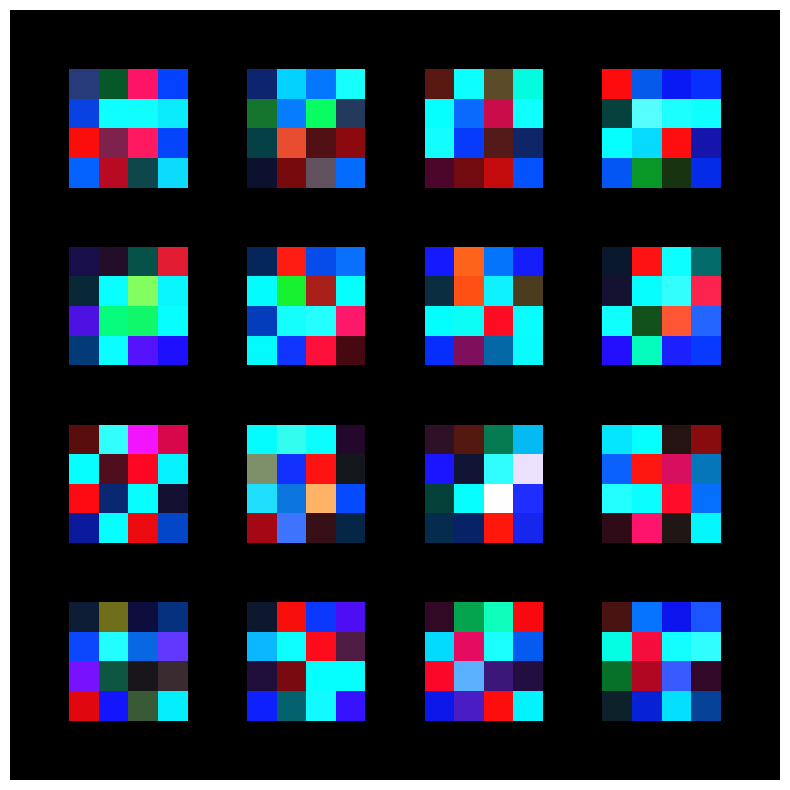

Layer 1: Loss_D: -0.5988074541091919, Loss_G: 0.477352499961853
D Grad Norm : 0.5769, G Grad Norm: 0.2793
Epoch: 90 Outputting statistics: 


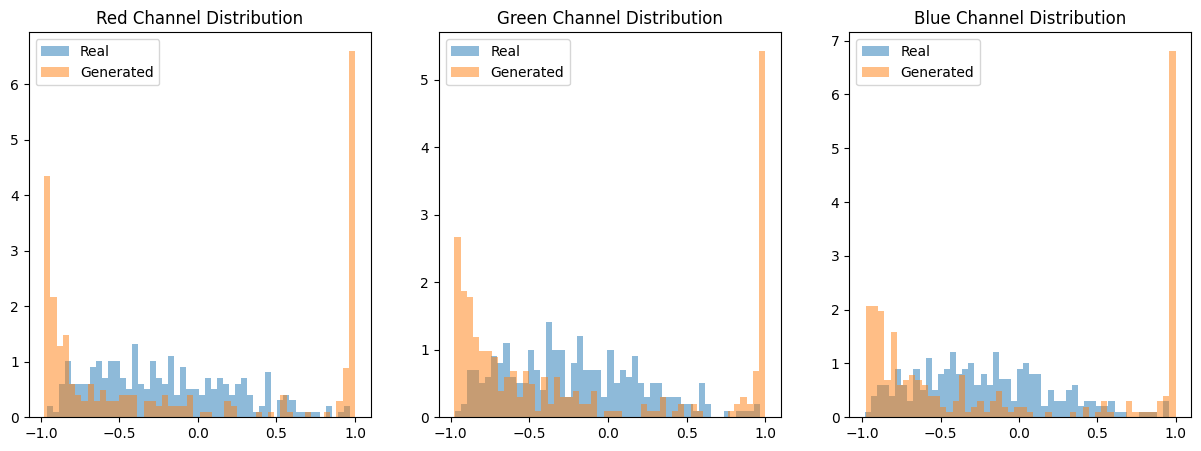

Real images - Mean: [-0.21320465 -0.21764706 -0.22273284] Std: [0.4434223  0.43097866 0.42582658]
Generated images - Mean: [-0.13337913 -0.17632677 -0.10699404] Std: [0.82535756 0.7759175  0.8059218 ]


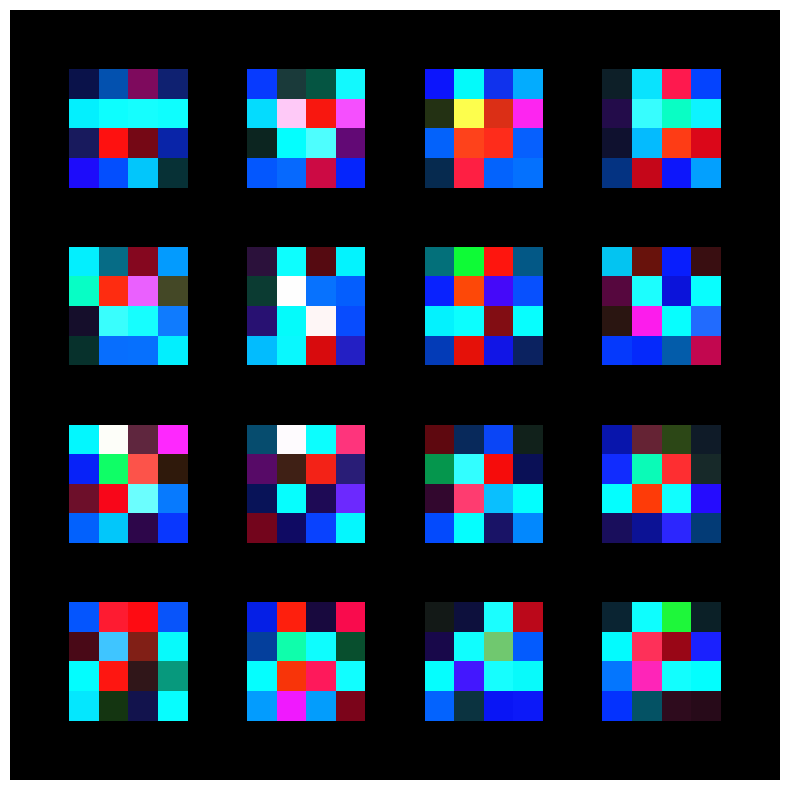

Layer 1: Loss_D: 1.2033426761627197, Loss_G: -0.473175048828125
D Grad Norm : 0.4427, G Grad Norm: 0.3286
Epoch: 91 Outputting statistics: 


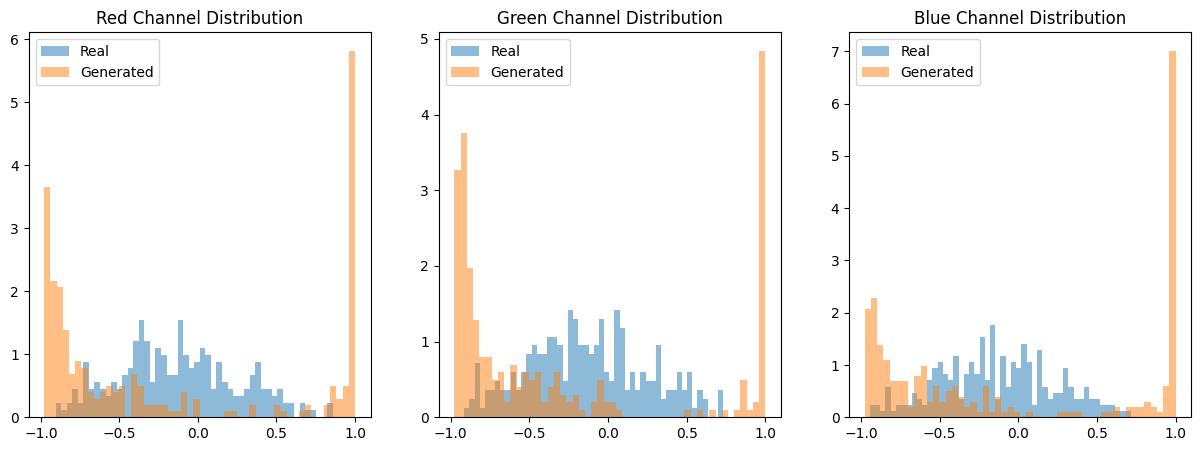

Real images - Mean: [-0.12977941 -0.1370404  -0.13667284] Std: [0.37735015 0.37214333 0.3622273 ]
Generated images - Mean: [-0.19304882 -0.30512878 -0.06992149] Std: [0.8093499  0.75421315 0.80986136]


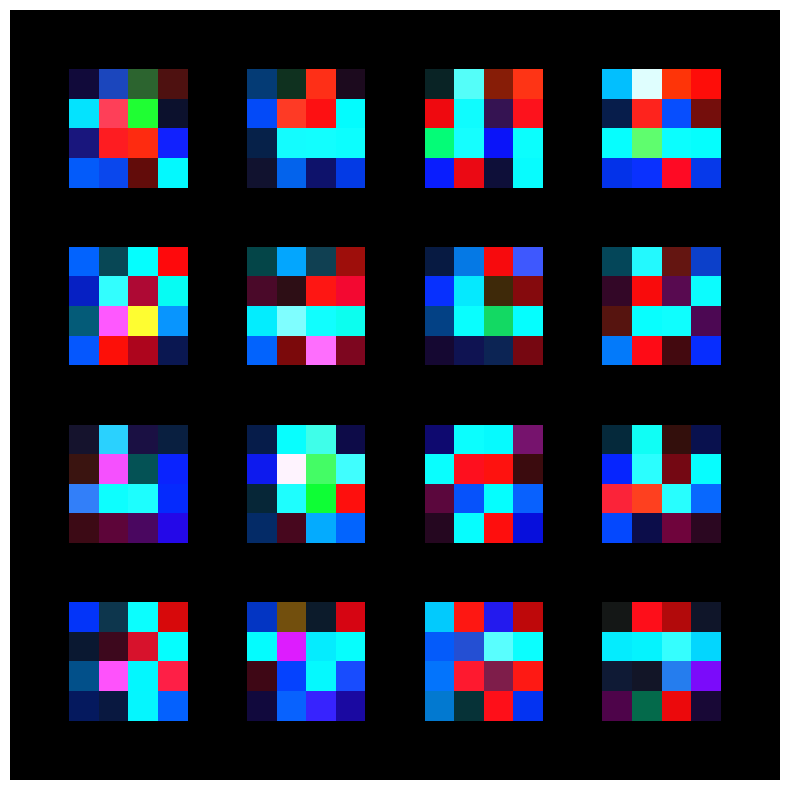

Layer 1: Loss_D: 1.418441653251648, Loss_G: -0.8936474323272705
D Grad Norm : 0.8593, G Grad Norm: 0.2060
Epoch: 92 Outputting statistics: 


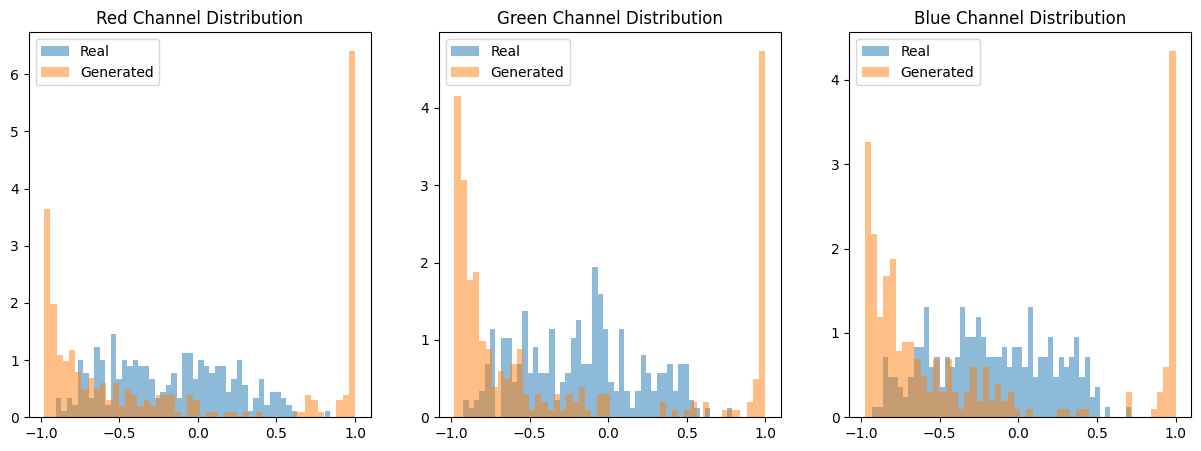

Real images - Mean: [-0.18088236 -0.17800242 -0.1728247 ] Std: [0.38747922 0.38226822 0.37594035]
Generated images - Mean: [-0.14820084 -0.32033557 -0.30622607] Std: [0.8036172 0.7658935 0.7329765]


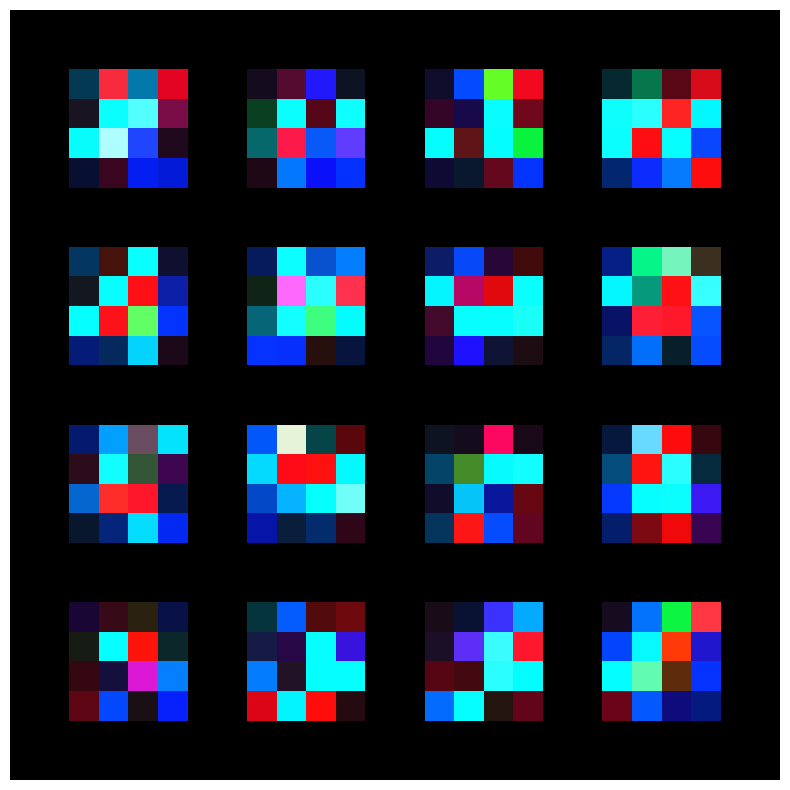

Layer 1: Loss_D: 1.394773244857788, Loss_G: 1.136628270149231
D Grad Norm : 0.7862, G Grad Norm: 0.1783
Epoch: 93 Outputting statistics: 


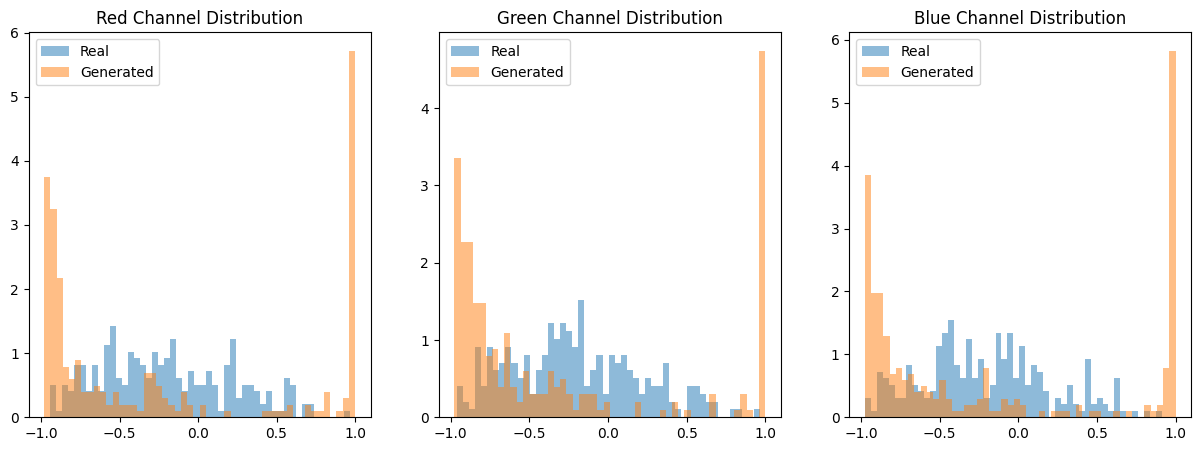

Real images - Mean: [-0.20618874 -0.2094669  -0.20389093] Std: [0.41916403 0.41083223 0.40767872]
Generated images - Mean: [-0.22753213 -0.32075182 -0.1921263 ] Std: [0.79441905 0.73658717 0.7987195 ]


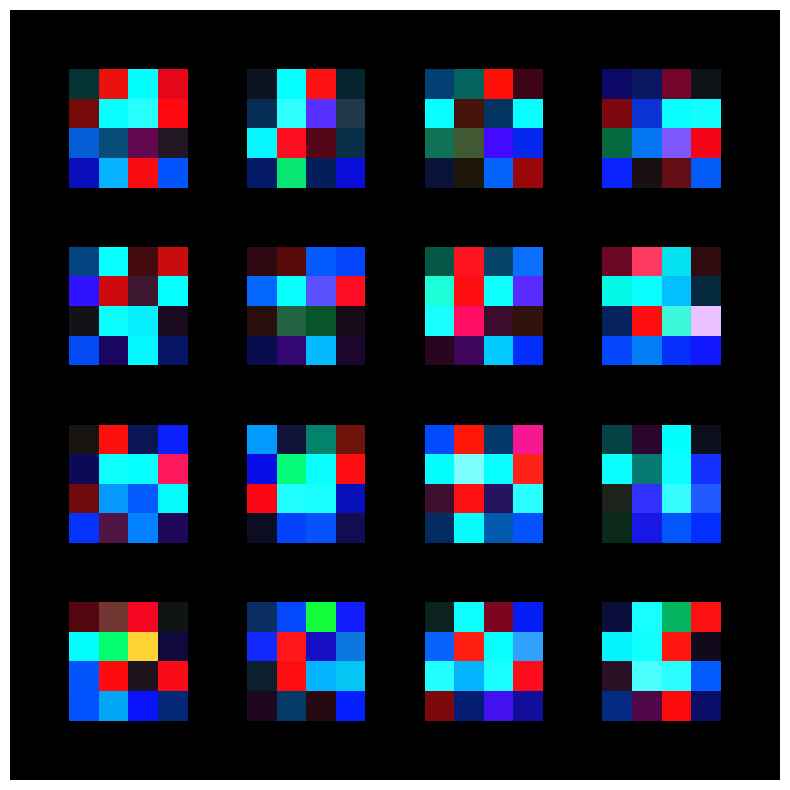

Layer 1: Loss_D: -1.002102255821228, Loss_G: -3.414069414138794
D Grad Norm : 0.7293, G Grad Norm: 0.2618
Epoch: 94 Outputting statistics: 


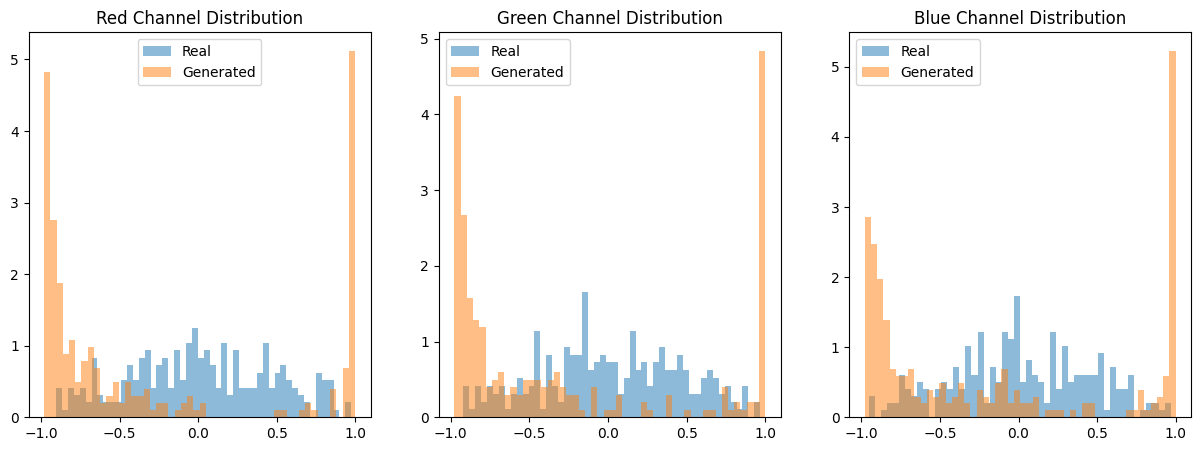

Real images - Mean: [0.01593138 0.01737134 0.01225492] Std: [0.4535927  0.44959518 0.4345131 ]
Generated images - Mean: [-0.2959274  -0.27478197 -0.17760025] Std: [0.7912668  0.76133454 0.7770667 ]


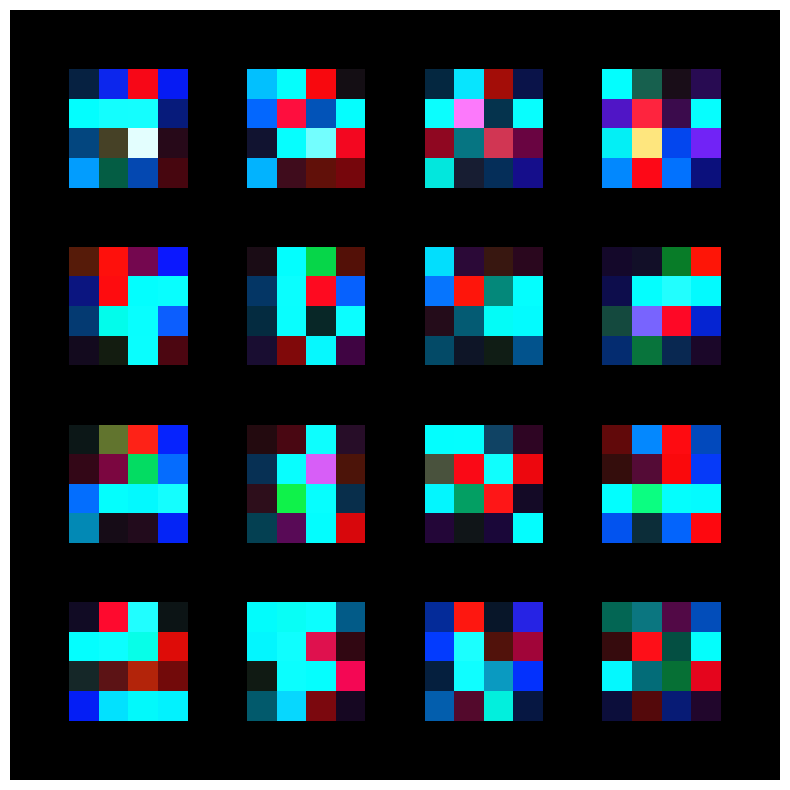

Layer 1: Loss_D: 1.1835072040557861, Loss_G: -0.9099748134613037
D Grad Norm : 0.4513, G Grad Norm: 0.2180
Epoch: 95 Outputting statistics: 


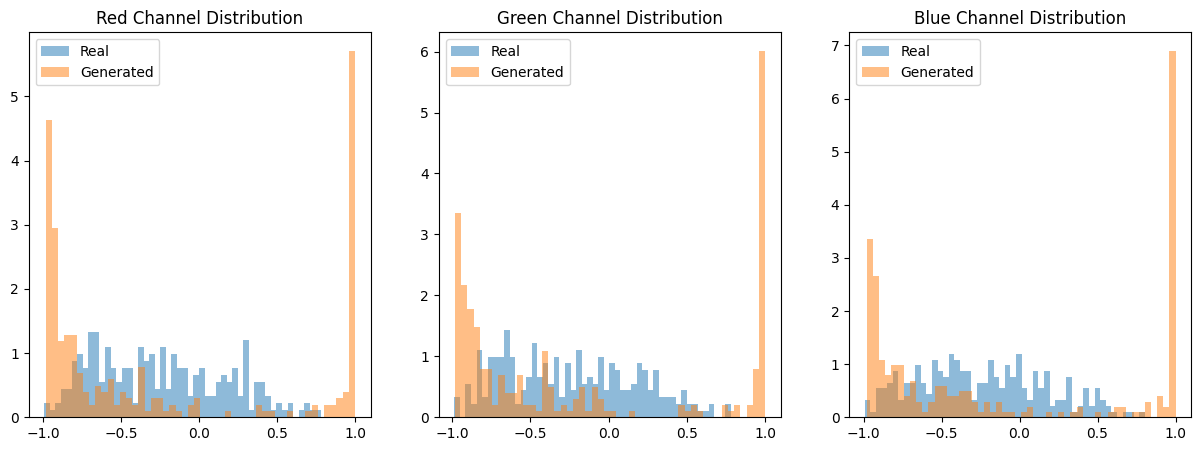

Real images - Mean: [-0.24868262 -0.24669129 -0.24374998] Std: [0.4163874  0.41785985 0.40829137]
Generated images - Mean: [-0.2450134  -0.17317373 -0.12764323] Std: [0.80795485 0.80299073 0.8193192 ]


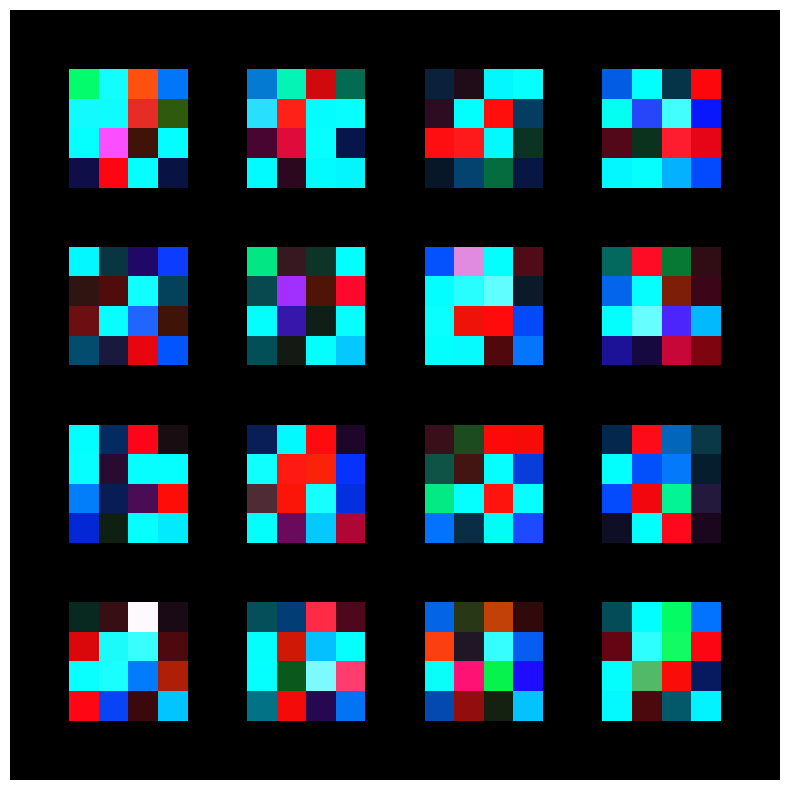

Layer 1: Loss_D: -0.8257225155830383, Loss_G: -0.8221629858016968
D Grad Norm : 0.6943, G Grad Norm: 0.1953
Epoch: 96 Outputting statistics: 


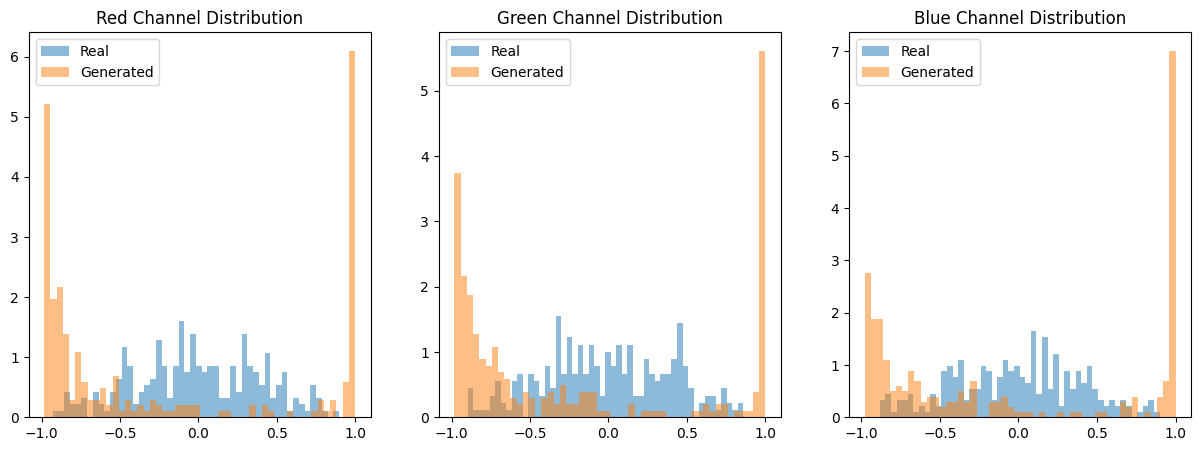

Real images - Mean: [-0.00903795 -0.01476715 -0.01216297] Std: [0.4013404  0.40430337 0.39896256]
Generated images - Mean: [-0.22291711 -0.22720207 -0.07231739] Std: [0.8276204 0.7901249 0.821759 ]


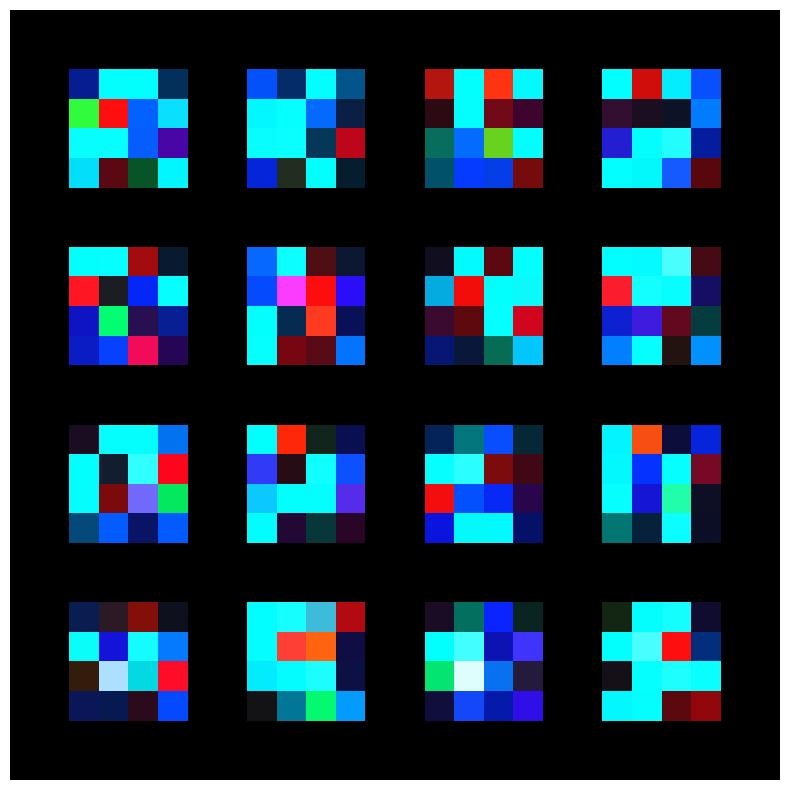

Layer 1: Loss_D: 1.7959495782852173, Loss_G: -1.791477918624878
D Grad Norm : 0.4663, G Grad Norm: 0.2843
Epoch: 97 Outputting statistics: 


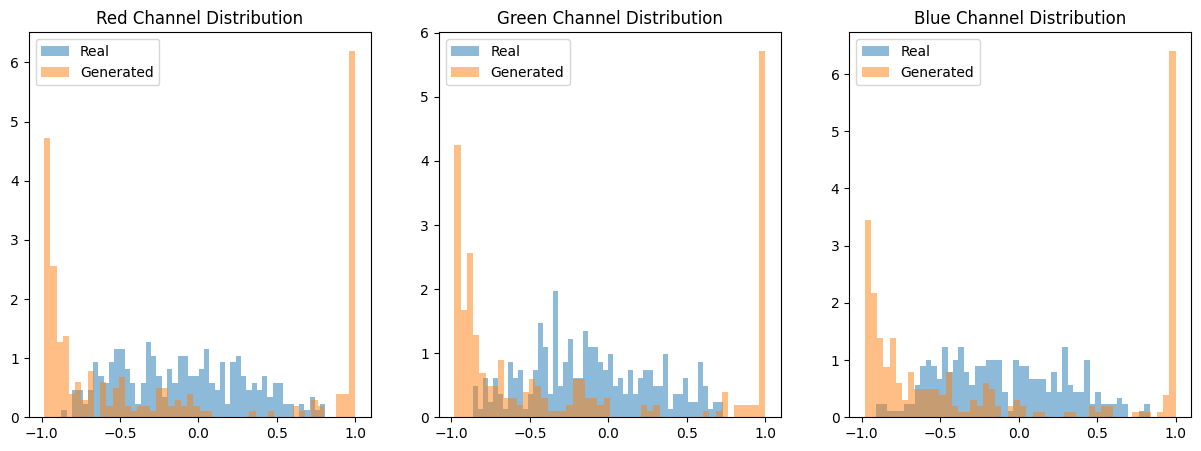

Real images - Mean: [-0.1033701  -0.10729163 -0.1074755 ] Std: [0.39962304 0.3899189  0.38734224]
Generated images - Mean: [-0.19505249 -0.22410814 -0.17032889] Std: [0.8172716 0.7919708 0.7979984]


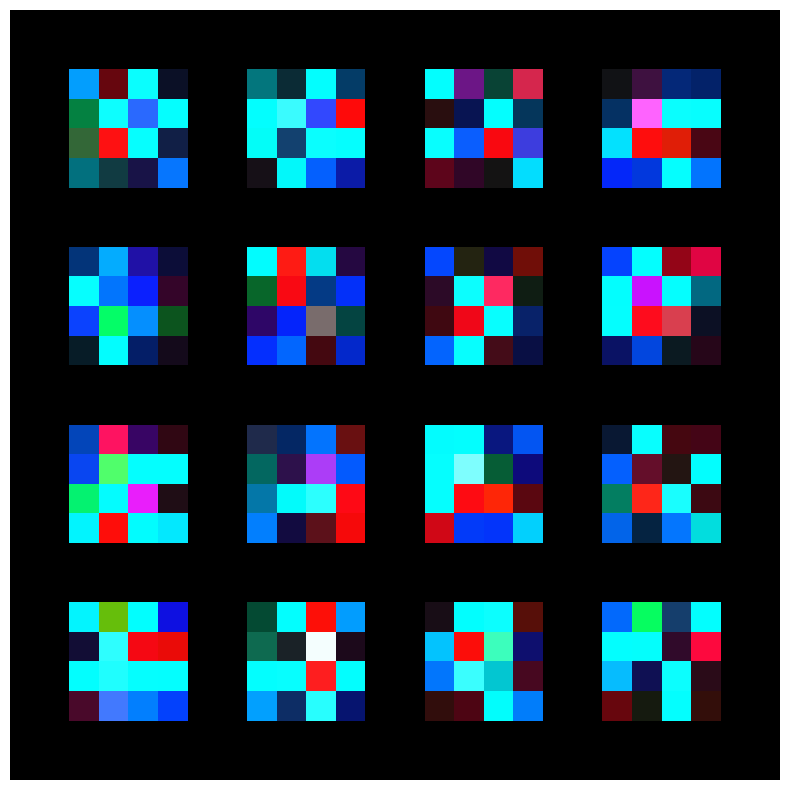

Layer 1: Loss_D: -0.10798636078834534, Loss_G: 0.34410035610198975
D Grad Norm : 0.4508, G Grad Norm: 0.2522
Epoch: 98 Outputting statistics: 


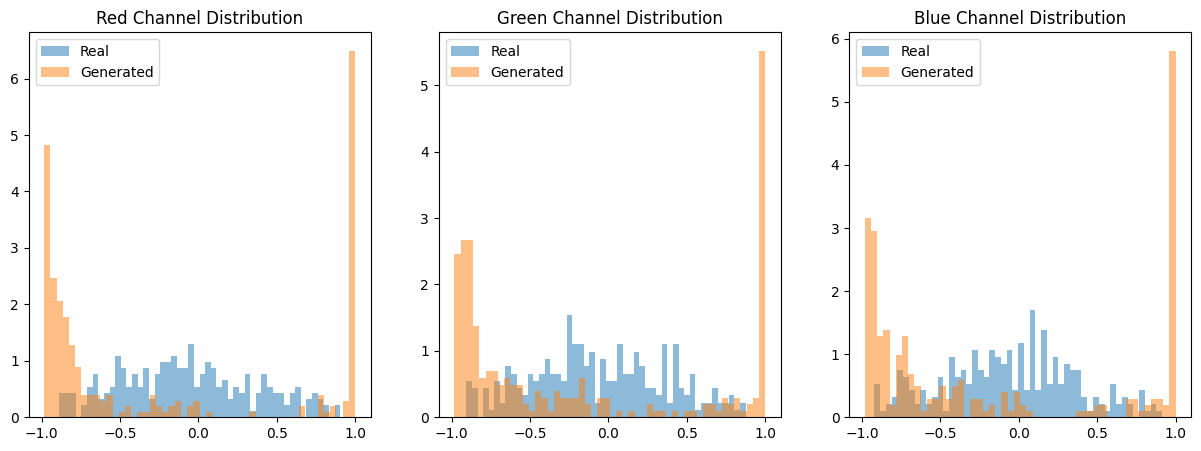

Real images - Mean: [-0.06973038 -0.066636   -0.06452206] Std: [0.4287417  0.42530242 0.4173255 ]
Generated images - Mean: [-0.24661046 -0.1926797  -0.1827938 ] Std: [0.83475703 0.7912613  0.80132836]


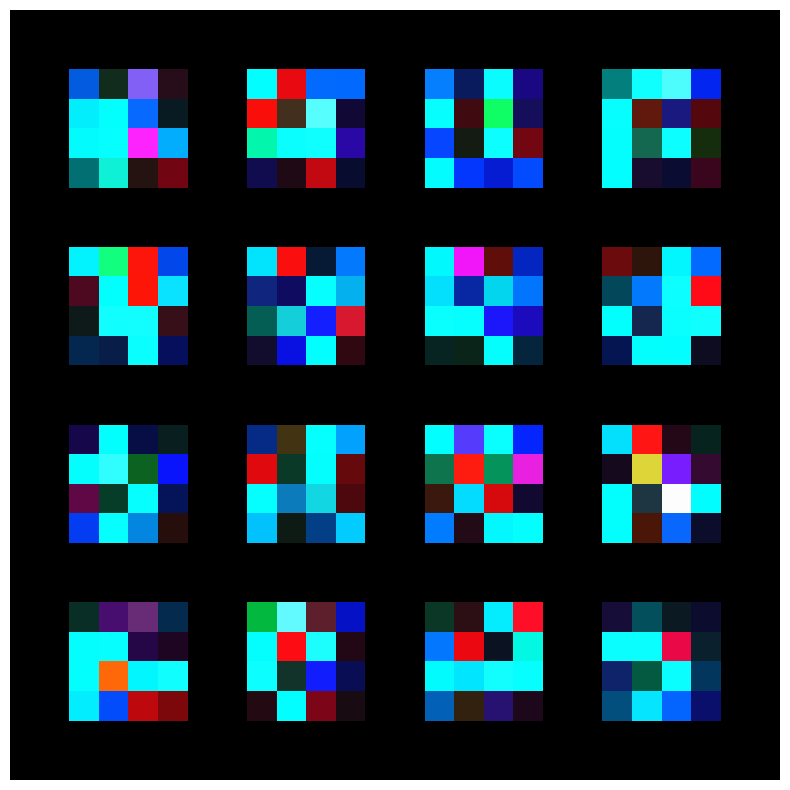

Layer 1: Loss_D: 2.3817412853240967, Loss_G: 2.2880005836486816
D Grad Norm : 0.4861, G Grad Norm: 0.2985
Epoch: 99 Outputting statistics: 


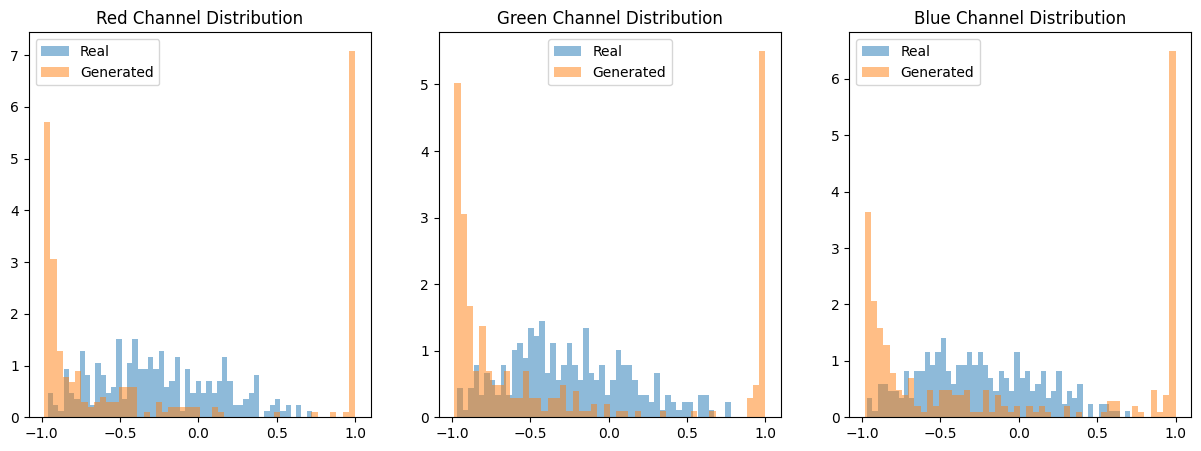

Real images - Mean: [-0.25827208 -0.25744495 -0.2585171 ] Std: [0.3831028  0.38701037 0.37340322]
Generated images - Mean: [-0.24214333 -0.30386624 -0.12898283] Std: [0.8316714 0.7928272 0.8136411]


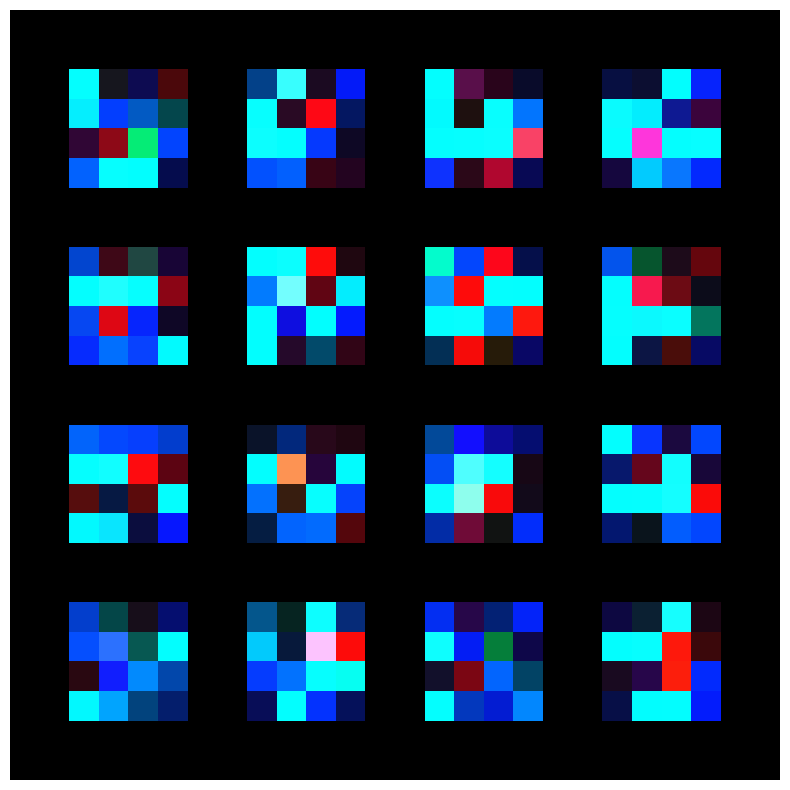

Layer 1: Loss_D: 1.6496881246566772, Loss_G: 0.2943296432495117
D Grad Norm : 0.5155, G Grad Norm: 0.1666
Alpha after grow: 1.0


KeyboardInterrupt: 

In [263]:
for layer in range(1,5):
#for layer in range(1,4):
    print(f'Training layer: {layer}')
    # Choose the dataloader
    if layer == 1:
        dataloader = layer_1_dataloader
    elif layer == 2:
        dataloader = layer_2_dataloader
    elif layer == 3:
        dataloader = layer_3_dataloader
    else:
        dataloader = layer_4_dataloader
    
    alpha = 0
    
    for epoch_grow in range(100):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)
            
            noise_tensor = torch.randn(latent_dim, device=device)
                        
            #with torch.no_grad():
            gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
            
            #real_images = F.interpolate(real_images, size=gen_images.shape[2:], mode='area')
            # This messed up the normalization so i changed to jsut using dataloader approach
            
            #gen_labels = torch.zeros((batch_size, 1)).to(device)
            #real_labels = torch.ones((batch_size, 1)).to(device)

            #combined_images = torch.cat((real_images, gen_images))
            #combined_labels = torch.cat((real_labels, gen_labels))

            # First update the D model
            d_32.zero_grad()
            #d_outputs_combined = d_32(combined_images, alpha=alpha, layer_num=layer)
            #loss_d = criterion(d_outputs_combined, combined_labels)
            #with autocast():
            loss_d, _ = criterion(d_32, real_images, gen_images, alpha, layer) 
            #scaler.scale(loss_d).backward()
            #scaler.step(optim_D)
            #scaler.update()
            
            loss_d.backward()
            optim_D.step()
            
            d_grad_norm = compute_gradient_norm(d_32)
            
            # Generate new images for updating G
            noise_tensor = torch.randn(latent_dim, device=device)
            
            # Next update the G model, 
            g_32.zero_grad()
            gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)  # This needs to be on
            #d_outputs_generated = d_32(gen_images, alpha=alpha, layer_num=layer)
            #loss_g = criterion(d_outputs_generated, real_labels)
            #with autocast():
            _, loss_g = criterion(d_32, real_images, gen_images, alpha, layer)
            #scaler.scale(loss_g).backward()
            #scaler.step(optim_G)
            #scaler.update()
            
            #if loss_g < 5: # Manual scaling no good, opted for GradScaler()
            #loss_g = loss_g * 10
            #print(f'Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
            
            #print(f"G loss before backward: {loss_g.item()}")            
            loss_g.backward()
            #print(f"G loss after backward: {loss_g.item()}")
        
            #check_gradients(g_32)
            optim_G.step()
            
            #scaler.update()
            
            g_grad_norm = compute_gradient_norm(g_32)
            
        #imshow(torchvision.utils.make_grid(gen_images.cpu()))
        
        
        print(f'Epoch: {epoch_grow} Outputting statistics: ')
        real_and_gen_stats(real_images, gen_images)
        show_images(gen_images)
        print(f'Layer {layer}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
        print(f'D Grad Norm : {d_grad_norm:.4f}, G Grad Norm: {g_grad_norm:.4f}')
        
        alpha += 1/100
        alpha = round(alpha, 2)
        
    print(f'Alpha after grow: {alpha}')
    for epoch_train in range(50):
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)

            noise_tensor = torch.randn(latent_dim, device=device)
            
            #with torch.no_grad():
            gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)

            #real_images = F.interpolate(real_images, size=gen_images.shape[2:], mode='area')

            #gen_labels = torch.zeros((batch_size, 1)).to(device)
            #real_labels = torch.ones((batch_size, 1)).to(device)

            #combined_images = torch.cat((real_images, gen_images))
            #combined_labels = torch.cat((real_labels, gen_labels))
            
            # First update the D model
            d_32.zero_grad()   
            #d_outputs_combined = d_32(combined_images, alpha=alpha, layer_num=layer)
            #loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d, _ = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn(latent_dim, device=device)

            # Next update the G model, 
            g_32.zero_grad()
            gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
            #d_outputs_generated = d_32(gen_images, alpha=alpha, layer_num=layer)
            #loss_g = criterion(d_outputs_generated, real_labels)
            _, loss_g = criterion(d_32, real_images, gen_images, alpha, layer)
            loss_g.backward()
            optim_G.step()
            
    
    print(f'FINAL | Layer {layer}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
    #imshow(torchvision.utils.make_grid(real_images.cpu()))
    #imshow(torchvision.utils.make_grid(gen_images.cpu()))
    show_images(real_images)
    show_images(gen_images)
    

In [ ]:
def test_generator_grad_flow(g_32):
    noise = torch.randn(1, 512, 1, 1, requires_grad=True).to(device)
    output = g_32(noise, alpha=1, layer_num=4)
    loss = output.sum()
    loss.backward()
    for name, param in g_32.named_parameters():
        print(f"{name}: {param.grad is not None}")

test_generator_grad_flow(g_32)

In [ ]:
print(f"Optimizer params: {len(optim_G.param_groups[0]['params'])}")
print(f"Generator params: {len(list(g_32.parameters()))}")

In [ ]:
gen_images = g_32(noise_tensor, alpha=alpha, layer_num=layer)
print(f"Gen images shape: {gen_images.shape}")
print(f"Gen images requires grad: {gen_images.requires_grad}")
print(f"Gen images contains NaN: {torch.isnan(gen_images).any()}")

In [ ]:
print("g_32 grads")
for name, param in g_32.named_parameters():
    if param.grad is None:
        print(f"No gradient for {name}")
    elif param.grad.abs().sum() == 0:
        print(f"Zero gradient for {name}")

print("\n" ,"d_32 grads")
for name, param in d_32.named_parameters():
    if param.grad is None:
        print(f"No gradient for {name}")
    elif param.grad.abs().sum() == 0:
        print(f"Zero gradient for {name}")


Lets make some tests to ensure the training is going smoothly, these come from https://github.com/soumith/ganhacks

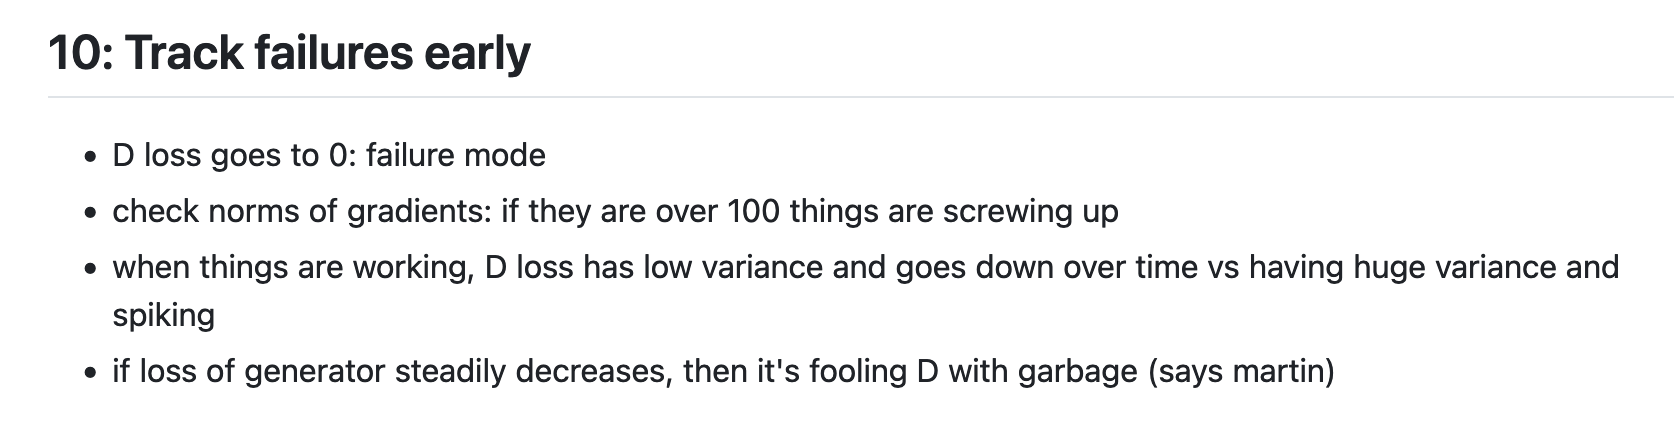

## Lets try the PyTorch implementation

In [28]:
model_256 = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                        'PGAN', model_name='celebAHQ-256',
                        pretrained=True, useGPU=True)

Using cache found in /home/yusuf/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [127]:
print("Generator structure:")
print(model_256.getNetG())

print("\nDiscriminator structure:")
print(model_256.getNetD())

Generator structure:
GNet(
  (scaleLayers): ModuleList(
    (0-2): 3 x ModuleList(
      (0-1): 2 x EqualizedConv2d(
        (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (4): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): ModuleList(
      (0): EqualizedConv2d(
        (module): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): EqualizedConv2d(
        (module): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [59]:
out = model_256.netG(noise_tensor)

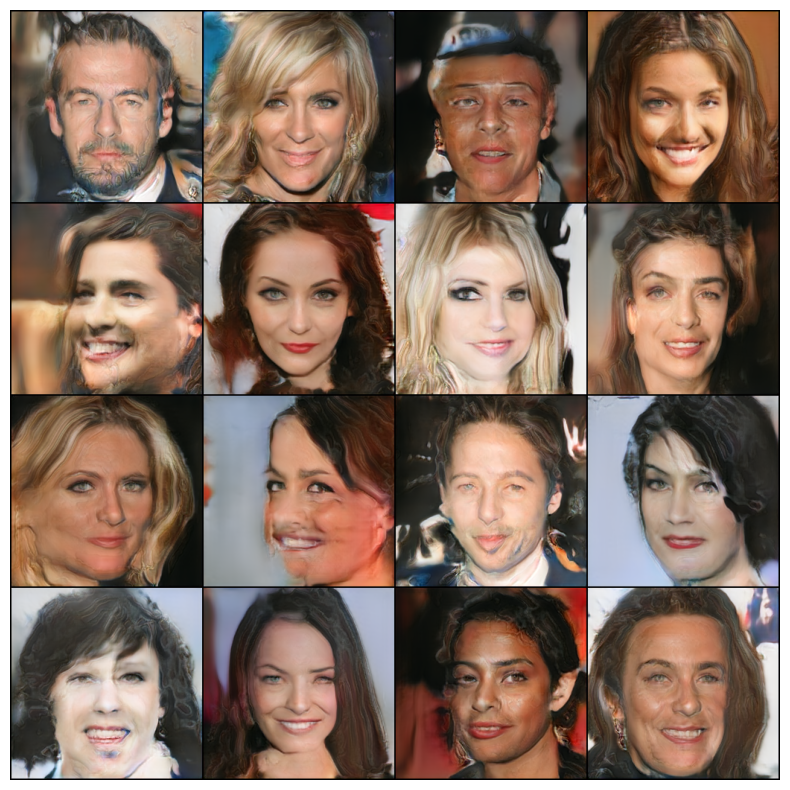

In [60]:
show_images(out)

# Reimplementing the code by paper authors
## https://github.com/tkarras/progressive_growing_of_gans

In [5]:
import numpy as np
import torch 

In [6]:
def lerp(a, b, t): return a + (b-a) * t
def lerp_clip(a, b, t): return a + - (b-a) * torch.clamp(t, 0.0, 1.0)
def cset(cur_lambda, new_cond, new_lambda):
    return lambda: torch.cond(new_cond, new_lambda, cur_lambda)

In [16]:
# Get/create weight tensor for a convolutional or fully-connected layer.
def get_weight(shape, gain=np.sqrt(2), use_wscale=False, fan_in=None):
    if fan_in is None: fan_in = np.prod(shape[:-1])
    std = gain / np.sqrt(fan_in)  # He init
    if use_scale:
        # Possible problem area may need testing?
        wscale = torch.tensor(std, dtype=torch.float32) # no name param
        weight = nn.Parameter(torch.empty(shape))
        nn.init.normal_(weight)
        weight.data *= wscale
        return weight
    else:
        weight = nn.Parameter(torch.empty(shape))
        nn.init.normal_(weight, 0, std)
        return weight

In [17]:
# Full connected layer
def dense(x, fmaps, gain=np.sqrt(2), use_wscale=False):
    if len(x.shape) > 2:
        x = torch.reshape(x, [-1, np.prd([d.value for d in x.shape[1:]])])
    w = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)
    w = w.to(dtype=x.dtype)  # we assume w is a tensor here
    return torch.matmul(x, w)

class dense(nn.Module):
    def __init__(self, x, fmaps, gain=np.sqrt(2), use_wscale=False):
        super(Dense, self).__init__()
        self.weight = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)

In [20]:
# Convolutional layer
def conv2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)
    w = w.to(dtype=x.dtype)
    return F.conv2d(x, w, stride=1, padding='same')

In [21]:
# Apply bias to the given activation tensor
def apply_bias(x):
    b = nn.Parameter(torch.empty(x.shape[1]))
    nn.init.zeros_(b)
    b = b.to(x.dtype)
    if len(x.shape) == 2:
        return x + b
    else:
        return x + torch.reshape(b, [1, -1, 1, 1])

In [22]:
# Leaky ReLU activation
def leaky_ReLU(x, alpha=0.2):
    return torch.max(x*alpha, x)

In [23]:
# NN upscale layer
def upscale2d(x, factor=2):
    assert isintance(factor, int) and factor >= 1
    if factor == 1: return x
    
    s = x.shape
    x = torch.reshape(x, [-1, s[1], s[2], s[3], 1])
    x = x.repeat(1, 1, 1, factor, 1, factor)
    x = torch.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
    return x

In [27]:
# Fused upscale2d + conv3d
def upscale2d_conv2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight([kernel, kernel, fmaps, x.shape[1].value], gain=gain, use_wscale=use_wscale, fan_in=((kernel**2)*x.shape[1].value))
    w = F.pad(w, (0, 0, 0, 0, 1, 1, 1, 1), mode='constant')
    w = w[1:, 1:] + w[:-1, 1:] + w[1:, :-1] + w[:-1, :-1]
    w = w.to(dtype=x.dtype)
    #os = [x.shape[0], fmaps, x.shape[2] * 2, x.shape[3] * 3] dont need output shape in pytorch
    return F.conv_transpose2d(x, w, stride=2, padding=1, output_padding=1)

In [28]:
# box filter downscaling layer
def downscale2d(x, factor=2):
    assert isinstance(factor, int) and factor >= 1
    if factor == 1: return x
    ksize = (factor, factor)
    return F.avg_pool2d(x, kernel_size=ksize, stride=ksize, padding=0, ceil_mode=false)

In [29]:
# Fused conv2d + downscale2d
def conv2d_downscale2d(x, fmaps, kernel, gain=np.sqrt(2), use_wscale=False):
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale)
    w = F.pad(w, (0, 0, 1, 1), mode='constant')
    w = (w[1:, 1:] + w[:-1, 1:], w[:-1, 1:] + w[:-1, :-1]) * 0.25
    w = w.to(dtype=x.dtype)
    return F.conv2d(x, w, stride=2, padding=1)

In [30]:
# Pixelwise feature vector norm
def pixel_norm(x, epsilon=1e-8):
    return x * torch.rsqrt(torch.mean(torch.square(x), dim=1, keepdim=True) + epsilon)

In [31]:
def minibatch_stddev_layer(x, group_size=4):
    # Minibatch needs to be divisible by (or smaller than) group_size
    group_size = torch.minimum(group_size, x.size(0))
    # N,C,H,W input shape
    s = x.shape
    # G,M,C,H,W split minibatch into M groups of size G
    y = torch.reshape(x, [group_size, -1, s[1], s[2], s[3]])
    # G,M,C,H,W cast to FP32
    y = y.to(dtype=torch.float32)
    # G,M,C,H,W subtract mean over group
    y -= torch.mean(y, axis=0, keepdim=True)
    # M,C,H,W calc var over group
    y = torch.mean(torch.square(y), axis=0)
    # M,C,H,W calc stddev over group
    y = torch.sqrt(y + 1e-8)
    # M,1,1,1 take avg over fmaps and pixels
    y = torch.mean(y, axis=[1,2,3], keepdim=True)
    # M,1,1,1 cast back to original dtype
    y = y.to(x.dtype)
    # N,1,H,W replicate over group and pixels
    y = torch.repeat(group_size, 1, s[2], s[3])
    # N,C,H,W append as new map
    return torch.cat([x, y], dim=1)

In [ ]:
# Generator network used in the paper
class G_paper(nn.Module):
    def __init__(
        self,
        num_channels=1,                # Number of output color channels
        resolution=32,                 # Output resolution. 
        label_size=0,                  # Dimensionality of the labels, 0 if no labels.
        fmap_base=8192,                # Overall multiplier for number of feature maps
        fmap_decay=1.0,                # log2 feature map reduction when doubling resolution
        fmap_max=512,                  # Max number of feature maps in any layer
        latent_size=None,              # Dimensionalitu of latent vectors. None = min(fmap_base, fmap_max)
        normalize_latents=True,        # normalise the latents before feeding to networw
        use_wscale=None,               # enable EQ LR?
        use_pixelnorm=None,            # enable pixelwise feature norm?
        pixelnorm_epsilon=1e-8,        # constant epsilon for pixelnorm
        use_leakyrelu=True,            # True = LeakyReLU, False = ReLU
        dtype='float32',               # Dtype used for activations and outputs
        fused_scale=True,              # True = use fused upscale, False = seperate
        structure=None,                # Do i even need this?
    ):
        super().__init__()
        
        self.num_channels = num_channels
        self.resolution = resolution
        self.label_size = label_size
        self.
        
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resoluition >= 4
        
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        
        def PN(x):
            return pixel_norm(x, epsilon=pixelnorm_epsilon) if use_pixelnorm else x
        
        if latent_size is None:
            latent_size = nf(0)
        
        act = leaky_relu if use_leakyrelu else nn.ReLU()
        
        # Block
        def block(x, res):
            if res == 2: #4x4
                if normalize_latents: 
                    x = pixel_norm(x, epsilon=pixelnorm_epsilon)
                
                x = dense()
        
        
    def forward(self, latents_in, labels_in=None):
        
        

In [14]:
# The testing suite block, here I will explore what tensorflow
# things do and the PyTorch counterparts
# For get_weight method
a = tf.constant(np.float32(10))
print(a, a.dtype)
b = torch.tensor(np.float32(10))
print(b, b.dtype)

tf.Tensor(10.0, shape=(), dtype=float32) <dtype: 'float32'>
tensor(10.) torch.float32
